<a href="https://colab.research.google.com/github/Tawheed-tariq/Machine-learning-course/blob/main/simple%20projects/malaria%20diagnosis/malaria_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Layer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras.models import Model
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint


In [2]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files= True, split = ['train'])

In [3]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))

  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset , val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Data Visualization

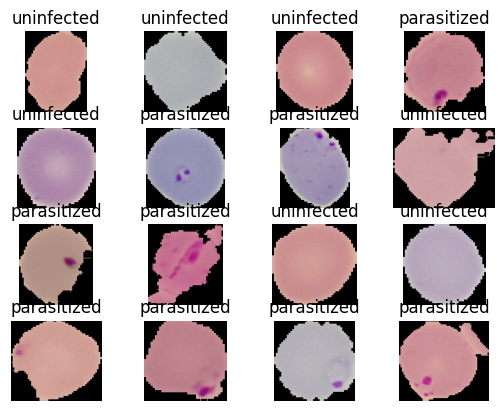

In [6]:
for i , (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Data preprocessing

In [7]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/ 255.0, label

In [8]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [9]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model Creation and Training

In [11]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [12]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
x = Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)
x = Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "feature_extractor")
feature_extractor_model.summary()


Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [13]:
feature_extractor_seq = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
])
feature_extractor_seq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [14]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
# x = feature_extractor_model(func_input)
x = feature_extractor_seq(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name = "lenet_Model")
lenet_model_func.summary()


Model: "lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_8 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                       

# Model Subclassing

In [15]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, padding, strides, activation, pool_size):
    super(FeatureExtractor, self).__init__()
    self.conv1 = Conv2D(filters = filters , kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)
    self.bn1 = BatchNormalization()
    self.maxpool1 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

    self.conv2 = Conv2D(filters = 2*filters , kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)
    self.bn2 = BatchNormalization()
    self.maxpool2 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

  def call(self, x, training):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.maxpool2(x)
    return x

feature_sub_classed = FeatureExtractor(8, 3, 'valid', 1, 'relu', 2)


In [16]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
x = feature_sub_classed(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name = "lenet_Model")
lenet_model_func.summary()


Model: "lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [17]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    self.feature_extractor = FeatureExtractor(8, 3, 'valid', 1, 'relu', 2)

    self.flatten = Flatten()
    self.dense1 = Dense(100, activation = 'relu')

    self.bn1 = BatchNormalization()
    self.dense2 = Dense(10, activation = 'relu')
    self.bn2 = BatchNormalization()

    self.dense3 = Dense(1, activation = 'sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)

    x = self.flatten(x)

    x = self.dense1(x)
    x = self.bn1(x)

    x = self.dense2(x)
    x = self.bn2(x)

    x = self.dense3(x)
    return x

lenet_subclassed_model = LenetModel()
lenet_subclassed_model(tf.zeros([1, 224, 224, 3]), training = False)
lenet_subclassed_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_16 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_17 (Ba  multiple                  

# Callbacks

In [47]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f'\n for epoch number {epoch} the model has loss of {logs["loss"]}')
    def on_batch_end(self, batch, logs):
        print(f'\n for batch number {batch} the model has loss of {logs}')

## CSV Logger

In [54]:
csv_callback = CSVLogger(
    'logs.csv',
    separator = ',',
    append = False
)

## Early Stopping

In [65]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta = 0, patience = 2, verbose = 1, mode = 'auto', baseline = None, restore_best_weights = False
)

## Learning Rate Schedular

In [67]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

scheduler_callack = LearningRateScheduler(scheduler, verbose = 1)

## Model Checkpointing

In [80]:
checkpoint_callback = ModelCheckpoint(
    'ceheckpoints/', mode = 'auto', monitor = 'val_loss', save_best_only = True, save_weights_only = False, save_freq = 'epoch', verbose = 1
)

# Model Training

In [74]:
metrics = [TruePositives(name= 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'),
           BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc')]

In [75]:
lenet_subclassed_model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = metrics
)

In [77]:
history = lenet_subclassed_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks = [scheduler_callack, checkpoint_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
  2/689 [..............................] - ETA: 57s - loss: 0.0336 - tp: 33.0000 - fp: 1.0000 - tn: 30.0000 - fn: 0.0000e+00 - accuracy: 0.9844 - precision: 0.9706 - recall: 1.0000 - auc: 1.0000     

  5/689 [..............................] - ETA: 58s - loss: 0.0865 - tp: 84.0000 - fp: 4.0000 - tn: 71.0000 - fn: 1.0000 - accuracy: 0.9688 - precision: 0.9545 - recall: 0.9882 - auc: 0.9947    

  8/689 [..............................] - ETA: 51s - loss: 0.0734 - tp: 131.0000 - fp: 5.0000 - tn: 118.0000 - fn: 2.0000 - accuracy: 0.9727 - precision: 0.9632 - recall: 0.9850 - auc: 0.9969

 11/689 [..............................] - ETA: 49s - loss: 0.0674 - tp: 181.0000 - fp: 5.0000 - tn: 161.0000 - fn: 5.0000 - accuracy: 0.9716 - precision: 0.9731 - recall: 0.9731 - auc: 0.9969

 14/689 [..............................] - ETA: 48s - loss: 0.0561 - tp: 238.0000 - fp: 5.0000 - tn: 200.0000 - fn: 5.0000 - accuracy: 0.9777 - precision: 0.9794 - recall: 0.9794 - auc: 0.9975

 17/689 [..............................] - ETA: 54s - loss: 0.0681 - tp: 275.0000 - fp: 10.0000 - tn: 254.0000 - fn: 5.0000 - accuracy: 0.9724 - precision: 0.9649 - recall: 0.9821 - auc: 0.9973

 20/689 [..............................] - ETA: 58s - loss: 0.0595 - tp: 322.0000 - fp: 10.0000 - tn: 303.0000 - fn: 5.0000 - accuracy: 0.9766 - precision: 0.9699 - recall: 0.9847 - auc: 0.9979

 23/689 [>.............................] - ETA: 1:00 - loss: 0.0641 - tp: 372.0000 - fp: 13.0000 - tn: 346.0000 - fn: 5.0000 - accuracy: 0.9755 - precision: 0.9662 - recall: 0.9867 - auc: 0.9962

 26/689 [>.............................] - ETA: 1:02 - loss: 0.0593 - tp: 416.0000 - fp: 13.0000 - tn: 398.0000 - fn: 5.0000 - accuracy: 0.9784 - precision: 0.9697 - recall: 0.9881 - auc: 0.9966

 29/689 [>.............................] - ETA: 1:00 - loss: 0.0591 - tp: 463.0000 - fp: 13.0000 - tn: 445.0000 - fn: 7.0000 - accuracy: 0.9784 - precision: 0.9727 - recall: 0.9851 - auc: 0.9967

 32/689 [>.............................] - ETA: 58s - loss: 0.0597 - tp: 515.0000 - fp: 15.0000 - tn: 486.0000 - fn: 8.0000 - accuracy: 0.9775 - precision: 0.9717 - recall: 0.9847 - auc: 0.9967

 35/689 [>.............................] - ETA: 57s - loss: 0.0666 - tp: 565.0000 - fp: 17.0000 - tn: 528.0000 - fn: 10.0000 - accuracy: 0.9759 - precision: 0.9708 - recall: 0.9826 - auc: 0.9952

 38/689 [>.............................] - ETA: 55s - loss: 0.0712 - tp: 624.0000 - fp: 17.0000 - tn: 561.0000 - fn: 14.0000 - accuracy: 0.9745 - precision: 0.9735 - recall: 0.9781 - auc: 0.9949

 41/689 [>.............................] - ETA: 54s - loss: 0.0708 - tp: 677.0000 - fp: 17.0000 - tn: 603.0000 - fn: 15.0000 - accuracy: 0.9756 - precision: 0.9755 - recall: 0.9783 - auc: 0.9950

 44/689 [>.............................] - ETA: 52s - loss: 0.0737 - tp: 723.0000 - fp: 19.0000 - tn: 651.0000 - fn: 15.0000 - accuracy: 0.9759 - precision: 0.9744 - recall: 0.9797 - auc: 0.9946

 47/689 [=>............................] - ETA: 53s - loss: 0.0751 - tp: 768.0000 - fp: 23.0000 - tn: 698.0000 - fn: 15.0000 - accuracy: 0.9747 - precision: 0.9709 - recall: 0.9808 - auc: 0.9947

 50/689 [=>............................] - ETA: 52s - loss: 0.0723 - tp: 821.0000 - fp: 23.0000 - tn: 740.0000 - fn: 16.0000 - accuracy: 0.9756 - precision: 0.9727 - recall: 0.9809 - auc: 0.9950

 53/689 [=>............................] - ETA: 51s - loss: 0.0703 - tp: 872.0000 - fp: 24.0000 - tn: 784.0000 - fn: 16.0000 - accuracy: 0.9764 - precision: 0.9732 - recall: 0.9820 - auc: 0.9953

 56/689 [=>............................] - ETA: 50s - loss: 0.0701 - tp: 919.0000 - fp: 25.0000 - tn: 832.0000 - fn: 16.0000 - accuracy: 0.9771 - precision: 0.9735 - recall: 0.9829 - auc: 0.9953

 59/689 [=>............................] - ETA: 49s - loss: 0.0674 - tp: 959.0000 - fp: 25.0000 - tn: 888.0000 - fn: 16.0000 - accuracy: 0.9783 - precision: 0.9746 - recall: 0.9836 - auc: 0.9956

 62/689 [=>............................] - ETA: 48s - loss: 0.0665 - tp: 1008.0000 - fp: 25.0000 - tn: 934.0000 - fn: 17.0000 - accuracy: 0.9788 - precision: 0.9758 - recall: 0.9834 - auc: 0.9958

 65/689 [=>............................] - ETA: 48s - loss: 0.0684 - tp: 1060.0000 - fp: 30.0000 - tn: 973.0000 - fn: 17.0000 - accuracy: 0.9774 - precision: 0.9725 - recall: 0.9842 - auc: 0.9957

 68/689 [=>............................] - ETA: 48s - loss: 0.0676 - tp: 1112.0000 - fp: 32.0000 - tn: 1015.0000 - fn: 17.0000 - accuracy: 0.9775 - precision: 0.9720 - recall: 0.9849 - auc: 0.9959

 71/689 [==>...........................] - ETA: 47s - loss: 0.0654 - tp: 1165.0000 - fp: 32.0000 - tn: 1058.0000 - fn: 17.0000 - accuracy: 0.9784 - precision: 0.9733 - recall: 0.9856 - auc: 0.9961

 74/689 [==>...........................] - ETA: 46s - loss: 0.0653 - tp: 1214.0000 - fp: 34.0000 - tn: 1102.0000 - fn: 18.0000 - accuracy: 0.9780 - precision: 0.9728 - recall: 0.9854 - auc: 0.9961

 77/689 [==>...........................] - ETA: 45s - loss: 0.0633 - tp: 1260.0000 - fp: 34.0000 - tn: 1152.0000 - fn: 18.0000 - accuracy: 0.9789 - precision: 0.9737 - recall: 0.9859 - auc: 0.9963

 79/689 [==>...........................] - ETA: 45s - loss: 0.0621 - tp: 1291.0000 - fp: 34.0000 - tn: 1185.0000 - fn: 18.0000 - accuracy: 0.9794 - precision: 0.9743 - recall: 0.9862 - auc: 0.9964

 83/689 [==>...........................] - ETA: 44s - loss: 0.0599 - tp: 1363.0000 - fp: 34.0000 - tn: 1241.0000 - fn: 18.0000 - accuracy: 0.9804 - precision: 0.9757 - recall: 0.9870 - auc: 0.9966

 86/689 [==>...........................] - ETA: 44s - loss: 0.0595 - tp: 1409.0000 - fp: 35.0000 - tn: 1290.0000 - fn: 18.0000 - accuracy: 0.9807 - precision: 0.9758 - recall: 0.9874 - auc: 0.9967

 89/689 [==>...........................] - ETA: 43s - loss: 0.0604 - tp: 1454.0000 - fp: 37.0000 - tn: 1337.0000 - fn: 20.0000 - accuracy: 0.9800 - precision: 0.9752 - recall: 0.9864 - auc: 0.9967

 92/689 [===>..........................] - ETA: 43s - loss: 0.0606 - tp: 1496.0000 - fp: 40.0000 - tn: 1388.0000 - fn: 20.0000 - accuracy: 0.9796 - precision: 0.9740 - recall: 0.9868 - auc: 0.9967

 95/689 [===>..........................] - ETA: 43s - loss: 0.0623 - tp: 1544.0000 - fp: 42.0000 - tn: 1433.0000 - fn: 21.0000 - accuracy: 0.9793 - precision: 0.9735 - recall: 0.9866 - auc: 0.9965

 98/689 [===>..........................] - ETA: 43s - loss: 0.0634 - tp: 1583.0000 - fp: 46.0000 - tn: 1486.0000 - fn: 21.0000 - accuracy: 0.9786 - precision: 0.9718 - recall: 0.9869 - auc: 0.9965

101/689 [===>..........................] - ETA: 43s - loss: 0.0620 - tp: 1630.0000 - fp: 47.0000 - tn: 1534.0000 - fn: 21.0000 - accuracy: 0.9790 - precision: 0.9720 - recall: 0.9873 - auc: 0.9966

104/689 [===>..........................] - ETA: 43s - loss: 0.0621 - tp: 1672.0000 - fp: 50.0000 - tn: 1585.0000 - fn: 21.0000 - accuracy: 0.9787 - precision: 0.9710 - recall: 0.9876 - auc: 0.9967

107/689 [===>..........................] - ETA: 42s - loss: 0.0630 - tp: 1719.0000 - fp: 50.0000 - tn: 1631.0000 - fn: 24.0000 - accuracy: 0.9784 - precision: 0.9717 - recall: 0.9862 - auc: 0.9966

110/689 [===>..........................] - ETA: 42s - loss: 0.0616 - tp: 1767.0000 - fp: 50.0000 - tn: 1679.0000 - fn: 24.0000 - accuracy: 0.9790 - precision: 0.9725 - recall: 0.9866 - auc: 0.9968

113/689 [===>..........................] - ETA: 42s - loss: 0.0620 - tp: 1809.0000 - fp: 52.0000 - tn: 1730.0000 - fn: 25.0000 - accuracy: 0.9787 - precision: 0.9721 - recall: 0.9864 - auc: 0.9968

116/689 [====>.........................] - ETA: 42s - loss: 0.0614 - tp: 1859.0000 - fp: 52.0000 - tn: 1775.0000 - fn: 26.0000 - accuracy: 0.9790 - precision: 0.9728 - recall: 0.9862 - auc: 0.9968

119/689 [====>.........................] - ETA: 42s - loss: 0.0614 - tp: 1904.0000 - fp: 54.0000 - tn: 1824.0000 - fn: 26.0000 - accuracy: 0.9790 - precision: 0.9724 - recall: 0.9865 - auc: 0.9968

122/689 [====>.........................] - ETA: 42s - loss: 0.0613 - tp: 1949.0000 - fp: 55.0000 - tn: 1874.0000 - fn: 26.0000 - accuracy: 0.9793 - precision: 0.9726 - recall: 0.9868 - auc: 0.9968

124/689 [====>.........................] - ETA: 42s - loss: 0.0613 - tp: 1976.0000 - fp: 56.0000 - tn: 1910.0000 - fn: 26.0000 - accuracy: 0.9793 - precision: 0.9724 - recall: 0.9870 - auc: 0.9968

127/689 [====>.........................] - ETA: 41s - loss: 0.0607 - tp: 2020.0000 - fp: 58.0000 - tn: 1959.0000 - fn: 27.0000 - accuracy: 0.9791 - precision: 0.9721 - recall: 0.9868 - auc: 0.9969

131/689 [====>.........................] - ETA: 40s - loss: 0.0592 - tp: 2084.0000 - fp: 58.0000 - tn: 2023.0000 - fn: 27.0000 - accuracy: 0.9797 - precision: 0.9729 - recall: 0.9872 - auc: 0.9970

134/689 [====>.........................] - ETA: 40s - loss: 0.0591 - tp: 2125.0000 - fp: 58.0000 - tn: 2075.0000 - fn: 30.0000 - accuracy: 0.9795 - precision: 0.9734 - recall: 0.9861 - auc: 0.9971

137/689 [====>.........................] - ETA: 39s - loss: 0.0586 - tp: 2174.0000 - fp: 59.0000 - tn: 2120.0000 - fn: 31.0000 - accuracy: 0.9795 - precision: 0.9736 - recall: 0.9859 - auc: 0.9971

139/689 [=====>........................] - ETA: 39s - loss: 0.0595 - tp: 2210.0000 - fp: 59.0000 - tn: 2145.0000 - fn: 34.0000 - accuracy: 0.9791 - precision: 0.9740 - recall: 0.9848 - auc: 0.9971

143/689 [=====>........................] - ETA: 38s - loss: 0.0583 - tp: 2270.0000 - fp: 59.0000 - tn: 2213.0000 - fn: 34.0000 - accuracy: 0.9797 - precision: 0.9747 - recall: 0.9852 - auc: 0.9972

145/689 [=====>........................] - ETA: 38s - loss: 0.0579 - tp: 2306.0000 - fp: 59.0000 - tn: 2241.0000 - fn: 34.0000 - accuracy: 0.9800 - precision: 0.9751 - recall: 0.9855 - auc: 0.9972

149/689 [=====>........................] - ETA: 37s - loss: 0.0585 - tp: 2369.0000 - fp: 62.0000 - tn: 2302.0000 - fn: 35.0000 - accuracy: 0.9797 - precision: 0.9745 - recall: 0.9854 - auc: 0.9972

151/689 [=====>........................] - ETA: 36s - loss: 0.0579 - tp: 2403.0000 - fp: 62.0000 - tn: 2332.0000 - fn: 35.0000 - accuracy: 0.9799 - precision: 0.9748 - recall: 0.9856 - auc: 0.9972

155/689 [=====>........................] - ETA: 36s - loss: 0.0587 - tp: 2468.0000 - fp: 64.0000 - tn: 2393.0000 - fn: 35.0000 - accuracy: 0.9800 - precision: 0.9747 - recall: 0.9860 - auc: 0.9970

158/689 [=====>........................] - ETA: 35s - loss: 0.0597 - tp: 2509.0000 - fp: 67.0000 - tn: 2443.0000 - fn: 37.0000 - accuracy: 0.9794 - precision: 0.9740 - recall: 0.9855 - auc: 0.9969

161/689 [======>.......................] - ETA: 35s - loss: 0.0596 - tp: 2559.0000 - fp: 68.0000 - tn: 2488.0000 - fn: 37.0000 - accuracy: 0.9796 - precision: 0.9741 - recall: 0.9857 - auc: 0.9969

164/689 [======>.......................] - ETA: 35s - loss: 0.0588 - tp: 2615.0000 - fp: 68.0000 - tn: 2528.0000 - fn: 37.0000 - accuracy: 0.9800 - precision: 0.9747 - recall: 0.9860 - auc: 0.9970

167/689 [======>.......................] - ETA: 35s - loss: 0.0588 - tp: 2655.0000 - fp: 70.0000 - tn: 2582.0000 - fn: 37.0000 - accuracy: 0.9800 - precision: 0.9743 - recall: 0.9863 - auc: 0.9970

169/689 [======>.......................] - ETA: 35s - loss: 0.0584 - tp: 2686.0000 - fp: 71.0000 - tn: 2614.0000 - fn: 37.0000 - accuracy: 0.9800 - precision: 0.9742 - recall: 0.9864 - auc: 0.9971

172/689 [======>.......................] - ETA: 34s - loss: 0.0577 - tp: 2736.0000 - fp: 71.0000 - tn: 2659.0000 - fn: 38.0000 - accuracy: 0.9802 - precision: 0.9747 - recall: 0.9863 - auc: 0.9971

176/689 [======>.......................] - ETA: 34s - loss: 0.0581 - tp: 2794.0000 - fp: 73.0000 - tn: 2725.0000 - fn: 40.0000 - accuracy: 0.9799 - precision: 0.9745 - recall: 0.9859 - auc: 0.9971

178/689 [======>.......................] - ETA: 33s - loss: 0.0576 - tp: 2820.0000 - fp: 73.0000 - tn: 2763.0000 - fn: 40.0000 - accuracy: 0.9802 - precision: 0.9748 - recall: 0.9860 - auc: 0.9972

182/689 [======>.......................] - ETA: 33s - loss: 0.0574 - tp: 2885.0000 - fp: 74.0000 - tn: 2824.0000 - fn: 41.0000 - accuracy: 0.9803 - precision: 0.9750 - recall: 0.9860 - auc: 0.9972

184/689 [=======>......................] - ETA: 33s - loss: 0.0574 - tp: 2915.0000 - fp: 75.0000 - tn: 2856.0000 - fn: 42.0000 - accuracy: 0.9801 - precision: 0.9749 - recall: 0.9858 - auc: 0.9972

188/689 [=======>......................] - ETA: 32s - loss: 0.0575 - tp: 2981.0000 - fp: 76.0000 - tn: 2916.0000 - fn: 43.0000 - accuracy: 0.9802 - precision: 0.9751 - recall: 0.9858 - auc: 0.9972

190/689 [=======>......................] - ETA: 32s - loss: 0.0575 - tp: 3018.0000 - fp: 77.0000 - tn: 2941.0000 - fn: 44.0000 - accuracy: 0.9801 - precision: 0.9751 - recall: 0.9856 - auc: 0.9972

194/689 [=======>......................] - ETA: 31s - loss: 0.0573 - tp: 3085.0000 - fp: 78.0000 - tn: 3000.0000 - fn: 45.0000 - accuracy: 0.9802 - precision: 0.9753 - recall: 0.9856 - auc: 0.9972

197/689 [=======>......................] - ETA: 31s - loss: 0.0580 - tp: 3132.0000 - fp: 79.0000 - tn: 3047.0000 - fn: 46.0000 - accuracy: 0.9802 - precision: 0.9754 - recall: 0.9855 - auc: 0.9970

200/689 [=======>......................] - ETA: 31s - loss: 0.0579 - tp: 3182.0000 - fp: 79.0000 - tn: 3092.0000 - fn: 47.0000 - accuracy: 0.9803 - precision: 0.9758 - recall: 0.9854 - auc: 0.9971

202/689 [=======>......................] - ETA: 31s - loss: 0.0575 - tp: 3216.0000 - fp: 79.0000 - tn: 3122.0000 - fn: 47.0000 - accuracy: 0.9805 - precision: 0.9760 - recall: 0.9856 - auc: 0.9971

206/689 [=======>......................] - ETA: 30s - loss: 0.0566 - tp: 3280.0000 - fp: 79.0000 - tn: 3186.0000 - fn: 47.0000 - accuracy: 0.9809 - precision: 0.9765 - recall: 0.9859 - auc: 0.9972

208/689 [========>.....................] - ETA: 30s - loss: 0.0564 - tp: 3305.0000 - fp: 80.0000 - tn: 3224.0000 - fn: 47.0000 - accuracy: 0.9809 - precision: 0.9764 - recall: 0.9860 - auc: 0.9972

212/689 [========>.....................] - ETA: 29s - loss: 0.0564 - tp: 3363.0000 - fp: 81.0000 - tn: 3292.0000 - fn: 48.0000 - accuracy: 0.9810 - precision: 0.9765 - recall: 0.9859 - auc: 0.9972

215/689 [========>.....................] - ETA: 29s - loss: 0.0557 - tp: 3404.0000 - fp: 81.0000 - tn: 3347.0000 - fn: 48.0000 - accuracy: 0.9812 - precision: 0.9768 - recall: 0.9861 - auc: 0.9973

218/689 [========>.....................] - ETA: 29s - loss: 0.0554 - tp: 3451.0000 - fp: 82.0000 - tn: 3394.0000 - fn: 49.0000 - accuracy: 0.9812 - precision: 0.9768 - recall: 0.9860 - auc: 0.9973

220/689 [========>.....................] - ETA: 29s - loss: 0.0551 - tp: 3485.0000 - fp: 83.0000 - tn: 3423.0000 - fn: 49.0000 - accuracy: 0.9812 - precision: 0.9767 - recall: 0.9861 - auc: 0.9973

224/689 [========>.....................] - ETA: 28s - loss: 0.0550 - tp: 3553.0000 - fp: 84.0000 - tn: 3481.0000 - fn: 50.0000 - accuracy: 0.9813 - precision: 0.9769 - recall: 0.9861 - auc: 0.9974

226/689 [========>.....................] - ETA: 28s - loss: 0.0546 - tp: 3586.0000 - fp: 84.0000 - tn: 3512.0000 - fn: 50.0000 - accuracy: 0.9815 - precision: 0.9771 - recall: 0.9862 - auc: 0.9974

230/689 [=========>....................] - ETA: 28s - loss: 0.0558 - tp: 3642.0000 - fp: 91.0000 - tn: 3577.0000 - fn: 50.0000 - accuracy: 0.9808 - precision: 0.9756 - recall: 0.9865 - auc: 0.9973

232/689 [=========>....................] - ETA: 27s - loss: 0.0554 - tp: 3671.0000 - fp: 91.0000 - tn: 3612.0000 - fn: 50.0000 - accuracy: 0.9810 - precision: 0.9758 - recall: 0.9866 - auc: 0.9974

236/689 [=========>....................] - ETA: 27s - loss: 0.0569 - tp: 3737.0000 - fp: 95.0000 - tn: 3669.0000 - fn: 51.0000 - accuracy: 0.9807 - precision: 0.9752 - recall: 0.9865 - auc: 0.9972

238/689 [=========>....................] - ETA: 27s - loss: 0.0576 - tp: 3768.0000 - fp: 96.0000 - tn: 3698.0000 - fn: 54.0000 - accuracy: 0.9803 - precision: 0.9752 - recall: 0.9859 - auc: 0.9971

242/689 [=========>....................] - ETA: 26s - loss: 0.0570 - tp: 3825.0000 - fp: 97.0000 - tn: 3768.0000 - fn: 54.0000 - accuracy: 0.9805 - precision: 0.9753 - recall: 0.9861 - auc: 0.9972

245/689 [=========>....................] - ETA: 26s - loss: 0.0565 - tp: 3877.0000 - fp: 97.0000 - tn: 3811.0000 - fn: 55.0000 - accuracy: 0.9806 - precision: 0.9756 - recall: 0.9860 - auc: 0.9972

248/689 [=========>....................] - ETA: 26s - loss: 0.0563 - tp: 3926.0000 - fp: 97.0000 - tn: 3857.0000 - fn: 56.0000 - accuracy: 0.9807 - precision: 0.9759 - recall: 0.9859 - auc: 0.9973

250/689 [=========>....................] - ETA: 26s - loss: 0.0559 - tp: 3960.0000 - fp: 97.0000 - tn: 3887.0000 - fn: 56.0000 - accuracy: 0.9809 - precision: 0.9761 - recall: 0.9861 - auc: 0.9973

254/689 [==========>...................] - ETA: 25s - loss: 0.0562 - tp: 4017.0000 - fp: 99.0000 - tn: 3955.0000 - fn: 57.0000 - accuracy: 0.9808 - precision: 0.9759 - recall: 0.9860 - auc: 0.9973

256/689 [==========>...................] - ETA: 25s - loss: 0.0558 - tp: 4048.0000 - fp: 99.0000 - tn: 3988.0000 - fn: 57.0000 - accuracy: 0.9810 - precision: 0.9761 - recall: 0.9861 - auc: 0.9973

259/689 [==========>...................] - ETA: 25s - loss: 0.0563 - tp: 4095.0000 - fp: 100.0000 - tn: 4033.0000 - fn: 60.0000 - accuracy: 0.9807 - precision: 0.9762 - recall: 0.9856 - auc: 0.9973

263/689 [==========>...................] - ETA: 25s - loss: 0.0567 - tp: 4160.0000 - fp: 103.0000 - tn: 4093.0000 - fn: 60.0000 - accuracy: 0.9806 - precision: 0.9758 - recall: 0.9858 - auc: 0.9972

266/689 [==========>...................] - ETA: 24s - loss: 0.0571 - tp: 4206.0000 - fp: 103.0000 - tn: 4142.0000 - fn: 61.0000 - accuracy: 0.9807 - precision: 0.9761 - recall: 0.9857 - auc: 0.9971

268/689 [==========>...................] - ETA: 24s - loss: 0.0568 - tp: 4236.0000 - fp: 103.0000 - tn: 4176.0000 - fn: 61.0000 - accuracy: 0.9809 - precision: 0.9763 - recall: 0.9858 - auc: 0.9972

272/689 [==========>...................] - ETA: 24s - loss: 0.0574 - tp: 4305.0000 - fp: 105.0000 - tn: 4231.0000 - fn: 63.0000 - accuracy: 0.9807 - precision: 0.9762 - recall: 0.9856 - auc: 0.9971

274/689 [==========>...................] - ETA: 24s - loss: 0.0571 - tp: 4337.0000 - fp: 105.0000 - tn: 4263.0000 - fn: 63.0000 - accuracy: 0.9808 - precision: 0.9764 - recall: 0.9857 - auc: 0.9972

278/689 [===========>..................] - ETA: 23s - loss: 0.0580 - tp: 4396.0000 - fp: 108.0000 - tn: 4328.0000 - fn: 64.0000 - accuracy: 0.9807 - precision: 0.9760 - recall: 0.9857 - auc: 0.9970

280/689 [===========>..................] - ETA: 23s - loss: 0.0579 - tp: 4425.0000 - fp: 109.0000 - tn: 4362.0000 - fn: 64.0000 - accuracy: 0.9807 - precision: 0.9760 - recall: 0.9857 - auc: 0.9970

284/689 [===========>..................] - ETA: 23s - loss: 0.0578 - tp: 4491.0000 - fp: 111.0000 - tn: 4421.0000 - fn: 65.0000 - accuracy: 0.9806 - precision: 0.9759 - recall: 0.9857 - auc: 0.9971

287/689 [===========>..................] - ETA: 23s - loss: 0.0574 - tp: 4535.0000 - fp: 111.0000 - tn: 4473.0000 - fn: 65.0000 - accuracy: 0.9808 - precision: 0.9761 - recall: 0.9859 - auc: 0.9971

290/689 [===========>..................] - ETA: 22s - loss: 0.0572 - tp: 4581.0000 - fp: 112.0000 - tn: 4522.0000 - fn: 65.0000 - accuracy: 0.9809 - precision: 0.9761 - recall: 0.9860 - auc: 0.9971

292/689 [===========>..................] - ETA: 22s - loss: 0.0569 - tp: 4608.0000 - fp: 113.0000 - tn: 4558.0000 - fn: 65.0000 - accuracy: 0.9810 - precision: 0.9761 - recall: 0.9861 - auc: 0.9972

296/689 [===========>..................] - ETA: 22s - loss: 0.0567 - tp: 4674.0000 - fp: 114.0000 - tn: 4618.0000 - fn: 66.0000 - accuracy: 0.9810 - precision: 0.9762 - recall: 0.9861 - auc: 0.9972

298/689 [===========>..................] - ETA: 22s - loss: 0.0567 - tp: 4703.0000 - fp: 115.0000 - tn: 4652.0000 - fn: 66.0000 - accuracy: 0.9810 - precision: 0.9761 - recall: 0.9862 - auc: 0.9972

302/689 [============>.................] - ETA: 22s - loss: 0.0562 - tp: 4775.0000 - fp: 115.0000 - tn: 4707.0000 - fn: 67.0000 - accuracy: 0.9812 - precision: 0.9765 - recall: 0.9862 - auc: 0.9972

304/689 [============>.................] - ETA: 21s - loss: 0.0564 - tp: 4808.0000 - fp: 115.0000 - tn: 4736.0000 - fn: 69.0000 - accuracy: 0.9811 - precision: 0.9766 - recall: 0.9859 - auc: 0.9972

307/689 [============>.................] - ETA: 21s - loss: 0.0564 - tp: 4845.0000 - fp: 117.0000 - tn: 4793.0000 - fn: 69.0000 - accuracy: 0.9811 - precision: 0.9764 - recall: 0.9860 - auc: 0.9972

311/689 [============>.................] - ETA: 21s - loss: 0.0559 - tp: 4909.0000 - fp: 117.0000 - tn: 4856.0000 - fn: 70.0000 - accuracy: 0.9812 - precision: 0.9767 - recall: 0.9859 - auc: 0.9973

314/689 [============>.................] - ETA: 21s - loss: 0.0565 - tp: 4959.0000 - fp: 118.0000 - tn: 4900.0000 - fn: 71.0000 - accuracy: 0.9812 - precision: 0.9768 - recall: 0.9859 - auc: 0.9972

316/689 [============>.................] - ETA: 20s - loss: 0.0566 - tp: 4989.0000 - fp: 120.0000 - tn: 4932.0000 - fn: 71.0000 - accuracy: 0.9811 - precision: 0.9765 - recall: 0.9860 - auc: 0.9972

320/689 [============>.................] - ETA: 20s - loss: 0.0565 - tp: 5055.0000 - fp: 120.0000 - tn: 4991.0000 - fn: 74.0000 - accuracy: 0.9811 - precision: 0.9768 - recall: 0.9856 - auc: 0.9972

323/689 [=============>................] - ETA: 20s - loss: 0.0564 - tp: 5095.0000 - fp: 121.0000 - tn: 5046.0000 - fn: 74.0000 - accuracy: 0.9811 - precision: 0.9768 - recall: 0.9857 - auc: 0.9972

326/689 [=============>................] - ETA: 20s - loss: 0.0564 - tp: 5144.0000 - fp: 121.0000 - tn: 5091.0000 - fn: 76.0000 - accuracy: 0.9811 - precision: 0.9770 - recall: 0.9854 - auc: 0.9972

329/689 [=============>................] - ETA: 20s - loss: 0.0566 - tp: 5185.0000 - fp: 125.0000 - tn: 5142.0000 - fn: 76.0000 - accuracy: 0.9809 - precision: 0.9765 - recall: 0.9856 - auc: 0.9972

331/689 [=============>................] - ETA: 19s - loss: 0.0566 - tp: 5212.0000 - fp: 126.0000 - tn: 5178.0000 - fn: 76.0000 - accuracy: 0.9809 - precision: 0.9764 - recall: 0.9856 - auc: 0.9972

334/689 [=============>................] - ETA: 19s - loss: 0.0565 - tp: 5263.0000 - fp: 126.0000 - tn: 5221.0000 - fn: 78.0000 - accuracy: 0.9809 - precision: 0.9766 - recall: 0.9854 - auc: 0.9972

338/689 [=============>................] - ETA: 19s - loss: 0.0567 - tp: 5330.0000 - fp: 129.0000 - tn: 5279.0000 - fn: 78.0000 - accuracy: 0.9809 - precision: 0.9764 - recall: 0.9856 - auc: 0.9972

340/689 [=============>................] - ETA: 19s - loss: 0.0571 - tp: 5361.0000 - fp: 131.0000 - tn: 5310.0000 - fn: 78.0000 - accuracy: 0.9808 - precision: 0.9761 - recall: 0.9857 - auc: 0.9972

344/689 [=============>................] - ETA: 19s - loss: 0.0567 - tp: 5427.0000 - fp: 132.0000 - tn: 5371.0000 - fn: 78.0000 - accuracy: 0.9809 - precision: 0.9763 - recall: 0.9858 - auc: 0.9972

347/689 [==============>...............] - ETA: 18s - loss: 0.0564 - tp: 5463.0000 - fp: 132.0000 - tn: 5431.0000 - fn: 78.0000 - accuracy: 0.9811 - precision: 0.9764 - recall: 0.9859 - auc: 0.9972

349/689 [==============>...............] - ETA: 18s - loss: 0.0569 - tp: 5489.0000 - fp: 134.0000 - tn: 5466.0000 - fn: 79.0000 - accuracy: 0.9809 - precision: 0.9762 - recall: 0.9858 - auc: 0.9972

353/689 [==============>...............] - ETA: 18s - loss: 0.0568 - tp: 5554.0000 - fp: 134.0000 - tn: 5526.0000 - fn: 82.0000 - accuracy: 0.9809 - precision: 0.9764 - recall: 0.9855 - auc: 0.9972

356/689 [==============>...............] - ETA: 18s - loss: 0.0567 - tp: 5601.0000 - fp: 135.0000 - tn: 5573.0000 - fn: 83.0000 - accuracy: 0.9809 - precision: 0.9765 - recall: 0.9854 - auc: 0.9972

359/689 [==============>...............] - ETA: 18s - loss: 0.0568 - tp: 5651.0000 - fp: 135.0000 - tn: 5617.0000 - fn: 85.0000 - accuracy: 0.9808 - precision: 0.9767 - recall: 0.9852 - auc: 0.9972

362/689 [==============>...............] - ETA: 18s - loss: 0.0574 - tp: 5702.0000 - fp: 137.0000 - tn: 5656.0000 - fn: 89.0000 - accuracy: 0.9805 - precision: 0.9765 - recall: 0.9846 - auc: 0.9972

365/689 [==============>...............] - ETA: 18s - loss: 0.0574 - tp: 5746.0000 - fp: 138.0000 - tn: 5706.0000 - fn: 90.0000 - accuracy: 0.9805 - precision: 0.9765 - recall: 0.9846 - auc: 0.9972

368/689 [===============>..............] - ETA: 18s - loss: 0.0573 - tp: 5786.0000 - fp: 139.0000 - tn: 5761.0000 - fn: 90.0000 - accuracy: 0.9806 - precision: 0.9765 - recall: 0.9847 - auc: 0.9972

371/689 [===============>..............] - ETA: 18s - loss: 0.0571 - tp: 5839.0000 - fp: 139.0000 - tn: 5803.0000 - fn: 91.0000 - accuracy: 0.9806 - precision: 0.9767 - recall: 0.9847 - auc: 0.9972

374/689 [===============>..............] - ETA: 17s - loss: 0.0569 - tp: 5882.0000 - fp: 140.0000 - tn: 5855.0000 - fn: 91.0000 - accuracy: 0.9807 - precision: 0.9768 - recall: 0.9848 - auc: 0.9973

377/689 [===============>..............] - ETA: 17s - loss: 0.0571 - tp: 5934.0000 - fp: 141.0000 - tn: 5894.0000 - fn: 95.0000 - accuracy: 0.9804 - precision: 0.9768 - recall: 0.9842 - auc: 0.9973

380/689 [===============>..............] - ETA: 17s - loss: 0.0568 - tp: 5978.0000 - fp: 142.0000 - tn: 5945.0000 - fn: 95.0000 - accuracy: 0.9805 - precision: 0.9768 - recall: 0.9844 - auc: 0.9973

383/689 [===============>..............] - ETA: 17s - loss: 0.0566 - tp: 6022.0000 - fp: 143.0000 - tn: 5996.0000 - fn: 95.0000 - accuracy: 0.9806 - precision: 0.9768 - recall: 0.9845 - auc: 0.9973

386/689 [===============>..............] - ETA: 17s - loss: 0.0563 - tp: 6069.0000 - fp: 143.0000 - tn: 6045.0000 - fn: 95.0000 - accuracy: 0.9807 - precision: 0.9770 - recall: 0.9846 - auc: 0.9973

389/689 [===============>..............] - ETA: 17s - loss: 0.0567 - tp: 6116.0000 - fp: 146.0000 - tn: 6091.0000 - fn: 95.0000 - accuracy: 0.9806 - precision: 0.9767 - recall: 0.9847 - auc: 0.9973

392/689 [================>.............] - ETA: 17s - loss: 0.0568 - tp: 6166.0000 - fp: 148.0000 - tn: 6135.0000 - fn: 95.0000 - accuracy: 0.9806 - precision: 0.9766 - recall: 0.9848 - auc: 0.9973

395/689 [================>.............] - ETA: 17s - loss: 0.0565 - tp: 6219.0000 - fp: 148.0000 - tn: 6178.0000 - fn: 95.0000 - accuracy: 0.9808 - precision: 0.9768 - recall: 0.9850 - auc: 0.9973

398/689 [================>.............] - ETA: 17s - loss: 0.0564 - tp: 6269.0000 - fp: 149.0000 - tn: 6222.0000 - fn: 96.0000 - accuracy: 0.9808 - precision: 0.9768 - recall: 0.9849 - auc: 0.9973

401/689 [================>.............] - ETA: 16s - loss: 0.0562 - tp: 6322.0000 - fp: 149.0000 - tn: 6265.0000 - fn: 96.0000 - accuracy: 0.9809 - precision: 0.9770 - recall: 0.9850 - auc: 0.9973

404/689 [================>.............] - ETA: 16s - loss: 0.0563 - tp: 6365.0000 - fp: 149.0000 - tn: 6316.0000 - fn: 98.0000 - accuracy: 0.9809 - precision: 0.9771 - recall: 0.9848 - auc: 0.9973

407/689 [================>.............] - ETA: 16s - loss: 0.0571 - tp: 6405.0000 - fp: 152.0000 - tn: 6367.0000 - fn: 100.0000 - accuracy: 0.9807 - precision: 0.9768 - recall: 0.9846 - auc: 0.9972

410/689 [================>.............] - ETA: 16s - loss: 0.0572 - tp: 6451.0000 - fp: 154.0000 - tn: 6414.0000 - fn: 101.0000 - accuracy: 0.9806 - precision: 0.9767 - recall: 0.9846 - auc: 0.9972

413/689 [================>.............] - ETA: 16s - loss: 0.0570 - tp: 6500.0000 - fp: 155.0000 - tn: 6460.0000 - fn: 101.0000 - accuracy: 0.9806 - precision: 0.9767 - recall: 0.9847 - auc: 0.9972

416/689 [=================>............] - ETA: 16s - loss: 0.0566 - tp: 6551.0000 - fp: 155.0000 - tn: 6505.0000 - fn: 101.0000 - accuracy: 0.9808 - precision: 0.9769 - recall: 0.9848 - auc: 0.9973

419/689 [=================>............] - ETA: 16s - loss: 0.0571 - tp: 6596.0000 - fp: 157.0000 - tn: 6551.0000 - fn: 104.0000 - accuracy: 0.9805 - precision: 0.9768 - recall: 0.9845 - auc: 0.9973

422/689 [=================>............] - ETA: 16s - loss: 0.0573 - tp: 6644.0000 - fp: 159.0000 - tn: 6596.0000 - fn: 105.0000 - accuracy: 0.9805 - precision: 0.9766 - recall: 0.9844 - auc: 0.9972

425/689 [=================>............] - ETA: 15s - loss: 0.0572 - tp: 6691.0000 - fp: 160.0000 - tn: 6643.0000 - fn: 106.0000 - accuracy: 0.9804 - precision: 0.9766 - recall: 0.9844 - auc: 0.9973

428/689 [=================>............] - ETA: 15s - loss: 0.0572 - tp: 6745.0000 - fp: 163.0000 - tn: 6682.0000 - fn: 106.0000 - accuracy: 0.9804 - precision: 0.9764 - recall: 0.9845 - auc: 0.9973

431/689 [=================>............] - ETA: 15s - loss: 0.0569 - tp: 6798.0000 - fp: 163.0000 - tn: 6725.0000 - fn: 106.0000 - accuracy: 0.9805 - precision: 0.9766 - recall: 0.9846 - auc: 0.9973

434/689 [=================>............] - ETA: 15s - loss: 0.0566 - tp: 6842.0000 - fp: 163.0000 - tn: 6777.0000 - fn: 106.0000 - accuracy: 0.9806 - precision: 0.9767 - recall: 0.9847 - auc: 0.9973

437/689 [==================>...........] - ETA: 15s - loss: 0.0563 - tp: 6895.0000 - fp: 163.0000 - tn: 6820.0000 - fn: 106.0000 - accuracy: 0.9808 - precision: 0.9769 - recall: 0.9849 - auc: 0.9973

439/689 [==================>...........] - ETA: 15s - loss: 0.0563 - tp: 6922.0000 - fp: 164.0000 - tn: 6856.0000 - fn: 106.0000 - accuracy: 0.9808 - precision: 0.9769 - recall: 0.9849 - auc: 0.9973

443/689 [==================>...........] - ETA: 14s - loss: 0.0562 - tp: 6985.0000 - fp: 164.0000 - tn: 6920.0000 - fn: 107.0000 - accuracy: 0.9809 - precision: 0.9771 - recall: 0.9849 - auc: 0.9973

446/689 [==================>...........] - ETA: 14s - loss: 0.0562 - tp: 7032.0000 - fp: 166.0000 - tn: 6967.0000 - fn: 107.0000 - accuracy: 0.9809 - precision: 0.9769 - recall: 0.9850 - auc: 0.9974

449/689 [==================>...........] - ETA: 14s - loss: 0.0560 - tp: 7082.0000 - fp: 167.0000 - tn: 7011.0000 - fn: 108.0000 - accuracy: 0.9809 - precision: 0.9770 - recall: 0.9850 - auc: 0.9974

451/689 [==================>...........] - ETA: 14s - loss: 0.0560 - tp: 7109.0000 - fp: 168.0000 - tn: 7047.0000 - fn: 108.0000 - accuracy: 0.9809 - precision: 0.9769 - recall: 0.9850 - auc: 0.9974

455/689 [==================>...........] - ETA: 14s - loss: 0.0558 - tp: 7176.0000 - fp: 170.0000 - tn: 7106.0000 - fn: 108.0000 - accuracy: 0.9809 - precision: 0.9769 - recall: 0.9852 - auc: 0.9974

458/689 [==================>...........] - ETA: 13s - loss: 0.0556 - tp: 7227.0000 - fp: 170.0000 - tn: 7149.0000 - fn: 110.0000 - accuracy: 0.9809 - precision: 0.9770 - recall: 0.9850 - auc: 0.9974

461/689 [===================>..........] - ETA: 13s - loss: 0.0555 - tp: 7272.0000 - fp: 171.0000 - tn: 7199.0000 - fn: 110.0000 - accuracy: 0.9810 - precision: 0.9770 - recall: 0.9851 - auc: 0.9974

463/689 [===================>..........] - ETA: 13s - loss: 0.0555 - tp: 7302.0000 - fp: 172.0000 - tn: 7232.0000 - fn: 110.0000 - accuracy: 0.9810 - precision: 0.9770 - recall: 0.9852 - auc: 0.9974

467/689 [===================>..........] - ETA: 13s - loss: 0.0554 - tp: 7362.0000 - fp: 174.0000 - tn: 7298.0000 - fn: 110.0000 - accuracy: 0.9810 - precision: 0.9769 - recall: 0.9853 - auc: 0.9974

469/689 [===================>..........] - ETA: 13s - loss: 0.0552 - tp: 7397.0000 - fp: 174.0000 - tn: 7327.0000 - fn: 110.0000 - accuracy: 0.9811 - precision: 0.9770 - recall: 0.9853 - auc: 0.9974

472/689 [===================>..........] - ETA: 12s - loss: 0.0551 - tp: 7444.0000 - fp: 175.0000 - tn: 7375.0000 - fn: 110.0000 - accuracy: 0.9811 - precision: 0.9770 - recall: 0.9854 - auc: 0.9975

476/689 [===================>..........] - ETA: 12s - loss: 0.0550 - tp: 7508.0000 - fp: 176.0000 - tn: 7438.0000 - fn: 110.0000 - accuracy: 0.9812 - precision: 0.9771 - recall: 0.9856 - auc: 0.9975

478/689 [===================>..........] - ETA: 12s - loss: 0.0550 - tp: 7540.0000 - fp: 177.0000 - tn: 7468.0000 - fn: 111.0000 - accuracy: 0.9812 - precision: 0.9771 - recall: 0.9855 - auc: 0.9975

482/689 [===================>..........] - ETA: 12s - loss: 0.0548 - tp: 7596.0000 - fp: 178.0000 - tn: 7539.0000 - fn: 111.0000 - accuracy: 0.9813 - precision: 0.9771 - recall: 0.9856 - auc: 0.9975

484/689 [====================>.........] - ETA: 12s - loss: 0.0547 - tp: 7630.0000 - fp: 178.0000 - tn: 7569.0000 - fn: 111.0000 - accuracy: 0.9813 - precision: 0.9772 - recall: 0.9857 - auc: 0.9975

488/689 [====================>.........] - ETA: 11s - loss: 0.0547 - tp: 7697.0000 - fp: 179.0000 - tn: 7628.0000 - fn: 112.0000 - accuracy: 0.9814 - precision: 0.9773 - recall: 0.9857 - auc: 0.9975

490/689 [====================>.........] - ETA: 11s - loss: 0.0549 - tp: 7728.0000 - fp: 180.0000 - tn: 7658.0000 - fn: 114.0000 - accuracy: 0.9812 - precision: 0.9772 - recall: 0.9855 - auc: 0.9975

494/689 [====================>.........] - ETA: 11s - loss: 0.0548 - tp: 7790.0000 - fp: 181.0000 - tn: 7722.0000 - fn: 115.0000 - accuracy: 0.9813 - precision: 0.9773 - recall: 0.9855 - auc: 0.9975

496/689 [====================>.........] - ETA: 11s - loss: 0.0549 - tp: 7819.0000 - fp: 182.0000 - tn: 7755.0000 - fn: 116.0000 - accuracy: 0.9812 - precision: 0.9773 - recall: 0.9854 - auc: 0.9975

500/689 [====================>.........] - ETA: 11s - loss: 0.0547 - tp: 7882.0000 - fp: 183.0000 - tn: 7818.0000 - fn: 117.0000 - accuracy: 0.9812 - precision: 0.9773 - recall: 0.9854 - auc: 0.9975

503/689 [====================>.........] - ETA: 10s - loss: 0.0547 - tp: 7937.0000 - fp: 183.0000 - tn: 7857.0000 - fn: 119.0000 - accuracy: 0.9812 - precision: 0.9775 - recall: 0.9852 - auc: 0.9975

506/689 [=====================>........] - ETA: 10s - loss: 0.0548 - tp: 7982.0000 - fp: 185.0000 - tn: 7906.0000 - fn: 119.0000 - accuracy: 0.9812 - precision: 0.9773 - recall: 0.9853 - auc: 0.9975

509/689 [=====================>........] - ETA: 10s - loss: 0.0550 - tp: 8033.0000 - fp: 186.0000 - tn: 7949.0000 - fn: 120.0000 - accuracy: 0.9812 - precision: 0.9774 - recall: 0.9853 - auc: 0.9975

512/689 [=====================>........] - ETA: 10s - loss: 0.0548 - tp: 8082.0000 - fp: 186.0000 - tn: 7996.0000 - fn: 120.0000 - accuracy: 0.9813 - precision: 0.9775 - recall: 0.9854 - auc: 0.9975

514/689 [=====================>........] - ETA: 10s - loss: 0.0547 - tp: 8106.0000 - fp: 187.0000 - tn: 8035.0000 - fn: 120.0000 - accuracy: 0.9813 - precision: 0.9775 - recall: 0.9854 - auc: 0.9975

518/689 [=====================>........] - ETA: 9s - loss: 0.0544 - tp: 8158.0000 - fp: 188.0000 - tn: 8108.0000 - fn: 122.0000 - accuracy: 0.9813 - precision: 0.9775 - recall: 0.9853 - auc: 0.9975 

520/689 [=====================>........] - ETA: 9s - loss: 0.0546 - tp: 8186.0000 - fp: 190.0000 - tn: 8141.0000 - fn: 123.0000 - accuracy: 0.9812 - precision: 0.9773 - recall: 0.9852 - auc: 0.9975

524/689 [=====================>........] - ETA: 9s - loss: 0.0545 - tp: 8245.0000 - fp: 192.0000 - tn: 8208.0000 - fn: 123.0000 - accuracy: 0.9812 - precision: 0.9772 - recall: 0.9853 - auc: 0.9975

526/689 [=====================>........] - ETA: 9s - loss: 0.0544 - tp: 8274.0000 - fp: 193.0000 - tn: 8242.0000 - fn: 123.0000 - accuracy: 0.9812 - precision: 0.9772 - recall: 0.9854 - auc: 0.9976

530/689 [======================>.......] - ETA: 9s - loss: 0.0543 - tp: 8336.0000 - fp: 195.0000 - tn: 8306.0000 - fn: 123.0000 - accuracy: 0.9812 - precision: 0.9771 - recall: 0.9855 - auc: 0.9976

533/689 [======================>.......] - ETA: 9s - loss: 0.0545 - tp: 8387.0000 - fp: 197.0000 - tn: 8349.0000 - fn: 123.0000 - accuracy: 0.9812 - precision: 0.9771 - recall: 0.9855 - auc: 0.9975

536/689 [======================>.......] - ETA: 8s - loss: 0.0543 - tp: 8435.0000 - fp: 197.0000 - tn: 8396.0000 - fn: 124.0000 - accuracy: 0.9813 - precision: 0.9772 - recall: 0.9855 - auc: 0.9976

539/689 [======================>.......] - ETA: 8s - loss: 0.0542 - tp: 8487.0000 - fp: 197.0000 - tn: 8439.0000 - fn: 125.0000 - accuracy: 0.9813 - precision: 0.9773 - recall: 0.9855 - auc: 0.9976

542/689 [======================>.......] - ETA: 8s - loss: 0.0540 - tp: 8534.0000 - fp: 197.0000 - tn: 8488.0000 - fn: 125.0000 - accuracy: 0.9814 - precision: 0.9774 - recall: 0.9856 - auc: 0.9976

545/689 [======================>.......] - ETA: 8s - loss: 0.0540 - tp: 8578.0000 - fp: 198.0000 - tn: 8537.0000 - fn: 127.0000 - accuracy: 0.9814 - precision: 0.9774 - recall: 0.9854 - auc: 0.9976

547/689 [======================>.......] - ETA: 8s - loss: 0.0540 - tp: 8615.0000 - fp: 198.0000 - tn: 8562.0000 - fn: 129.0000 - accuracy: 0.9813 - precision: 0.9775 - recall: 0.9852 - auc: 0.9976

551/689 [======================>.......] - ETA: 7s - loss: 0.0539 - tp: 8681.0000 - fp: 199.0000 - tn: 8623.0000 - fn: 129.0000 - accuracy: 0.9814 - precision: 0.9776 - recall: 0.9854 - auc: 0.9976

553/689 [=======================>......] - ETA: 7s - loss: 0.0540 - tp: 8721.0000 - fp: 200.0000 - tn: 8646.0000 - fn: 129.0000 - accuracy: 0.9814 - precision: 0.9776 - recall: 0.9854 - auc: 0.9976

557/689 [=======================>......] - ETA: 7s - loss: 0.0537 - tp: 8780.0000 - fp: 201.0000 - tn: 8714.0000 - fn: 129.0000 - accuracy: 0.9815 - precision: 0.9776 - recall: 0.9855 - auc: 0.9976

559/689 [=======================>......] - ETA: 7s - loss: 0.0536 - tp: 8810.0000 - fp: 201.0000 - tn: 8748.0000 - fn: 129.0000 - accuracy: 0.9816 - precision: 0.9777 - recall: 0.9856 - auc: 0.9976

563/689 [=======================>......] - ETA: 7s - loss: 0.0536 - tp: 8863.0000 - fp: 204.0000 - tn: 8820.0000 - fn: 129.0000 - accuracy: 0.9815 - precision: 0.9775 - recall: 0.9857 - auc: 0.9976

565/689 [=======================>......] - ETA: 7s - loss: 0.0535 - tp: 8891.0000 - fp: 204.0000 - tn: 8856.0000 - fn: 129.0000 - accuracy: 0.9816 - precision: 0.9776 - recall: 0.9857 - auc: 0.9976

569/689 [=======================>......] - ETA: 6s - loss: 0.0532 - tp: 8959.0000 - fp: 204.0000 - tn: 8916.0000 - fn: 129.0000 - accuracy: 0.9817 - precision: 0.9777 - recall: 0.9858 - auc: 0.9977

572/689 [=======================>......] - ETA: 6s - loss: 0.0530 - tp: 9010.0000 - fp: 204.0000 - tn: 8961.0000 - fn: 129.0000 - accuracy: 0.9818 - precision: 0.9779 - recall: 0.9859 - auc: 0.9977

575/689 [========================>.....] - ETA: 6s - loss: 0.0528 - tp: 9056.0000 - fp: 204.0000 - tn: 9011.0000 - fn: 129.0000 - accuracy: 0.9819 - precision: 0.9780 - recall: 0.9860 - auc: 0.9977

577/689 [========================>.....] - ETA: 6s - loss: 0.0529 - tp: 9083.0000 - fp: 206.0000 - tn: 9046.0000 - fn: 129.0000 - accuracy: 0.9819 - precision: 0.9778 - recall: 0.9860 - auc: 0.9977

581/689 [========================>.....] - ETA: 6s - loss: 0.0528 - tp: 9156.0000 - fp: 206.0000 - tn: 9100.0000 - fn: 130.0000 - accuracy: 0.9819 - precision: 0.9780 - recall: 0.9860 - auc: 0.9977

583/689 [========================>.....] - ETA: 6s - loss: 0.0526 - tp: 9190.0000 - fp: 206.0000 - tn: 9130.0000 - fn: 130.0000 - accuracy: 0.9820 - precision: 0.9781 - recall: 0.9861 - auc: 0.9977

587/689 [========================>.....] - ETA: 5s - loss: 0.0524 - tp: 9255.0000 - fp: 206.0000 - tn: 9192.0000 - fn: 131.0000 - accuracy: 0.9821 - precision: 0.9782 - recall: 0.9860 - auc: 0.9977

589/689 [========================>.....] - ETA: 5s - loss: 0.0523 - tp: 9291.0000 - fp: 206.0000 - tn: 9219.0000 - fn: 132.0000 - accuracy: 0.9821 - precision: 0.9783 - recall: 0.9860 - auc: 0.9977

593/689 [========================>.....] - ETA: 5s - loss: 0.0526 - tp: 9352.0000 - fp: 208.0000 - tn: 9282.0000 - fn: 134.0000 - accuracy: 0.9820 - precision: 0.9782 - recall: 0.9859 - auc: 0.9977

595/689 [========================>.....] - ETA: 5s - loss: 0.0525 - tp: 9384.0000 - fp: 208.0000 - tn: 9313.0000 - fn: 135.0000 - accuracy: 0.9820 - precision: 0.9783 - recall: 0.9858 - auc: 0.9977

599/689 [=========================>....] - ETA: 5s - loss: 0.0524 - tp: 9439.0000 - fp: 209.0000 - tn: 9384.0000 - fn: 136.0000 - accuracy: 0.9820 - precision: 0.9783 - recall: 0.9858 - auc: 0.9977

602/689 [=========================>....] - ETA: 4s - loss: 0.0528 - tp: 9483.0000 - fp: 212.0000 - tn: 9431.0000 - fn: 138.0000 - accuracy: 0.9818 - precision: 0.9781 - recall: 0.9857 - auc: 0.9977

605/689 [=========================>....] - ETA: 4s - loss: 0.0529 - tp: 9536.0000 - fp: 213.0000 - tn: 9470.0000 - fn: 141.0000 - accuracy: 0.9817 - precision: 0.9782 - recall: 0.9854 - auc: 0.9977

607/689 [=========================>....] - ETA: 4s - loss: 0.0527 - tp: 9571.0000 - fp: 213.0000 - tn: 9499.0000 - fn: 141.0000 - accuracy: 0.9818 - precision: 0.9782 - recall: 0.9855 - auc: 0.9977

611/689 [=========================>....] - ETA: 4s - loss: 0.0526 - tp: 9637.0000 - fp: 214.0000 - tn: 9560.0000 - fn: 141.0000 - accuracy: 0.9818 - precision: 0.9783 - recall: 0.9856 - auc: 0.9977

613/689 [=========================>....] - ETA: 4s - loss: 0.0529 - tp: 9664.0000 - fp: 218.0000 - tn: 9593.0000 - fn: 141.0000 - accuracy: 0.9817 - precision: 0.9779 - recall: 0.9856 - auc: 0.9977

616/689 [=========================>....] - ETA: 4s - loss: 0.0528 - tp: 9716.0000 - fp: 218.0000 - tn: 9636.0000 - fn: 142.0000 - accuracy: 0.9817 - precision: 0.9781 - recall: 0.9856 - auc: 0.9977

620/689 [=========================>....] - ETA: 3s - loss: 0.0527 - tp: 9787.0000 - fp: 218.0000 - tn: 9692.0000 - fn: 143.0000 - accuracy: 0.9818 - precision: 0.9782 - recall: 0.9856 - auc: 0.9977

623/689 [==========================>...] - ETA: 3s - loss: 0.0526 - tp: 9835.0000 - fp: 218.0000 - tn: 9739.0000 - fn: 144.0000 - accuracy: 0.9818 - precision: 0.9783 - recall: 0.9856 - auc: 0.9977

625/689 [==========================>...] - ETA: 3s - loss: 0.0526 - tp: 9872.0000 - fp: 218.0000 - tn: 9765.0000 - fn: 145.0000 - accuracy: 0.9819 - precision: 0.9784 - recall: 0.9855 - auc: 0.9977

629/689 [==========================>...] - ETA: 3s - loss: 0.0530 - tp: 9939.0000 - fp: 221.0000 - tn: 9822.0000 - fn: 146.0000 - accuracy: 0.9818 - precision: 0.9782 - recall: 0.9855 - auc: 0.9977

631/689 [==========================>...] - ETA: 3s - loss: 0.0529 - tp: 9974.0000 - fp: 221.0000 - tn: 9850.0000 - fn: 147.0000 - accuracy: 0.9818 - precision: 0.9783 - recall: 0.9855 - auc: 0.9977

635/689 [==========================>...] - ETA: 3s - loss: 0.0534 - tp: 10043.0000 - fp: 222.0000 - tn: 9904.0000 - fn: 151.0000 - accuracy: 0.9816 - precision: 0.9784 - recall: 0.9852 - auc: 0.9976

637/689 [==========================>...] - ETA: 2s - loss: 0.0534 - tp: 10071.0000 - fp: 223.0000 - tn: 9939.0000 - fn: 151.0000 - accuracy: 0.9817 - precision: 0.9783 - recall: 0.9852 - auc: 0.9976

641/689 [==========================>...] - ETA: 2s - loss: 0.0532 - tp: 10142.0000 - fp: 223.0000 - tn: 9996.0000 - fn: 151.0000 - accuracy: 0.9818 - precision: 0.9785 - recall: 0.9853 - auc: 0.9977

643/689 [==========================>...] - ETA: 2s - loss: 0.0532 - tp: 10169.0000 - fp: 223.0000 - tn: 10032.0000 - fn: 152.0000 - accuracy: 0.9818 - precision: 0.9785 - recall: 0.9853 - auc: 0.9977

647/689 [===========================>..] - ETA: 2s - loss: 0.0530 - tp: 10233.0000 - fp: 225.0000 - tn: 10094.0000 - fn: 152.0000 - accuracy: 0.9818 - precision: 0.9785 - recall: 0.9854 - auc: 0.9977

650/689 [===========================>..] - ETA: 2s - loss: 0.0530 - tp: 10275.0000 - fp: 226.0000 - tn: 10147.0000 - fn: 152.0000 - accuracy: 0.9818 - precision: 0.9785 - recall: 0.9854 - auc: 0.9977

653/689 [===========================>..] - ETA: 2s - loss: 0.0533 - tp: 10322.0000 - fp: 228.0000 - tn: 10194.0000 - fn: 152.0000 - accuracy: 0.9818 - precision: 0.9784 - recall: 0.9855 - auc: 0.9976

656/689 [===========================>..] - ETA: 1s - loss: 0.0535 - tp: 10364.0000 - fp: 230.0000 - tn: 10245.0000 - fn: 153.0000 - accuracy: 0.9818 - precision: 0.9783 - recall: 0.9855 - auc: 0.9976

659/689 [===========================>..] - ETA: 1s - loss: 0.0538 - tp: 10411.0000 - fp: 232.0000 - tn: 10291.0000 - fn: 154.0000 - accuracy: 0.9817 - precision: 0.9782 - recall: 0.9854 - auc: 0.9976

662/689 [===========================>..] - ETA: 1s - loss: 0.0537 - tp: 10450.0000 - fp: 234.0000 - tn: 10346.0000 - fn: 154.0000 - accuracy: 0.9817 - precision: 0.9781 - recall: 0.9855 - auc: 0.9976

665/689 [===========================>..] - ETA: 1s - loss: 0.0535 - tp: 10501.0000 - fp: 234.0000 - tn: 10391.0000 - fn: 154.0000 - accuracy: 0.9818 - precision: 0.9782 - recall: 0.9855 - auc: 0.9976

668/689 [============================>.] - ETA: 1s - loss: 0.0536 - tp: 10542.0000 - fp: 234.0000 - tn: 10445.0000 - fn: 155.0000 - accuracy: 0.9818 - precision: 0.9783 - recall: 0.9855 - auc: 0.9976

671/689 [============================>.] - ETA: 1s - loss: 0.0539 - tp: 10583.0000 - fp: 234.0000 - tn: 10498.0000 - fn: 157.0000 - accuracy: 0.9818 - precision: 0.9784 - recall: 0.9854 - auc: 0.9975

674/689 [============================>.] - ETA: 0s - loss: 0.0538 - tp: 10630.0000 - fp: 234.0000 - tn: 10546.0000 - fn: 158.0000 - accuracy: 0.9818 - precision: 0.9785 - recall: 0.9854 - auc: 0.9976

677/689 [============================>.] - ETA: 0s - loss: 0.0538 - tp: 10678.0000 - fp: 235.0000 - tn: 10592.0000 - fn: 159.0000 - accuracy: 0.9818 - precision: 0.9785 - recall: 0.9853 - auc: 0.9976

680/689 [============================>.] - ETA: 0s - loss: 0.0537 - tp: 10727.0000 - fp: 236.0000 - tn: 10638.0000 - fn: 159.0000 - accuracy: 0.9818 - precision: 0.9785 - recall: 0.9854 - auc: 0.9976

683/689 [============================>.] - ETA: 0s - loss: 0.0539 - tp: 10773.0000 - fp: 236.0000 - tn: 10685.0000 - fn: 162.0000 - accuracy: 0.9818 - precision: 0.9786 - recall: 0.9852 - auc: 0.9976

686/689 [============================>.] - ETA: 0s - loss: 0.0540 - tp: 10817.0000 - fp: 237.0000 - tn: 10735.0000 - fn: 163.0000 - accuracy: 0.9818 - precision: 0.9786 - recall: 0.9852 - auc: 0.9975

689/689 [==============================] - 52s 75ms/step - loss: 0.0543 - tp: 10861.0000 - fp: 239.0000 - tn: 10781.0000 - fn: 165.0000 - accuracy: 0.9817 - precision: 0.9785 - recall: 0.9850 - auc: 0.9975 - val_loss: 0.2156 - val_tp: 1300.0000 - val_fp: 81.0000 - val_tn: 1280.0000 - val_fn: 94.0000 - val_accuracy: 0.9365 - val_precision: 0.9413 - val_recall: 0.9326 - val_auc: 0.9749 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10


  3/689 [..............................] - ETA: 30s - loss: 0.0323 - tp: 50.0000 - fp: 0.0000e+00 - tn: 45.0000 - fn: 1.0000 - accuracy: 0.9896 - precision: 1.0000 - recall: 0.9804 - auc: 1.0000     

  6/689 [..............................] - ETA: 35s - loss: 0.0263 - tp: 102.0000 - fp: 1.0000 - tn: 88.0000 - fn: 1.0000 - accuracy: 0.9896 - precision: 0.9903 - recall: 0.9903 - auc: 0.9999

  8/689 [..............................] - ETA: 35s - loss: 0.0255 - tp: 135.0000 - fp: 1.0000 - tn: 119.0000 - fn: 1.0000 - accuracy: 0.9922 - precision: 0.9926 - recall: 0.9926 - auc: 0.9999

 11/689 [..............................] - ETA: 35s - loss: 0.0246 - tp: 183.0000 - fp: 1.0000 - tn: 167.0000 - fn: 1.0000 - accuracy: 0.9943 - precision: 0.9946 - recall: 0.9946 - auc: 0.9999

 15/689 [..............................] - ETA: 34s - loss: 0.0307 - tp: 252.0000 - fp: 2.0000 - tn: 224.0000 - fn: 2.0000 - accuracy: 0.9917 - precision: 0.9921 - recall: 0.9921 - auc: 0.9997

 17/689 [..............................] - ETA: 33s - loss: 0.0295 - tp: 281.0000 - fp: 2.0000 - tn: 259.0000 - fn: 2.0000 - accuracy: 0.9926 - precision: 0.9929 - recall: 0.9929 - auc: 0.9997

 20/689 [..............................] - ETA: 33s - loss: 0.0290 - tp: 325.0000 - fp: 2.0000 - tn: 311.0000 - fn: 2.0000 - accuracy: 0.9937 - precision: 0.9939 - recall: 0.9939 - auc: 0.9997

 24/689 [>.............................] - ETA: 32s - loss: 0.0364 - tp: 391.0000 - fp: 3.0000 - tn: 372.0000 - fn: 2.0000 - accuracy: 0.9935 - precision: 0.9924 - recall: 0.9949 - auc: 0.9981

 27/689 [>.............................] - ETA: 31s - loss: 0.0366 - tp: 433.0000 - fp: 5.0000 - tn: 424.0000 - fn: 2.0000 - accuracy: 0.9919 - precision: 0.9886 - recall: 0.9954 - auc: 0.9982

 30/689 [>.............................] - ETA: 31s - loss: 0.0346 - tp: 486.0000 - fp: 5.0000 - tn: 467.0000 - fn: 2.0000 - accuracy: 0.9927 - precision: 0.9898 - recall: 0.9959 - auc: 0.9984

 32/689 [>.............................] - ETA: 31s - loss: 0.0338 - tp: 522.0000 - fp: 5.0000 - tn: 495.0000 - fn: 2.0000 - accuracy: 0.9932 - precision: 0.9905 - recall: 0.9962 - auc: 0.9985

 36/689 [>.............................] - ETA: 31s - loss: 0.0370 - tp: 593.0000 - fp: 6.0000 - tn: 550.0000 - fn: 3.0000 - accuracy: 0.9922 - precision: 0.9900 - recall: 0.9950 - auc: 0.9983

 39/689 [>.............................] - ETA: 30s - loss: 0.0354 - tp: 651.0000 - fp: 6.0000 - tn: 588.0000 - fn: 3.0000 - accuracy: 0.9928 - precision: 0.9909 - recall: 0.9954 - auc: 0.9984

 42/689 [>.............................] - ETA: 30s - loss: 0.0385 - tp: 702.0000 - fp: 7.0000 - tn: 630.0000 - fn: 5.0000 - accuracy: 0.9911 - precision: 0.9901 - recall: 0.9929 - auc: 0.9984

 45/689 [>.............................] - ETA: 30s - loss: 0.0369 - tp: 747.0000 - fp: 7.0000 - tn: 681.0000 - fn: 5.0000 - accuracy: 0.9917 - precision: 0.9907 - recall: 0.9934 - auc: 0.9985

 47/689 [=>............................] - ETA: 30s - loss: 0.0372 - tp: 779.0000 - fp: 7.0000 - tn: 712.0000 - fn: 6.0000 - accuracy: 0.9914 - precision: 0.9911 - recall: 0.9924 - auc: 0.9985

 50/689 [=>............................] - ETA: 30s - loss: 0.0356 - tp: 831.0000 - fp: 7.0000 - tn: 756.0000 - fn: 6.0000 - accuracy: 0.9919 - precision: 0.9916 - recall: 0.9928 - auc: 0.9986

 54/689 [=>............................] - ETA: 29s - loss: 0.0343 - tp: 897.0000 - fp: 7.0000 - tn: 818.0000 - fn: 6.0000 - accuracy: 0.9925 - precision: 0.9923 - recall: 0.9934 - auc: 0.9987

 57/689 [=>............................] - ETA: 29s - loss: 0.0350 - tp: 941.0000 - fp: 9.0000 - tn: 868.0000 - fn: 6.0000 - accuracy: 0.9918 - precision: 0.9905 - recall: 0.9937 - auc: 0.9988

 59/689 [=>............................] - ETA: 29s - loss: 0.0342 - tp: 970.0000 - fp: 9.0000 - tn: 903.0000 - fn: 6.0000 - accuracy: 0.9921 - precision: 0.9908 - recall: 0.9939 - auc: 0.9988

 63/689 [=>............................] - ETA: 29s - loss: 0.0444 - tp: 1030.0000 - fp: 11.0000 - tn: 963.0000 - fn: 12.0000 - accuracy: 0.9886 - precision: 0.9894 - recall: 0.9885 - auc: 0.9980

 65/689 [=>............................] - ETA: 29s - loss: 0.0438 - tp: 1066.0000 - fp: 11.0000 - tn: 991.0000 - fn: 12.0000 - accuracy: 0.9889 - precision: 0.9898 - recall: 0.9889 - auc: 0.9980

 69/689 [==>...........................] - ETA: 28s - loss: 0.0424 - tp: 1135.0000 - fp: 11.0000 - tn: 1050.0000 - fn: 12.0000 - accuracy: 0.9896 - precision: 0.9904 - recall: 0.9895 - auc: 0.9981

 72/689 [==>...........................] - ETA: 28s - loss: 0.0432 - tp: 1186.0000 - fp: 12.0000 - tn: 1093.0000 - fn: 13.0000 - accuracy: 0.9891 - precision: 0.9900 - recall: 0.9892 - auc: 0.9981

 75/689 [==>...........................] - ETA: 28s - loss: 0.0427 - tp: 1236.0000 - fp: 13.0000 - tn: 1138.0000 - fn: 13.0000 - accuracy: 0.9892 - precision: 0.9896 - recall: 0.9896 - auc: 0.9982

 78/689 [==>...........................] - ETA: 28s - loss: 0.0419 - tp: 1280.0000 - fp: 14.0000 - tn: 1189.0000 - fn: 13.0000 - accuracy: 0.9892 - precision: 0.9892 - recall: 0.9899 - auc: 0.9982

 81/689 [==>...........................] - ETA: 28s - loss: 0.0418 - tp: 1333.0000 - fp: 16.0000 - tn: 1230.0000 - fn: 13.0000 - accuracy: 0.9888 - precision: 0.9881 - recall: 0.9903 - auc: 0.9983

 84/689 [==>...........................] - ETA: 28s - loss: 0.0409 - tp: 1386.0000 - fp: 16.0000 - tn: 1273.0000 - fn: 13.0000 - accuracy: 0.9892 - precision: 0.9886 - recall: 0.9907 - auc: 0.9984

 87/689 [==>...........................] - ETA: 28s - loss: 0.0404 - tp: 1427.0000 - fp: 17.0000 - tn: 1327.0000 - fn: 13.0000 - accuracy: 0.9892 - precision: 0.9882 - recall: 0.9910 - auc: 0.9984

 90/689 [==>...........................] - ETA: 28s - loss: 0.0405 - tp: 1472.0000 - fp: 18.0000 - tn: 1376.0000 - fn: 14.0000 - accuracy: 0.9889 - precision: 0.9879 - recall: 0.9906 - auc: 0.9984

 93/689 [===>..........................] - ETA: 29s - loss: 0.0412 - tp: 1516.0000 - fp: 19.0000 - tn: 1425.0000 - fn: 16.0000 - accuracy: 0.9882 - precision: 0.9876 - recall: 0.9896 - auc: 0.9984

 96/689 [===>..........................] - ETA: 29s - loss: 0.0422 - tp: 1563.0000 - fp: 20.0000 - tn: 1472.0000 - fn: 17.0000 - accuracy: 0.9880 - precision: 0.9874 - recall: 0.9892 - auc: 0.9983

 99/689 [===>..........................] - ETA: 29s - loss: 0.0424 - tp: 1604.0000 - fp: 21.0000 - tn: 1526.0000 - fn: 17.0000 - accuracy: 0.9880 - precision: 0.9871 - recall: 0.9895 - auc: 0.9983

102/689 [===>..........................] - ETA: 30s - loss: 0.0415 - tp: 1652.0000 - fp: 21.0000 - tn: 1574.0000 - fn: 17.0000 - accuracy: 0.9884 - precision: 0.9874 - recall: 0.9898 - auc: 0.9984

105/689 [===>..........................] - ETA: 30s - loss: 0.0440 - tp: 1696.0000 - fp: 24.0000 - tn: 1623.0000 - fn: 17.0000 - accuracy: 0.9878 - precision: 0.9860 - recall: 0.9901 - auc: 0.9982

108/689 [===>..........................] - ETA: 30s - loss: 0.0441 - tp: 1740.0000 - fp: 26.0000 - tn: 1673.0000 - fn: 17.0000 - accuracy: 0.9876 - precision: 0.9853 - recall: 0.9903 - auc: 0.9982

111/689 [===>..........................] - ETA: 30s - loss: 0.0432 - tp: 1789.0000 - fp: 26.0000 - tn: 1720.0000 - fn: 17.0000 - accuracy: 0.9879 - precision: 0.9857 - recall: 0.9906 - auc: 0.9983

114/689 [===>..........................] - ETA: 30s - loss: 0.0428 - tp: 1833.0000 - fp: 27.0000 - tn: 1771.0000 - fn: 17.0000 - accuracy: 0.9879 - precision: 0.9855 - recall: 0.9908 - auc: 0.9983

117/689 [====>.........................] - ETA: 30s - loss: 0.0439 - tp: 1883.0000 - fp: 28.0000 - tn: 1814.0000 - fn: 19.0000 - accuracy: 0.9874 - precision: 0.9853 - recall: 0.9900 - auc: 0.9983

120/689 [====>.........................] - ETA: 31s - loss: 0.0455 - tp: 1922.0000 - fp: 31.0000 - tn: 1868.0000 - fn: 19.0000 - accuracy: 0.9870 - precision: 0.9841 - recall: 0.9902 - auc: 0.9980

123/689 [====>.........................] - ETA: 31s - loss: 0.0458 - tp: 1966.0000 - fp: 31.0000 - tn: 1917.0000 - fn: 22.0000 - accuracy: 0.9865 - precision: 0.9845 - recall: 0.9889 - auc: 0.9980

126/689 [====>.........................] - ETA: 31s - loss: 0.0452 - tp: 2008.0000 - fp: 32.0000 - tn: 1970.0000 - fn: 22.0000 - accuracy: 0.9866 - precision: 0.9843 - recall: 0.9892 - auc: 0.9981

129/689 [====>.........................] - ETA: 31s - loss: 0.0450 - tp: 2055.0000 - fp: 32.0000 - tn: 2018.0000 - fn: 23.0000 - accuracy: 0.9867 - precision: 0.9847 - recall: 0.9889 - auc: 0.9981

132/689 [====>.........................] - ETA: 31s - loss: 0.0448 - tp: 2102.0000 - fp: 32.0000 - tn: 2067.0000 - fn: 23.0000 - accuracy: 0.9870 - precision: 0.9850 - recall: 0.9892 - auc: 0.9981

135/689 [====>.........................] - ETA: 31s - loss: 0.0442 - tp: 2147.0000 - fp: 33.0000 - tn: 2117.0000 - fn: 23.0000 - accuracy: 0.9870 - precision: 0.9849 - recall: 0.9894 - auc: 0.9982

138/689 [=====>........................] - ETA: 31s - loss: 0.0435 - tp: 2203.0000 - fp: 33.0000 - tn: 2157.0000 - fn: 23.0000 - accuracy: 0.9873 - precision: 0.9852 - recall: 0.9897 - auc: 0.9982

141/689 [=====>........................] - ETA: 30s - loss: 0.0443 - tp: 2247.0000 - fp: 34.0000 - tn: 2206.0000 - fn: 25.0000 - accuracy: 0.9869 - precision: 0.9851 - recall: 0.9890 - auc: 0.9982

143/689 [=====>........................] - ETA: 30s - loss: 0.0439 - tp: 2279.0000 - fp: 34.0000 - tn: 2237.0000 - fn: 26.0000 - accuracy: 0.9869 - precision: 0.9853 - recall: 0.9887 - auc: 0.9982

147/689 [=====>........................] - ETA: 30s - loss: 0.0434 - tp: 2343.0000 - fp: 34.0000 - tn: 2301.0000 - fn: 26.0000 - accuracy: 0.9872 - precision: 0.9857 - recall: 0.9890 - auc: 0.9982

149/689 [=====>........................] - ETA: 29s - loss: 0.0430 - tp: 2375.0000 - fp: 34.0000 - tn: 2333.0000 - fn: 26.0000 - accuracy: 0.9874 - precision: 0.9859 - recall: 0.9892 - auc: 0.9982

153/689 [=====>........................] - ETA: 29s - loss: 0.0423 - tp: 2445.0000 - fp: 34.0000 - tn: 2390.0000 - fn: 27.0000 - accuracy: 0.9875 - precision: 0.9863 - recall: 0.9891 - auc: 0.9983

156/689 [=====>........................] - ETA: 29s - loss: 0.0431 - tp: 2488.0000 - fp: 36.0000 - tn: 2441.0000 - fn: 27.0000 - accuracy: 0.9874 - precision: 0.9857 - recall: 0.9893 - auc: 0.9981

159/689 [=====>........................] - ETA: 28s - loss: 0.0425 - tp: 2536.0000 - fp: 36.0000 - tn: 2489.0000 - fn: 27.0000 - accuracy: 0.9876 - precision: 0.9860 - recall: 0.9895 - auc: 0.9981

162/689 [======>.......................] - ETA: 28s - loss: 0.0420 - tp: 2583.0000 - fp: 37.0000 - tn: 2537.0000 - fn: 27.0000 - accuracy: 0.9877 - precision: 0.9859 - recall: 0.9897 - auc: 0.9982

164/689 [======>.......................] - ETA: 28s - loss: 0.0418 - tp: 2624.0000 - fp: 37.0000 - tn: 2560.0000 - fn: 27.0000 - accuracy: 0.9878 - precision: 0.9861 - recall: 0.9898 - auc: 0.9982

168/689 [======>.......................] - ETA: 28s - loss: 0.0423 - tp: 2680.0000 - fp: 39.0000 - tn: 2629.0000 - fn: 28.0000 - accuracy: 0.9875 - precision: 0.9857 - recall: 0.9897 - auc: 0.9982

171/689 [======>.......................] - ETA: 27s - loss: 0.0417 - tp: 2729.0000 - fp: 39.0000 - tn: 2676.0000 - fn: 28.0000 - accuracy: 0.9878 - precision: 0.9859 - recall: 0.9898 - auc: 0.9982

174/689 [======>.......................] - ETA: 27s - loss: 0.0416 - tp: 2774.0000 - fp: 40.0000 - tn: 2725.0000 - fn: 29.0000 - accuracy: 0.9876 - precision: 0.9858 - recall: 0.9897 - auc: 0.9982

176/689 [======>.......................] - ETA: 27s - loss: 0.0419 - tp: 2805.0000 - fp: 42.0000 - tn: 2754.0000 - fn: 31.0000 - accuracy: 0.9870 - precision: 0.9852 - recall: 0.9891 - auc: 0.9982

180/689 [======>.......................] - ETA: 27s - loss: 0.0413 - tp: 2864.0000 - fp: 43.0000 - tn: 2822.0000 - fn: 31.0000 - accuracy: 0.9872 - precision: 0.9852 - recall: 0.9893 - auc: 0.9983

183/689 [======>.......................] - ETA: 27s - loss: 0.0410 - tp: 2909.0000 - fp: 43.0000 - tn: 2872.0000 - fn: 32.0000 - accuracy: 0.9872 - precision: 0.9854 - recall: 0.9891 - auc: 0.9983

186/689 [=======>......................] - ETA: 26s - loss: 0.0413 - tp: 2953.0000 - fp: 45.0000 - tn: 2921.0000 - fn: 33.0000 - accuracy: 0.9869 - precision: 0.9850 - recall: 0.9889 - auc: 0.9983

188/689 [=======>......................] - ETA: 26s - loss: 0.0410 - tp: 2991.0000 - fp: 45.0000 - tn: 2947.0000 - fn: 33.0000 - accuracy: 0.9870 - precision: 0.9852 - recall: 0.9891 - auc: 0.9983

192/689 [=======>......................] - ETA: 26s - loss: 0.0416 - tp: 3062.0000 - fp: 47.0000 - tn: 3002.0000 - fn: 33.0000 - accuracy: 0.9870 - precision: 0.9849 - recall: 0.9893 - auc: 0.9983

194/689 [=======>......................] - ETA: 26s - loss: 0.0414 - tp: 3097.0000 - fp: 47.0000 - tn: 3031.0000 - fn: 33.0000 - accuracy: 0.9871 - precision: 0.9851 - recall: 0.9895 - auc: 0.9983

198/689 [=======>......................] - ETA: 25s - loss: 0.0428 - tp: 3163.0000 - fp: 51.0000 - tn: 3086.0000 - fn: 36.0000 - accuracy: 0.9863 - precision: 0.9841 - recall: 0.9887 - auc: 0.9981

201/689 [=======>......................] - ETA: 25s - loss: 0.0423 - tp: 3212.0000 - fp: 51.0000 - tn: 3133.0000 - fn: 36.0000 - accuracy: 0.9865 - precision: 0.9844 - recall: 0.9889 - auc: 0.9981

204/689 [=======>......................] - ETA: 25s - loss: 0.0421 - tp: 3262.0000 - fp: 51.0000 - tn: 3178.0000 - fn: 37.0000 - accuracy: 0.9865 - precision: 0.9846 - recall: 0.9888 - auc: 0.9982

207/689 [========>.....................] - ETA: 25s - loss: 0.0436 - tp: 3301.0000 - fp: 56.0000 - tn: 3230.0000 - fn: 37.0000 - accuracy: 0.9860 - precision: 0.9833 - recall: 0.9889 - auc: 0.9981

210/689 [========>.....................] - ETA: 25s - loss: 0.0433 - tp: 3346.0000 - fp: 57.0000 - tn: 3280.0000 - fn: 37.0000 - accuracy: 0.9860 - precision: 0.9833 - recall: 0.9891 - auc: 0.9981

213/689 [========>.....................] - ETA: 24s - loss: 0.0438 - tp: 3383.0000 - fp: 59.0000 - tn: 3336.0000 - fn: 38.0000 - accuracy: 0.9858 - precision: 0.9829 - recall: 0.9889 - auc: 0.9981

216/689 [========>.....................] - ETA: 24s - loss: 0.0433 - tp: 3430.0000 - fp: 59.0000 - tn: 3385.0000 - fn: 38.0000 - accuracy: 0.9860 - precision: 0.9831 - recall: 0.9890 - auc: 0.9981

219/689 [========>.....................] - ETA: 24s - loss: 0.0430 - tp: 3475.0000 - fp: 59.0000 - tn: 3435.0000 - fn: 39.0000 - accuracy: 0.9860 - precision: 0.9833 - recall: 0.9889 - auc: 0.9982

222/689 [========>.....................] - ETA: 24s - loss: 0.0426 - tp: 3529.0000 - fp: 59.0000 - tn: 3477.0000 - fn: 39.0000 - accuracy: 0.9862 - precision: 0.9836 - recall: 0.9891 - auc: 0.9982

225/689 [========>.....................] - ETA: 24s - loss: 0.0427 - tp: 3578.0000 - fp: 59.0000 - tn: 3523.0000 - fn: 40.0000 - accuracy: 0.9862 - precision: 0.9838 - recall: 0.9889 - auc: 0.9982

228/689 [========>.....................] - ETA: 24s - loss: 0.0427 - tp: 3622.0000 - fp: 61.0000 - tn: 3573.0000 - fn: 40.0000 - accuracy: 0.9862 - precision: 0.9834 - recall: 0.9891 - auc: 0.9982

230/689 [=========>....................] - ETA: 23s - loss: 0.0432 - tp: 3649.0000 - fp: 64.0000 - tn: 3607.0000 - fn: 40.0000 - accuracy: 0.9859 - precision: 0.9828 - recall: 0.9892 - auc: 0.9982

234/689 [=========>....................] - ETA: 23s - loss: 0.0428 - tp: 3708.0000 - fp: 64.0000 - tn: 3675.0000 - fn: 41.0000 - accuracy: 0.9860 - precision: 0.9830 - recall: 0.9891 - auc: 0.9982

237/689 [=========>....................] - ETA: 23s - loss: 0.0434 - tp: 3761.0000 - fp: 65.0000 - tn: 3715.0000 - fn: 43.0000 - accuracy: 0.9858 - precision: 0.9830 - recall: 0.9887 - auc: 0.9982

240/689 [=========>....................] - ETA: 23s - loss: 0.0438 - tp: 3810.0000 - fp: 66.0000 - tn: 3760.0000 - fn: 44.0000 - accuracy: 0.9857 - precision: 0.9830 - recall: 0.9886 - auc: 0.9981

242/689 [=========>....................] - ETA: 23s - loss: 0.0436 - tp: 3836.0000 - fp: 66.0000 - tn: 3798.0000 - fn: 44.0000 - accuracy: 0.9858 - precision: 0.9831 - recall: 0.9887 - auc: 0.9981

245/689 [=========>....................] - ETA: 22s - loss: 0.0437 - tp: 3892.0000 - fp: 66.0000 - tn: 3836.0000 - fn: 46.0000 - accuracy: 0.9857 - precision: 0.9833 - recall: 0.9883 - auc: 0.9981

248/689 [=========>....................] - ETA: 22s - loss: 0.0434 - tp: 3936.0000 - fp: 67.0000 - tn: 3887.0000 - fn: 46.0000 - accuracy: 0.9858 - precision: 0.9833 - recall: 0.9884 - auc: 0.9981

252/689 [=========>....................] - ETA: 22s - loss: 0.0436 - tp: 4000.0000 - fp: 69.0000 - tn: 3947.0000 - fn: 48.0000 - accuracy: 0.9855 - precision: 0.9830 - recall: 0.9881 - auc: 0.9981

254/689 [==========>...................] - ETA: 22s - loss: 0.0441 - tp: 4024.0000 - fp: 71.0000 - tn: 3985.0000 - fn: 48.0000 - accuracy: 0.9854 - precision: 0.9827 - recall: 0.9882 - auc: 0.9981

258/689 [==========>...................] - ETA: 22s - loss: 0.0441 - tp: 4092.0000 - fp: 72.0000 - tn: 4043.0000 - fn: 49.0000 - accuracy: 0.9853 - precision: 0.9827 - recall: 0.9882 - auc: 0.9981

260/689 [==========>...................] - ETA: 21s - loss: 0.0439 - tp: 4122.0000 - fp: 72.0000 - tn: 4077.0000 - fn: 49.0000 - accuracy: 0.9855 - precision: 0.9828 - recall: 0.9883 - auc: 0.9981

264/689 [==========>...................] - ETA: 21s - loss: 0.0440 - tp: 4182.0000 - fp: 72.0000 - tn: 4144.0000 - fn: 50.0000 - accuracy: 0.9856 - precision: 0.9831 - recall: 0.9882 - auc: 0.9981

267/689 [==========>...................] - ETA: 21s - loss: 0.0436 - tp: 4229.0000 - fp: 72.0000 - tn: 4193.0000 - fn: 50.0000 - accuracy: 0.9857 - precision: 0.9833 - recall: 0.9883 - auc: 0.9981

269/689 [==========>...................] - ETA: 21s - loss: 0.0436 - tp: 4264.0000 - fp: 72.0000 - tn: 4221.0000 - fn: 51.0000 - accuracy: 0.9857 - precision: 0.9834 - recall: 0.9882 - auc: 0.9981

273/689 [==========>...................] - ETA: 21s - loss: 0.0432 - tp: 4332.0000 - fp: 72.0000 - tn: 4281.0000 - fn: 51.0000 - accuracy: 0.9859 - precision: 0.9837 - recall: 0.9884 - auc: 0.9982

276/689 [===========>..................] - ETA: 21s - loss: 0.0437 - tp: 4379.0000 - fp: 73.0000 - tn: 4327.0000 - fn: 53.0000 - accuracy: 0.9857 - precision: 0.9836 - recall: 0.9880 - auc: 0.9981

278/689 [===========>..................] - ETA: 20s - loss: 0.0440 - tp: 4407.0000 - fp: 75.0000 - tn: 4361.0000 - fn: 53.0000 - accuracy: 0.9856 - precision: 0.9833 - recall: 0.9881 - auc: 0.9981

282/689 [===========>..................] - ETA: 20s - loss: 0.0438 - tp: 4470.0000 - fp: 77.0000 - tn: 4424.0000 - fn: 53.0000 - accuracy: 0.9856 - precision: 0.9831 - recall: 0.9883 - auc: 0.9982

285/689 [===========>..................] - ETA: 21s - loss: 0.0435 - tp: 4517.0000 - fp: 78.0000 - tn: 4472.0000 - fn: 53.0000 - accuracy: 0.9856 - precision: 0.9830 - recall: 0.9884 - auc: 0.9982

288/689 [===========>..................] - ETA: 21s - loss: 0.0437 - tp: 4567.0000 - fp: 80.0000 - tn: 4515.0000 - fn: 54.0000 - accuracy: 0.9855 - precision: 0.9828 - recall: 0.9883 - auc: 0.9982

291/689 [===========>..................] - ETA: 21s - loss: 0.0442 - tp: 4606.0000 - fp: 81.0000 - tn: 4570.0000 - fn: 55.0000 - accuracy: 0.9854 - precision: 0.9827 - recall: 0.9882 - auc: 0.9982

293/689 [===========>..................] - ETA: 21s - loss: 0.0439 - tp: 4637.0000 - fp: 81.0000 - tn: 4603.0000 - fn: 55.0000 - accuracy: 0.9855 - precision: 0.9828 - recall: 0.9883 - auc: 0.9982

297/689 [===========>..................] - ETA: 21s - loss: 0.0438 - tp: 4699.0000 - fp: 82.0000 - tn: 4667.0000 - fn: 56.0000 - accuracy: 0.9855 - precision: 0.9828 - recall: 0.9882 - auc: 0.9982

300/689 [============>.................] - ETA: 20s - loss: 0.0437 - tp: 4746.0000 - fp: 83.0000 - tn: 4714.0000 - fn: 57.0000 - accuracy: 0.9854 - precision: 0.9828 - recall: 0.9881 - auc: 0.9982

303/689 [============>.................] - ETA: 20s - loss: 0.0438 - tp: 4803.0000 - fp: 83.0000 - tn: 4751.0000 - fn: 59.0000 - accuracy: 0.9854 - precision: 0.9830 - recall: 0.9879 - auc: 0.9982

305/689 [============>.................] - ETA: 20s - loss: 0.0437 - tp: 4827.0000 - fp: 84.0000 - tn: 4790.0000 - fn: 59.0000 - accuracy: 0.9853 - precision: 0.9829 - recall: 0.9879 - auc: 0.9982

309/689 [============>.................] - ETA: 20s - loss: 0.0434 - tp: 4886.0000 - fp: 84.0000 - tn: 4858.0000 - fn: 60.0000 - accuracy: 0.9854 - precision: 0.9831 - recall: 0.9879 - auc: 0.9982

312/689 [============>.................] - ETA: 20s - loss: 0.0435 - tp: 4935.0000 - fp: 85.0000 - tn: 4903.0000 - fn: 61.0000 - accuracy: 0.9854 - precision: 0.9831 - recall: 0.9878 - auc: 0.9982

315/689 [============>.................] - ETA: 19s - loss: 0.0438 - tp: 4984.0000 - fp: 87.0000 - tn: 4946.0000 - fn: 63.0000 - accuracy: 0.9851 - precision: 0.9828 - recall: 0.9875 - auc: 0.9982

318/689 [============>.................] - ETA: 19s - loss: 0.0435 - tp: 5032.0000 - fp: 87.0000 - tn: 4994.0000 - fn: 63.0000 - accuracy: 0.9853 - precision: 0.9830 - recall: 0.9876 - auc: 0.9983

321/689 [============>.................] - ETA: 19s - loss: 0.0431 - tp: 5083.0000 - fp: 87.0000 - tn: 5039.0000 - fn: 63.0000 - accuracy: 0.9854 - precision: 0.9832 - recall: 0.9878 - auc: 0.9983

324/689 [=============>................] - ETA: 19s - loss: 0.0432 - tp: 5127.0000 - fp: 89.0000 - tn: 5089.0000 - fn: 63.0000 - accuracy: 0.9853 - precision: 0.9829 - recall: 0.9879 - auc: 0.9983

326/689 [=============>................] - ETA: 19s - loss: 0.0430 - tp: 5160.0000 - fp: 89.0000 - tn: 5120.0000 - fn: 63.0000 - accuracy: 0.9854 - precision: 0.9830 - recall: 0.9879 - auc: 0.9983

330/689 [=============>................] - ETA: 19s - loss: 0.0437 - tp: 5205.0000 - fp: 93.0000 - tn: 5198.0000 - fn: 64.0000 - accuracy: 0.9851 - precision: 0.9824 - recall: 0.9879 - auc: 0.9983

333/689 [=============>................] - ETA: 18s - loss: 0.0435 - tp: 5259.0000 - fp: 93.0000 - tn: 5240.0000 - fn: 64.0000 - accuracy: 0.9853 - precision: 0.9826 - recall: 0.9880 - auc: 0.9983

335/689 [=============>................] - ETA: 18s - loss: 0.0435 - tp: 5292.0000 - fp: 94.0000 - tn: 5270.0000 - fn: 64.0000 - accuracy: 0.9853 - precision: 0.9825 - recall: 0.9881 - auc: 0.9983

339/689 [=============>................] - ETA: 18s - loss: 0.0434 - tp: 5360.0000 - fp: 94.0000 - tn: 5328.0000 - fn: 66.0000 - accuracy: 0.9853 - precision: 0.9828 - recall: 0.9878 - auc: 0.9983

342/689 [=============>................] - ETA: 18s - loss: 0.0431 - tp: 5406.0000 - fp: 94.0000 - tn: 5378.0000 - fn: 66.0000 - accuracy: 0.9854 - precision: 0.9829 - recall: 0.9879 - auc: 0.9983

345/689 [==============>...............] - ETA: 18s - loss: 0.0430 - tp: 5452.0000 - fp: 94.0000 - tn: 5428.0000 - fn: 66.0000 - accuracy: 0.9855 - precision: 0.9831 - recall: 0.9880 - auc: 0.9983

348/689 [==============>...............] - ETA: 18s - loss: 0.0437 - tp: 5489.0000 - fp: 96.0000 - tn: 5485.0000 - fn: 66.0000 - accuracy: 0.9855 - precision: 0.9828 - recall: 0.9881 - auc: 0.9982

351/689 [==============>...............] - ETA: 18s - loss: 0.0437 - tp: 5532.0000 - fp: 97.0000 - tn: 5537.0000 - fn: 66.0000 - accuracy: 0.9855 - precision: 0.9828 - recall: 0.9882 - auc: 0.9982

354/689 [==============>...............] - ETA: 18s - loss: 0.0437 - tp: 5588.0000 - fp: 97.0000 - tn: 5576.0000 - fn: 67.0000 - accuracy: 0.9855 - precision: 0.9829 - recall: 0.9882 - auc: 0.9982

357/689 [==============>...............] - ETA: 18s - loss: 0.0434 - tp: 5632.0000 - fp: 97.0000 - tn: 5628.0000 - fn: 67.0000 - accuracy: 0.9856 - precision: 0.9831 - recall: 0.9882 - auc: 0.9982

360/689 [==============>...............] - ETA: 17s - loss: 0.0434 - tp: 5691.0000 - fp: 97.0000 - tn: 5664.0000 - fn: 68.0000 - accuracy: 0.9857 - precision: 0.9832 - recall: 0.9882 - auc: 0.9982

363/689 [==============>...............] - ETA: 17s - loss: 0.0440 - tp: 5736.0000 - fp: 98.0000 - tn: 5712.0000 - fn: 70.0000 - accuracy: 0.9855 - precision: 0.9832 - recall: 0.9879 - auc: 0.9982

366/689 [==============>...............] - ETA: 17s - loss: 0.0440 - tp: 5775.0000 - fp: 100.0000 - tn: 5766.0000 - fn: 71.0000 - accuracy: 0.9854 - precision: 0.9830 - recall: 0.9879 - auc: 0.9982

369/689 [===============>..............] - ETA: 17s - loss: 0.0442 - tp: 5822.0000 - fp: 100.0000 - tn: 5812.0000 - fn: 74.0000 - accuracy: 0.9853 - precision: 0.9831 - recall: 0.9874 - auc: 0.9982

372/689 [===============>..............] - ETA: 17s - loss: 0.0441 - tp: 5868.0000 - fp: 100.0000 - tn: 5860.0000 - fn: 76.0000 - accuracy: 0.9852 - precision: 0.9832 - recall: 0.9872 - auc: 0.9982

375/689 [===============>..............] - ETA: 17s - loss: 0.0443 - tp: 5914.0000 - fp: 101.0000 - tn: 5909.0000 - fn: 76.0000 - accuracy: 0.9852 - precision: 0.9832 - recall: 0.9873 - auc: 0.9981

378/689 [===============>..............] - ETA: 17s - loss: 0.0442 - tp: 5969.0000 - fp: 101.0000 - tn: 5950.0000 - fn: 76.0000 - accuracy: 0.9854 - precision: 0.9834 - recall: 0.9874 - auc: 0.9981

381/689 [===============>..............] - ETA: 17s - loss: 0.0440 - tp: 6015.0000 - fp: 101.0000 - tn: 6000.0000 - fn: 76.0000 - accuracy: 0.9855 - precision: 0.9835 - recall: 0.9875 - auc: 0.9982

384/689 [===============>..............] - ETA: 17s - loss: 0.0439 - tp: 6058.0000 - fp: 101.0000 - tn: 6053.0000 - fn: 76.0000 - accuracy: 0.9856 - precision: 0.9836 - recall: 0.9876 - auc: 0.9982

387/689 [===============>..............] - ETA: 17s - loss: 0.0437 - tp: 6103.0000 - fp: 101.0000 - tn: 6103.0000 - fn: 77.0000 - accuracy: 0.9856 - precision: 0.9837 - recall: 0.9875 - auc: 0.9982

390/689 [===============>..............] - ETA: 16s - loss: 0.0444 - tp: 6141.0000 - fp: 106.0000 - tn: 6156.0000 - fn: 77.0000 - accuracy: 0.9853 - precision: 0.9830 - recall: 0.9876 - auc: 0.9982

393/689 [================>.............] - ETA: 16s - loss: 0.0447 - tp: 6199.0000 - fp: 106.0000 - tn: 6190.0000 - fn: 81.0000 - accuracy: 0.9851 - precision: 0.9832 - recall: 0.9871 - auc: 0.9981

395/689 [================>.............] - ETA: 16s - loss: 0.0448 - tp: 6230.0000 - fp: 107.0000 - tn: 6221.0000 - fn: 82.0000 - accuracy: 0.9850 - precision: 0.9831 - recall: 0.9870 - auc: 0.9981

398/689 [================>.............] - ETA: 16s - loss: 0.0448 - tp: 6283.0000 - fp: 107.0000 - tn: 6262.0000 - fn: 84.0000 - accuracy: 0.9850 - precision: 0.9833 - recall: 0.9868 - auc: 0.9981

402/689 [================>.............] - ETA: 16s - loss: 0.0451 - tp: 6344.0000 - fp: 110.0000 - tn: 6325.0000 - fn: 85.0000 - accuracy: 0.9848 - precision: 0.9830 - recall: 0.9868 - auc: 0.9981

404/689 [================>.............] - ETA: 16s - loss: 0.0449 - tp: 6379.0000 - fp: 110.0000 - tn: 6354.0000 - fn: 85.0000 - accuracy: 0.9849 - precision: 0.9830 - recall: 0.9869 - auc: 0.9981

407/689 [================>.............] - ETA: 15s - loss: 0.0453 - tp: 6422.0000 - fp: 112.0000 - tn: 6405.0000 - fn: 85.0000 - accuracy: 0.9849 - precision: 0.9829 - recall: 0.9869 - auc: 0.9981

411/689 [================>.............] - ETA: 15s - loss: 0.0454 - tp: 6480.0000 - fp: 116.0000 - tn: 6470.0000 - fn: 86.0000 - accuracy: 0.9846 - precision: 0.9824 - recall: 0.9869 - auc: 0.9981

414/689 [=================>............] - ETA: 15s - loss: 0.0454 - tp: 6532.0000 - fp: 117.0000 - tn: 6512.0000 - fn: 87.0000 - accuracy: 0.9846 - precision: 0.9824 - recall: 0.9869 - auc: 0.9981

416/689 [=================>............] - ETA: 15s - loss: 0.0454 - tp: 6565.0000 - fp: 119.0000 - tn: 6541.0000 - fn: 87.0000 - accuracy: 0.9845 - precision: 0.9822 - recall: 0.9869 - auc: 0.9981

419/689 [=================>............] - ETA: 15s - loss: 0.0460 - tp: 6612.0000 - fp: 120.0000 - tn: 6585.0000 - fn: 91.0000 - accuracy: 0.9843 - precision: 0.9822 - recall: 0.9864 - auc: 0.9981

423/689 [=================>............] - ETA: 14s - loss: 0.0460 - tp: 6675.0000 - fp: 121.0000 - tn: 6648.0000 - fn: 92.0000 - accuracy: 0.9843 - precision: 0.9822 - recall: 0.9864 - auc: 0.9981

426/689 [=================>............] - ETA: 14s - loss: 0.0462 - tp: 6720.0000 - fp: 122.0000 - tn: 6697.0000 - fn: 93.0000 - accuracy: 0.9842 - precision: 0.9822 - recall: 0.9863 - auc: 0.9981

428/689 [=================>............] - ETA: 14s - loss: 0.0461 - tp: 6757.0000 - fp: 122.0000 - tn: 6724.0000 - fn: 93.0000 - accuracy: 0.9843 - precision: 0.9823 - recall: 0.9864 - auc: 0.9981

432/689 [=================>............] - ETA: 14s - loss: 0.0462 - tp: 6826.0000 - fp: 123.0000 - tn: 6781.0000 - fn: 94.0000 - accuracy: 0.9843 - precision: 0.9823 - recall: 0.9864 - auc: 0.9981

435/689 [=================>............] - ETA: 14s - loss: 0.0462 - tp: 6871.0000 - fp: 123.0000 - tn: 6831.0000 - fn: 95.0000 - accuracy: 0.9843 - precision: 0.9824 - recall: 0.9864 - auc: 0.9981

437/689 [==================>...........] - ETA: 14s - loss: 0.0460 - tp: 6905.0000 - fp: 123.0000 - tn: 6861.0000 - fn: 95.0000 - accuracy: 0.9844 - precision: 0.9825 - recall: 0.9864 - auc: 0.9981

441/689 [==================>...........] - ETA: 13s - loss: 0.0458 - tp: 6964.0000 - fp: 124.0000 - tn: 6929.0000 - fn: 95.0000 - accuracy: 0.9845 - precision: 0.9825 - recall: 0.9865 - auc: 0.9981

444/689 [==================>...........] - ETA: 13s - loss: 0.0459 - tp: 7010.0000 - fp: 126.0000 - tn: 6977.0000 - fn: 95.0000 - accuracy: 0.9844 - precision: 0.9823 - recall: 0.9866 - auc: 0.9981

447/689 [==================>...........] - ETA: 13s - loss: 0.0457 - tp: 7060.0000 - fp: 126.0000 - tn: 7023.0000 - fn: 95.0000 - accuracy: 0.9845 - precision: 0.9825 - recall: 0.9867 - auc: 0.9981

450/689 [==================>...........] - ETA: 13s - loss: 0.0455 - tp: 7109.0000 - fp: 127.0000 - tn: 7069.0000 - fn: 95.0000 - accuracy: 0.9846 - precision: 0.9824 - recall: 0.9868 - auc: 0.9982

452/689 [==================>...........] - ETA: 13s - loss: 0.0458 - tp: 7135.0000 - fp: 128.0000 - tn: 7106.0000 - fn: 95.0000 - accuracy: 0.9846 - precision: 0.9824 - recall: 0.9869 - auc: 0.9981

456/689 [==================>...........] - ETA: 12s - loss: 0.0460 - tp: 7206.0000 - fp: 128.0000 - tn: 7159.0000 - fn: 99.0000 - accuracy: 0.9844 - precision: 0.9825 - recall: 0.9864 - auc: 0.9981

459/689 [==================>...........] - ETA: 12s - loss: 0.0464 - tp: 7249.0000 - fp: 128.0000 - tn: 7209.0000 - fn: 102.0000 - accuracy: 0.9843 - precision: 0.9826 - recall: 0.9861 - auc: 0.9981

461/689 [===================>..........] - ETA: 12s - loss: 0.0463 - tp: 7277.0000 - fp: 128.0000 - tn: 7244.0000 - fn: 103.0000 - accuracy: 0.9843 - precision: 0.9827 - recall: 0.9860 - auc: 0.9981

465/689 [===================>..........] - ETA: 12s - loss: 0.0467 - tp: 7338.0000 - fp: 129.0000 - tn: 7307.0000 - fn: 106.0000 - accuracy: 0.9842 - precision: 0.9827 - recall: 0.9858 - auc: 0.9981

468/689 [===================>..........] - ETA: 12s - loss: 0.0467 - tp: 7380.0000 - fp: 129.0000 - tn: 7357.0000 - fn: 110.0000 - accuracy: 0.9840 - precision: 0.9828 - recall: 0.9853 - auc: 0.9981

471/689 [===================>..........] - ETA: 12s - loss: 0.0467 - tp: 7423.0000 - fp: 129.0000 - tn: 7409.0000 - fn: 111.0000 - accuracy: 0.9841 - precision: 0.9829 - recall: 0.9853 - auc: 0.9981

474/689 [===================>..........] - ETA: 11s - loss: 0.0466 - tp: 7470.0000 - fp: 130.0000 - tn: 7456.0000 - fn: 112.0000 - accuracy: 0.9840 - precision: 0.9829 - recall: 0.9852 - auc: 0.9981

476/689 [===================>..........] - ETA: 11s - loss: 0.0465 - tp: 7503.0000 - fp: 130.0000 - tn: 7487.0000 - fn: 112.0000 - accuracy: 0.9841 - precision: 0.9830 - recall: 0.9853 - auc: 0.9981

479/689 [===================>..........] - ETA: 11s - loss: 0.0465 - tp: 7550.0000 - fp: 131.0000 - tn: 7535.0000 - fn: 112.0000 - accuracy: 0.9841 - precision: 0.9829 - recall: 0.9854 - auc: 0.9981

482/689 [===================>..........] - ETA: 11s - loss: 0.0482 - tp: 7594.0000 - fp: 136.0000 - tn: 7579.0000 - fn: 115.0000 - accuracy: 0.9837 - precision: 0.9824 - recall: 0.9851 - auc: 0.9980

486/689 [====================>.........] - ETA: 11s - loss: 0.0486 - tp: 7655.0000 - fp: 139.0000 - tn: 7640.0000 - fn: 118.0000 - accuracy: 0.9835 - precision: 0.9822 - recall: 0.9848 - auc: 0.9980

489/689 [====================>.........] - ETA: 10s - loss: 0.0486 - tp: 7708.0000 - fp: 140.0000 - tn: 7681.0000 - fn: 119.0000 - accuracy: 0.9834 - precision: 0.9822 - recall: 0.9848 - auc: 0.9980

491/689 [====================>.........] - ETA: 10s - loss: 0.0489 - tp: 7742.0000 - fp: 142.0000 - tn: 7708.0000 - fn: 120.0000 - accuracy: 0.9833 - precision: 0.9820 - recall: 0.9847 - auc: 0.9980

495/689 [====================>.........] - ETA: 10s - loss: 0.0493 - tp: 7801.0000 - fp: 146.0000 - tn: 7772.0000 - fn: 121.0000 - accuracy: 0.9831 - precision: 0.9816 - recall: 0.9847 - auc: 0.9979

498/689 [====================>.........] - ETA: 10s - loss: 0.0492 - tp: 7843.0000 - fp: 147.0000 - tn: 7824.0000 - fn: 122.0000 - accuracy: 0.9831 - precision: 0.9816 - recall: 0.9847 - auc: 0.9980

501/689 [====================>.........] - ETA: 10s - loss: 0.0490 - tp: 7891.0000 - fp: 147.0000 - tn: 7872.0000 - fn: 122.0000 - accuracy: 0.9832 - precision: 0.9817 - recall: 0.9848 - auc: 0.9980

504/689 [====================>.........] - ETA: 10s - loss: 0.0490 - tp: 7944.0000 - fp: 148.0000 - tn: 7913.0000 - fn: 123.0000 - accuracy: 0.9832 - precision: 0.9817 - recall: 0.9848 - auc: 0.9980

507/689 [=====================>........] - ETA: 9s - loss: 0.0491 - tp: 7997.0000 - fp: 150.0000 - tn: 7954.0000 - fn: 123.0000 - accuracy: 0.9832 - precision: 0.9816 - recall: 0.9849 - auc: 0.9980 

509/689 [=====================>........] - ETA: 9s - loss: 0.0490 - tp: 8027.0000 - fp: 150.0000 - tn: 7987.0000 - fn: 124.0000 - accuracy: 0.9832 - precision: 0.9817 - recall: 0.9848 - auc: 0.9980

513/689 [=====================>........] - ETA: 9s - loss: 0.0493 - tp: 8091.0000 - fp: 153.0000 - tn: 8047.0000 - fn: 125.0000 - accuracy: 0.9831 - precision: 0.9814 - recall: 0.9848 - auc: 0.9980

515/689 [=====================>........] - ETA: 9s - loss: 0.0491 - tp: 8112.0000 - fp: 153.0000 - tn: 8090.0000 - fn: 125.0000 - accuracy: 0.9831 - precision: 0.9815 - recall: 0.9848 - auc: 0.9980

519/689 [=====================>........] - ETA: 9s - loss: 0.0492 - tp: 8167.0000 - fp: 156.0000 - tn: 8160.0000 - fn: 125.0000 - accuracy: 0.9831 - precision: 0.9813 - recall: 0.9849 - auc: 0.9980

522/689 [=====================>........] - ETA: 9s - loss: 0.0491 - tp: 8219.0000 - fp: 156.0000 - tn: 8204.0000 - fn: 125.0000 - accuracy: 0.9832 - precision: 0.9814 - recall: 0.9850 - auc: 0.9980

525/689 [=====================>........] - ETA: 8s - loss: 0.0496 - tp: 8257.0000 - fp: 161.0000 - tn: 8257.0000 - fn: 125.0000 - accuracy: 0.9830 - precision: 0.9809 - recall: 0.9851 - auc: 0.9980

528/689 [=====================>........] - ETA: 8s - loss: 0.0504 - tp: 8306.0000 - fp: 162.0000 - tn: 8303.0000 - fn: 125.0000 - accuracy: 0.9830 - precision: 0.9809 - recall: 0.9852 - auc: 0.9979

531/689 [======================>.......] - ETA: 8s - loss: 0.0503 - tp: 8353.0000 - fp: 162.0000 - tn: 8351.0000 - fn: 126.0000 - accuracy: 0.9831 - precision: 0.9810 - recall: 0.9851 - auc: 0.9979

534/689 [======================>.......] - ETA: 8s - loss: 0.0502 - tp: 8404.0000 - fp: 163.0000 - tn: 8394.0000 - fn: 127.0000 - accuracy: 0.9830 - precision: 0.9810 - recall: 0.9851 - auc: 0.9979

537/689 [======================>.......] - ETA: 8s - loss: 0.0513 - tp: 8446.0000 - fp: 166.0000 - tn: 8444.0000 - fn: 128.0000 - accuracy: 0.9829 - precision: 0.9807 - recall: 0.9851 - auc: 0.9978

539/689 [======================>.......] - ETA: 8s - loss: 0.0512 - tp: 8479.0000 - fp: 166.0000 - tn: 8475.0000 - fn: 128.0000 - accuracy: 0.9830 - precision: 0.9808 - recall: 0.9851 - auc: 0.9978

543/689 [======================>.......] - ETA: 7s - loss: 0.0511 - tp: 8547.0000 - fp: 167.0000 - tn: 8533.0000 - fn: 129.0000 - accuracy: 0.9830 - precision: 0.9808 - recall: 0.9851 - auc: 0.9978

546/689 [======================>.......] - ETA: 7s - loss: 0.0515 - tp: 8593.0000 - fp: 169.0000 - tn: 8580.0000 - fn: 130.0000 - accuracy: 0.9829 - precision: 0.9807 - recall: 0.9851 - auc: 0.9977

549/689 [======================>.......] - ETA: 7s - loss: 0.0514 - tp: 8648.0000 - fp: 169.0000 - tn: 8621.0000 - fn: 130.0000 - accuracy: 0.9830 - precision: 0.9808 - recall: 0.9852 - auc: 0.9978

552/689 [=======================>......] - ETA: 7s - loss: 0.0514 - tp: 8703.0000 - fp: 170.0000 - tn: 8661.0000 - fn: 130.0000 - accuracy: 0.9830 - precision: 0.9808 - recall: 0.9853 - auc: 0.9978

555/689 [=======================>......] - ETA: 7s - loss: 0.0513 - tp: 8749.0000 - fp: 170.0000 - tn: 8710.0000 - fn: 131.0000 - accuracy: 0.9831 - precision: 0.9809 - recall: 0.9852 - auc: 0.9978

557/689 [=======================>......] - ETA: 7s - loss: 0.0515 - tp: 8776.0000 - fp: 172.0000 - tn: 8745.0000 - fn: 131.0000 - accuracy: 0.9830 - precision: 0.9808 - recall: 0.9853 - auc: 0.9977

561/689 [=======================>......] - ETA: 7s - loss: 0.0514 - tp: 8835.0000 - fp: 174.0000 - tn: 8812.0000 - fn: 131.0000 - accuracy: 0.9830 - precision: 0.9807 - recall: 0.9854 - auc: 0.9978

563/689 [=======================>......] - ETA: 6s - loss: 0.0515 - tp: 8860.0000 - fp: 177.0000 - tn: 8848.0000 - fn: 131.0000 - accuracy: 0.9829 - precision: 0.9804 - recall: 0.9854 - auc: 0.9978

566/689 [=======================>......] - ETA: 6s - loss: 0.0516 - tp: 8904.0000 - fp: 179.0000 - tn: 8898.0000 - fn: 131.0000 - accuracy: 0.9829 - precision: 0.9803 - recall: 0.9855 - auc: 0.9977

570/689 [=======================>......] - ETA: 6s - loss: 0.0516 - tp: 8968.0000 - fp: 180.0000 - tn: 8959.0000 - fn: 133.0000 - accuracy: 0.9828 - precision: 0.9803 - recall: 0.9854 - auc: 0.9978

573/689 [=======================>......] - ETA: 6s - loss: 0.0514 - tp: 9024.0000 - fp: 180.0000 - tn: 8999.0000 - fn: 133.0000 - accuracy: 0.9829 - precision: 0.9804 - recall: 0.9855 - auc: 0.9978

576/689 [========================>.....] - ETA: 6s - loss: 0.0515 - tp: 9065.0000 - fp: 181.0000 - tn: 9052.0000 - fn: 134.0000 - accuracy: 0.9829 - precision: 0.9804 - recall: 0.9854 - auc: 0.9978

578/689 [========================>.....] - ETA: 6s - loss: 0.0516 - tp: 9096.0000 - fp: 183.0000 - tn: 9082.0000 - fn: 135.0000 - accuracy: 0.9828 - precision: 0.9803 - recall: 0.9854 - auc: 0.9978

582/689 [========================>.....] - ETA: 5s - loss: 0.0519 - tp: 9167.0000 - fp: 183.0000 - tn: 9135.0000 - fn: 139.0000 - accuracy: 0.9827 - precision: 0.9804 - recall: 0.9851 - auc: 0.9977

585/689 [========================>.....] - ETA: 5s - loss: 0.0518 - tp: 9216.0000 - fp: 183.0000 - tn: 9181.0000 - fn: 140.0000 - accuracy: 0.9827 - precision: 0.9805 - recall: 0.9850 - auc: 0.9977

588/689 [========================>.....] - ETA: 5s - loss: 0.0517 - tp: 9264.0000 - fp: 184.0000 - tn: 9228.0000 - fn: 140.0000 - accuracy: 0.9828 - precision: 0.9805 - recall: 0.9851 - auc: 0.9977

591/689 [========================>.....] - ETA: 5s - loss: 0.0517 - tp: 9311.0000 - fp: 185.0000 - tn: 9274.0000 - fn: 142.0000 - accuracy: 0.9827 - precision: 0.9805 - recall: 0.9850 - auc: 0.9978

594/689 [========================>.....] - ETA: 5s - loss: 0.0517 - tp: 9360.0000 - fp: 186.0000 - tn: 9319.0000 - fn: 143.0000 - accuracy: 0.9827 - precision: 0.9805 - recall: 0.9850 - auc: 0.9978

597/689 [========================>.....] - ETA: 5s - loss: 0.0517 - tp: 9404.0000 - fp: 189.0000 - tn: 9368.0000 - fn: 143.0000 - accuracy: 0.9826 - precision: 0.9803 - recall: 0.9850 - auc: 0.9978

600/689 [=========================>....] - ETA: 4s - loss: 0.0519 - tp: 9443.0000 - fp: 192.0000 - tn: 9421.0000 - fn: 144.0000 - accuracy: 0.9825 - precision: 0.9801 - recall: 0.9850 - auc: 0.9978

603/689 [=========================>....] - ETA: 4s - loss: 0.0517 - tp: 9493.0000 - fp: 192.0000 - tn: 9467.0000 - fn: 144.0000 - accuracy: 0.9826 - precision: 0.9802 - recall: 0.9851 - auc: 0.9978

606/689 [=========================>....] - ETA: 4s - loss: 0.0516 - tp: 9550.0000 - fp: 193.0000 - tn: 9505.0000 - fn: 144.0000 - accuracy: 0.9826 - precision: 0.9802 - recall: 0.9851 - auc: 0.9978

609/689 [=========================>....] - ETA: 4s - loss: 0.0517 - tp: 9603.0000 - fp: 195.0000 - tn: 9544.0000 - fn: 146.0000 - accuracy: 0.9825 - precision: 0.9801 - recall: 0.9850 - auc: 0.9978

612/689 [=========================>....] - ETA: 4s - loss: 0.0517 - tp: 9643.0000 - fp: 198.0000 - tn: 9597.0000 - fn: 146.0000 - accuracy: 0.9824 - precision: 0.9799 - recall: 0.9851 - auc: 0.9978

615/689 [=========================>....] - ETA: 4s - loss: 0.0519 - tp: 9695.0000 - fp: 200.0000 - tn: 9638.0000 - fn: 147.0000 - accuracy: 0.9824 - precision: 0.9798 - recall: 0.9851 - auc: 0.9978

618/689 [=========================>....] - ETA: 3s - loss: 0.0519 - tp: 9750.0000 - fp: 203.0000 - tn: 9676.0000 - fn: 147.0000 - accuracy: 0.9823 - precision: 0.9796 - recall: 0.9851 - auc: 0.9978

621/689 [==========================>...] - ETA: 3s - loss: 0.0519 - tp: 9798.0000 - fp: 203.0000 - tn: 9722.0000 - fn: 149.0000 - accuracy: 0.9823 - precision: 0.9797 - recall: 0.9850 - auc: 0.9978

624/689 [==========================>...] - ETA: 3s - loss: 0.0519 - tp: 9848.0000 - fp: 204.0000 - tn: 9767.0000 - fn: 149.0000 - accuracy: 0.9823 - precision: 0.9797 - recall: 0.9851 - auc: 0.9978

627/689 [==========================>...] - ETA: 3s - loss: 0.0518 - tp: 9897.0000 - fp: 204.0000 - tn: 9813.0000 - fn: 150.0000 - accuracy: 0.9824 - precision: 0.9798 - recall: 0.9851 - auc: 0.9978

630/689 [==========================>...] - ETA: 3s - loss: 0.0519 - tp: 9954.0000 - fp: 205.0000 - tn: 9850.0000 - fn: 151.0000 - accuracy: 0.9823 - precision: 0.9798 - recall: 0.9851 - auc: 0.9978

633/689 [==========================>...] - ETA: 3s - loss: 0.0518 - tp: 10009.0000 - fp: 205.0000 - tn: 9891.0000 - fn: 151.0000 - accuracy: 0.9824 - precision: 0.9799 - recall: 0.9851 - auc: 0.9978

636/689 [==========================>...] - ETA: 2s - loss: 0.0520 - tp: 10056.0000 - fp: 207.0000 - tn: 9937.0000 - fn: 152.0000 - accuracy: 0.9824 - precision: 0.9798 - recall: 0.9851 - auc: 0.9978

639/689 [==========================>...] - ETA: 2s - loss: 0.0521 - tp: 10103.0000 - fp: 209.0000 - tn: 9984.0000 - fn: 152.0000 - accuracy: 0.9823 - precision: 0.9797 - recall: 0.9852 - auc: 0.9978

642/689 [==========================>...] - ETA: 2s - loss: 0.0520 - tp: 10149.0000 - fp: 209.0000 - tn: 10034.0000 - fn: 152.0000 - accuracy: 0.9824 - precision: 0.9798 - recall: 0.9852 - auc: 0.9978

645/689 [===========================>..] - ETA: 2s - loss: 0.0523 - tp: 10200.0000 - fp: 210.0000 - tn: 10076.0000 - fn: 154.0000 - accuracy: 0.9824 - precision: 0.9798 - recall: 0.9851 - auc: 0.9977

648/689 [===========================>..] - ETA: 2s - loss: 0.0523 - tp: 10242.0000 - fp: 213.0000 - tn: 10127.0000 - fn: 154.0000 - accuracy: 0.9823 - precision: 0.9796 - recall: 0.9852 - auc: 0.9978

650/689 [===========================>..] - ETA: 2s - loss: 0.0525 - tp: 10274.0000 - fp: 214.0000 - tn: 10157.0000 - fn: 155.0000 - accuracy: 0.9823 - precision: 0.9796 - recall: 0.9851 - auc: 0.9977

654/689 [===========================>..] - ETA: 1s - loss: 0.0525 - tp: 10333.0000 - fp: 216.0000 - tn: 10223.0000 - fn: 156.0000 - accuracy: 0.9822 - precision: 0.9795 - recall: 0.9851 - auc: 0.9977

657/689 [===========================>..] - ETA: 1s - loss: 0.0527 - tp: 10379.0000 - fp: 218.0000 - tn: 10271.0000 - fn: 156.0000 - accuracy: 0.9822 - precision: 0.9794 - recall: 0.9852 - auc: 0.9977

659/689 [===========================>..] - ETA: 1s - loss: 0.0527 - tp: 10406.0000 - fp: 218.0000 - tn: 10308.0000 - fn: 156.0000 - accuracy: 0.9823 - precision: 0.9795 - recall: 0.9852 - auc: 0.9977

663/689 [===========================>..] - ETA: 1s - loss: 0.0526 - tp: 10460.0000 - fp: 221.0000 - tn: 10379.0000 - fn: 156.0000 - accuracy: 0.9822 - precision: 0.9793 - recall: 0.9853 - auc: 0.9977

666/689 [===========================>..] - ETA: 1s - loss: 0.0526 - tp: 10509.0000 - fp: 221.0000 - tn: 10424.0000 - fn: 158.0000 - accuracy: 0.9822 - precision: 0.9794 - recall: 0.9852 - auc: 0.9977

668/689 [============================>.] - ETA: 1s - loss: 0.0526 - tp: 10540.0000 - fp: 221.0000 - tn: 10456.0000 - fn: 159.0000 - accuracy: 0.9822 - precision: 0.9795 - recall: 0.9851 - auc: 0.9977

672/689 [============================>.] - ETA: 0s - loss: 0.0525 - tp: 10598.0000 - fp: 222.0000 - tn: 10525.0000 - fn: 159.0000 - accuracy: 0.9823 - precision: 0.9795 - recall: 0.9852 - auc: 0.9977

674/689 [============================>.] - ETA: 0s - loss: 0.0523 - tp: 10629.0000 - fp: 222.0000 - tn: 10558.0000 - fn: 159.0000 - accuracy: 0.9823 - precision: 0.9795 - recall: 0.9853 - auc: 0.9978

677/689 [============================>.] - ETA: 0s - loss: 0.0523 - tp: 10681.0000 - fp: 222.0000 - tn: 10601.0000 - fn: 160.0000 - accuracy: 0.9824 - precision: 0.9796 - recall: 0.9852 - auc: 0.9978

680/689 [============================>.] - ETA: 0s - loss: 0.0522 - tp: 10725.0000 - fp: 223.0000 - tn: 10652.0000 - fn: 160.0000 - accuracy: 0.9824 - precision: 0.9796 - recall: 0.9853 - auc: 0.9978

684/689 [============================>.] - ETA: 0s - loss: 0.0521 - tp: 10788.0000 - fp: 225.0000 - tn: 10715.0000 - fn: 160.0000 - accuracy: 0.9824 - precision: 0.9796 - recall: 0.9854 - auc: 0.9978

687/689 [============================>.] - ETA: 0s - loss: 0.0522 - tp: 10834.0000 - fp: 227.0000 - tn: 10762.0000 - fn: 161.0000 - accuracy: 0.9824 - precision: 0.9795 - recall: 0.9854 - auc: 0.9978

689/689 [==============================] - 59s 86ms/step - loss: 0.0521 - tp: 10863.0000 - fp: 227.0000 - tn: 10795.0000 - fn: 161.0000 - accuracy: 0.9824 - precision: 0.9795 - recall: 0.9854 - auc: 0.9978 - val_loss: 0.3267 - val_tp: 1329.0000 - val_fp: 145.0000 - val_tn: 1219.0000 - val_fn: 62.0000 - val_accuracy: 0.9249 - val_precision: 0.9016 - val_recall: 0.9554 - val_auc: 0.9594 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/10
  1/689 [..............................] - ETA: 1:15 - loss: 9.0286e-04 - tp: 14.0000 - fp: 0.0000e+00 - tn: 18.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

  3/689 [..............................] - ETA: 40s - loss: 0.0993 - tp: 51.0000 - fp: 0.0000e+00 - tn: 42.0000 - fn: 3.0000 - accuracy: 0.9688 - precision: 1.0000 - recall: 0.9444 - auc: 0.9903

  6/689 [..............................] - ETA: 35s - loss: 0.0793 - tp: 100.0000 - fp: 1.0000 - tn: 88.0000 - fn: 3.0000 - accuracy: 0.9792 - precision: 0.9901 - recall: 0.9709 - auc: 0.9920

  9/689 [..............................] - ETA: 34s - loss: 0.0614 - tp: 148.0000 - fp: 2.0000 - tn: 135.0000 - fn: 3.0000 - accuracy: 0.9826 - precision: 0.9867 - recall: 0.9801 - auc: 0.9947

 13/689 [..............................] - ETA: 33s - loss: 0.0517 - tp: 217.0000 - fp: 3.0000 - tn: 193.0000 - fn: 3.0000 - accuracy: 0.9856 - precision: 0.9864 - recall: 0.9864 - auc: 0.9963

 16/689 [..............................] - ETA: 32s - loss: 0.0556 - tp: 265.0000 - fp: 4.0000 - tn: 239.0000 - fn: 4.0000 - accuracy: 0.9844 - precision: 0.9851 - recall: 0.9851 - auc: 0.9962

 18/689 [..............................] - ETA: 32s - loss: 0.0504 - tp: 292.0000 - fp: 4.0000 - tn: 276.0000 - fn: 4.0000 - accuracy: 0.9861 - precision: 0.9865 - recall: 0.9865 - auc: 0.9967

 22/689 [..............................] - ETA: 32s - loss: 0.0439 - tp: 356.0000 - fp: 4.0000 - tn: 340.0000 - fn: 4.0000 - accuracy: 0.9886 - precision: 0.9889 - recall: 0.9889 - auc: 0.9973

 25/689 [>.............................] - ETA: 33s - loss: 0.0403 - tp: 403.0000 - fp: 4.0000 - tn: 389.0000 - fn: 4.0000 - accuracy: 0.9900 - precision: 0.9902 - recall: 0.9902 - auc: 0.9976

 27/689 [>.............................] - ETA: 33s - loss: 0.0400 - tp: 433.0000 - fp: 5.0000 - tn: 422.0000 - fn: 4.0000 - accuracy: 0.9896 - precision: 0.9886 - recall: 0.9908 - auc: 0.9978

 31/689 [>.............................] - ETA: 33s - loss: 0.0367 - tp: 504.0000 - fp: 5.0000 - tn: 479.0000 - fn: 4.0000 - accuracy: 0.9909 - precision: 0.9902 - recall: 0.9921 - auc: 0.9981

 34/689 [>.............................] - ETA: 35s - loss: 0.0398 - tp: 550.0000 - fp: 8.0000 - tn: 525.0000 - fn: 5.0000 - accuracy: 0.9881 - precision: 0.9857 - recall: 0.9910 - auc: 0.9981

 37/689 [>.............................] - ETA: 36s - loss: 0.0379 - tp: 609.0000 - fp: 8.0000 - tn: 562.0000 - fn: 5.0000 - accuracy: 0.9890 - precision: 0.9870 - recall: 0.9919 - auc: 0.9983

 40/689 [>.............................] - ETA: 37s - loss: 0.0372 - tp: 666.0000 - fp: 8.0000 - tn: 600.0000 - fn: 6.0000 - accuracy: 0.9891 - precision: 0.9881 - recall: 0.9911 - auc: 0.9984

 43/689 [>.............................] - ETA: 38s - loss: 0.0365 - tp: 716.0000 - fp: 8.0000 - tn: 645.0000 - fn: 7.0000 - accuracy: 0.9891 - precision: 0.9890 - recall: 0.9903 - auc: 0.9985

 46/689 [=>............................] - ETA: 39s - loss: 0.0349 - tp: 765.0000 - fp: 8.0000 - tn: 692.0000 - fn: 7.0000 - accuracy: 0.9898 - precision: 0.9897 - recall: 0.9909 - auc: 0.9986

 49/689 [=>............................] - ETA: 39s - loss: 0.0427 - tp: 809.0000 - fp: 13.0000 - tn: 739.0000 - fn: 7.0000 - accuracy: 0.9872 - precision: 0.9842 - recall: 0.9914 - auc: 0.9975

 52/689 [=>............................] - ETA: 39s - loss: 0.0427 - tp: 865.0000 - fp: 13.0000 - tn: 777.0000 - fn: 9.0000 - accuracy: 0.9868 - precision: 0.9852 - recall: 0.9897 - auc: 0.9975

 55/689 [=>............................] - ETA: 40s - loss: 0.0440 - tp: 910.0000 - fp: 15.0000 - tn: 826.0000 - fn: 9.0000 - accuracy: 0.9864 - precision: 0.9838 - recall: 0.9902 - auc: 0.9974

 58/689 [=>............................] - ETA: 40s - loss: 0.0433 - tp: 953.0000 - fp: 15.0000 - tn: 878.0000 - fn: 10.0000 - accuracy: 0.9865 - precision: 0.9845 - recall: 0.9896 - auc: 0.9975

 61/689 [=>............................] - ETA: 40s - loss: 0.0434 - tp: 998.0000 - fp: 17.0000 - tn: 927.0000 - fn: 10.0000 - accuracy: 0.9862 - precision: 0.9833 - recall: 0.9901 - auc: 0.9976

 64/689 [=>............................] - ETA: 40s - loss: 0.0434 - tp: 1051.0000 - fp: 18.0000 - tn: 969.0000 - fn: 10.0000 - accuracy: 0.9863 - precision: 0.9832 - recall: 0.9906 - auc: 0.9976

 67/689 [=>............................] - ETA: 40s - loss: 0.0431 - tp: 1104.0000 - fp: 18.0000 - tn: 1010.0000 - fn: 12.0000 - accuracy: 0.9860 - precision: 0.9840 - recall: 0.9892 - auc: 0.9977

 70/689 [==>...........................] - ETA: 41s - loss: 0.0419 - tp: 1150.0000 - fp: 18.0000 - tn: 1060.0000 - fn: 12.0000 - accuracy: 0.9866 - precision: 0.9846 - recall: 0.9897 - auc: 0.9978

 73/689 [==>...........................] - ETA: 41s - loss: 0.0412 - tp: 1202.0000 - fp: 19.0000 - tn: 1103.0000 - fn: 12.0000 - accuracy: 0.9867 - precision: 0.9844 - recall: 0.9901 - auc: 0.9979

 76/689 [==>...........................] - ETA: 41s - loss: 0.0405 - tp: 1252.0000 - fp: 19.0000 - tn: 1148.0000 - fn: 13.0000 - accuracy: 0.9868 - precision: 0.9851 - recall: 0.9897 - auc: 0.9980

 79/689 [==>...........................] - ETA: 42s - loss: 0.0392 - tp: 1303.0000 - fp: 19.0000 - tn: 1193.0000 - fn: 13.0000 - accuracy: 0.9873 - precision: 0.9856 - recall: 0.9901 - auc: 0.9981

 82/689 [==>...........................] - ETA: 42s - loss: 0.0381 - tp: 1353.0000 - fp: 19.0000 - tn: 1239.0000 - fn: 13.0000 - accuracy: 0.9878 - precision: 0.9862 - recall: 0.9905 - auc: 0.9982

 85/689 [==>...........................] - ETA: 42s - loss: 0.0371 - tp: 1398.0000 - fp: 19.0000 - tn: 1290.0000 - fn: 13.0000 - accuracy: 0.9882 - precision: 0.9866 - recall: 0.9908 - auc: 0.9982

 88/689 [==>...........................] - ETA: 42s - loss: 0.0370 - tp: 1446.0000 - fp: 20.0000 - tn: 1337.0000 - fn: 13.0000 - accuracy: 0.9883 - precision: 0.9864 - recall: 0.9911 - auc: 0.9983

 90/689 [==>...........................] - ETA: 42s - loss: 0.0370 - tp: 1475.0000 - fp: 21.0000 - tn: 1371.0000 - fn: 13.0000 - accuracy: 0.9882 - precision: 0.9860 - recall: 0.9913 - auc: 0.9983

 94/689 [===>..........................] - ETA: 41s - loss: 0.0363 - tp: 1532.0000 - fp: 22.0000 - tn: 1440.0000 - fn: 14.0000 - accuracy: 0.9880 - precision: 0.9858 - recall: 0.9909 - auc: 0.9984

 96/689 [===>..........................] - ETA: 40s - loss: 0.0357 - tp: 1565.0000 - fp: 22.0000 - tn: 1471.0000 - fn: 14.0000 - accuracy: 0.9883 - precision: 0.9861 - recall: 0.9911 - auc: 0.9984

 99/689 [===>..........................] - ETA: 40s - loss: 0.0360 - tp: 1605.0000 - fp: 22.0000 - tn: 1526.0000 - fn: 15.0000 - accuracy: 0.9883 - precision: 0.9865 - recall: 0.9907 - auc: 0.9985

103/689 [===>..........................] - ETA: 39s - loss: 0.0354 - tp: 1665.0000 - fp: 22.0000 - tn: 1593.0000 - fn: 16.0000 - accuracy: 0.9885 - precision: 0.9870 - recall: 0.9905 - auc: 0.9985

106/689 [===>..........................] - ETA: 38s - loss: 0.0362 - tp: 1710.0000 - fp: 24.0000 - tn: 1642.0000 - fn: 16.0000 - accuracy: 0.9882 - precision: 0.9862 - recall: 0.9907 - auc: 0.9985

109/689 [===>..........................] - ETA: 38s - loss: 0.0361 - tp: 1761.0000 - fp: 25.0000 - tn: 1686.0000 - fn: 16.0000 - accuracy: 0.9882 - precision: 0.9860 - recall: 0.9910 - auc: 0.9985

111/689 [===>..........................] - ETA: 38s - loss: 0.0364 - tp: 1788.0000 - fp: 26.0000 - tn: 1722.0000 - fn: 16.0000 - accuracy: 0.9882 - precision: 0.9857 - recall: 0.9911 - auc: 0.9985

115/689 [====>.........................] - ETA: 37s - loss: 0.0361 - tp: 1852.0000 - fp: 28.0000 - tn: 1784.0000 - fn: 16.0000 - accuracy: 0.9880 - precision: 0.9851 - recall: 0.9914 - auc: 0.9986

117/689 [====>.........................] - ETA: 37s - loss: 0.0365 - tp: 1883.0000 - fp: 30.0000 - tn: 1815.0000 - fn: 16.0000 - accuracy: 0.9877 - precision: 0.9843 - recall: 0.9916 - auc: 0.9986

120/689 [====>.........................] - ETA: 36s - loss: 0.0389 - tp: 1924.0000 - fp: 33.0000 - tn: 1865.0000 - fn: 18.0000 - accuracy: 0.9867 - precision: 0.9831 - recall: 0.9907 - auc: 0.9982

124/689 [====>.........................] - ETA: 36s - loss: 0.0391 - tp: 1981.0000 - fp: 35.0000 - tn: 1934.0000 - fn: 18.0000 - accuracy: 0.9866 - precision: 0.9826 - recall: 0.9910 - auc: 0.9983

127/689 [====>.........................] - ETA: 35s - loss: 0.0385 - tp: 2026.0000 - fp: 35.0000 - tn: 1985.0000 - fn: 18.0000 - accuracy: 0.9870 - precision: 0.9830 - recall: 0.9912 - auc: 0.9983

129/689 [====>.........................] - ETA: 35s - loss: 0.0381 - tp: 2057.0000 - fp: 35.0000 - tn: 2018.0000 - fn: 18.0000 - accuracy: 0.9872 - precision: 0.9833 - recall: 0.9913 - auc: 0.9983

133/689 [====>.........................] - ETA: 34s - loss: 0.0379 - tp: 2119.0000 - fp: 35.0000 - tn: 2083.0000 - fn: 19.0000 - accuracy: 0.9873 - precision: 0.9838 - recall: 0.9911 - auc: 0.9984

136/689 [====>.........................] - ETA: 34s - loss: 0.0376 - tp: 2169.0000 - fp: 35.0000 - tn: 2128.0000 - fn: 20.0000 - accuracy: 0.9874 - precision: 0.9841 - recall: 0.9909 - auc: 0.9984

139/689 [=====>........................] - ETA: 34s - loss: 0.0378 - tp: 2220.0000 - fp: 35.0000 - tn: 2171.0000 - fn: 22.0000 - accuracy: 0.9872 - precision: 0.9845 - recall: 0.9902 - auc: 0.9984

141/689 [=====>........................] - ETA: 33s - loss: 0.0373 - tp: 2250.0000 - fp: 35.0000 - tn: 2205.0000 - fn: 22.0000 - accuracy: 0.9874 - precision: 0.9847 - recall: 0.9903 - auc: 0.9984

144/689 [=====>........................] - ETA: 33s - loss: 0.0368 - tp: 2299.0000 - fp: 35.0000 - tn: 2252.0000 - fn: 22.0000 - accuracy: 0.9876 - precision: 0.9850 - recall: 0.9905 - auc: 0.9984

148/689 [=====>........................] - ETA: 33s - loss: 0.0371 - tp: 2363.0000 - fp: 36.0000 - tn: 2314.0000 - fn: 23.0000 - accuracy: 0.9875 - precision: 0.9850 - recall: 0.9904 - auc: 0.9985

151/689 [=====>........................] - ETA: 32s - loss: 0.0372 - tp: 2416.0000 - fp: 36.0000 - tn: 2355.0000 - fn: 25.0000 - accuracy: 0.9874 - precision: 0.9853 - recall: 0.9898 - auc: 0.9985

154/689 [=====>........................] - ETA: 32s - loss: 0.0383 - tp: 2460.0000 - fp: 37.0000 - tn: 2406.0000 - fn: 25.0000 - accuracy: 0.9874 - precision: 0.9852 - recall: 0.9899 - auc: 0.9982

157/689 [=====>........................] - ETA: 32s - loss: 0.0387 - tp: 2506.0000 - fp: 38.0000 - tn: 2455.0000 - fn: 25.0000 - accuracy: 0.9875 - precision: 0.9851 - recall: 0.9901 - auc: 0.9982

160/689 [=====>........................] - ETA: 31s - loss: 0.0381 - tp: 2557.0000 - fp: 38.0000 - tn: 2500.0000 - fn: 25.0000 - accuracy: 0.9877 - precision: 0.9854 - recall: 0.9903 - auc: 0.9982

162/689 [======>.......................] - ETA: 31s - loss: 0.0378 - tp: 2582.0000 - fp: 38.0000 - tn: 2539.0000 - fn: 25.0000 - accuracy: 0.9878 - precision: 0.9855 - recall: 0.9904 - auc: 0.9983

166/689 [======>.......................] - ETA: 31s - loss: 0.0384 - tp: 2650.0000 - fp: 39.0000 - tn: 2598.0000 - fn: 25.0000 - accuracy: 0.9880 - precision: 0.9855 - recall: 0.9907 - auc: 0.9981

168/689 [======>.......................] - ETA: 30s - loss: 0.0382 - tp: 2680.0000 - fp: 39.0000 - tn: 2631.0000 - fn: 26.0000 - accuracy: 0.9879 - precision: 0.9857 - recall: 0.9904 - auc: 0.9981

172/689 [======>.......................] - ETA: 30s - loss: 0.0376 - tp: 2749.0000 - fp: 39.0000 - tn: 2690.0000 - fn: 26.0000 - accuracy: 0.9882 - precision: 0.9860 - recall: 0.9906 - auc: 0.9981

175/689 [======>.......................] - ETA: 30s - loss: 0.0373 - tp: 2791.0000 - fp: 40.0000 - tn: 2743.0000 - fn: 26.0000 - accuracy: 0.9882 - precision: 0.9859 - recall: 0.9908 - auc: 0.9982

177/689 [======>.......................] - ETA: 30s - loss: 0.0369 - tp: 2820.0000 - fp: 40.0000 - tn: 2778.0000 - fn: 26.0000 - accuracy: 0.9883 - precision: 0.9860 - recall: 0.9909 - auc: 0.9982

181/689 [======>.......................] - ETA: 29s - loss: 0.0366 - tp: 2885.0000 - fp: 40.0000 - tn: 2840.0000 - fn: 27.0000 - accuracy: 0.9884 - precision: 0.9863 - recall: 0.9907 - auc: 0.9982

184/689 [=======>......................] - ETA: 29s - loss: 0.0370 - tp: 2931.0000 - fp: 41.0000 - tn: 2888.0000 - fn: 28.0000 - accuracy: 0.9883 - precision: 0.9862 - recall: 0.9905 - auc: 0.9982

186/689 [=======>......................] - ETA: 29s - loss: 0.0374 - tp: 2957.0000 - fp: 44.0000 - tn: 2923.0000 - fn: 28.0000 - accuracy: 0.9879 - precision: 0.9853 - recall: 0.9906 - auc: 0.9982

190/689 [=======>......................] - ETA: 28s - loss: 0.0370 - tp: 3034.0000 - fp: 44.0000 - tn: 2974.0000 - fn: 28.0000 - accuracy: 0.9882 - precision: 0.9857 - recall: 0.9909 - auc: 0.9983

192/689 [=======>......................] - ETA: 28s - loss: 0.0369 - tp: 3069.0000 - fp: 45.0000 - tn: 3002.0000 - fn: 28.0000 - accuracy: 0.9881 - precision: 0.9855 - recall: 0.9910 - auc: 0.9983

195/689 [=======>......................] - ETA: 28s - loss: 0.0366 - tp: 3117.0000 - fp: 46.0000 - tn: 3049.0000 - fn: 28.0000 - accuracy: 0.9881 - precision: 0.9855 - recall: 0.9911 - auc: 0.9983

199/689 [=======>......................] - ETA: 28s - loss: 0.0363 - tp: 3187.0000 - fp: 47.0000 - tn: 3106.0000 - fn: 28.0000 - accuracy: 0.9882 - precision: 0.9855 - recall: 0.9913 - auc: 0.9983

202/689 [=======>......................] - ETA: 28s - loss: 0.0365 - tp: 3233.0000 - fp: 48.0000 - tn: 3155.0000 - fn: 28.0000 - accuracy: 0.9882 - precision: 0.9854 - recall: 0.9914 - auc: 0.9983

205/689 [=======>......................] - ETA: 27s - loss: 0.0371 - tp: 3285.0000 - fp: 48.0000 - tn: 3196.0000 - fn: 31.0000 - accuracy: 0.9880 - precision: 0.9856 - recall: 0.9907 - auc: 0.9983

207/689 [========>.....................] - ETA: 27s - loss: 0.0376 - tp: 3311.0000 - fp: 50.0000 - tn: 3232.0000 - fn: 31.0000 - accuracy: 0.9878 - precision: 0.9851 - recall: 0.9907 - auc: 0.9983

210/689 [========>.....................] - ETA: 27s - loss: 0.0389 - tp: 3350.0000 - fp: 53.0000 - tn: 3286.0000 - fn: 31.0000 - accuracy: 0.9875 - precision: 0.9844 - recall: 0.9908 - auc: 0.9981

214/689 [========>.....................] - ETA: 27s - loss: 0.0383 - tp: 3403.0000 - fp: 53.0000 - tn: 3361.0000 - fn: 31.0000 - accuracy: 0.9877 - precision: 0.9847 - recall: 0.9910 - auc: 0.9982

217/689 [========>.....................] - ETA: 26s - loss: 0.0387 - tp: 3451.0000 - fp: 54.0000 - tn: 3408.0000 - fn: 31.0000 - accuracy: 0.9878 - precision: 0.9846 - recall: 0.9911 - auc: 0.9980

219/689 [========>.....................] - ETA: 26s - loss: 0.0385 - tp: 3484.0000 - fp: 54.0000 - tn: 3439.0000 - fn: 31.0000 - accuracy: 0.9879 - precision: 0.9847 - recall: 0.9912 - auc: 0.9980

223/689 [========>.....................] - ETA: 26s - loss: 0.0390 - tp: 3553.0000 - fp: 55.0000 - tn: 3495.0000 - fn: 33.0000 - accuracy: 0.9877 - precision: 0.9848 - recall: 0.9908 - auc: 0.9980

225/689 [========>.....................] - ETA: 26s - loss: 0.0388 - tp: 3589.0000 - fp: 55.0000 - tn: 3523.0000 - fn: 33.0000 - accuracy: 0.9878 - precision: 0.9849 - recall: 0.9909 - auc: 0.9980

229/689 [========>.....................] - ETA: 25s - loss: 0.0408 - tp: 3639.0000 - fp: 61.0000 - tn: 3595.0000 - fn: 33.0000 - accuracy: 0.9872 - precision: 0.9835 - recall: 0.9910 - auc: 0.9979

232/689 [=========>....................] - ETA: 25s - loss: 0.0406 - tp: 3687.0000 - fp: 61.0000 - tn: 3643.0000 - fn: 33.0000 - accuracy: 0.9873 - precision: 0.9837 - recall: 0.9911 - auc: 0.9979

235/689 [=========>....................] - ETA: 25s - loss: 0.0422 - tp: 3737.0000 - fp: 63.0000 - tn: 3686.0000 - fn: 34.0000 - accuracy: 0.9871 - precision: 0.9834 - recall: 0.9910 - auc: 0.9977

237/689 [=========>....................] - ETA: 25s - loss: 0.0420 - tp: 3770.0000 - fp: 63.0000 - tn: 3717.0000 - fn: 34.0000 - accuracy: 0.9872 - precision: 0.9836 - recall: 0.9911 - auc: 0.9978

241/689 [=========>....................] - ETA: 25s - loss: 0.0415 - tp: 3833.0000 - fp: 64.0000 - tn: 3781.0000 - fn: 34.0000 - accuracy: 0.9873 - precision: 0.9836 - recall: 0.9912 - auc: 0.9978

244/689 [=========>....................] - ETA: 24s - loss: 0.0414 - tp: 3883.0000 - fp: 65.0000 - tn: 3826.0000 - fn: 34.0000 - accuracy: 0.9873 - precision: 0.9835 - recall: 0.9913 - auc: 0.9978

247/689 [=========>....................] - ETA: 24s - loss: 0.0415 - tp: 3933.0000 - fp: 65.0000 - tn: 3870.0000 - fn: 36.0000 - accuracy: 0.9872 - precision: 0.9837 - recall: 0.9909 - auc: 0.9978

249/689 [=========>....................] - ETA: 24s - loss: 0.0413 - tp: 3961.0000 - fp: 65.0000 - tn: 3906.0000 - fn: 36.0000 - accuracy: 0.9873 - precision: 0.9839 - recall: 0.9910 - auc: 0.9978

252/689 [=========>....................] - ETA: 24s - loss: 0.0412 - tp: 4011.0000 - fp: 65.0000 - tn: 3951.0000 - fn: 37.0000 - accuracy: 0.9874 - precision: 0.9841 - recall: 0.9909 - auc: 0.9979

256/689 [==========>...................] - ETA: 24s - loss: 0.0412 - tp: 4069.0000 - fp: 68.0000 - tn: 4018.0000 - fn: 37.0000 - accuracy: 0.9872 - precision: 0.9836 - recall: 0.9910 - auc: 0.9979

259/689 [==========>...................] - ETA: 23s - loss: 0.0408 - tp: 4114.0000 - fp: 68.0000 - tn: 4069.0000 - fn: 37.0000 - accuracy: 0.9873 - precision: 0.9837 - recall: 0.9911 - auc: 0.9979

262/689 [==========>...................] - ETA: 23s - loss: 0.0404 - tp: 4162.0000 - fp: 68.0000 - tn: 4117.0000 - fn: 37.0000 - accuracy: 0.9875 - precision: 0.9839 - recall: 0.9912 - auc: 0.9979

265/689 [==========>...................] - ETA: 23s - loss: 0.0402 - tp: 4208.0000 - fp: 69.0000 - tn: 4166.0000 - fn: 37.0000 - accuracy: 0.9875 - precision: 0.9839 - recall: 0.9913 - auc: 0.9980

267/689 [==========>...................] - ETA: 23s - loss: 0.0402 - tp: 4244.0000 - fp: 70.0000 - tn: 4193.0000 - fn: 37.0000 - accuracy: 0.9875 - precision: 0.9838 - recall: 0.9914 - auc: 0.9980

271/689 [==========>...................] - ETA: 23s - loss: 0.0399 - tp: 4309.0000 - fp: 70.0000 - tn: 4255.0000 - fn: 38.0000 - accuracy: 0.9875 - precision: 0.9840 - recall: 0.9913 - auc: 0.9980

273/689 [==========>...................] - ETA: 22s - loss: 0.0400 - tp: 4347.0000 - fp: 70.0000 - tn: 4280.0000 - fn: 39.0000 - accuracy: 0.9875 - precision: 0.9842 - recall: 0.9911 - auc: 0.9980

277/689 [===========>..................] - ETA: 22s - loss: 0.0407 - tp: 4404.0000 - fp: 72.0000 - tn: 4345.0000 - fn: 43.0000 - accuracy: 0.9870 - precision: 0.9839 - recall: 0.9903 - auc: 0.9980

279/689 [===========>..................] - ETA: 22s - loss: 0.0408 - tp: 4427.0000 - fp: 73.0000 - tn: 4385.0000 - fn: 43.0000 - accuracy: 0.9870 - precision: 0.9838 - recall: 0.9904 - auc: 0.9980

282/689 [===========>..................] - ETA: 22s - loss: 0.0405 - tp: 4482.0000 - fp: 73.0000 - tn: 4426.0000 - fn: 43.0000 - accuracy: 0.9871 - precision: 0.9840 - recall: 0.9905 - auc: 0.9980

285/689 [===========>..................] - ETA: 22s - loss: 0.0404 - tp: 4530.0000 - fp: 74.0000 - tn: 4473.0000 - fn: 43.0000 - accuracy: 0.9872 - precision: 0.9839 - recall: 0.9906 - auc: 0.9980

288/689 [===========>..................] - ETA: 21s - loss: 0.0401 - tp: 4578.0000 - fp: 75.0000 - tn: 4520.0000 - fn: 43.0000 - accuracy: 0.9872 - precision: 0.9839 - recall: 0.9907 - auc: 0.9981

292/689 [===========>..................] - ETA: 21s - loss: 0.0400 - tp: 4634.0000 - fp: 76.0000 - tn: 4591.0000 - fn: 43.0000 - accuracy: 0.9873 - precision: 0.9839 - recall: 0.9908 - auc: 0.9981

295/689 [===========>..................] - ETA: 21s - loss: 0.0400 - tp: 4683.0000 - fp: 76.0000 - tn: 4636.0000 - fn: 45.0000 - accuracy: 0.9872 - precision: 0.9840 - recall: 0.9905 - auc: 0.9981

297/689 [===========>..................] - ETA: 21s - loss: 0.0403 - tp: 4709.0000 - fp: 77.0000 - tn: 4673.0000 - fn: 45.0000 - accuracy: 0.9872 - precision: 0.9839 - recall: 0.9905 - auc: 0.9981

301/689 [============>.................] - ETA: 21s - loss: 0.0404 - tp: 4779.0000 - fp: 78.0000 - tn: 4730.0000 - fn: 45.0000 - accuracy: 0.9872 - precision: 0.9839 - recall: 0.9907 - auc: 0.9981

304/689 [============>.................] - ETA: 20s - loss: 0.0401 - tp: 4831.0000 - fp: 79.0000 - tn: 4773.0000 - fn: 45.0000 - accuracy: 0.9873 - precision: 0.9839 - recall: 0.9908 - auc: 0.9981

307/689 [============>.................] - ETA: 20s - loss: 0.0399 - tp: 4866.0000 - fp: 79.0000 - tn: 4834.0000 - fn: 45.0000 - accuracy: 0.9874 - precision: 0.9840 - recall: 0.9908 - auc: 0.9981

310/689 [============>.................] - ETA: 20s - loss: 0.0396 - tp: 4917.0000 - fp: 79.0000 - tn: 4879.0000 - fn: 45.0000 - accuracy: 0.9875 - precision: 0.9842 - recall: 0.9909 - auc: 0.9981

313/689 [============>.................] - ETA: 20s - loss: 0.0398 - tp: 4967.0000 - fp: 80.0000 - tn: 4924.0000 - fn: 45.0000 - accuracy: 0.9875 - precision: 0.9841 - recall: 0.9910 - auc: 0.9981

316/689 [============>.................] - ETA: 20s - loss: 0.0398 - tp: 5017.0000 - fp: 81.0000 - tn: 4968.0000 - fn: 46.0000 - accuracy: 0.9874 - precision: 0.9841 - recall: 0.9909 - auc: 0.9981

319/689 [============>.................] - ETA: 20s - loss: 0.0395 - tp: 5065.0000 - fp: 81.0000 - tn: 5016.0000 - fn: 46.0000 - accuracy: 0.9876 - precision: 0.9843 - recall: 0.9910 - auc: 0.9981

322/689 [=============>................] - ETA: 20s - loss: 0.0392 - tp: 5113.0000 - fp: 81.0000 - tn: 5064.0000 - fn: 46.0000 - accuracy: 0.9877 - precision: 0.9844 - recall: 0.9911 - auc: 0.9982

325/689 [=============>................] - ETA: 20s - loss: 0.0391 - tp: 5160.0000 - fp: 82.0000 - tn: 5111.0000 - fn: 47.0000 - accuracy: 0.9876 - precision: 0.9844 - recall: 0.9910 - auc: 0.9982

328/689 [=============>................] - ETA: 20s - loss: 0.0390 - tp: 5202.0000 - fp: 83.0000 - tn: 5164.0000 - fn: 47.0000 - accuracy: 0.9876 - precision: 0.9843 - recall: 0.9910 - auc: 0.9982

331/689 [=============>................] - ETA: 20s - loss: 0.0390 - tp: 5241.0000 - fp: 85.0000 - tn: 5219.0000 - fn: 47.0000 - accuracy: 0.9875 - precision: 0.9840 - recall: 0.9911 - auc: 0.9982

334/689 [=============>................] - ETA: 19s - loss: 0.0389 - tp: 5295.0000 - fp: 86.0000 - tn: 5260.0000 - fn: 47.0000 - accuracy: 0.9876 - precision: 0.9840 - recall: 0.9912 - auc: 0.9982

337/689 [=============>................] - ETA: 19s - loss: 0.0394 - tp: 5342.0000 - fp: 88.0000 - tn: 5307.0000 - fn: 47.0000 - accuracy: 0.9875 - precision: 0.9838 - recall: 0.9913 - auc: 0.9982

339/689 [=============>................] - ETA: 19s - loss: 0.0394 - tp: 5372.0000 - fp: 89.0000 - tn: 5339.0000 - fn: 48.0000 - accuracy: 0.9874 - precision: 0.9837 - recall: 0.9911 - auc: 0.9982

343/689 [=============>................] - ETA: 19s - loss: 0.0399 - tp: 5438.0000 - fp: 91.0000 - tn: 5398.0000 - fn: 49.0000 - accuracy: 0.9872 - precision: 0.9835 - recall: 0.9911 - auc: 0.9982

346/689 [==============>...............] - ETA: 19s - loss: 0.0398 - tp: 5479.0000 - fp: 92.0000 - tn: 5452.0000 - fn: 49.0000 - accuracy: 0.9873 - precision: 0.9835 - recall: 0.9911 - auc: 0.9982

349/689 [==============>...............] - ETA: 19s - loss: 0.0399 - tp: 5522.0000 - fp: 93.0000 - tn: 5503.0000 - fn: 50.0000 - accuracy: 0.9872 - precision: 0.9834 - recall: 0.9910 - auc: 0.9982

352/689 [==============>...............] - ETA: 19s - loss: 0.0397 - tp: 5565.0000 - fp: 93.0000 - tn: 5556.0000 - fn: 50.0000 - accuracy: 0.9873 - precision: 0.9836 - recall: 0.9911 - auc: 0.9982

355/689 [==============>...............] - ETA: 19s - loss: 0.0397 - tp: 5618.0000 - fp: 95.0000 - tn: 5597.0000 - fn: 50.0000 - accuracy: 0.9872 - precision: 0.9834 - recall: 0.9912 - auc: 0.9982

358/689 [==============>...............] - ETA: 19s - loss: 0.0394 - tp: 5669.0000 - fp: 95.0000 - tn: 5642.0000 - fn: 50.0000 - accuracy: 0.9873 - precision: 0.9835 - recall: 0.9913 - auc: 0.9982

361/689 [==============>...............] - ETA: 18s - loss: 0.0394 - tp: 5722.0000 - fp: 95.0000 - tn: 5683.0000 - fn: 52.0000 - accuracy: 0.9873 - precision: 0.9837 - recall: 0.9910 - auc: 0.9982

364/689 [==============>...............] - ETA: 18s - loss: 0.0392 - tp: 5770.0000 - fp: 95.0000 - tn: 5731.0000 - fn: 52.0000 - accuracy: 0.9874 - precision: 0.9838 - recall: 0.9911 - auc: 0.9983

367/689 [==============>...............] - ETA: 18s - loss: 0.0390 - tp: 5810.0000 - fp: 95.0000 - tn: 5787.0000 - fn: 52.0000 - accuracy: 0.9875 - precision: 0.9839 - recall: 0.9911 - auc: 0.9983

370/689 [===============>..............] - ETA: 18s - loss: 0.0392 - tp: 5861.0000 - fp: 95.0000 - tn: 5831.0000 - fn: 53.0000 - accuracy: 0.9875 - precision: 0.9840 - recall: 0.9910 - auc: 0.9983

373/689 [===============>..............] - ETA: 18s - loss: 0.0393 - tp: 5908.0000 - fp: 96.0000 - tn: 5878.0000 - fn: 54.0000 - accuracy: 0.9874 - precision: 0.9840 - recall: 0.9909 - auc: 0.9983

375/689 [===============>..............] - ETA: 18s - loss: 0.0396 - tp: 5941.0000 - fp: 96.0000 - tn: 5908.0000 - fn: 55.0000 - accuracy: 0.9874 - precision: 0.9841 - recall: 0.9908 - auc: 0.9983

379/689 [===============>..............] - ETA: 17s - loss: 0.0398 - tp: 6001.0000 - fp: 98.0000 - tn: 5972.0000 - fn: 57.0000 - accuracy: 0.9872 - precision: 0.9839 - recall: 0.9906 - auc: 0.9983

381/689 [===============>..............] - ETA: 17s - loss: 0.0397 - tp: 6035.0000 - fp: 98.0000 - tn: 6002.0000 - fn: 57.0000 - accuracy: 0.9873 - precision: 0.9840 - recall: 0.9906 - auc: 0.9983

385/689 [===============>..............] - ETA: 17s - loss: 0.0395 - tp: 6095.0000 - fp: 98.0000 - tn: 6070.0000 - fn: 57.0000 - accuracy: 0.9874 - precision: 0.9842 - recall: 0.9907 - auc: 0.9983

388/689 [===============>..............] - ETA: 17s - loss: 0.0396 - tp: 6137.0000 - fp: 99.0000 - tn: 6121.0000 - fn: 59.0000 - accuracy: 0.9873 - precision: 0.9841 - recall: 0.9905 - auc: 0.9983

391/689 [================>.............] - ETA: 17s - loss: 0.0396 - tp: 6182.0000 - fp: 100.0000 - tn: 6171.0000 - fn: 59.0000 - accuracy: 0.9873 - precision: 0.9841 - recall: 0.9905 - auc: 0.9983

393/689 [================>.............] - ETA: 17s - loss: 0.0395 - tp: 6226.0000 - fp: 100.0000 - tn: 6191.0000 - fn: 59.0000 - accuracy: 0.9874 - precision: 0.9842 - recall: 0.9906 - auc: 0.9983

396/689 [================>.............] - ETA: 16s - loss: 0.0396 - tp: 6268.0000 - fp: 101.0000 - tn: 6244.0000 - fn: 59.0000 - accuracy: 0.9874 - precision: 0.9841 - recall: 0.9907 - auc: 0.9983

399/689 [================>.............] - ETA: 16s - loss: 0.0394 - tp: 6328.0000 - fp: 101.0000 - tn: 6280.0000 - fn: 59.0000 - accuracy: 0.9875 - precision: 0.9843 - recall: 0.9908 - auc: 0.9983

403/689 [================>.............] - ETA: 16s - loss: 0.0399 - tp: 6387.0000 - fp: 103.0000 - tn: 6347.0000 - fn: 59.0000 - accuracy: 0.9874 - precision: 0.9841 - recall: 0.9908 - auc: 0.9983

406/689 [================>.............] - ETA: 16s - loss: 0.0406 - tp: 6431.0000 - fp: 105.0000 - tn: 6395.0000 - fn: 61.0000 - accuracy: 0.9872 - precision: 0.9839 - recall: 0.9906 - auc: 0.9982

409/689 [================>.............] - ETA: 15s - loss: 0.0404 - tp: 6480.0000 - fp: 105.0000 - tn: 6442.0000 - fn: 61.0000 - accuracy: 0.9873 - precision: 0.9841 - recall: 0.9907 - auc: 0.9982

412/689 [================>.............] - ETA: 15s - loss: 0.0402 - tp: 6525.0000 - fp: 105.0000 - tn: 6493.0000 - fn: 61.0000 - accuracy: 0.9874 - precision: 0.9842 - recall: 0.9907 - auc: 0.9982

414/689 [=================>............] - ETA: 15s - loss: 0.0400 - tp: 6559.0000 - fp: 105.0000 - tn: 6523.0000 - fn: 61.0000 - accuracy: 0.9875 - precision: 0.9842 - recall: 0.9908 - auc: 0.9982

418/689 [=================>............] - ETA: 15s - loss: 0.0399 - tp: 6621.0000 - fp: 106.0000 - tn: 6588.0000 - fn: 61.0000 - accuracy: 0.9875 - precision: 0.9842 - recall: 0.9909 - auc: 0.9982

421/689 [=================>............] - ETA: 15s - loss: 0.0404 - tp: 6669.0000 - fp: 107.0000 - tn: 6631.0000 - fn: 65.0000 - accuracy: 0.9872 - precision: 0.9842 - recall: 0.9903 - auc: 0.9982

424/689 [=================>............] - ETA: 15s - loss: 0.0407 - tp: 6718.0000 - fp: 108.0000 - tn: 6676.0000 - fn: 66.0000 - accuracy: 0.9872 - precision: 0.9842 - recall: 0.9903 - auc: 0.9981

427/689 [=================>............] - ETA: 14s - loss: 0.0414 - tp: 6767.0000 - fp: 109.0000 - tn: 6720.0000 - fn: 68.0000 - accuracy: 0.9870 - precision: 0.9841 - recall: 0.9901 - auc: 0.9980

430/689 [=================>............] - ETA: 14s - loss: 0.0414 - tp: 6815.0000 - fp: 110.0000 - tn: 6767.0000 - fn: 68.0000 - accuracy: 0.9871 - precision: 0.9841 - recall: 0.9901 - auc: 0.9980

433/689 [=================>............] - ETA: 14s - loss: 0.0422 - tp: 6865.0000 - fp: 111.0000 - tn: 6807.0000 - fn: 73.0000 - accuracy: 0.9867 - precision: 0.9841 - recall: 0.9895 - auc: 0.9979

435/689 [=================>............] - ETA: 14s - loss: 0.0420 - tp: 6893.0000 - fp: 111.0000 - tn: 6843.0000 - fn: 73.0000 - accuracy: 0.9868 - precision: 0.9842 - recall: 0.9895 - auc: 0.9980

438/689 [==================>...........] - ETA: 14s - loss: 0.0420 - tp: 6938.0000 - fp: 111.0000 - tn: 6892.0000 - fn: 75.0000 - accuracy: 0.9867 - precision: 0.9843 - recall: 0.9893 - auc: 0.9980

441/689 [==================>...........] - ETA: 14s - loss: 0.0418 - tp: 6983.0000 - fp: 111.0000 - tn: 6943.0000 - fn: 75.0000 - accuracy: 0.9868 - precision: 0.9844 - recall: 0.9894 - auc: 0.9980

444/689 [==================>...........] - ETA: 13s - loss: 0.0417 - tp: 7029.0000 - fp: 111.0000 - tn: 6992.0000 - fn: 76.0000 - accuracy: 0.9868 - precision: 0.9845 - recall: 0.9893 - auc: 0.9980

448/689 [==================>...........] - ETA: 13s - loss: 0.0416 - tp: 7096.0000 - fp: 112.0000 - tn: 7052.0000 - fn: 76.0000 - accuracy: 0.9869 - precision: 0.9845 - recall: 0.9894 - auc: 0.9980

451/689 [==================>...........] - ETA: 13s - loss: 0.0418 - tp: 7140.0000 - fp: 113.0000 - tn: 7103.0000 - fn: 76.0000 - accuracy: 0.9869 - precision: 0.9844 - recall: 0.9895 - auc: 0.9979

454/689 [==================>...........] - ETA: 13s - loss: 0.0416 - tp: 7189.0000 - fp: 113.0000 - tn: 7150.0000 - fn: 76.0000 - accuracy: 0.9870 - precision: 0.9845 - recall: 0.9895 - auc: 0.9980

457/689 [==================>...........] - ETA: 13s - loss: 0.0414 - tp: 7245.0000 - fp: 114.0000 - tn: 7189.0000 - fn: 76.0000 - accuracy: 0.9870 - precision: 0.9845 - recall: 0.9896 - auc: 0.9980

459/689 [==================>...........] - ETA: 12s - loss: 0.0414 - tp: 7278.0000 - fp: 115.0000 - tn: 7219.0000 - fn: 76.0000 - accuracy: 0.9870 - precision: 0.9844 - recall: 0.9897 - auc: 0.9980

462/689 [===================>..........] - ETA: 12s - loss: 0.0412 - tp: 7319.0000 - fp: 115.0000 - tn: 7274.0000 - fn: 76.0000 - accuracy: 0.9871 - precision: 0.9845 - recall: 0.9897 - auc: 0.9980

466/689 [===================>..........] - ETA: 12s - loss: 0.0414 - tp: 7384.0000 - fp: 118.0000 - tn: 7334.0000 - fn: 76.0000 - accuracy: 0.9870 - precision: 0.9843 - recall: 0.9898 - auc: 0.9979

469/689 [===================>..........] - ETA: 12s - loss: 0.0413 - tp: 7428.0000 - fp: 119.0000 - tn: 7385.0000 - fn: 76.0000 - accuracy: 0.9870 - precision: 0.9842 - recall: 0.9899 - auc: 0.9979

472/689 [===================>..........] - ETA: 12s - loss: 0.0411 - tp: 7478.0000 - fp: 119.0000 - tn: 7431.0000 - fn: 76.0000 - accuracy: 0.9871 - precision: 0.9843 - recall: 0.9899 - auc: 0.9980

475/689 [===================>..........] - ETA: 11s - loss: 0.0409 - tp: 7523.0000 - fp: 120.0000 - tn: 7481.0000 - fn: 76.0000 - accuracy: 0.9871 - precision: 0.9843 - recall: 0.9900 - auc: 0.9980

477/689 [===================>..........] - ETA: 11s - loss: 0.0409 - tp: 7556.0000 - fp: 121.0000 - tn: 7511.0000 - fn: 76.0000 - accuracy: 0.9871 - precision: 0.9842 - recall: 0.9900 - auc: 0.9980

481/689 [===================>..........] - ETA: 11s - loss: 0.0410 - tp: 7615.0000 - fp: 122.0000 - tn: 7577.0000 - fn: 78.0000 - accuracy: 0.9870 - precision: 0.9842 - recall: 0.9899 - auc: 0.9980

484/689 [====================>.........] - ETA: 11s - loss: 0.0413 - tp: 7662.0000 - fp: 124.0000 - tn: 7623.0000 - fn: 79.0000 - accuracy: 0.9869 - precision: 0.9841 - recall: 0.9898 - auc: 0.9980

486/689 [====================>.........] - ETA: 11s - loss: 0.0413 - tp: 7695.0000 - fp: 125.0000 - tn: 7653.0000 - fn: 79.0000 - accuracy: 0.9869 - precision: 0.9840 - recall: 0.9898 - auc: 0.9980

490/689 [====================>.........] - ETA: 11s - loss: 0.0411 - tp: 7765.0000 - fp: 125.0000 - tn: 7711.0000 - fn: 79.0000 - accuracy: 0.9870 - precision: 0.9842 - recall: 0.9899 - auc: 0.9980

493/689 [====================>.........] - ETA: 10s - loss: 0.0414 - tp: 7816.0000 - fp: 126.0000 - tn: 7754.0000 - fn: 80.0000 - accuracy: 0.9869 - precision: 0.9841 - recall: 0.9899 - auc: 0.9979

496/689 [====================>.........] - ETA: 10s - loss: 0.0416 - tp: 7855.0000 - fp: 128.0000 - tn: 7808.0000 - fn: 81.0000 - accuracy: 0.9868 - precision: 0.9840 - recall: 0.9898 - auc: 0.9979

499/689 [====================>.........] - ETA: 10s - loss: 0.0415 - tp: 7900.0000 - fp: 128.0000 - tn: 7859.0000 - fn: 81.0000 - accuracy: 0.9869 - precision: 0.9841 - recall: 0.9899 - auc: 0.9979

502/689 [====================>.........] - ETA: 10s - loss: 0.0413 - tp: 7951.0000 - fp: 128.0000 - tn: 7903.0000 - fn: 82.0000 - accuracy: 0.9869 - precision: 0.9842 - recall: 0.9898 - auc: 0.9980

505/689 [====================>.........] - ETA: 10s - loss: 0.0411 - tp: 8001.0000 - fp: 128.0000 - tn: 7949.0000 - fn: 82.0000 - accuracy: 0.9870 - precision: 0.9843 - recall: 0.9899 - auc: 0.9980

508/689 [=====================>........] - ETA: 10s - loss: 0.0411 - tp: 8057.0000 - fp: 128.0000 - tn: 7989.0000 - fn: 82.0000 - accuracy: 0.9871 - precision: 0.9844 - recall: 0.9899 - auc: 0.9980

511/689 [=====================>........] - ETA: 9s - loss: 0.0411 - tp: 8103.0000 - fp: 129.0000 - tn: 8037.0000 - fn: 83.0000 - accuracy: 0.9870 - precision: 0.9843 - recall: 0.9899 - auc: 0.9980

514/689 [=====================>........] - ETA: 9s - loss: 0.0411 - tp: 8146.0000 - fp: 131.0000 - tn: 8088.0000 - fn: 83.0000 - accuracy: 0.9870 - precision: 0.9842 - recall: 0.9899 - auc: 0.9980

516/689 [=====================>........] - ETA: 9s - loss: 0.0412 - tp: 8168.0000 - fp: 135.0000 - tn: 8126.0000 - fn: 83.0000 - accuracy: 0.9868 - precision: 0.9837 - recall: 0.9899 - auc: 0.9980

519/689 [=====================>........] - ETA: 9s - loss: 0.0410 - tp: 8211.0000 - fp: 135.0000 - tn: 8179.0000 - fn: 83.0000 - accuracy: 0.9869 - precision: 0.9838 - recall: 0.9900 - auc: 0.9980

523/689 [=====================>........] - ETA: 9s - loss: 0.0408 - tp: 8272.0000 - fp: 136.0000 - tn: 8245.0000 - fn: 83.0000 - accuracy: 0.9869 - precision: 0.9838 - recall: 0.9901 - auc: 0.9980

526/689 [=====================>........] - ETA: 9s - loss: 0.0407 - tp: 8315.0000 - fp: 136.0000 - tn: 8298.0000 - fn: 83.0000 - accuracy: 0.9870 - precision: 0.9839 - recall: 0.9901 - auc: 0.9980

529/689 [======================>.......] - ETA: 8s - loss: 0.0410 - tp: 8363.0000 - fp: 138.0000 - tn: 8344.0000 - fn: 83.0000 - accuracy: 0.9869 - precision: 0.9838 - recall: 0.9902 - auc: 0.9980

532/689 [======================>.......] - ETA: 8s - loss: 0.0412 - tp: 8410.0000 - fp: 138.0000 - tn: 8390.0000 - fn: 86.0000 - accuracy: 0.9868 - precision: 0.9839 - recall: 0.9899 - auc: 0.9980

535/689 [======================>.......] - ETA: 8s - loss: 0.0411 - tp: 8454.0000 - fp: 138.0000 - tn: 8441.0000 - fn: 87.0000 - accuracy: 0.9869 - precision: 0.9839 - recall: 0.9898 - auc: 0.9980

537/689 [======================>.......] - ETA: 8s - loss: 0.0411 - tp: 8484.0000 - fp: 138.0000 - tn: 8474.0000 - fn: 88.0000 - accuracy: 0.9868 - precision: 0.9840 - recall: 0.9897 - auc: 0.9980

541/689 [======================>.......] - ETA: 8s - loss: 0.0412 - tp: 8554.0000 - fp: 139.0000 - tn: 8530.0000 - fn: 89.0000 - accuracy: 0.9868 - precision: 0.9840 - recall: 0.9897 - auc: 0.9980

544/689 [======================>.......] - ETA: 8s - loss: 0.0410 - tp: 8605.0000 - fp: 139.0000 - tn: 8575.0000 - fn: 89.0000 - accuracy: 0.9869 - precision: 0.9841 - recall: 0.9898 - auc: 0.9980

547/689 [======================>.......] - ETA: 7s - loss: 0.0413 - tp: 8650.0000 - fp: 141.0000 - tn: 8624.0000 - fn: 89.0000 - accuracy: 0.9869 - precision: 0.9840 - recall: 0.9898 - auc: 0.9980

549/689 [======================>.......] - ETA: 7s - loss: 0.0413 - tp: 8685.0000 - fp: 141.0000 - tn: 8652.0000 - fn: 90.0000 - accuracy: 0.9869 - precision: 0.9840 - recall: 0.9897 - auc: 0.9980

553/689 [=======================>......] - ETA: 7s - loss: 0.0416 - tp: 8755.0000 - fp: 144.0000 - tn: 8706.0000 - fn: 91.0000 - accuracy: 0.9867 - precision: 0.9838 - recall: 0.9897 - auc: 0.9980

555/689 [=======================>......] - ETA: 7s - loss: 0.0416 - tp: 8791.0000 - fp: 145.0000 - tn: 8733.0000 - fn: 91.0000 - accuracy: 0.9867 - precision: 0.9838 - recall: 0.9898 - auc: 0.9980

559/689 [=======================>......] - ETA: 7s - loss: 0.0416 - tp: 8848.0000 - fp: 147.0000 - tn: 8802.0000 - fn: 91.0000 - accuracy: 0.9867 - precision: 0.9837 - recall: 0.9898 - auc: 0.9980

562/689 [=======================>......] - ETA: 6s - loss: 0.0418 - tp: 8886.0000 - fp: 150.0000 - tn: 8857.0000 - fn: 91.0000 - accuracy: 0.9866 - precision: 0.9834 - recall: 0.9899 - auc: 0.9980

565/689 [=======================>......] - ETA: 6s - loss: 0.0417 - tp: 8931.0000 - fp: 150.0000 - tn: 8908.0000 - fn: 91.0000 - accuracy: 0.9867 - precision: 0.9835 - recall: 0.9899 - auc: 0.9980

568/689 [=======================>......] - ETA: 6s - loss: 0.0417 - tp: 8981.0000 - fp: 150.0000 - tn: 8953.0000 - fn: 92.0000 - accuracy: 0.9867 - precision: 0.9836 - recall: 0.9899 - auc: 0.9980

571/689 [=======================>......] - ETA: 6s - loss: 0.0416 - tp: 9031.0000 - fp: 150.0000 - tn: 8999.0000 - fn: 92.0000 - accuracy: 0.9868 - precision: 0.9837 - recall: 0.9899 - auc: 0.9980

574/689 [=======================>......] - ETA: 6s - loss: 0.0414 - tp: 9078.0000 - fp: 150.0000 - tn: 9048.0000 - fn: 92.0000 - accuracy: 0.9868 - precision: 0.9837 - recall: 0.9900 - auc: 0.9980

577/689 [========================>.....] - ETA: 6s - loss: 0.0415 - tp: 9126.0000 - fp: 151.0000 - tn: 9094.0000 - fn: 93.0000 - accuracy: 0.9868 - precision: 0.9837 - recall: 0.9899 - auc: 0.9980

580/689 [========================>.....] - ETA: 6s - loss: 0.0417 - tp: 9172.0000 - fp: 151.0000 - tn: 9143.0000 - fn: 94.0000 - accuracy: 0.9868 - precision: 0.9838 - recall: 0.9899 - auc: 0.9980

583/689 [========================>.....] - ETA: 5s - loss: 0.0415 - tp: 9227.0000 - fp: 151.0000 - tn: 9183.0000 - fn: 95.0000 - accuracy: 0.9868 - precision: 0.9839 - recall: 0.9898 - auc: 0.9980

586/689 [========================>.....] - ETA: 5s - loss: 0.0415 - tp: 9276.0000 - fp: 152.0000 - tn: 9229.0000 - fn: 95.0000 - accuracy: 0.9868 - precision: 0.9839 - recall: 0.9899 - auc: 0.9980

588/689 [========================>.....] - ETA: 5s - loss: 0.0417 - tp: 9307.0000 - fp: 152.0000 - tn: 9261.0000 - fn: 96.0000 - accuracy: 0.9868 - precision: 0.9839 - recall: 0.9898 - auc: 0.9980

592/689 [========================>.....] - ETA: 5s - loss: 0.0415 - tp: 9375.0000 - fp: 153.0000 - tn: 9320.0000 - fn: 96.0000 - accuracy: 0.9869 - precision: 0.9839 - recall: 0.9899 - auc: 0.9980

595/689 [========================>.....] - ETA: 5s - loss: 0.0415 - tp: 9419.0000 - fp: 153.0000 - tn: 9370.0000 - fn: 98.0000 - accuracy: 0.9868 - precision: 0.9840 - recall: 0.9897 - auc: 0.9980

598/689 [=========================>....] - ETA: 5s - loss: 0.0415 - tp: 9464.0000 - fp: 154.0000 - tn: 9420.0000 - fn: 98.0000 - accuracy: 0.9868 - precision: 0.9840 - recall: 0.9898 - auc: 0.9980

601/689 [=========================>....] - ETA: 4s - loss: 0.0413 - tp: 9511.0000 - fp: 154.0000 - tn: 9469.0000 - fn: 98.0000 - accuracy: 0.9869 - precision: 0.9841 - recall: 0.9898 - auc: 0.9980

604/689 [=========================>....] - ETA: 4s - loss: 0.0411 - tp: 9561.0000 - fp: 154.0000 - tn: 9515.0000 - fn: 98.0000 - accuracy: 0.9870 - precision: 0.9841 - recall: 0.9899 - auc: 0.9980

606/689 [=========================>....] - ETA: 4s - loss: 0.0411 - tp: 9597.0000 - fp: 154.0000 - tn: 9542.0000 - fn: 99.0000 - accuracy: 0.9870 - precision: 0.9842 - recall: 0.9898 - auc: 0.9980

610/689 [=========================>....] - ETA: 4s - loss: 0.0410 - tp: 9660.0000 - fp: 154.0000 - tn: 9606.0000 - fn: 100.0000 - accuracy: 0.9870 - precision: 0.9843 - recall: 0.9898 - auc: 0.9980

613/689 [=========================>....] - ETA: 4s - loss: 0.0409 - tp: 9705.0000 - fp: 154.0000 - tn: 9657.0000 - fn: 100.0000 - accuracy: 0.9871 - precision: 0.9844 - recall: 0.9898 - auc: 0.9981

616/689 [=========================>....] - ETA: 4s - loss: 0.0409 - tp: 9764.0000 - fp: 155.0000 - tn: 9693.0000 - fn: 100.0000 - accuracy: 0.9871 - precision: 0.9844 - recall: 0.9899 - auc: 0.9981

619/689 [=========================>....] - ETA: 3s - loss: 0.0408 - tp: 9815.0000 - fp: 155.0000 - tn: 9738.0000 - fn: 100.0000 - accuracy: 0.9871 - precision: 0.9845 - recall: 0.9899 - auc: 0.9981

622/689 [==========================>...] - ETA: 3s - loss: 0.0407 - tp: 9860.0000 - fp: 156.0000 - tn: 9788.0000 - fn: 100.0000 - accuracy: 0.9871 - precision: 0.9844 - recall: 0.9900 - auc: 0.9981

625/689 [==========================>...] - ETA: 3s - loss: 0.0408 - tp: 9909.0000 - fp: 158.0000 - tn: 9833.0000 - fn: 100.0000 - accuracy: 0.9871 - precision: 0.9843 - recall: 0.9900 - auc: 0.9981

628/689 [==========================>...] - ETA: 3s - loss: 0.0408 - tp: 9967.0000 - fp: 159.0000 - tn: 9870.0000 - fn: 100.0000 - accuracy: 0.9871 - precision: 0.9843 - recall: 0.9901 - auc: 0.9981

631/689 [==========================>...] - ETA: 3s - loss: 0.0408 - tp: 10019.0000 - fp: 160.0000 - tn: 9913.0000 - fn: 100.0000 - accuracy: 0.9871 - precision: 0.9843 - recall: 0.9901 - auc: 0.9981

634/689 [==========================>...] - ETA: 3s - loss: 0.0408 - tp: 10077.0000 - fp: 161.0000 - tn: 9949.0000 - fn: 101.0000 - accuracy: 0.9871 - precision: 0.9843 - recall: 0.9901 - auc: 0.9981

637/689 [==========================>...] - ETA: 2s - loss: 0.0407 - tp: 10124.0000 - fp: 162.0000 - tn: 9997.0000 - fn: 101.0000 - accuracy: 0.9871 - precision: 0.9843 - recall: 0.9901 - auc: 0.9981

640/689 [==========================>...] - ETA: 2s - loss: 0.0408 - tp: 10172.0000 - fp: 163.0000 - tn: 10044.0000 - fn: 101.0000 - accuracy: 0.9871 - precision: 0.9842 - recall: 0.9902 - auc: 0.9981

643/689 [==========================>...] - ETA: 2s - loss: 0.0408 - tp: 10211.0000 - fp: 166.0000 - tn: 10098.0000 - fn: 101.0000 - accuracy: 0.9870 - precision: 0.9840 - recall: 0.9902 - auc: 0.9981

646/689 [===========================>..] - ETA: 2s - loss: 0.0408 - tp: 10268.0000 - fp: 167.0000 - tn: 10135.0000 - fn: 102.0000 - accuracy: 0.9870 - precision: 0.9840 - recall: 0.9902 - auc: 0.9981

648/689 [===========================>..] - ETA: 2s - loss: 0.0408 - tp: 10293.0000 - fp: 168.0000 - tn: 10172.0000 - fn: 103.0000 - accuracy: 0.9869 - precision: 0.9839 - recall: 0.9901 - auc: 0.9981

651/689 [===========================>..] - ETA: 2s - loss: 0.0407 - tp: 10345.0000 - fp: 168.0000 - tn: 10216.0000 - fn: 103.0000 - accuracy: 0.9870 - precision: 0.9840 - recall: 0.9901 - auc: 0.9981

655/689 [===========================>..] - ETA: 1s - loss: 0.0414 - tp: 10398.0000 - fp: 173.0000 - tn: 10286.0000 - fn: 103.0000 - accuracy: 0.9868 - precision: 0.9836 - recall: 0.9902 - auc: 0.9980

657/689 [===========================>..] - ETA: 1s - loss: 0.0413 - tp: 10432.0000 - fp: 173.0000 - tn: 10316.0000 - fn: 103.0000 - accuracy: 0.9869 - precision: 0.9837 - recall: 0.9902 - auc: 0.9980

660/689 [===========================>..] - ETA: 1s - loss: 0.0416 - tp: 10473.0000 - fp: 175.0000 - tn: 10367.0000 - fn: 105.0000 - accuracy: 0.9867 - precision: 0.9836 - recall: 0.9901 - auc: 0.9979

664/689 [===========================>..] - ETA: 1s - loss: 0.0417 - tp: 10529.0000 - fp: 177.0000 - tn: 10437.0000 - fn: 105.0000 - accuracy: 0.9867 - precision: 0.9835 - recall: 0.9901 - auc: 0.9980

667/689 [============================>.] - ETA: 1s - loss: 0.0416 - tp: 10577.0000 - fp: 178.0000 - tn: 10484.0000 - fn: 105.0000 - accuracy: 0.9867 - precision: 0.9834 - recall: 0.9902 - auc: 0.9980

670/689 [============================>.] - ETA: 1s - loss: 0.0419 - tp: 10621.0000 - fp: 179.0000 - tn: 10534.0000 - fn: 106.0000 - accuracy: 0.9867 - precision: 0.9834 - recall: 0.9901 - auc: 0.9979

673/689 [============================>.] - ETA: 0s - loss: 0.0418 - tp: 10666.0000 - fp: 179.0000 - tn: 10584.0000 - fn: 107.0000 - accuracy: 0.9867 - precision: 0.9835 - recall: 0.9901 - auc: 0.9979

675/689 [============================>.] - ETA: 0s - loss: 0.0417 - tp: 10697.0000 - fp: 179.0000 - tn: 10617.0000 - fn: 107.0000 - accuracy: 0.9868 - precision: 0.9835 - recall: 0.9901 - auc: 0.9979

679/689 [============================>.] - ETA: 0s - loss: 0.0418 - tp: 10756.0000 - fp: 179.0000 - tn: 10683.0000 - fn: 110.0000 - accuracy: 0.9867 - precision: 0.9836 - recall: 0.9899 - auc: 0.9979

681/689 [============================>.] - ETA: 0s - loss: 0.0417 - tp: 10786.0000 - fp: 179.0000 - tn: 10717.0000 - fn: 110.0000 - accuracy: 0.9867 - precision: 0.9837 - recall: 0.9899 - auc: 0.9979

685/689 [============================>.] - ETA: 0s - loss: 0.0417 - tp: 10856.0000 - fp: 180.0000 - tn: 10774.0000 - fn: 110.0000 - accuracy: 0.9868 - precision: 0.9837 - recall: 0.9900 - auc: 0.9979

688/689 [============================>.] - ETA: 0s - loss: 0.0417 - tp: 10896.0000 - fp: 181.0000 - tn: 10828.0000 - fn: 111.0000 - accuracy: 0.9867 - precision: 0.9837 - recall: 0.9899 - auc: 0.9979

689/689 [==============================] - 56s 82ms/step - loss: 0.0418 - tp: 10912.0000 - fp: 182.0000 - tn: 10841.0000 - fn: 111.0000 - accuracy: 0.9867 - precision: 0.9836 - recall: 0.9899 - auc: 0.9979 - val_loss: 0.4557 - val_tp: 1317.0000 - val_fp: 88.0000 - val_tn: 1271.0000 - val_fn: 79.0000 - val_accuracy: 0.9394 - val_precision: 0.9374 - val_recall: 0.9434 - val_auc: 0.9728 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009048373438417912.
Epoch 4/10
  2/689 [..............................] - ETA: 51s - loss: 0.0030 - tp: 32.0000 - fp: 0.0000e+00 - tn: 32.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000     

  5/689 [..............................] - ETA: 55s - loss: 0.0096 - tp: 84.0000 - fp: 0.0000e+00 - tn: 76.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

  8/689 [..............................] - ETA: 55s - loss: 0.0119 - tp: 136.0000 - fp: 0.0000e+00 - tn: 120.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

 11/689 [..............................] - ETA: 53s - loss: 0.0100 - tp: 183.0000 - fp: 0.0000e+00 - tn: 169.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

 14/689 [..............................] - ETA: 50s - loss: 0.0143 - tp: 238.0000 - fp: 0.0000e+00 - tn: 209.0000 - fn: 1.0000 - accuracy: 0.9978 - precision: 1.0000 - recall: 0.9958 - auc: 1.0000    

 17/689 [..............................] - ETA: 48s - loss: 0.0132 - tp: 282.0000 - fp: 0.0000e+00 - tn: 261.0000 - fn: 1.0000 - accuracy: 0.9982 - precision: 1.0000 - recall: 0.9965 - auc: 1.0000

 19/689 [..............................] - ETA: 46s - loss: 0.0121 - tp: 312.0000 - fp: 0.0000e+00 - tn: 295.0000 - fn: 1.0000 - accuracy: 0.9984 - precision: 1.0000 - recall: 0.9968 - auc: 1.0000

 22/689 [..............................] - ETA: 44s - loss: 0.0168 - tp: 359.0000 - fp: 1.0000 - tn: 343.0000 - fn: 1.0000 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - auc: 0.9999    

 26/689 [>.............................] - ETA: 41s - loss: 0.0148 - tp: 420.0000 - fp: 1.0000 - tn: 410.0000 - fn: 1.0000 - accuracy: 0.9976 - precision: 0.9976 - recall: 0.9976 - auc: 0.9999

 28/689 [>.............................] - ETA: 42s - loss: 0.0142 - tp: 452.0000 - fp: 1.0000 - tn: 442.0000 - fn: 1.0000 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9978 - auc: 0.9999

 31/689 [>.............................] - ETA: 41s - loss: 0.0136 - tp: 508.0000 - fp: 1.0000 - tn: 482.0000 - fn: 1.0000 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - auc: 0.9999

 35/689 [>.............................] - ETA: 40s - loss: 0.0198 - tp: 573.0000 - fp: 1.0000 - tn: 543.0000 - fn: 3.0000 - accuracy: 0.9964 - precision: 0.9983 - recall: 0.9948 - auc: 0.9998

 38/689 [>.............................] - ETA: 39s - loss: 0.0191 - tp: 633.0000 - fp: 1.0000 - tn: 579.0000 - fn: 3.0000 - accuracy: 0.9967 - precision: 0.9984 - recall: 0.9953 - auc: 0.9998

 41/689 [>.............................] - ETA: 38s - loss: 0.0194 - tp: 683.0000 - fp: 2.0000 - tn: 624.0000 - fn: 3.0000 - accuracy: 0.9962 - precision: 0.9971 - recall: 0.9956 - auc: 0.9998

 44/689 [>.............................] - ETA: 38s - loss: 0.0191 - tp: 735.0000 - fp: 3.0000 - tn: 667.0000 - fn: 3.0000 - accuracy: 0.9957 - precision: 0.9959 - recall: 0.9959 - auc: 0.9998

 47/689 [=>............................] - ETA: 37s - loss: 0.0186 - tp: 786.0000 - fp: 3.0000 - tn: 712.0000 - fn: 3.0000 - accuracy: 0.9960 - precision: 0.9962 - recall: 0.9962 - auc: 0.9998

 50/689 [=>............................] - ETA: 37s - loss: 0.0186 - tp: 832.0000 - fp: 4.0000 - tn: 761.0000 - fn: 3.0000 - accuracy: 0.9956 - precision: 0.9952 - recall: 0.9964 - auc: 0.9998

 53/689 [=>............................] - ETA: 36s - loss: 0.0188 - tp: 882.0000 - fp: 4.0000 - tn: 806.0000 - fn: 4.0000 - accuracy: 0.9953 - precision: 0.9955 - recall: 0.9955 - auc: 0.9998

 56/689 [=>............................] - ETA: 36s - loss: 0.0193 - tp: 933.0000 - fp: 6.0000 - tn: 849.0000 - fn: 4.0000 - accuracy: 0.9944 - precision: 0.9936 - recall: 0.9957 - auc: 0.9998

 59/689 [=>............................] - ETA: 36s - loss: 0.0188 - tp: 974.0000 - fp: 6.0000 - tn: 904.0000 - fn: 4.0000 - accuracy: 0.9947 - precision: 0.9939 - recall: 0.9959 - auc: 0.9998

 62/689 [=>............................] - ETA: 36s - loss: 0.0195 - tp: 1020.0000 - fp: 7.0000 - tn: 953.0000 - fn: 4.0000 - accuracy: 0.9945 - precision: 0.9932 - recall: 0.9961 - auc: 0.9998

 64/689 [=>............................] - ETA: 35s - loss: 0.0195 - tp: 1054.0000 - fp: 7.0000 - tn: 983.0000 - fn: 4.0000 - accuracy: 0.9946 - precision: 0.9934 - recall: 0.9962 - auc: 0.9998

 68/689 [=>............................] - ETA: 35s - loss: 0.0195 - tp: 1124.0000 - fp: 7.0000 - tn: 1040.0000 - fn: 5.0000 - accuracy: 0.9945 - precision: 0.9938 - recall: 0.9956 - auc: 0.9998

 71/689 [==>...........................] - ETA: 36s - loss: 0.0193 - tp: 1175.0000 - fp: 8.0000 - tn: 1084.0000 - fn: 5.0000 - accuracy: 0.9943 - precision: 0.9932 - recall: 0.9958 - auc: 0.9998

 74/689 [==>...........................] - ETA: 36s - loss: 0.0217 - tp: 1225.0000 - fp: 9.0000 - tn: 1127.0000 - fn: 7.0000 - accuracy: 0.9932 - precision: 0.9927 - recall: 0.9943 - auc: 0.9997

 77/689 [==>...........................] - ETA: 36s - loss: 0.0211 - tp: 1273.0000 - fp: 9.0000 - tn: 1175.0000 - fn: 7.0000 - accuracy: 0.9935 - precision: 0.9930 - recall: 0.9945 - auc: 0.9998

 80/689 [==>...........................] - ETA: 37s - loss: 0.0204 - tp: 1324.0000 - fp: 9.0000 - tn: 1220.0000 - fn: 7.0000 - accuracy: 0.9937 - precision: 0.9932 - recall: 0.9947 - auc: 0.9998

 83/689 [==>...........................] - ETA: 37s - loss: 0.0204 - tp: 1375.0000 - fp: 10.0000 - tn: 1264.0000 - fn: 7.0000 - accuracy: 0.9936 - precision: 0.9928 - recall: 0.9949 - auc: 0.9998

 86/689 [==>...........................] - ETA: 37s - loss: 0.0203 - tp: 1420.0000 - fp: 10.0000 - tn: 1315.0000 - fn: 7.0000 - accuracy: 0.9938 - precision: 0.9930 - recall: 0.9951 - auc: 0.9998

 89/689 [==>...........................] - ETA: 38s - loss: 0.0201 - tp: 1466.0000 - fp: 10.0000 - tn: 1365.0000 - fn: 7.0000 - accuracy: 0.9940 - precision: 0.9932 - recall: 0.9952 - auc: 0.9998

 92/689 [===>..........................] - ETA: 38s - loss: 0.0204 - tp: 1510.0000 - fp: 11.0000 - tn: 1416.0000 - fn: 7.0000 - accuracy: 0.9939 - precision: 0.9928 - recall: 0.9954 - auc: 0.9998

 95/689 [===>..........................] - ETA: 37s - loss: 0.0210 - tp: 1555.0000 - fp: 11.0000 - tn: 1465.0000 - fn: 9.0000 - accuracy: 0.9934 - precision: 0.9930 - recall: 0.9942 - auc: 0.9998

 98/689 [===>..........................] - ETA: 38s - loss: 0.0211 - tp: 1594.0000 - fp: 11.0000 - tn: 1521.0000 - fn: 10.0000 - accuracy: 0.9933 - precision: 0.9931 - recall: 0.9938 - auc: 0.9998

101/689 [===>..........................] - ETA: 38s - loss: 0.0208 - tp: 1644.0000 - fp: 11.0000 - tn: 1567.0000 - fn: 10.0000 - accuracy: 0.9935 - precision: 0.9934 - recall: 0.9940 - auc: 0.9998

104/689 [===>..........................] - ETA: 38s - loss: 0.0208 - tp: 1684.0000 - fp: 12.0000 - tn: 1622.0000 - fn: 10.0000 - accuracy: 0.9934 - precision: 0.9929 - recall: 0.9941 - auc: 0.9998

107/689 [===>..........................] - ETA: 38s - loss: 0.0214 - tp: 1732.0000 - fp: 13.0000 - tn: 1668.0000 - fn: 11.0000 - accuracy: 0.9930 - precision: 0.9926 - recall: 0.9937 - auc: 0.9998

110/689 [===>..........................] - ETA: 38s - loss: 0.0229 - tp: 1778.0000 - fp: 13.0000 - tn: 1716.0000 - fn: 13.0000 - accuracy: 0.9926 - precision: 0.9927 - recall: 0.9927 - auc: 0.9997

113/689 [===>..........................] - ETA: 38s - loss: 0.0233 - tp: 1819.0000 - fp: 15.0000 - tn: 1769.0000 - fn: 13.0000 - accuracy: 0.9923 - precision: 0.9918 - recall: 0.9929 - auc: 0.9997

116/689 [====>.........................] - ETA: 38s - loss: 0.0233 - tp: 1872.0000 - fp: 15.0000 - tn: 1812.0000 - fn: 13.0000 - accuracy: 0.9925 - precision: 0.9921 - recall: 0.9931 - auc: 0.9997

119/689 [====>.........................] - ETA: 38s - loss: 0.0234 - tp: 1918.0000 - fp: 17.0000 - tn: 1860.0000 - fn: 13.0000 - accuracy: 0.9921 - precision: 0.9912 - recall: 0.9933 - auc: 0.9997

122/689 [====>.........................] - ETA: 38s - loss: 0.0234 - tp: 1963.0000 - fp: 18.0000 - tn: 1910.0000 - fn: 13.0000 - accuracy: 0.9921 - precision: 0.9909 - recall: 0.9934 - auc: 0.9997

125/689 [====>.........................] - ETA: 38s - loss: 0.0241 - tp: 1999.0000 - fp: 18.0000 - tn: 1968.0000 - fn: 15.0000 - accuracy: 0.9918 - precision: 0.9911 - recall: 0.9926 - auc: 0.9997

128/689 [====>.........................] - ETA: 38s - loss: 0.0240 - tp: 2043.0000 - fp: 18.0000 - tn: 2019.0000 - fn: 16.0000 - accuracy: 0.9917 - precision: 0.9913 - recall: 0.9922 - auc: 0.9997

131/689 [====>.........................] - ETA: 38s - loss: 0.0238 - tp: 2091.0000 - fp: 18.0000 - tn: 2067.0000 - fn: 16.0000 - accuracy: 0.9919 - precision: 0.9915 - recall: 0.9924 - auc: 0.9997

134/689 [====>.........................] - ETA: 37s - loss: 0.0235 - tp: 2138.0000 - fp: 18.0000 - tn: 2116.0000 - fn: 16.0000 - accuracy: 0.9921 - precision: 0.9917 - recall: 0.9926 - auc: 0.9997

137/689 [====>.........................] - ETA: 37s - loss: 0.0231 - tp: 2191.0000 - fp: 18.0000 - tn: 2159.0000 - fn: 16.0000 - accuracy: 0.9922 - precision: 0.9919 - recall: 0.9928 - auc: 0.9997

139/689 [=====>........................] - ETA: 37s - loss: 0.0235 - tp: 2227.0000 - fp: 19.0000 - tn: 2186.0000 - fn: 16.0000 - accuracy: 0.9921 - precision: 0.9915 - recall: 0.9929 - auc: 0.9997

143/689 [=====>........................] - ETA: 36s - loss: 0.0229 - tp: 2288.0000 - fp: 19.0000 - tn: 2253.0000 - fn: 16.0000 - accuracy: 0.9924 - precision: 0.9918 - recall: 0.9931 - auc: 0.9997

146/689 [=====>........................] - ETA: 36s - loss: 0.0228 - tp: 2335.0000 - fp: 20.0000 - tn: 2301.0000 - fn: 16.0000 - accuracy: 0.9923 - precision: 0.9915 - recall: 0.9932 - auc: 0.9997

149/689 [=====>........................] - ETA: 35s - loss: 0.0226 - tp: 2386.0000 - fp: 20.0000 - tn: 2346.0000 - fn: 16.0000 - accuracy: 0.9924 - precision: 0.9917 - recall: 0.9933 - auc: 0.9997

152/689 [=====>........................] - ETA: 35s - loss: 0.0223 - tp: 2440.0000 - fp: 20.0000 - tn: 2388.0000 - fn: 16.0000 - accuracy: 0.9926 - precision: 0.9919 - recall: 0.9935 - auc: 0.9997

154/689 [=====>........................] - ETA: 35s - loss: 0.0240 - tp: 2468.0000 - fp: 22.0000 - tn: 2422.0000 - fn: 16.0000 - accuracy: 0.9923 - precision: 0.9912 - recall: 0.9936 - auc: 0.9995

157/689 [=====>........................] - ETA: 35s - loss: 0.0242 - tp: 2515.0000 - fp: 23.0000 - tn: 2469.0000 - fn: 17.0000 - accuracy: 0.9920 - precision: 0.9909 - recall: 0.9933 - auc: 0.9995

160/689 [=====>........................] - ETA: 34s - loss: 0.0239 - tp: 2563.0000 - fp: 23.0000 - tn: 2517.0000 - fn: 17.0000 - accuracy: 0.9922 - precision: 0.9911 - recall: 0.9934 - auc: 0.9995

164/689 [======>.......................] - ETA: 34s - loss: 0.0235 - tp: 2635.0000 - fp: 23.0000 - tn: 2573.0000 - fn: 17.0000 - accuracy: 0.9924 - precision: 0.9913 - recall: 0.9936 - auc: 0.9995

167/689 [======>.......................] - ETA: 33s - loss: 0.0235 - tp: 2672.0000 - fp: 24.0000 - tn: 2631.0000 - fn: 17.0000 - accuracy: 0.9923 - precision: 0.9911 - recall: 0.9937 - auc: 0.9995

169/689 [======>.......................] - ETA: 33s - loss: 0.0235 - tp: 2706.0000 - fp: 24.0000 - tn: 2660.0000 - fn: 18.0000 - accuracy: 0.9922 - precision: 0.9912 - recall: 0.9934 - auc: 0.9995

173/689 [======>.......................] - ETA: 33s - loss: 0.0239 - tp: 2768.0000 - fp: 24.0000 - tn: 2722.0000 - fn: 22.0000 - accuracy: 0.9917 - precision: 0.9914 - recall: 0.9921 - auc: 0.9995

176/689 [======>.......................] - ETA: 32s - loss: 0.0235 - tp: 2810.0000 - fp: 24.0000 - tn: 2776.0000 - fn: 22.0000 - accuracy: 0.9918 - precision: 0.9915 - recall: 0.9922 - auc: 0.9995

179/689 [======>.......................] - ETA: 32s - loss: 0.0243 - tp: 2853.0000 - fp: 25.0000 - tn: 2826.0000 - fn: 24.0000 - accuracy: 0.9914 - precision: 0.9913 - recall: 0.9917 - auc: 0.9995

182/689 [======>.......................] - ETA: 32s - loss: 0.0242 - tp: 2901.0000 - fp: 26.0000 - tn: 2873.0000 - fn: 24.0000 - accuracy: 0.9914 - precision: 0.9911 - recall: 0.9918 - auc: 0.9995

185/689 [=======>......................] - ETA: 32s - loss: 0.0255 - tp: 2949.0000 - fp: 30.0000 - tn: 2917.0000 - fn: 24.0000 - accuracy: 0.9909 - precision: 0.9899 - recall: 0.9919 - auc: 0.9995

188/689 [=======>......................] - ETA: 31s - loss: 0.0267 - tp: 3000.0000 - fp: 34.0000 - tn: 2957.0000 - fn: 25.0000 - accuracy: 0.9902 - precision: 0.9888 - recall: 0.9917 - auc: 0.9994

190/689 [=======>......................] - ETA: 31s - loss: 0.0266 - tp: 3036.0000 - fp: 35.0000 - tn: 2984.0000 - fn: 25.0000 - accuracy: 0.9901 - precision: 0.9886 - recall: 0.9918 - auc: 0.9994

194/689 [=======>......................] - ETA: 31s - loss: 0.0270 - tp: 3104.0000 - fp: 37.0000 - tn: 3042.0000 - fn: 25.0000 - accuracy: 0.9900 - precision: 0.9882 - recall: 0.9920 - auc: 0.9994

196/689 [=======>......................] - ETA: 31s - loss: 0.0268 - tp: 3138.0000 - fp: 37.0000 - tn: 3072.0000 - fn: 25.0000 - accuracy: 0.9901 - precision: 0.9883 - recall: 0.9921 - auc: 0.9994

199/689 [=======>......................] - ETA: 30s - loss: 0.0273 - tp: 3190.0000 - fp: 38.0000 - tn: 3115.0000 - fn: 25.0000 - accuracy: 0.9901 - precision: 0.9882 - recall: 0.9922 - auc: 0.9994

203/689 [=======>......................] - ETA: 30s - loss: 0.0272 - tp: 3253.0000 - fp: 38.0000 - tn: 3179.0000 - fn: 26.0000 - accuracy: 0.9901 - precision: 0.9885 - recall: 0.9921 - auc: 0.9994

205/689 [=======>......................] - ETA: 30s - loss: 0.0270 - tp: 3288.0000 - fp: 38.0000 - tn: 3208.0000 - fn: 26.0000 - accuracy: 0.9902 - precision: 0.9886 - recall: 0.9922 - auc: 0.9994

208/689 [========>.....................] - ETA: 29s - loss: 0.0275 - tp: 3328.0000 - fp: 40.0000 - tn: 3262.0000 - fn: 26.0000 - accuracy: 0.9901 - precision: 0.9881 - recall: 0.9922 - auc: 0.9994

212/689 [========>.....................] - ETA: 29s - loss: 0.0286 - tp: 3383.0000 - fp: 43.0000 - tn: 3330.0000 - fn: 28.0000 - accuracy: 0.9895 - precision: 0.9874 - recall: 0.9918 - auc: 0.9993

215/689 [========>.....................] - ETA: 29s - loss: 0.0284 - tp: 3424.0000 - fp: 43.0000 - tn: 3385.0000 - fn: 28.0000 - accuracy: 0.9897 - precision: 0.9876 - recall: 0.9919 - auc: 0.9993

218/689 [========>.....................] - ETA: 28s - loss: 0.0295 - tp: 3471.0000 - fp: 45.0000 - tn: 3432.0000 - fn: 28.0000 - accuracy: 0.9895 - precision: 0.9872 - recall: 0.9920 - auc: 0.9992

221/689 [========>.....................] - ETA: 28s - loss: 0.0302 - tp: 3524.0000 - fp: 46.0000 - tn: 3473.0000 - fn: 29.0000 - accuracy: 0.9894 - precision: 0.9871 - recall: 0.9918 - auc: 0.9992

224/689 [========>.....................] - ETA: 28s - loss: 0.0299 - tp: 3573.0000 - fp: 46.0000 - tn: 3520.0000 - fn: 29.0000 - accuracy: 0.9895 - precision: 0.9873 - recall: 0.9919 - auc: 0.9992

227/689 [========>.....................] - ETA: 28s - loss: 0.0301 - tp: 3616.0000 - fp: 46.0000 - tn: 3570.0000 - fn: 32.0000 - accuracy: 0.9893 - precision: 0.9874 - recall: 0.9912 - auc: 0.9992

229/689 [========>.....................] - ETA: 28s - loss: 0.0310 - tp: 3639.0000 - fp: 50.0000 - tn: 3607.0000 - fn: 32.0000 - accuracy: 0.9888 - precision: 0.9864 - recall: 0.9913 - auc: 0.9991

232/689 [=========>....................] - ETA: 27s - loss: 0.0338 - tp: 3683.0000 - fp: 51.0000 - tn: 3654.0000 - fn: 36.0000 - accuracy: 0.9883 - precision: 0.9863 - recall: 0.9903 - auc: 0.9989

236/689 [=========>....................] - ETA: 27s - loss: 0.0391 - tp: 3741.0000 - fp: 52.0000 - tn: 3710.0000 - fn: 49.0000 - accuracy: 0.9866 - precision: 0.9863 - recall: 0.9871 - auc: 0.9986

239/689 [=========>....................] - ETA: 27s - loss: 0.0396 - tp: 3782.0000 - fp: 52.0000 - tn: 3762.0000 - fn: 52.0000 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864 - auc: 0.9986

241/689 [=========>....................] - ETA: 27s - loss: 0.0410 - tp: 3811.0000 - fp: 52.0000 - tn: 3793.0000 - fn: 56.0000 - accuracy: 0.9860 - precision: 0.9865 - recall: 0.9855 - auc: 0.9986

245/689 [=========>....................] - ETA: 26s - loss: 0.0415 - tp: 3876.0000 - fp: 54.0000 - tn: 3853.0000 - fn: 57.0000 - accuracy: 0.9858 - precision: 0.9863 - recall: 0.9855 - auc: 0.9985

248/689 [=========>....................] - ETA: 26s - loss: 0.0424 - tp: 3919.0000 - fp: 55.0000 - tn: 3901.0000 - fn: 61.0000 - accuracy: 0.9854 - precision: 0.9862 - recall: 0.9847 - auc: 0.9984

250/689 [=========>....................] - ETA: 26s - loss: 0.0431 - tp: 3952.0000 - fp: 55.0000 - tn: 3929.0000 - fn: 64.0000 - accuracy: 0.9851 - precision: 0.9863 - recall: 0.9841 - auc: 0.9984

254/689 [==========>...................] - ETA: 26s - loss: 0.0458 - tp: 4009.0000 - fp: 62.0000 - tn: 3993.0000 - fn: 64.0000 - accuracy: 0.9845 - precision: 0.9848 - recall: 0.9843 - auc: 0.9980

257/689 [==========>...................] - ETA: 25s - loss: 0.0475 - tp: 4055.0000 - fp: 66.0000 - tn: 4037.0000 - fn: 66.0000 - accuracy: 0.9839 - precision: 0.9840 - recall: 0.9840 - auc: 0.9978

260/689 [==========>...................] - ETA: 25s - loss: 0.0484 - tp: 4106.0000 - fp: 68.0000 - tn: 4078.0000 - fn: 68.0000 - accuracy: 0.9837 - precision: 0.9837 - recall: 0.9837 - auc: 0.9977

262/689 [==========>...................] - ETA: 25s - loss: 0.0494 - tp: 4133.0000 - fp: 71.0000 - tn: 4112.0000 - fn: 68.0000 - accuracy: 0.9834 - precision: 0.9831 - recall: 0.9838 - auc: 0.9975

266/689 [==========>...................] - ETA: 25s - loss: 0.0519 - tp: 4191.0000 - fp: 75.0000 - tn: 4174.0000 - fn: 72.0000 - accuracy: 0.9827 - precision: 0.9824 - recall: 0.9831 - auc: 0.9972

269/689 [==========>...................] - ETA: 24s - loss: 0.0520 - tp: 4238.0000 - fp: 78.0000 - tn: 4220.0000 - fn: 72.0000 - accuracy: 0.9826 - precision: 0.9819 - recall: 0.9833 - auc: 0.9972

272/689 [==========>...................] - ETA: 24s - loss: 0.0522 - tp: 4295.0000 - fp: 78.0000 - tn: 4257.0000 - fn: 74.0000 - accuracy: 0.9825 - precision: 0.9822 - recall: 0.9831 - auc: 0.9972

275/689 [==========>...................] - ETA: 24s - loss: 0.0523 - tp: 4336.0000 - fp: 80.0000 - tn: 4309.0000 - fn: 75.0000 - accuracy: 0.9824 - precision: 0.9819 - recall: 0.9830 - auc: 0.9972

277/689 [===========>..................] - ETA: 24s - loss: 0.0526 - tp: 4369.0000 - fp: 81.0000 - tn: 4338.0000 - fn: 76.0000 - accuracy: 0.9823 - precision: 0.9818 - recall: 0.9829 - auc: 0.9972

280/689 [===========>..................] - ETA: 24s - loss: 0.0534 - tp: 4409.0000 - fp: 84.0000 - tn: 4388.0000 - fn: 79.0000 - accuracy: 0.9818 - precision: 0.9813 - recall: 0.9824 - auc: 0.9972

284/689 [===========>..................] - ETA: 23s - loss: 0.0534 - tp: 4473.0000 - fp: 86.0000 - tn: 4448.0000 - fn: 81.0000 - accuracy: 0.9816 - precision: 0.9811 - recall: 0.9822 - auc: 0.9972

287/689 [===========>..................] - ETA: 23s - loss: 0.0534 - tp: 4524.0000 - fp: 86.0000 - tn: 4492.0000 - fn: 82.0000 - accuracy: 0.9817 - precision: 0.9813 - recall: 0.9822 - auc: 0.9972

289/689 [===========>..................] - ETA: 23s - loss: 0.0534 - tp: 4550.0000 - fp: 86.0000 - tn: 4529.0000 - fn: 83.0000 - accuracy: 0.9817 - precision: 0.9814 - recall: 0.9821 - auc: 0.9972

293/689 [===========>..................] - ETA: 23s - loss: 0.0539 - tp: 4608.0000 - fp: 88.0000 - tn: 4596.0000 - fn: 84.0000 - accuracy: 0.9817 - precision: 0.9813 - recall: 0.9821 - auc: 0.9971

296/689 [===========>..................] - ETA: 23s - loss: 0.0545 - tp: 4654.0000 - fp: 89.0000 - tn: 4642.0000 - fn: 87.0000 - accuracy: 0.9814 - precision: 0.9812 - recall: 0.9816 - auc: 0.9971

298/689 [===========>..................] - ETA: 22s - loss: 0.0557 - tp: 4680.0000 - fp: 92.0000 - tn: 4676.0000 - fn: 88.0000 - accuracy: 0.9811 - precision: 0.9807 - recall: 0.9815 - auc: 0.9970

301/689 [============>.................] - ETA: 22s - loss: 0.0555 - tp: 4735.0000 - fp: 94.0000 - tn: 4715.0000 - fn: 88.0000 - accuracy: 0.9811 - precision: 0.9805 - recall: 0.9818 - auc: 0.9970

305/689 [============>.................] - ETA: 22s - loss: 0.0553 - tp: 4798.0000 - fp: 95.0000 - tn: 4778.0000 - fn: 89.0000 - accuracy: 0.9811 - precision: 0.9806 - recall: 0.9818 - auc: 0.9970

308/689 [============>.................] - ETA: 22s - loss: 0.0550 - tp: 4836.0000 - fp: 95.0000 - tn: 4836.0000 - fn: 89.0000 - accuracy: 0.9813 - precision: 0.9807 - recall: 0.9819 - auc: 0.9970

311/689 [============>.................] - ETA: 22s - loss: 0.0549 - tp: 4888.0000 - fp: 96.0000 - tn: 4878.0000 - fn: 90.0000 - accuracy: 0.9813 - precision: 0.9807 - recall: 0.9819 - auc: 0.9970

314/689 [============>.................] - ETA: 21s - loss: 0.0545 - tp: 4941.0000 - fp: 96.0000 - tn: 4921.0000 - fn: 90.0000 - accuracy: 0.9815 - precision: 0.9809 - recall: 0.9821 - auc: 0.9971

317/689 [============>.................] - ETA: 21s - loss: 0.0547 - tp: 4985.0000 - fp: 98.0000 - tn: 4970.0000 - fn: 91.0000 - accuracy: 0.9814 - precision: 0.9807 - recall: 0.9821 - auc: 0.9971

319/689 [============>.................] - ETA: 21s - loss: 0.0546 - tp: 5018.0000 - fp: 98.0000 - tn: 4999.0000 - fn: 93.0000 - accuracy: 0.9813 - precision: 0.9808 - recall: 0.9818 - auc: 0.9971

323/689 [=============>................] - ETA: 21s - loss: 0.0542 - tp: 5084.0000 - fp: 98.0000 - tn: 5061.0000 - fn: 93.0000 - accuracy: 0.9815 - precision: 0.9811 - recall: 0.9820 - auc: 0.9971

326/689 [=============>................] - ETA: 21s - loss: 0.0540 - tp: 5129.0000 - fp: 99.0000 - tn: 5111.0000 - fn: 93.0000 - accuracy: 0.9816 - precision: 0.9811 - recall: 0.9822 - auc: 0.9971

329/689 [=============>................] - ETA: 20s - loss: 0.0539 - tp: 5165.0000 - fp: 102.0000 - tn: 5168.0000 - fn: 93.0000 - accuracy: 0.9815 - precision: 0.9806 - recall: 0.9823 - auc: 0.9972

332/689 [=============>................] - ETA: 20s - loss: 0.0538 - tp: 5212.0000 - fp: 103.0000 - tn: 5216.0000 - fn: 93.0000 - accuracy: 0.9816 - precision: 0.9806 - recall: 0.9825 - auc: 0.9972

335/689 [=============>................] - ETA: 20s - loss: 0.0543 - tp: 5261.0000 - fp: 105.0000 - tn: 5259.0000 - fn: 95.0000 - accuracy: 0.9813 - precision: 0.9804 - recall: 0.9823 - auc: 0.9972

338/689 [=============>................] - ETA: 20s - loss: 0.0542 - tp: 5310.0000 - fp: 106.0000 - tn: 5305.0000 - fn: 95.0000 - accuracy: 0.9814 - precision: 0.9804 - recall: 0.9824 - auc: 0.9972

341/689 [=============>................] - ETA: 20s - loss: 0.0548 - tp: 5361.0000 - fp: 107.0000 - tn: 5344.0000 - fn: 100.0000 - accuracy: 0.9810 - precision: 0.9804 - recall: 0.9817 - auc: 0.9971

344/689 [=============>................] - ETA: 20s - loss: 0.0549 - tp: 5402.0000 - fp: 109.0000 - tn: 5397.0000 - fn: 100.0000 - accuracy: 0.9810 - precision: 0.9802 - recall: 0.9818 - auc: 0.9972

347/689 [==============>...............] - ETA: 20s - loss: 0.0552 - tp: 5442.0000 - fp: 112.0000 - tn: 5450.0000 - fn: 100.0000 - accuracy: 0.9809 - precision: 0.9798 - recall: 0.9820 - auc: 0.9971

350/689 [==============>...............] - ETA: 20s - loss: 0.0552 - tp: 5484.0000 - fp: 115.0000 - tn: 5501.0000 - fn: 100.0000 - accuracy: 0.9808 - precision: 0.9795 - recall: 0.9821 - auc: 0.9972

353/689 [==============>...............] - ETA: 20s - loss: 0.0552 - tp: 5532.0000 - fp: 115.0000 - tn: 5546.0000 - fn: 103.0000 - accuracy: 0.9807 - precision: 0.9796 - recall: 0.9817 - auc: 0.9972

356/689 [==============>...............] - ETA: 19s - loss: 0.0550 - tp: 5580.0000 - fp: 115.0000 - tn: 5593.0000 - fn: 104.0000 - accuracy: 0.9808 - precision: 0.9798 - recall: 0.9817 - auc: 0.9972

359/689 [==============>...............] - ETA: 19s - loss: 0.0547 - tp: 5636.0000 - fp: 115.0000 - tn: 5633.0000 - fn: 104.0000 - accuracy: 0.9809 - precision: 0.9800 - recall: 0.9819 - auc: 0.9972

362/689 [==============>...............] - ETA: 19s - loss: 0.0547 - tp: 5687.0000 - fp: 115.0000 - tn: 5677.0000 - fn: 105.0000 - accuracy: 0.9810 - precision: 0.9802 - recall: 0.9819 - auc: 0.9972

365/689 [==============>...............] - ETA: 19s - loss: 0.0546 - tp: 5726.0000 - fp: 117.0000 - tn: 5732.0000 - fn: 105.0000 - accuracy: 0.9810 - precision: 0.9800 - recall: 0.9820 - auc: 0.9972

368/689 [===============>..............] - ETA: 19s - loss: 0.0548 - tp: 5771.0000 - fp: 118.0000 - tn: 5781.0000 - fn: 106.0000 - accuracy: 0.9810 - precision: 0.9800 - recall: 0.9820 - auc: 0.9972

371/689 [===============>..............] - ETA: 19s - loss: 0.0547 - tp: 5822.0000 - fp: 119.0000 - tn: 5824.0000 - fn: 107.0000 - accuracy: 0.9810 - precision: 0.9800 - recall: 0.9820 - auc: 0.9972

374/689 [===============>..............] - ETA: 19s - loss: 0.0548 - tp: 5869.0000 - fp: 121.0000 - tn: 5870.0000 - fn: 108.0000 - accuracy: 0.9809 - precision: 0.9798 - recall: 0.9819 - auc: 0.9972

377/689 [===============>..............] - ETA: 18s - loss: 0.0547 - tp: 5918.0000 - fp: 122.0000 - tn: 5915.0000 - fn: 109.0000 - accuracy: 0.9809 - precision: 0.9798 - recall: 0.9819 - auc: 0.9973

380/689 [===============>..............] - ETA: 18s - loss: 0.0544 - tp: 5968.0000 - fp: 122.0000 - tn: 5960.0000 - fn: 110.0000 - accuracy: 0.9809 - precision: 0.9800 - recall: 0.9819 - auc: 0.9973

383/689 [===============>..............] - ETA: 18s - loss: 0.0544 - tp: 6012.0000 - fp: 123.0000 - tn: 6011.0000 - fn: 110.0000 - accuracy: 0.9810 - precision: 0.9800 - recall: 0.9820 - auc: 0.9973

386/689 [===============>..............] - ETA: 18s - loss: 0.0540 - tp: 6057.0000 - fp: 123.0000 - tn: 6062.0000 - fn: 110.0000 - accuracy: 0.9811 - precision: 0.9801 - recall: 0.9822 - auc: 0.9973

388/689 [===============>..............] - ETA: 18s - loss: 0.0538 - tp: 6087.0000 - fp: 123.0000 - tn: 6096.0000 - fn: 110.0000 - accuracy: 0.9812 - precision: 0.9802 - recall: 0.9822 - auc: 0.9973

392/689 [================>.............] - ETA: 18s - loss: 0.0535 - tp: 6152.0000 - fp: 123.0000 - tn: 6159.0000 - fn: 110.0000 - accuracy: 0.9814 - precision: 0.9804 - recall: 0.9824 - auc: 0.9973

394/689 [================>.............] - ETA: 17s - loss: 0.0536 - tp: 6184.0000 - fp: 123.0000 - tn: 6188.0000 - fn: 113.0000 - accuracy: 0.9813 - precision: 0.9805 - recall: 0.9821 - auc: 0.9973

397/689 [================>.............] - ETA: 17s - loss: 0.0533 - tp: 6234.0000 - fp: 123.0000 - tn: 6234.0000 - fn: 113.0000 - accuracy: 0.9814 - precision: 0.9807 - recall: 0.9822 - auc: 0.9974

401/689 [================>.............] - ETA: 17s - loss: 0.0535 - tp: 6294.0000 - fp: 123.0000 - tn: 6297.0000 - fn: 118.0000 - accuracy: 0.9812 - precision: 0.9808 - recall: 0.9816 - auc: 0.9974

404/689 [================>.............] - ETA: 17s - loss: 0.0541 - tp: 6344.0000 - fp: 125.0000 - tn: 6340.0000 - fn: 119.0000 - accuracy: 0.9811 - precision: 0.9807 - recall: 0.9816 - auc: 0.9973

406/689 [================>.............] - ETA: 17s - loss: 0.0548 - tp: 6372.0000 - fp: 126.0000 - tn: 6375.0000 - fn: 119.0000 - accuracy: 0.9811 - precision: 0.9806 - recall: 0.9817 - auc: 0.9972

410/689 [================>.............] - ETA: 16s - loss: 0.0544 - tp: 6436.0000 - fp: 126.0000 - tn: 6438.0000 - fn: 120.0000 - accuracy: 0.9812 - precision: 0.9808 - recall: 0.9817 - auc: 0.9973

413/689 [================>.............] - ETA: 16s - loss: 0.0541 - tp: 6484.0000 - fp: 126.0000 - tn: 6486.0000 - fn: 120.0000 - accuracy: 0.9814 - precision: 0.9809 - recall: 0.9818 - auc: 0.9973

416/689 [=================>............] - ETA: 16s - loss: 0.0542 - tp: 6529.0000 - fp: 128.0000 - tn: 6534.0000 - fn: 121.0000 - accuracy: 0.9813 - precision: 0.9808 - recall: 0.9818 - auc: 0.9973

419/689 [=================>............] - ETA: 16s - loss: 0.0545 - tp: 6581.0000 - fp: 129.0000 - tn: 6575.0000 - fn: 123.0000 - accuracy: 0.9812 - precision: 0.9808 - recall: 0.9817 - auc: 0.9973

422/689 [=================>............] - ETA: 16s - loss: 0.0543 - tp: 6624.0000 - fp: 130.0000 - tn: 6627.0000 - fn: 123.0000 - accuracy: 0.9813 - precision: 0.9808 - recall: 0.9818 - auc: 0.9973

425/689 [=================>............] - ETA: 15s - loss: 0.0545 - tp: 6676.0000 - fp: 131.0000 - tn: 6668.0000 - fn: 125.0000 - accuracy: 0.9812 - precision: 0.9808 - recall: 0.9816 - auc: 0.9973

427/689 [=================>............] - ETA: 15s - loss: 0.0544 - tp: 6707.0000 - fp: 132.0000 - tn: 6700.0000 - fn: 125.0000 - accuracy: 0.9812 - precision: 0.9807 - recall: 0.9817 - auc: 0.9973

431/689 [=================>............] - ETA: 15s - loss: 0.0542 - tp: 6773.0000 - fp: 133.0000 - tn: 6760.0000 - fn: 126.0000 - accuracy: 0.9812 - precision: 0.9807 - recall: 0.9817 - auc: 0.9973

434/689 [=================>............] - ETA: 15s - loss: 0.0539 - tp: 6825.0000 - fp: 133.0000 - tn: 6804.0000 - fn: 126.0000 - accuracy: 0.9814 - precision: 0.9809 - recall: 0.9819 - auc: 0.9973

436/689 [=================>............] - ETA: 15s - loss: 0.0537 - tp: 6857.0000 - fp: 133.0000 - tn: 6836.0000 - fn: 126.0000 - accuracy: 0.9814 - precision: 0.9810 - recall: 0.9820 - auc: 0.9974

440/689 [==================>...........] - ETA: 14s - loss: 0.0539 - tp: 6918.0000 - fp: 134.0000 - tn: 6901.0000 - fn: 127.0000 - accuracy: 0.9815 - precision: 0.9810 - recall: 0.9820 - auc: 0.9974

442/689 [==================>...........] - ETA: 14s - loss: 0.0537 - tp: 6950.0000 - fp: 134.0000 - tn: 6933.0000 - fn: 127.0000 - accuracy: 0.9815 - precision: 0.9811 - recall: 0.9821 - auc: 0.9974

446/689 [==================>...........] - ETA: 14s - loss: 0.0533 - tp: 7008.0000 - fp: 134.0000 - tn: 7003.0000 - fn: 127.0000 - accuracy: 0.9817 - precision: 0.9812 - recall: 0.9822 - auc: 0.9974

449/689 [==================>...........] - ETA: 14s - loss: 0.0534 - tp: 7057.0000 - fp: 135.0000 - tn: 7046.0000 - fn: 130.0000 - accuracy: 0.9816 - precision: 0.9812 - recall: 0.9819 - auc: 0.9974

452/689 [==================>...........] - ETA: 14s - loss: 0.0532 - tp: 7102.0000 - fp: 136.0000 - tn: 7096.0000 - fn: 130.0000 - accuracy: 0.9816 - precision: 0.9812 - recall: 0.9820 - auc: 0.9974

454/689 [==================>...........] - ETA: 14s - loss: 0.0531 - tp: 7135.0000 - fp: 136.0000 - tn: 7127.0000 - fn: 130.0000 - accuracy: 0.9817 - precision: 0.9813 - recall: 0.9821 - auc: 0.9974

458/689 [==================>...........] - ETA: 13s - loss: 0.0529 - tp: 7207.0000 - fp: 137.0000 - tn: 7181.0000 - fn: 131.0000 - accuracy: 0.9817 - precision: 0.9813 - recall: 0.9821 - auc: 0.9974

461/689 [===================>..........] - ETA: 13s - loss: 0.0530 - tp: 7246.0000 - fp: 138.0000 - tn: 7237.0000 - fn: 131.0000 - accuracy: 0.9818 - precision: 0.9813 - recall: 0.9822 - auc: 0.9974

463/689 [===================>..........] - ETA: 13s - loss: 0.0529 - tp: 7278.0000 - fp: 139.0000 - tn: 7268.0000 - fn: 131.0000 - accuracy: 0.9818 - precision: 0.9813 - recall: 0.9823 - auc: 0.9974

467/689 [===================>..........] - ETA: 13s - loss: 0.0526 - tp: 7344.0000 - fp: 139.0000 - tn: 7330.0000 - fn: 131.0000 - accuracy: 0.9819 - precision: 0.9814 - recall: 0.9825 - auc: 0.9974

469/689 [===================>..........] - ETA: 13s - loss: 0.0524 - tp: 7373.0000 - fp: 139.0000 - tn: 7365.0000 - fn: 131.0000 - accuracy: 0.9820 - precision: 0.9815 - recall: 0.9825 - auc: 0.9974

473/689 [===================>..........] - ETA: 12s - loss: 0.0522 - tp: 7436.0000 - fp: 141.0000 - tn: 7428.0000 - fn: 131.0000 - accuracy: 0.9820 - precision: 0.9814 - recall: 0.9827 - auc: 0.9975

476/689 [===================>..........] - ETA: 12s - loss: 0.0519 - tp: 7485.0000 - fp: 141.0000 - tn: 7475.0000 - fn: 131.0000 - accuracy: 0.9821 - precision: 0.9815 - recall: 0.9828 - auc: 0.9975

478/689 [===================>..........] - ETA: 12s - loss: 0.0522 - tp: 7517.0000 - fp: 142.0000 - tn: 7505.0000 - fn: 132.0000 - accuracy: 0.9821 - precision: 0.9815 - recall: 0.9827 - auc: 0.9974

482/689 [===================>..........] - ETA: 12s - loss: 0.0520 - tp: 7578.0000 - fp: 143.0000 - tn: 7571.0000 - fn: 132.0000 - accuracy: 0.9822 - precision: 0.9815 - recall: 0.9829 - auc: 0.9974

485/689 [====================>.........] - ETA: 12s - loss: 0.0518 - tp: 7627.0000 - fp: 143.0000 - tn: 7618.0000 - fn: 132.0000 - accuracy: 0.9823 - precision: 0.9816 - recall: 0.9830 - auc: 0.9974

488/689 [====================>.........] - ETA: 11s - loss: 0.0516 - tp: 7673.0000 - fp: 143.0000 - tn: 7668.0000 - fn: 132.0000 - accuracy: 0.9824 - precision: 0.9817 - recall: 0.9831 - auc: 0.9975

490/689 [====================>.........] - ETA: 11s - loss: 0.0515 - tp: 7711.0000 - fp: 143.0000 - tn: 7693.0000 - fn: 133.0000 - accuracy: 0.9824 - precision: 0.9818 - recall: 0.9830 - auc: 0.9975

494/689 [====================>.........] - ETA: 11s - loss: 0.0514 - tp: 7774.0000 - fp: 144.0000 - tn: 7756.0000 - fn: 134.0000 - accuracy: 0.9824 - precision: 0.9818 - recall: 0.9831 - auc: 0.9975

497/689 [====================>.........] - ETA: 11s - loss: 0.0516 - tp: 7814.0000 - fp: 145.0000 - tn: 7810.0000 - fn: 135.0000 - accuracy: 0.9824 - precision: 0.9818 - recall: 0.9830 - auc: 0.9974

499/689 [====================>.........] - ETA: 11s - loss: 0.0515 - tp: 7845.0000 - fp: 145.0000 - tn: 7843.0000 - fn: 135.0000 - accuracy: 0.9825 - precision: 0.9819 - recall: 0.9831 - auc: 0.9974

503/689 [====================>.........] - ETA: 10s - loss: 0.0512 - tp: 7910.0000 - fp: 146.0000 - tn: 7905.0000 - fn: 135.0000 - accuracy: 0.9825 - precision: 0.9819 - recall: 0.9832 - auc: 0.9974

506/689 [=====================>........] - ETA: 10s - loss: 0.0513 - tp: 7964.0000 - fp: 147.0000 - tn: 7945.0000 - fn: 136.0000 - accuracy: 0.9825 - precision: 0.9819 - recall: 0.9832 - auc: 0.9974

509/689 [=====================>........] - ETA: 10s - loss: 0.0510 - tp: 8017.0000 - fp: 147.0000 - tn: 7988.0000 - fn: 136.0000 - accuracy: 0.9826 - precision: 0.9820 - recall: 0.9833 - auc: 0.9975

512/689 [=====================>........] - ETA: 10s - loss: 0.0508 - tp: 8064.0000 - fp: 147.0000 - tn: 8037.0000 - fn: 136.0000 - accuracy: 0.9827 - precision: 0.9821 - recall: 0.9834 - auc: 0.9975

515/689 [=====================>........] - ETA: 10s - loss: 0.0508 - tp: 8101.0000 - fp: 150.0000 - tn: 8093.0000 - fn: 136.0000 - accuracy: 0.9826 - precision: 0.9818 - recall: 0.9835 - auc: 0.9975

518/689 [=====================>........] - ETA: 10s - loss: 0.0506 - tp: 8141.0000 - fp: 150.0000 - tn: 8149.0000 - fn: 136.0000 - accuracy: 0.9827 - precision: 0.9819 - recall: 0.9836 - auc: 0.9975

521/689 [=====================>........] - ETA: 9s - loss: 0.0505 - tp: 8191.0000 - fp: 151.0000 - tn: 8194.0000 - fn: 136.0000 - accuracy: 0.9828 - precision: 0.9819 - recall: 0.9837 - auc: 0.9975

524/689 [=====================>........] - ETA: 9s - loss: 0.0504 - tp: 8231.0000 - fp: 152.0000 - tn: 8248.0000 - fn: 137.0000 - accuracy: 0.9828 - precision: 0.9819 - recall: 0.9836 - auc: 0.9975

527/689 [=====================>........] - ETA: 9s - loss: 0.0503 - tp: 8277.0000 - fp: 153.0000 - tn: 8297.0000 - fn: 137.0000 - accuracy: 0.9828 - precision: 0.9819 - recall: 0.9837 - auc: 0.9975

529/689 [======================>.......] - ETA: 9s - loss: 0.0506 - tp: 8309.0000 - fp: 155.0000 - tn: 8327.0000 - fn: 137.0000 - accuracy: 0.9828 - precision: 0.9817 - recall: 0.9838 - auc: 0.9975

533/689 [======================>.......] - ETA: 9s - loss: 0.0503 - tp: 8377.0000 - fp: 155.0000 - tn: 8387.0000 - fn: 137.0000 - accuracy: 0.9829 - precision: 0.9818 - recall: 0.9839 - auc: 0.9975

536/689 [======================>.......] - ETA: 8s - loss: 0.0502 - tp: 8419.0000 - fp: 156.0000 - tn: 8440.0000 - fn: 137.0000 - accuracy: 0.9829 - precision: 0.9818 - recall: 0.9840 - auc: 0.9975

538/689 [======================>.......] - ETA: 8s - loss: 0.0500 - tp: 8455.0000 - fp: 156.0000 - tn: 8468.0000 - fn: 137.0000 - accuracy: 0.9830 - precision: 0.9819 - recall: 0.9841 - auc: 0.9975

542/689 [======================>.......] - ETA: 8s - loss: 0.0498 - tp: 8522.0000 - fp: 156.0000 - tn: 8529.0000 - fn: 137.0000 - accuracy: 0.9831 - precision: 0.9820 - recall: 0.9842 - auc: 0.9975

545/689 [======================>.......] - ETA: 8s - loss: 0.0496 - tp: 8574.0000 - fp: 156.0000 - tn: 8573.0000 - fn: 137.0000 - accuracy: 0.9832 - precision: 0.9821 - recall: 0.9843 - auc: 0.9976

548/689 [======================>.......] - ETA: 8s - loss: 0.0494 - tp: 8620.0000 - fp: 157.0000 - tn: 8622.0000 - fn: 137.0000 - accuracy: 0.9832 - precision: 0.9821 - recall: 0.9844 - auc: 0.9976

550/689 [======================>.......] - ETA: 8s - loss: 0.0501 - tp: 8655.0000 - fp: 158.0000 - tn: 8650.0000 - fn: 137.0000 - accuracy: 0.9832 - precision: 0.9821 - recall: 0.9844 - auc: 0.9975

553/689 [=======================>......] - ETA: 7s - loss: 0.0509 - tp: 8702.0000 - fp: 159.0000 - tn: 8692.0000 - fn: 143.0000 - accuracy: 0.9829 - precision: 0.9821 - recall: 0.9838 - auc: 0.9975

557/689 [=======================>......] - ETA: 7s - loss: 0.0506 - tp: 8765.0000 - fp: 160.0000 - tn: 8756.0000 - fn: 143.0000 - accuracy: 0.9830 - precision: 0.9821 - recall: 0.9839 - auc: 0.9975

560/689 [=======================>......] - ETA: 7s - loss: 0.0508 - tp: 8807.0000 - fp: 161.0000 - tn: 8809.0000 - fn: 143.0000 - accuracy: 0.9830 - precision: 0.9820 - recall: 0.9840 - auc: 0.9974

563/689 [=======================>......] - ETA: 7s - loss: 0.0506 - tp: 8847.0000 - fp: 161.0000 - tn: 8865.0000 - fn: 143.0000 - accuracy: 0.9831 - precision: 0.9821 - recall: 0.9841 - auc: 0.9975

566/689 [=======================>......] - ETA: 7s - loss: 0.0504 - tp: 8891.0000 - fp: 161.0000 - tn: 8917.0000 - fn: 143.0000 - accuracy: 0.9832 - precision: 0.9822 - recall: 0.9842 - auc: 0.9975

569/689 [=======================>......] - ETA: 6s - loss: 0.0504 - tp: 8943.0000 - fp: 161.0000 - tn: 8959.0000 - fn: 145.0000 - accuracy: 0.9832 - precision: 0.9823 - recall: 0.9840 - auc: 0.9975

572/689 [=======================>......] - ETA: 6s - loss: 0.0502 - tp: 8994.0000 - fp: 161.0000 - tn: 9004.0000 - fn: 145.0000 - accuracy: 0.9833 - precision: 0.9824 - recall: 0.9841 - auc: 0.9975

575/689 [========================>.....] - ETA: 6s - loss: 0.0500 - tp: 9041.0000 - fp: 161.0000 - tn: 9053.0000 - fn: 145.0000 - accuracy: 0.9834 - precision: 0.9825 - recall: 0.9842 - auc: 0.9975

578/689 [========================>.....] - ETA: 6s - loss: 0.0502 - tp: 9088.0000 - fp: 164.0000 - tn: 9099.0000 - fn: 145.0000 - accuracy: 0.9833 - precision: 0.9823 - recall: 0.9843 - auc: 0.9975

581/689 [========================>.....] - ETA: 6s - loss: 0.0501 - tp: 9141.0000 - fp: 165.0000 - tn: 9141.0000 - fn: 145.0000 - accuracy: 0.9833 - precision: 0.9823 - recall: 0.9844 - auc: 0.9975

584/689 [========================>.....] - ETA: 6s - loss: 0.0500 - tp: 9190.0000 - fp: 165.0000 - tn: 9188.0000 - fn: 145.0000 - accuracy: 0.9834 - precision: 0.9824 - recall: 0.9845 - auc: 0.9975

587/689 [========================>.....] - ETA: 5s - loss: 0.0498 - tp: 9244.0000 - fp: 165.0000 - tn: 9230.0000 - fn: 145.0000 - accuracy: 0.9835 - precision: 0.9825 - recall: 0.9846 - auc: 0.9975

590/689 [========================>.....] - ETA: 5s - loss: 0.0496 - tp: 9297.0000 - fp: 165.0000 - tn: 9273.0000 - fn: 145.0000 - accuracy: 0.9836 - precision: 0.9826 - recall: 0.9846 - auc: 0.9976

593/689 [========================>.....] - ETA: 5s - loss: 0.0494 - tp: 9342.0000 - fp: 165.0000 - tn: 9324.0000 - fn: 145.0000 - accuracy: 0.9837 - precision: 0.9826 - recall: 0.9847 - auc: 0.9976

596/689 [========================>.....] - ETA: 5s - loss: 0.0493 - tp: 9385.0000 - fp: 166.0000 - tn: 9376.0000 - fn: 145.0000 - accuracy: 0.9837 - precision: 0.9826 - recall: 0.9848 - auc: 0.9976

599/689 [=========================>....] - ETA: 5s - loss: 0.0491 - tp: 9431.0000 - fp: 167.0000 - tn: 9425.0000 - fn: 145.0000 - accuracy: 0.9837 - precision: 0.9826 - recall: 0.9849 - auc: 0.9976

602/689 [=========================>....] - ETA: 5s - loss: 0.0491 - tp: 9477.0000 - fp: 168.0000 - tn: 9474.0000 - fn: 145.0000 - accuracy: 0.9838 - precision: 0.9826 - recall: 0.9849 - auc: 0.9976

605/689 [=========================>....] - ETA: 4s - loss: 0.0492 - tp: 9532.0000 - fp: 168.0000 - tn: 9513.0000 - fn: 147.0000 - accuracy: 0.9837 - precision: 0.9827 - recall: 0.9848 - auc: 0.9976

608/689 [=========================>....] - ETA: 4s - loss: 0.0491 - tp: 9579.0000 - fp: 168.0000 - tn: 9561.0000 - fn: 148.0000 - accuracy: 0.9838 - precision: 0.9828 - recall: 0.9848 - auc: 0.9976

611/689 [=========================>....] - ETA: 4s - loss: 0.0489 - tp: 9626.0000 - fp: 168.0000 - tn: 9610.0000 - fn: 148.0000 - accuracy: 0.9838 - precision: 0.9828 - recall: 0.9849 - auc: 0.9976

614/689 [=========================>....] - ETA: 4s - loss: 0.0489 - tp: 9675.0000 - fp: 170.0000 - tn: 9655.0000 - fn: 148.0000 - accuracy: 0.9838 - precision: 0.9827 - recall: 0.9849 - auc: 0.9976

617/689 [=========================>....] - ETA: 4s - loss: 0.0487 - tp: 9733.0000 - fp: 170.0000 - tn: 9693.0000 - fn: 148.0000 - accuracy: 0.9839 - precision: 0.9828 - recall: 0.9850 - auc: 0.9976

620/689 [=========================>....] - ETA: 4s - loss: 0.0485 - tp: 9783.0000 - fp: 170.0000 - tn: 9739.0000 - fn: 148.0000 - accuracy: 0.9840 - precision: 0.9829 - recall: 0.9851 - auc: 0.9977

623/689 [==========================>...] - ETA: 3s - loss: 0.0483 - tp: 9829.0000 - fp: 171.0000 - tn: 9788.0000 - fn: 148.0000 - accuracy: 0.9840 - precision: 0.9829 - recall: 0.9852 - auc: 0.9977

626/689 [==========================>...] - ETA: 3s - loss: 0.0481 - tp: 9878.0000 - fp: 171.0000 - tn: 9835.0000 - fn: 148.0000 - accuracy: 0.9841 - precision: 0.9830 - recall: 0.9852 - auc: 0.9977

629/689 [==========================>...] - ETA: 3s - loss: 0.0480 - tp: 9939.0000 - fp: 171.0000 - tn: 9870.0000 - fn: 148.0000 - accuracy: 0.9842 - precision: 0.9831 - recall: 0.9853 - auc: 0.9977

632/689 [==========================>...] - ETA: 3s - loss: 0.0479 - tp: 9989.0000 - fp: 171.0000 - tn: 9915.0000 - fn: 149.0000 - accuracy: 0.9842 - precision: 0.9832 - recall: 0.9853 - auc: 0.9977

635/689 [==========================>...] - ETA: 3s - loss: 0.0480 - tp: 10039.0000 - fp: 172.0000 - tn: 9959.0000 - fn: 150.0000 - accuracy: 0.9842 - precision: 0.9832 - recall: 0.9853 - auc: 0.9977

637/689 [==========================>...] - ETA: 3s - loss: 0.0479 - tp: 10076.0000 - fp: 172.0000 - tn: 9986.0000 - fn: 150.0000 - accuracy: 0.9842 - precision: 0.9832 - recall: 0.9853 - auc: 0.9977

641/689 [==========================>...] - ETA: 2s - loss: 0.0478 - tp: 10135.0000 - fp: 173.0000 - tn: 10054.0000 - fn: 150.0000 - accuracy: 0.9843 - precision: 0.9832 - recall: 0.9854 - auc: 0.9977

644/689 [===========================>..] - ETA: 2s - loss: 0.0479 - tp: 10185.0000 - fp: 174.0000 - tn: 10099.0000 - fn: 150.0000 - accuracy: 0.9843 - precision: 0.9832 - recall: 0.9855 - auc: 0.9976

646/689 [===========================>..] - ETA: 2s - loss: 0.0478 - tp: 10220.0000 - fp: 174.0000 - tn: 10128.0000 - fn: 150.0000 - accuracy: 0.9843 - precision: 0.9833 - recall: 0.9855 - auc: 0.9976

649/689 [===========================>..] - ETA: 2s - loss: 0.0480 - tp: 10264.0000 - fp: 176.0000 - tn: 10178.0000 - fn: 150.0000 - accuracy: 0.9843 - precision: 0.9831 - recall: 0.9856 - auc: 0.9976

652/689 [===========================>..] - ETA: 2s - loss: 0.0478 - tp: 10313.0000 - fp: 176.0000 - tn: 10225.0000 - fn: 150.0000 - accuracy: 0.9844 - precision: 0.9832 - recall: 0.9857 - auc: 0.9976

656/689 [===========================>..] - ETA: 1s - loss: 0.0480 - tp: 10369.0000 - fp: 180.0000 - tn: 10293.0000 - fn: 150.0000 - accuracy: 0.9843 - precision: 0.9829 - recall: 0.9857 - auc: 0.9976

658/689 [===========================>..] - ETA: 1s - loss: 0.0479 - tp: 10401.0000 - fp: 180.0000 - tn: 10325.0000 - fn: 150.0000 - accuracy: 0.9843 - precision: 0.9830 - recall: 0.9858 - auc: 0.9976

662/689 [===========================>..] - ETA: 1s - loss: 0.0478 - tp: 10453.0000 - fp: 181.0000 - tn: 10400.0000 - fn: 150.0000 - accuracy: 0.9844 - precision: 0.9830 - recall: 0.9859 - auc: 0.9977

665/689 [===========================>..] - ETA: 1s - loss: 0.0476 - tp: 10500.0000 - fp: 181.0000 - tn: 10449.0000 - fn: 150.0000 - accuracy: 0.9844 - precision: 0.9831 - recall: 0.9859 - auc: 0.9977

668/689 [============================>.] - ETA: 1s - loss: 0.0483 - tp: 10547.0000 - fp: 181.0000 - tn: 10496.0000 - fn: 152.0000 - accuracy: 0.9844 - precision: 0.9831 - recall: 0.9858 - auc: 0.9976

671/689 [============================>.] - ETA: 1s - loss: 0.0482 - tp: 10594.0000 - fp: 182.0000 - tn: 10543.0000 - fn: 153.0000 - accuracy: 0.9844 - precision: 0.9831 - recall: 0.9858 - auc: 0.9976

674/689 [============================>.] - ETA: 0s - loss: 0.0480 - tp: 10635.0000 - fp: 182.0000 - tn: 10598.0000 - fn: 153.0000 - accuracy: 0.9845 - precision: 0.9832 - recall: 0.9858 - auc: 0.9976

677/689 [============================>.] - ETA: 0s - loss: 0.0479 - tp: 10687.0000 - fp: 182.0000 - tn: 10640.0000 - fn: 155.0000 - accuracy: 0.9844 - precision: 0.9833 - recall: 0.9857 - auc: 0.9977

680/689 [============================>.] - ETA: 0s - loss: 0.0481 - tp: 10731.0000 - fp: 184.0000 - tn: 10690.0000 - fn: 155.0000 - accuracy: 0.9844 - precision: 0.9831 - recall: 0.9858 - auc: 0.9976

682/689 [============================>.] - ETA: 0s - loss: 0.0480 - tp: 10760.0000 - fp: 185.0000 - tn: 10724.0000 - fn: 155.0000 - accuracy: 0.9844 - precision: 0.9831 - recall: 0.9858 - auc: 0.9976

686/689 [============================>.] - ETA: 0s - loss: 0.0481 - tp: 10825.0000 - fp: 189.0000 - tn: 10783.0000 - fn: 155.0000 - accuracy: 0.9843 - precision: 0.9828 - recall: 0.9859 - auc: 0.9976

689/689 [==============================] - 56s 82ms/step - loss: 0.0482 - tp: 10867.0000 - fp: 192.0000 - tn: 10831.0000 - fn: 156.0000 - accuracy: 0.9842 - precision: 0.9826 - recall: 0.9858 - auc: 0.9976 - val_loss: 0.3436 - val_tp: 1282.0000 - val_fp: 115.0000 - val_tn: 1245.0000 - val_fn: 113.0000 - val_accuracy: 0.9172 - val_precision: 0.9177 - val_recall: 0.9190 - val_auc: 0.9613 - lr: 0.0090

Epoch 5: LearningRateScheduler setting learning rate to 0.008187306113541126.
Epoch 5/10


  3/689 [..............................] - ETA: 39s - loss: 0.0079 - tp: 46.0000 - fp: 0.0000e+00 - tn: 50.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

  6/689 [..............................] - ETA: 38s - loss: 0.0198 - tp: 102.0000 - fp: 0.0000e+00 - tn: 90.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

  9/689 [..............................] - ETA: 36s - loss: 0.0228 - tp: 147.0000 - fp: 0.0000e+00 - tn: 140.0000 - fn: 1.0000 - accuracy: 0.9965 - precision: 1.0000 - recall: 0.9932 - auc: 1.0000    

 12/689 [..............................] - ETA: 39s - loss: 0.0354 - tp: 200.0000 - fp: 0.0000e+00 - tn: 180.0000 - fn: 4.0000 - accuracy: 0.9896 - precision: 1.0000 - recall: 0.9804 - auc: 0.9998

 15/689 [..............................] - ETA: 38s - loss: 0.0368 - tp: 249.0000 - fp: 0.0000e+00 - tn: 225.0000 - fn: 6.0000 - accuracy: 0.9875 - precision: 1.0000 - recall: 0.9765 - auc: 0.9998

 18/689 [..............................] - ETA: 38s - loss: 0.0323 - tp: 292.0000 - fp: 0.0000e+00 - tn: 278.0000 - fn: 6.0000 - accuracy: 0.9896 - precision: 1.0000 - recall: 0.9799 - auc: 0.9998

 20/689 [..............................] - ETA: 39s - loss: 0.0340 - tp: 322.0000 - fp: 1.0000 - tn: 311.0000 - fn: 6.0000 - accuracy: 0.9891 - precision: 0.9969 - recall: 0.9817 - auc: 0.9996    

 23/689 [>.............................] - ETA: 38s - loss: 0.0334 - tp: 373.0000 - fp: 3.0000 - tn: 354.0000 - fn: 6.0000 - accuracy: 0.9878 - precision: 0.9920 - recall: 0.9842 - auc: 0.9996

 27/689 [>.............................] - ETA: 36s - loss: 0.0303 - tp: 430.0000 - fp: 4.0000 - tn: 424.0000 - fn: 6.0000 - accuracy: 0.9884 - precision: 0.9908 - recall: 0.9862 - auc: 0.9996

 30/689 [>.............................] - ETA: 36s - loss: 0.0322 - tp: 482.0000 - fp: 5.0000 - tn: 466.0000 - fn: 7.0000 - accuracy: 0.9875 - precision: 0.9897 - recall: 0.9857 - auc: 0.9995

 32/689 [>.............................] - ETA: 36s - loss: 0.0310 - tp: 518.0000 - fp: 5.0000 - tn: 494.0000 - fn: 7.0000 - accuracy: 0.9883 - precision: 0.9904 - recall: 0.9867 - auc: 0.9995

 36/689 [>.............................] - ETA: 35s - loss: 0.0356 - tp: 586.0000 - fp: 7.0000 - tn: 550.0000 - fn: 9.0000 - accuracy: 0.9861 - precision: 0.9882 - recall: 0.9849 - auc: 0.9993

 38/689 [>.............................] - ETA: 35s - loss: 0.0357 - tp: 625.0000 - fp: 7.0000 - tn: 574.0000 - fn: 10.0000 - accuracy: 0.9860 - precision: 0.9889 - recall: 0.9843 - auc: 0.9994

 41/689 [>.............................] - ETA: 35s - loss: 0.0398 - tp: 678.0000 - fp: 7.0000 - tn: 614.0000 - fn: 13.0000 - accuracy: 0.9848 - precision: 0.9898 - recall: 0.9812 - auc: 0.9993

 45/689 [>.............................] - ETA: 34s - loss: 0.0395 - tp: 742.0000 - fp: 10.0000 - tn: 675.0000 - fn: 13.0000 - accuracy: 0.9840 - precision: 0.9867 - recall: 0.9828 - auc: 0.9992

 48/689 [=>............................] - ETA: 34s - loss: 0.0383 - tp: 785.0000 - fp: 11.0000 - tn: 727.0000 - fn: 13.0000 - accuracy: 0.9844 - precision: 0.9862 - recall: 0.9837 - auc: 0.9993

 51/689 [=>............................] - ETA: 34s - loss: 0.0385 - tp: 839.0000 - fp: 11.0000 - tn: 768.0000 - fn: 14.0000 - accuracy: 0.9847 - precision: 0.9871 - recall: 0.9836 - auc: 0.9993

 53/689 [=>............................] - ETA: 34s - loss: 0.0375 - tp: 875.0000 - fp: 11.0000 - tn: 796.0000 - fn: 14.0000 - accuracy: 0.9853 - precision: 0.9876 - recall: 0.9843 - auc: 0.9993

 57/689 [=>............................] - ETA: 34s - loss: 0.0384 - tp: 934.0000 - fp: 12.0000 - tn: 864.0000 - fn: 14.0000 - accuracy: 0.9857 - precision: 0.9873 - recall: 0.9852 - auc: 0.9991

 60/689 [=>............................] - ETA: 34s - loss: 0.0373 - tp: 979.0000 - fp: 12.0000 - tn: 915.0000 - fn: 14.0000 - accuracy: 0.9865 - precision: 0.9879 - recall: 0.9859 - auc: 0.9992

 63/689 [=>............................] - ETA: 34s - loss: 0.0369 - tp: 1026.0000 - fp: 12.0000 - tn: 964.0000 - fn: 14.0000 - accuracy: 0.9871 - precision: 0.9884 - recall: 0.9865 - auc: 0.9992

 66/689 [=>............................] - ETA: 33s - loss: 0.0372 - tp: 1083.0000 - fp: 12.0000 - tn: 1002.0000 - fn: 15.0000 - accuracy: 0.9872 - precision: 0.9890 - recall: 0.9863 - auc: 0.9992

 69/689 [==>...........................] - ETA: 33s - loss: 0.0360 - tp: 1130.0000 - fp: 12.0000 - tn: 1051.0000 - fn: 15.0000 - accuracy: 0.9878 - precision: 0.9895 - recall: 0.9869 - auc: 0.9992

 72/689 [==>...........................] - ETA: 33s - loss: 0.0367 - tp: 1182.0000 - fp: 12.0000 - tn: 1092.0000 - fn: 18.0000 - accuracy: 0.9870 - precision: 0.9899 - recall: 0.9850 - auc: 0.9992

 75/689 [==>...........................] - ETA: 33s - loss: 0.0367 - tp: 1231.0000 - fp: 13.0000 - tn: 1138.0000 - fn: 18.0000 - accuracy: 0.9871 - precision: 0.9895 - recall: 0.9856 - auc: 0.9992

 78/689 [==>...........................] - ETA: 33s - loss: 0.0353 - tp: 1276.0000 - fp: 13.0000 - tn: 1189.0000 - fn: 18.0000 - accuracy: 0.9876 - precision: 0.9899 - recall: 0.9861 - auc: 0.9993

 81/689 [==>...........................] - ETA: 33s - loss: 0.0369 - tp: 1327.0000 - fp: 14.0000 - tn: 1232.0000 - fn: 19.0000 - accuracy: 0.9873 - precision: 0.9896 - recall: 0.9859 - auc: 0.9992

 84/689 [==>...........................] - ETA: 33s - loss: 0.0360 - tp: 1380.0000 - fp: 14.0000 - tn: 1275.0000 - fn: 19.0000 - accuracy: 0.9877 - precision: 0.9900 - recall: 0.9864 - auc: 0.9992

 86/689 [==>...........................] - ETA: 33s - loss: 0.0352 - tp: 1408.0000 - fp: 14.0000 - tn: 1311.0000 - fn: 19.0000 - accuracy: 0.9880 - precision: 0.9902 - recall: 0.9867 - auc: 0.9992

 90/689 [==>...........................] - ETA: 32s - loss: 0.0412 - tp: 1465.0000 - fp: 18.0000 - tn: 1377.0000 - fn: 20.0000 - accuracy: 0.9868 - precision: 0.9879 - recall: 0.9865 - auc: 0.9987

 93/689 [===>..........................] - ETA: 32s - loss: 0.0409 - tp: 1513.0000 - fp: 18.0000 - tn: 1425.0000 - fn: 20.0000 - accuracy: 0.9872 - precision: 0.9882 - recall: 0.9870 - auc: 0.9987

 96/689 [===>..........................] - ETA: 32s - loss: 0.0419 - tp: 1559.0000 - fp: 20.0000 - tn: 1472.0000 - fn: 21.0000 - accuracy: 0.9867 - precision: 0.9873 - recall: 0.9867 - auc: 0.9986

 98/689 [===>..........................] - ETA: 32s - loss: 0.0422 - tp: 1583.0000 - fp: 21.0000 - tn: 1511.0000 - fn: 21.0000 - accuracy: 0.9866 - precision: 0.9869 - recall: 0.9869 - auc: 0.9986

102/689 [===>..........................] - ETA: 31s - loss: 0.0412 - tp: 1648.0000 - fp: 22.0000 - tn: 1573.0000 - fn: 21.0000 - accuracy: 0.9868 - precision: 0.9868 - recall: 0.9874 - auc: 0.9987

104/689 [===>..........................] - ETA: 31s - loss: 0.0429 - tp: 1671.0000 - fp: 25.0000 - tn: 1611.0000 - fn: 21.0000 - accuracy: 0.9862 - precision: 0.9853 - recall: 0.9876 - auc: 0.9986

108/689 [===>..........................] - ETA: 31s - loss: 0.0440 - tp: 1734.0000 - fp: 26.0000 - tn: 1672.0000 - fn: 24.0000 - accuracy: 0.9855 - precision: 0.9852 - recall: 0.9863 - auc: 0.9985

111/689 [===>..........................] - ETA: 30s - loss: 0.0441 - tp: 1780.0000 - fp: 28.0000 - tn: 1720.0000 - fn: 24.0000 - accuracy: 0.9854 - precision: 0.9845 - recall: 0.9867 - auc: 0.9986

114/689 [===>..........................] - ETA: 30s - loss: 0.0432 - tp: 1828.0000 - fp: 28.0000 - tn: 1768.0000 - fn: 24.0000 - accuracy: 0.9857 - precision: 0.9849 - recall: 0.9870 - auc: 0.9986

117/689 [====>.........................] - ETA: 31s - loss: 0.0426 - tp: 1879.0000 - fp: 28.0000 - tn: 1813.0000 - fn: 24.0000 - accuracy: 0.9861 - precision: 0.9853 - recall: 0.9874 - auc: 0.9986

120/689 [====>.........................] - ETA: 31s - loss: 0.0448 - tp: 1916.0000 - fp: 29.0000 - tn: 1871.0000 - fn: 24.0000 - accuracy: 0.9862 - precision: 0.9851 - recall: 0.9876 - auc: 0.9984

123/689 [====>.........................] - ETA: 31s - loss: 0.0443 - tp: 1969.0000 - fp: 29.0000 - tn: 1914.0000 - fn: 24.0000 - accuracy: 0.9865 - precision: 0.9855 - recall: 0.9880 - auc: 0.9984

126/689 [====>.........................] - ETA: 31s - loss: 0.0461 - tp: 2005.0000 - fp: 30.0000 - tn: 1973.0000 - fn: 24.0000 - accuracy: 0.9866 - precision: 0.9853 - recall: 0.9882 - auc: 0.9981

129/689 [====>.........................] - ETA: 31s - loss: 0.0455 - tp: 2055.0000 - fp: 30.0000 - tn: 2019.0000 - fn: 24.0000 - accuracy: 0.9869 - precision: 0.9856 - recall: 0.9885 - auc: 0.9982

132/689 [====>.........................] - ETA: 31s - loss: 0.0450 - tp: 2100.0000 - fp: 30.0000 - tn: 2069.0000 - fn: 25.0000 - accuracy: 0.9870 - precision: 0.9859 - recall: 0.9882 - auc: 0.9982

135/689 [====>.........................] - ETA: 31s - loss: 0.0441 - tp: 2146.0000 - fp: 30.0000 - tn: 2119.0000 - fn: 25.0000 - accuracy: 0.9873 - precision: 0.9862 - recall: 0.9885 - auc: 0.9983

138/689 [=====>........................] - ETA: 31s - loss: 0.0434 - tp: 2200.0000 - fp: 30.0000 - tn: 2161.0000 - fn: 25.0000 - accuracy: 0.9875 - precision: 0.9865 - recall: 0.9888 - auc: 0.9983

141/689 [=====>........................] - ETA: 32s - loss: 0.0428 - tp: 2251.0000 - fp: 30.0000 - tn: 2206.0000 - fn: 25.0000 - accuracy: 0.9878 - precision: 0.9868 - recall: 0.9890 - auc: 0.9983

144/689 [=====>........................] - ETA: 32s - loss: 0.0425 - tp: 2297.0000 - fp: 31.0000 - tn: 2255.0000 - fn: 25.0000 - accuracy: 0.9878 - precision: 0.9867 - recall: 0.9892 - auc: 0.9984

147/689 [=====>........................] - ETA: 32s - loss: 0.0427 - tp: 2343.0000 - fp: 31.0000 - tn: 2303.0000 - fn: 27.0000 - accuracy: 0.9877 - precision: 0.9869 - recall: 0.9886 - auc: 0.9984

150/689 [=====>........................] - ETA: 32s - loss: 0.0420 - tp: 2393.0000 - fp: 31.0000 - tn: 2349.0000 - fn: 27.0000 - accuracy: 0.9879 - precision: 0.9872 - recall: 0.9888 - auc: 0.9984

153/689 [=====>........................] - ETA: 32s - loss: 0.0422 - tp: 2447.0000 - fp: 31.0000 - tn: 2389.0000 - fn: 29.0000 - accuracy: 0.9877 - precision: 0.9875 - recall: 0.9883 - auc: 0.9984

156/689 [=====>........................] - ETA: 32s - loss: 0.0438 - tp: 2487.0000 - fp: 33.0000 - tn: 2443.0000 - fn: 29.0000 - accuracy: 0.9876 - precision: 0.9869 - recall: 0.9885 - auc: 0.9982

159/689 [=====>........................] - ETA: 32s - loss: 0.0442 - tp: 2530.0000 - fp: 35.0000 - tn: 2494.0000 - fn: 29.0000 - accuracy: 0.9874 - precision: 0.9864 - recall: 0.9887 - auc: 0.9982

162/689 [======>.......................] - ETA: 32s - loss: 0.0441 - tp: 2580.0000 - fp: 36.0000 - tn: 2538.0000 - fn: 30.0000 - accuracy: 0.9873 - precision: 0.9862 - recall: 0.9885 - auc: 0.9982

165/689 [======>.......................] - ETA: 32s - loss: 0.0435 - tp: 2634.0000 - fp: 36.0000 - tn: 2580.0000 - fn: 30.0000 - accuracy: 0.9875 - precision: 0.9865 - recall: 0.9887 - auc: 0.9982

168/689 [======>.......................] - ETA: 31s - loss: 0.0429 - tp: 2677.0000 - fp: 36.0000 - tn: 2633.0000 - fn: 30.0000 - accuracy: 0.9877 - precision: 0.9867 - recall: 0.9889 - auc: 0.9982

171/689 [======>.......................] - ETA: 32s - loss: 0.0422 - tp: 2730.0000 - fp: 36.0000 - tn: 2676.0000 - fn: 30.0000 - accuracy: 0.9879 - precision: 0.9870 - recall: 0.9891 - auc: 0.9983

174/689 [======>.......................] - ETA: 31s - loss: 0.0416 - tp: 2772.0000 - fp: 36.0000 - tn: 2730.0000 - fn: 30.0000 - accuracy: 0.9881 - precision: 0.9872 - recall: 0.9893 - auc: 0.9983

177/689 [======>.......................] - ETA: 32s - loss: 0.0411 - tp: 2817.0000 - fp: 36.0000 - tn: 2781.0000 - fn: 30.0000 - accuracy: 0.9883 - precision: 0.9874 - recall: 0.9895 - auc: 0.9984

180/689 [======>.......................] - ETA: 31s - loss: 0.0414 - tp: 2862.0000 - fp: 38.0000 - tn: 2829.0000 - fn: 31.0000 - accuracy: 0.9880 - precision: 0.9869 - recall: 0.9893 - auc: 0.9984

183/689 [======>.......................] - ETA: 31s - loss: 0.0414 - tp: 2909.0000 - fp: 38.0000 - tn: 2877.0000 - fn: 32.0000 - accuracy: 0.9880 - precision: 0.9871 - recall: 0.9891 - auc: 0.9984

186/689 [=======>......................] - ETA: 31s - loss: 0.0420 - tp: 2953.0000 - fp: 39.0000 - tn: 2926.0000 - fn: 34.0000 - accuracy: 0.9877 - precision: 0.9870 - recall: 0.9886 - auc: 0.9984

189/689 [=======>......................] - ETA: 31s - loss: 0.0418 - tp: 3007.0000 - fp: 39.0000 - tn: 2967.0000 - fn: 35.0000 - accuracy: 0.9878 - precision: 0.9872 - recall: 0.9885 - auc: 0.9984

192/689 [=======>......................] - ETA: 31s - loss: 0.0414 - tp: 3060.0000 - fp: 40.0000 - tn: 3009.0000 - fn: 35.0000 - accuracy: 0.9878 - precision: 0.9871 - recall: 0.9887 - auc: 0.9984

195/689 [=======>......................] - ETA: 31s - loss: 0.0408 - tp: 3108.0000 - fp: 40.0000 - tn: 3057.0000 - fn: 35.0000 - accuracy: 0.9880 - precision: 0.9873 - recall: 0.9889 - auc: 0.9984

198/689 [=======>......................] - ETA: 30s - loss: 0.0404 - tp: 3164.0000 - fp: 40.0000 - tn: 3097.0000 - fn: 35.0000 - accuracy: 0.9882 - precision: 0.9875 - recall: 0.9891 - auc: 0.9985

201/689 [=======>......................] - ETA: 30s - loss: 0.0399 - tp: 3212.0000 - fp: 40.0000 - tn: 3145.0000 - fn: 35.0000 - accuracy: 0.9883 - precision: 0.9877 - recall: 0.9892 - auc: 0.9985

203/689 [=======>......................] - ETA: 30s - loss: 0.0396 - tp: 3246.0000 - fp: 40.0000 - tn: 3175.0000 - fn: 35.0000 - accuracy: 0.9885 - precision: 0.9878 - recall: 0.9893 - auc: 0.9985

207/689 [========>.....................] - ETA: 29s - loss: 0.0393 - tp: 3305.0000 - fp: 41.0000 - tn: 3243.0000 - fn: 35.0000 - accuracy: 0.9885 - precision: 0.9877 - recall: 0.9895 - auc: 0.9985

210/689 [========>.....................] - ETA: 29s - loss: 0.0393 - tp: 3346.0000 - fp: 42.0000 - tn: 3297.0000 - fn: 35.0000 - accuracy: 0.9885 - precision: 0.9876 - recall: 0.9896 - auc: 0.9985

213/689 [========>.....................] - ETA: 29s - loss: 0.0392 - tp: 3388.0000 - fp: 42.0000 - tn: 3351.0000 - fn: 35.0000 - accuracy: 0.9887 - precision: 0.9878 - recall: 0.9898 - auc: 0.9986

216/689 [========>.....................] - ETA: 29s - loss: 0.0390 - tp: 3432.0000 - fp: 42.0000 - tn: 3402.0000 - fn: 36.0000 - accuracy: 0.9887 - precision: 0.9879 - recall: 0.9896 - auc: 0.9986

218/689 [========>.....................] - ETA: 29s - loss: 0.0386 - tp: 3465.0000 - fp: 42.0000 - tn: 3433.0000 - fn: 36.0000 - accuracy: 0.9888 - precision: 0.9880 - recall: 0.9897 - auc: 0.9986

222/689 [========>.....................] - ETA: 28s - loss: 0.0381 - tp: 3532.0000 - fp: 42.0000 - tn: 3494.0000 - fn: 36.0000 - accuracy: 0.9890 - precision: 0.9882 - recall: 0.9899 - auc: 0.9986

224/689 [========>.....................] - ETA: 28s - loss: 0.0380 - tp: 3568.0000 - fp: 43.0000 - tn: 3521.0000 - fn: 36.0000 - accuracy: 0.9890 - precision: 0.9881 - recall: 0.9900 - auc: 0.9986

228/689 [========>.....................] - ETA: 28s - loss: 0.0382 - tp: 3625.0000 - fp: 46.0000 - tn: 3589.0000 - fn: 36.0000 - accuracy: 0.9888 - precision: 0.9875 - recall: 0.9902 - auc: 0.9986

230/689 [=========>....................] - ETA: 28s - loss: 0.0383 - tp: 3653.0000 - fp: 47.0000 - tn: 3624.0000 - fn: 36.0000 - accuracy: 0.9887 - precision: 0.9873 - recall: 0.9902 - auc: 0.9986

234/689 [=========>....................] - ETA: 27s - loss: 0.0384 - tp: 3715.0000 - fp: 48.0000 - tn: 3689.0000 - fn: 36.0000 - accuracy: 0.9888 - precision: 0.9872 - recall: 0.9904 - auc: 0.9986

236/689 [=========>....................] - ETA: 27s - loss: 0.0381 - tp: 3754.0000 - fp: 48.0000 - tn: 3714.0000 - fn: 36.0000 - accuracy: 0.9889 - precision: 0.9874 - recall: 0.9905 - auc: 0.9986

239/689 [=========>....................] - ETA: 27s - loss: 0.0378 - tp: 3800.0000 - fp: 49.0000 - tn: 3763.0000 - fn: 36.0000 - accuracy: 0.9889 - precision: 0.9873 - recall: 0.9906 - auc: 0.9987

243/689 [=========>....................] - ETA: 27s - loss: 0.0373 - tp: 3861.0000 - fp: 50.0000 - tn: 3829.0000 - fn: 36.0000 - accuracy: 0.9889 - precision: 0.9872 - recall: 0.9908 - auc: 0.9987

245/689 [=========>....................] - ETA: 27s - loss: 0.0371 - tp: 3897.0000 - fp: 50.0000 - tn: 3857.0000 - fn: 36.0000 - accuracy: 0.9890 - precision: 0.9873 - recall: 0.9908 - auc: 0.9987

249/689 [=========>....................] - ETA: 26s - loss: 0.0381 - tp: 3961.0000 - fp: 51.0000 - tn: 3917.0000 - fn: 39.0000 - accuracy: 0.9887 - precision: 0.9873 - recall: 0.9902 - auc: 0.9985

252/689 [=========>....................] - ETA: 26s - loss: 0.0386 - tp: 4008.0000 - fp: 51.0000 - tn: 3963.0000 - fn: 42.0000 - accuracy: 0.9885 - precision: 0.9874 - recall: 0.9896 - auc: 0.9985

254/689 [==========>...................] - ETA: 26s - loss: 0.0384 - tp: 4031.0000 - fp: 51.0000 - tn: 4004.0000 - fn: 42.0000 - accuracy: 0.9886 - precision: 0.9875 - recall: 0.9897 - auc: 0.9986

258/689 [==========>...................] - ETA: 26s - loss: 0.0384 - tp: 4098.0000 - fp: 52.0000 - tn: 4062.0000 - fn: 44.0000 - accuracy: 0.9884 - precision: 0.9875 - recall: 0.9894 - auc: 0.9986

261/689 [==========>...................] - ETA: 25s - loss: 0.0383 - tp: 4142.0000 - fp: 53.0000 - tn: 4113.0000 - fn: 44.0000 - accuracy: 0.9884 - precision: 0.9874 - recall: 0.9895 - auc: 0.9986

264/689 [==========>...................] - ETA: 25s - loss: 0.0382 - tp: 4187.0000 - fp: 53.0000 - tn: 4163.0000 - fn: 45.0000 - accuracy: 0.9884 - precision: 0.9875 - recall: 0.9894 - auc: 0.9986

267/689 [==========>...................] - ETA: 25s - loss: 0.0379 - tp: 4234.0000 - fp: 53.0000 - tn: 4212.0000 - fn: 45.0000 - accuracy: 0.9885 - precision: 0.9876 - recall: 0.9895 - auc: 0.9986

269/689 [==========>...................] - ETA: 25s - loss: 0.0376 - tp: 4272.0000 - fp: 53.0000 - tn: 4238.0000 - fn: 45.0000 - accuracy: 0.9886 - precision: 0.9877 - recall: 0.9896 - auc: 0.9986

273/689 [==========>...................] - ETA: 24s - loss: 0.0374 - tp: 4337.0000 - fp: 53.0000 - tn: 4300.0000 - fn: 46.0000 - accuracy: 0.9887 - precision: 0.9879 - recall: 0.9895 - auc: 0.9986

276/689 [===========>..................] - ETA: 24s - loss: 0.0373 - tp: 4388.0000 - fp: 53.0000 - tn: 4344.0000 - fn: 47.0000 - accuracy: 0.9887 - precision: 0.9881 - recall: 0.9894 - auc: 0.9986

278/689 [===========>..................] - ETA: 24s - loss: 0.0377 - tp: 4410.0000 - fp: 56.0000 - tn: 4383.0000 - fn: 47.0000 - accuracy: 0.9884 - precision: 0.9875 - recall: 0.9895 - auc: 0.9986

282/689 [===========>..................] - ETA: 24s - loss: 0.0374 - tp: 4475.0000 - fp: 56.0000 - tn: 4446.0000 - fn: 47.0000 - accuracy: 0.9886 - precision: 0.9876 - recall: 0.9896 - auc: 0.9986

285/689 [===========>..................] - ETA: 24s - loss: 0.0371 - tp: 4525.0000 - fp: 56.0000 - tn: 4492.0000 - fn: 47.0000 - accuracy: 0.9887 - precision: 0.9878 - recall: 0.9897 - auc: 0.9987

288/689 [===========>..................] - ETA: 23s - loss: 0.0369 - tp: 4575.0000 - fp: 56.0000 - tn: 4538.0000 - fn: 47.0000 - accuracy: 0.9888 - precision: 0.9879 - recall: 0.9898 - auc: 0.9987

291/689 [===========>..................] - ETA: 23s - loss: 0.0366 - tp: 4613.0000 - fp: 56.0000 - tn: 4596.0000 - fn: 47.0000 - accuracy: 0.9889 - precision: 0.9880 - recall: 0.9899 - auc: 0.9987

293/689 [===========>..................] - ETA: 23s - loss: 0.0366 - tp: 4647.0000 - fp: 57.0000 - tn: 4625.0000 - fn: 47.0000 - accuracy: 0.9889 - precision: 0.9879 - recall: 0.9900 - auc: 0.9987

297/689 [===========>..................] - ETA: 23s - loss: 0.0364 - tp: 4707.0000 - fp: 58.0000 - tn: 4692.0000 - fn: 47.0000 - accuracy: 0.9890 - precision: 0.9878 - recall: 0.9901 - auc: 0.9987

299/689 [============>.................] - ETA: 23s - loss: 0.0366 - tp: 4739.0000 - fp: 60.0000 - tn: 4722.0000 - fn: 47.0000 - accuracy: 0.9888 - precision: 0.9875 - recall: 0.9902 - auc: 0.9987

303/689 [============>.................] - ETA: 22s - loss: 0.0363 - tp: 4812.0000 - fp: 60.0000 - tn: 4776.0000 - fn: 48.0000 - accuracy: 0.9889 - precision: 0.9877 - recall: 0.9901 - auc: 0.9987

305/689 [============>.................] - ETA: 22s - loss: 0.0361 - tp: 4841.0000 - fp: 60.0000 - tn: 4811.0000 - fn: 48.0000 - accuracy: 0.9889 - precision: 0.9878 - recall: 0.9902 - auc: 0.9987

309/689 [============>.................] - ETA: 22s - loss: 0.0359 - tp: 4900.0000 - fp: 60.0000 - tn: 4879.0000 - fn: 49.0000 - accuracy: 0.9890 - precision: 0.9879 - recall: 0.9901 - auc: 0.9988

311/689 [============>.................] - ETA: 22s - loss: 0.0358 - tp: 4930.0000 - fp: 60.0000 - tn: 4913.0000 - fn: 49.0000 - accuracy: 0.9890 - precision: 0.9880 - recall: 0.9902 - auc: 0.9988

315/689 [============>.................] - ETA: 21s - loss: 0.0367 - tp: 4996.0000 - fp: 62.0000 - tn: 4971.0000 - fn: 51.0000 - accuracy: 0.9888 - precision: 0.9877 - recall: 0.9899 - auc: 0.9986

317/689 [============>.................] - ETA: 21s - loss: 0.0364 - tp: 5026.0000 - fp: 62.0000 - tn: 5005.0000 - fn: 51.0000 - accuracy: 0.9889 - precision: 0.9878 - recall: 0.9900 - auc: 0.9987

321/689 [============>.................] - ETA: 21s - loss: 0.0363 - tp: 5095.0000 - fp: 62.0000 - tn: 5064.0000 - fn: 51.0000 - accuracy: 0.9890 - precision: 0.9880 - recall: 0.9901 - auc: 0.9987

323/689 [=============>................] - ETA: 21s - loss: 0.0362 - tp: 5117.0000 - fp: 63.0000 - tn: 5105.0000 - fn: 51.0000 - accuracy: 0.9890 - precision: 0.9878 - recall: 0.9901 - auc: 0.9987

327/689 [=============>................] - ETA: 21s - loss: 0.0365 - tp: 5183.0000 - fp: 65.0000 - tn: 5164.0000 - fn: 52.0000 - accuracy: 0.9888 - precision: 0.9876 - recall: 0.9901 - auc: 0.9987

330/689 [=============>................] - ETA: 20s - loss: 0.0363 - tp: 5217.0000 - fp: 65.0000 - tn: 5226.0000 - fn: 52.0000 - accuracy: 0.9889 - precision: 0.9877 - recall: 0.9901 - auc: 0.9987

333/689 [=============>................] - ETA: 20s - loss: 0.0361 - tp: 5274.0000 - fp: 65.0000 - tn: 5265.0000 - fn: 52.0000 - accuracy: 0.9890 - precision: 0.9878 - recall: 0.9902 - auc: 0.9987

335/689 [=============>................] - ETA: 20s - loss: 0.0360 - tp: 5307.0000 - fp: 65.0000 - tn: 5296.0000 - fn: 52.0000 - accuracy: 0.9891 - precision: 0.9879 - recall: 0.9903 - auc: 0.9987

339/689 [=============>................] - ETA: 20s - loss: 0.0365 - tp: 5371.0000 - fp: 67.0000 - tn: 5357.0000 - fn: 53.0000 - accuracy: 0.9889 - precision: 0.9877 - recall: 0.9902 - auc: 0.9987

342/689 [=============>................] - ETA: 20s - loss: 0.0366 - tp: 5418.0000 - fp: 69.0000 - tn: 5404.0000 - fn: 53.0000 - accuracy: 0.9889 - precision: 0.9874 - recall: 0.9903 - auc: 0.9987

345/689 [==============>...............] - ETA: 19s - loss: 0.0365 - tp: 5461.0000 - fp: 69.0000 - tn: 5457.0000 - fn: 53.0000 - accuracy: 0.9889 - precision: 0.9875 - recall: 0.9904 - auc: 0.9987

348/689 [==============>...............] - ETA: 19s - loss: 0.0366 - tp: 5500.0000 - fp: 71.0000 - tn: 5512.0000 - fn: 53.0000 - accuracy: 0.9889 - precision: 0.9873 - recall: 0.9905 - auc: 0.9987

350/689 [==============>...............] - ETA: 19s - loss: 0.0366 - tp: 5529.0000 - fp: 73.0000 - tn: 5545.0000 - fn: 53.0000 - accuracy: 0.9887 - precision: 0.9870 - recall: 0.9905 - auc: 0.9987

354/689 [==============>...............] - ETA: 19s - loss: 0.0363 - tp: 5597.0000 - fp: 74.0000 - tn: 5604.0000 - fn: 53.0000 - accuracy: 0.9888 - precision: 0.9870 - recall: 0.9906 - auc: 0.9987

356/689 [==============>...............] - ETA: 19s - loss: 0.0363 - tp: 5631.0000 - fp: 74.0000 - tn: 5634.0000 - fn: 53.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9907 - auc: 0.9987

360/689 [==============>...............] - ETA: 19s - loss: 0.0363 - tp: 5705.0000 - fp: 74.0000 - tn: 5687.0000 - fn: 54.0000 - accuracy: 0.9889 - precision: 0.9872 - recall: 0.9906 - auc: 0.9987

362/689 [==============>...............] - ETA: 18s - loss: 0.0364 - tp: 5734.0000 - fp: 74.0000 - tn: 5721.0000 - fn: 55.0000 - accuracy: 0.9889 - precision: 0.9873 - recall: 0.9905 - auc: 0.9987

366/689 [==============>...............] - ETA: 18s - loss: 0.0365 - tp: 5789.0000 - fp: 74.0000 - tn: 5790.0000 - fn: 59.0000 - accuracy: 0.9886 - precision: 0.9874 - recall: 0.9899 - auc: 0.9987

368/689 [===============>..............] - ETA: 18s - loss: 0.0364 - tp: 5819.0000 - fp: 75.0000 - tn: 5823.0000 - fn: 59.0000 - accuracy: 0.9886 - precision: 0.9873 - recall: 0.9900 - auc: 0.9987

371/689 [===============>..............] - ETA: 18s - loss: 0.0363 - tp: 5871.0000 - fp: 75.0000 - tn: 5866.0000 - fn: 60.0000 - accuracy: 0.9886 - precision: 0.9874 - recall: 0.9899 - auc: 0.9987

375/689 [===============>..............] - ETA: 18s - loss: 0.0364 - tp: 5928.0000 - fp: 76.0000 - tn: 5935.0000 - fn: 61.0000 - accuracy: 0.9886 - precision: 0.9873 - recall: 0.9898 - auc: 0.9987

377/689 [===============>..............] - ETA: 17s - loss: 0.0362 - tp: 5969.0000 - fp: 76.0000 - tn: 5958.0000 - fn: 61.0000 - accuracy: 0.9886 - precision: 0.9874 - recall: 0.9899 - auc: 0.9988

381/689 [===============>..............] - ETA: 17s - loss: 0.0360 - tp: 6026.0000 - fp: 76.0000 - tn: 6029.0000 - fn: 61.0000 - accuracy: 0.9888 - precision: 0.9875 - recall: 0.9900 - auc: 0.9988

384/689 [===============>..............] - ETA: 17s - loss: 0.0360 - tp: 6071.0000 - fp: 78.0000 - tn: 6078.0000 - fn: 61.0000 - accuracy: 0.9887 - precision: 0.9873 - recall: 0.9901 - auc: 0.9988

387/689 [===============>..............] - ETA: 17s - loss: 0.0359 - tp: 6119.0000 - fp: 78.0000 - tn: 6126.0000 - fn: 61.0000 - accuracy: 0.9888 - precision: 0.9874 - recall: 0.9901 - auc: 0.9988

390/689 [===============>..............] - ETA: 17s - loss: 0.0359 - tp: 6160.0000 - fp: 80.0000 - tn: 6179.0000 - fn: 61.0000 - accuracy: 0.9887 - precision: 0.9872 - recall: 0.9902 - auc: 0.9988

393/689 [================>.............] - ETA: 17s - loss: 0.0357 - tp: 6214.0000 - fp: 80.0000 - tn: 6221.0000 - fn: 61.0000 - accuracy: 0.9888 - precision: 0.9873 - recall: 0.9903 - auc: 0.9988

396/689 [================>.............] - ETA: 17s - loss: 0.0355 - tp: 6265.0000 - fp: 80.0000 - tn: 6266.0000 - fn: 61.0000 - accuracy: 0.9889 - precision: 0.9874 - recall: 0.9904 - auc: 0.9988

399/689 [================>.............] - ETA: 16s - loss: 0.0357 - tp: 6321.0000 - fp: 81.0000 - tn: 6304.0000 - fn: 62.0000 - accuracy: 0.9888 - precision: 0.9873 - recall: 0.9903 - auc: 0.9988

402/689 [================>.............] - ETA: 16s - loss: 0.0359 - tp: 6365.0000 - fp: 83.0000 - tn: 6354.0000 - fn: 62.0000 - accuracy: 0.9887 - precision: 0.9871 - recall: 0.9904 - auc: 0.9988

405/689 [================>.............] - ETA: 16s - loss: 0.0359 - tp: 6422.0000 - fp: 84.0000 - tn: 6392.0000 - fn: 62.0000 - accuracy: 0.9887 - precision: 0.9871 - recall: 0.9904 - auc: 0.9988

408/689 [================>.............] - ETA: 16s - loss: 0.0358 - tp: 6462.0000 - fp: 85.0000 - tn: 6447.0000 - fn: 62.0000 - accuracy: 0.9887 - precision: 0.9870 - recall: 0.9905 - auc: 0.9988

411/689 [================>.............] - ETA: 16s - loss: 0.0361 - tp: 6510.0000 - fp: 86.0000 - tn: 6494.0000 - fn: 62.0000 - accuracy: 0.9887 - precision: 0.9870 - recall: 0.9906 - auc: 0.9987

414/689 [=================>............] - ETA: 16s - loss: 0.0359 - tp: 6556.0000 - fp: 86.0000 - tn: 6544.0000 - fn: 62.0000 - accuracy: 0.9888 - precision: 0.9871 - recall: 0.9906 - auc: 0.9987

417/689 [=================>............] - ETA: 16s - loss: 0.0357 - tp: 6610.0000 - fp: 87.0000 - tn: 6585.0000 - fn: 62.0000 - accuracy: 0.9888 - precision: 0.9870 - recall: 0.9907 - auc: 0.9987

420/689 [=================>............] - ETA: 16s - loss: 0.0357 - tp: 6655.0000 - fp: 88.0000 - tn: 6634.0000 - fn: 63.0000 - accuracy: 0.9888 - precision: 0.9869 - recall: 0.9906 - auc: 0.9987

423/689 [=================>............] - ETA: 15s - loss: 0.0358 - tp: 6701.0000 - fp: 89.0000 - tn: 6682.0000 - fn: 64.0000 - accuracy: 0.9887 - precision: 0.9869 - recall: 0.9905 - auc: 0.9987

426/689 [=================>............] - ETA: 15s - loss: 0.0358 - tp: 6749.0000 - fp: 90.0000 - tn: 6729.0000 - fn: 64.0000 - accuracy: 0.9887 - precision: 0.9868 - recall: 0.9906 - auc: 0.9988

429/689 [=================>............] - ETA: 15s - loss: 0.0357 - tp: 6798.0000 - fp: 90.0000 - tn: 6774.0000 - fn: 66.0000 - accuracy: 0.9886 - precision: 0.9869 - recall: 0.9904 - auc: 0.9988

432/689 [=================>............] - ETA: 15s - loss: 0.0356 - tp: 6854.0000 - fp: 90.0000 - tn: 6814.0000 - fn: 66.0000 - accuracy: 0.9887 - precision: 0.9870 - recall: 0.9905 - auc: 0.9988

435/689 [=================>............] - ETA: 15s - loss: 0.0355 - tp: 6903.0000 - fp: 90.0000 - tn: 6861.0000 - fn: 66.0000 - accuracy: 0.9888 - precision: 0.9871 - recall: 0.9905 - auc: 0.9988

438/689 [==================>...........] - ETA: 15s - loss: 0.0354 - tp: 6949.0000 - fp: 91.0000 - tn: 6909.0000 - fn: 67.0000 - accuracy: 0.9887 - precision: 0.9871 - recall: 0.9905 - auc: 0.9988

441/689 [==================>...........] - ETA: 15s - loss: 0.0354 - tp: 6996.0000 - fp: 92.0000 - tn: 6957.0000 - fn: 67.0000 - accuracy: 0.9887 - precision: 0.9870 - recall: 0.9905 - auc: 0.9988

444/689 [==================>...........] - ETA: 14s - loss: 0.0359 - tp: 7038.0000 - fp: 92.0000 - tn: 7008.0000 - fn: 70.0000 - accuracy: 0.9886 - precision: 0.9871 - recall: 0.9902 - auc: 0.9988

447/689 [==================>...........] - ETA: 14s - loss: 0.0359 - tp: 7083.0000 - fp: 93.0000 - tn: 7057.0000 - fn: 71.0000 - accuracy: 0.9885 - precision: 0.9870 - recall: 0.9901 - auc: 0.9988

450/689 [==================>...........] - ETA: 14s - loss: 0.0356 - tp: 7131.0000 - fp: 93.0000 - tn: 7105.0000 - fn: 71.0000 - accuracy: 0.9886 - precision: 0.9871 - recall: 0.9901 - auc: 0.9988

453/689 [==================>...........] - ETA: 14s - loss: 0.0355 - tp: 7173.0000 - fp: 93.0000 - tn: 7158.0000 - fn: 72.0000 - accuracy: 0.9886 - precision: 0.9872 - recall: 0.9901 - auc: 0.9988

456/689 [==================>...........] - ETA: 14s - loss: 0.0354 - tp: 7235.0000 - fp: 93.0000 - tn: 7192.0000 - fn: 72.0000 - accuracy: 0.9887 - precision: 0.9873 - recall: 0.9901 - auc: 0.9988

459/689 [==================>...........] - ETA: 14s - loss: 0.0352 - tp: 7279.0000 - fp: 94.0000 - tn: 7243.0000 - fn: 72.0000 - accuracy: 0.9887 - precision: 0.9873 - recall: 0.9902 - auc: 0.9988

462/689 [===================>..........] - ETA: 13s - loss: 0.0354 - tp: 7323.0000 - fp: 95.0000 - tn: 7294.0000 - fn: 72.0000 - accuracy: 0.9887 - precision: 0.9872 - recall: 0.9903 - auc: 0.9988

464/689 [===================>..........] - ETA: 13s - loss: 0.0353 - tp: 7354.0000 - fp: 95.0000 - tn: 7327.0000 - fn: 72.0000 - accuracy: 0.9888 - precision: 0.9872 - recall: 0.9903 - auc: 0.9988

467/689 [===================>..........] - ETA: 13s - loss: 0.0353 - tp: 7401.0000 - fp: 96.0000 - tn: 7375.0000 - fn: 72.0000 - accuracy: 0.9888 - precision: 0.9872 - recall: 0.9904 - auc: 0.9988

471/689 [===================>..........] - ETA: 13s - loss: 0.0351 - tp: 7467.0000 - fp: 97.0000 - tn: 7436.0000 - fn: 72.0000 - accuracy: 0.9888 - precision: 0.9872 - recall: 0.9904 - auc: 0.9988

473/689 [===================>..........] - ETA: 13s - loss: 0.0350 - tp: 7495.0000 - fp: 97.0000 - tn: 7472.0000 - fn: 72.0000 - accuracy: 0.9888 - precision: 0.9872 - recall: 0.9905 - auc: 0.9988

477/689 [===================>..........] - ETA: 12s - loss: 0.0348 - tp: 7561.0000 - fp: 99.0000 - tn: 7532.0000 - fn: 72.0000 - accuracy: 0.9888 - precision: 0.9871 - recall: 0.9906 - auc: 0.9988

480/689 [===================>..........] - ETA: 12s - loss: 0.0350 - tp: 7603.0000 - fp: 101.0000 - tn: 7584.0000 - fn: 72.0000 - accuracy: 0.9887 - precision: 0.9869 - recall: 0.9906 - auc: 0.9988

482/689 [===================>..........] - ETA: 12s - loss: 0.0351 - tp: 7636.0000 - fp: 102.0000 - tn: 7614.0000 - fn: 72.0000 - accuracy: 0.9887 - precision: 0.9868 - recall: 0.9907 - auc: 0.9988

486/689 [====================>.........] - ETA: 12s - loss: 0.0349 - tp: 7702.0000 - fp: 102.0000 - tn: 7676.0000 - fn: 72.0000 - accuracy: 0.9888 - precision: 0.9869 - recall: 0.9907 - auc: 0.9988

488/689 [====================>.........] - ETA: 12s - loss: 0.0347 - tp: 7732.0000 - fp: 102.0000 - tn: 7710.0000 - fn: 72.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9908 - auc: 0.9988

492/689 [====================>.........] - ETA: 11s - loss: 0.0346 - tp: 7803.0000 - fp: 102.0000 - tn: 7766.0000 - fn: 73.0000 - accuracy: 0.9889 - precision: 0.9871 - recall: 0.9907 - auc: 0.9988

494/689 [====================>.........] - ETA: 11s - loss: 0.0346 - tp: 7835.0000 - fp: 103.0000 - tn: 7797.0000 - fn: 73.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9908 - auc: 0.9988

498/689 [====================>.........] - ETA: 11s - loss: 0.0345 - tp: 7892.0000 - fp: 104.0000 - tn: 7867.0000 - fn: 73.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9908 - auc: 0.9989

501/689 [====================>.........] - ETA: 11s - loss: 0.0344 - tp: 7940.0000 - fp: 104.0000 - tn: 7914.0000 - fn: 74.0000 - accuracy: 0.9889 - precision: 0.9871 - recall: 0.9908 - auc: 0.9989

504/689 [====================>.........] - ETA: 11s - loss: 0.0348 - tp: 7992.0000 - fp: 104.0000 - tn: 7956.0000 - fn: 76.0000 - accuracy: 0.9888 - precision: 0.9872 - recall: 0.9906 - auc: 0.9988

507/689 [=====================>........] - ETA: 10s - loss: 0.0347 - tp: 8039.0000 - fp: 105.0000 - tn: 8004.0000 - fn: 76.0000 - accuracy: 0.9888 - precision: 0.9871 - recall: 0.9906 - auc: 0.9988

510/689 [=====================>........] - ETA: 10s - loss: 0.0346 - tp: 8088.0000 - fp: 105.0000 - tn: 8051.0000 - fn: 76.0000 - accuracy: 0.9889 - precision: 0.9872 - recall: 0.9907 - auc: 0.9988

513/689 [=====================>........] - ETA: 10s - loss: 0.0346 - tp: 8139.0000 - fp: 105.0000 - tn: 8095.0000 - fn: 77.0000 - accuracy: 0.9889 - precision: 0.9873 - recall: 0.9906 - auc: 0.9988

516/689 [=====================>........] - ETA: 10s - loss: 0.0344 - tp: 8175.0000 - fp: 105.0000 - tn: 8155.0000 - fn: 77.0000 - accuracy: 0.9890 - precision: 0.9873 - recall: 0.9907 - auc: 0.9988

519/689 [=====================>........] - ETA: 10s - loss: 0.0342 - tp: 8219.0000 - fp: 105.0000 - tn: 8207.0000 - fn: 77.0000 - accuracy: 0.9890 - precision: 0.9874 - recall: 0.9907 - auc: 0.9988

522/689 [=====================>........] - ETA: 10s - loss: 0.0342 - tp: 8265.0000 - fp: 107.0000 - tn: 8255.0000 - fn: 77.0000 - accuracy: 0.9890 - precision: 0.9872 - recall: 0.9908 - auc: 0.9988

524/689 [=====================>........] - ETA: 9s - loss: 0.0342 - tp: 8291.0000 - fp: 108.0000 - tn: 8292.0000 - fn: 77.0000 - accuracy: 0.9890 - precision: 0.9871 - recall: 0.9908 - auc: 0.9988

528/689 [=====================>........] - ETA: 9s - loss: 0.0345 - tp: 8352.0000 - fp: 112.0000 - tn: 8355.0000 - fn: 77.0000 - accuracy: 0.9888 - precision: 0.9868 - recall: 0.9909 - auc: 0.9988

531/689 [======================>.......] - ETA: 9s - loss: 0.0345 - tp: 8398.0000 - fp: 113.0000 - tn: 8404.0000 - fn: 77.0000 - accuracy: 0.9888 - precision: 0.9867 - recall: 0.9909 - auc: 0.9988

534/689 [======================>.......] - ETA: 9s - loss: 0.0345 - tp: 8454.0000 - fp: 113.0000 - tn: 8444.0000 - fn: 77.0000 - accuracy: 0.9889 - precision: 0.9868 - recall: 0.9910 - auc: 0.9988

537/689 [======================>.......] - ETA: 9s - loss: 0.0343 - tp: 8498.0000 - fp: 113.0000 - tn: 8496.0000 - fn: 77.0000 - accuracy: 0.9889 - precision: 0.9869 - recall: 0.9910 - auc: 0.9988

540/689 [======================>.......] - ETA: 8s - loss: 0.0341 - tp: 8547.0000 - fp: 113.0000 - tn: 8543.0000 - fn: 77.0000 - accuracy: 0.9890 - precision: 0.9870 - recall: 0.9911 - auc: 0.9988

543/689 [======================>.......] - ETA: 8s - loss: 0.0345 - tp: 8598.0000 - fp: 114.0000 - tn: 8584.0000 - fn: 80.0000 - accuracy: 0.9888 - precision: 0.9869 - recall: 0.9908 - auc: 0.9988

546/689 [======================>.......] - ETA: 8s - loss: 0.0344 - tp: 8643.0000 - fp: 114.0000 - tn: 8635.0000 - fn: 80.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9908 - auc: 0.9988

548/689 [======================>.......] - ETA: 8s - loss: 0.0344 - tp: 8679.0000 - fp: 114.0000 - tn: 8662.0000 - fn: 81.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9908 - auc: 0.9988

552/689 [=======================>......] - ETA: 8s - loss: 0.0345 - tp: 8752.0000 - fp: 115.0000 - tn: 8716.0000 - fn: 81.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9908 - auc: 0.9987

555/689 [=======================>......] - ETA: 7s - loss: 0.0344 - tp: 8796.0000 - fp: 116.0000 - tn: 8767.0000 - fn: 81.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9909 - auc: 0.9987

558/689 [=======================>......] - ETA: 7s - loss: 0.0344 - tp: 8840.0000 - fp: 116.0000 - tn: 8818.0000 - fn: 82.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9908 - auc: 0.9988

560/689 [=======================>......] - ETA: 7s - loss: 0.0343 - tp: 8869.0000 - fp: 116.0000 - tn: 8853.0000 - fn: 82.0000 - accuracy: 0.9890 - precision: 0.9871 - recall: 0.9908 - auc: 0.9988

564/689 [=======================>......] - ETA: 7s - loss: 0.0343 - tp: 8925.0000 - fp: 117.0000 - tn: 8924.0000 - fn: 82.0000 - accuracy: 0.9890 - precision: 0.9871 - recall: 0.9909 - auc: 0.9988

566/689 [=======================>......] - ETA: 7s - loss: 0.0342 - tp: 8955.0000 - fp: 117.0000 - tn: 8958.0000 - fn: 82.0000 - accuracy: 0.9890 - precision: 0.9871 - recall: 0.9909 - auc: 0.9988

570/689 [=======================>......] - ETA: 7s - loss: 0.0342 - tp: 9018.0000 - fp: 117.0000 - tn: 9022.0000 - fn: 83.0000 - accuracy: 0.9890 - precision: 0.9872 - recall: 0.9909 - auc: 0.9988

573/689 [=======================>......] - ETA: 6s - loss: 0.0341 - tp: 9075.0000 - fp: 118.0000 - tn: 9060.0000 - fn: 83.0000 - accuracy: 0.9890 - precision: 0.9872 - recall: 0.9909 - auc: 0.9988

575/689 [========================>.....] - ETA: 6s - loss: 0.0340 - tp: 9102.0000 - fp: 118.0000 - tn: 9097.0000 - fn: 83.0000 - accuracy: 0.9891 - precision: 0.9872 - recall: 0.9910 - auc: 0.9988

579/689 [========================>.....] - ETA: 6s - loss: 0.0344 - tp: 9162.0000 - fp: 121.0000 - tn: 9162.0000 - fn: 83.0000 - accuracy: 0.9890 - precision: 0.9870 - recall: 0.9910 - auc: 0.9988

581/689 [========================>.....] - ETA: 6s - loss: 0.0344 - tp: 9201.0000 - fp: 121.0000 - tn: 9185.0000 - fn: 85.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9908 - auc: 0.9988

585/689 [========================>.....] - ETA: 6s - loss: 0.0343 - tp: 9272.0000 - fp: 121.0000 - tn: 9242.0000 - fn: 85.0000 - accuracy: 0.9890 - precision: 0.9871 - recall: 0.9909 - auc: 0.9988

588/689 [========================>.....] - ETA: 5s - loss: 0.0341 - tp: 9317.0000 - fp: 121.0000 - tn: 9293.0000 - fn: 85.0000 - accuracy: 0.9891 - precision: 0.9872 - recall: 0.9910 - auc: 0.9988

590/689 [========================>.....] - ETA: 5s - loss: 0.0345 - tp: 9354.0000 - fp: 123.0000 - tn: 9317.0000 - fn: 86.0000 - accuracy: 0.9889 - precision: 0.9870 - recall: 0.9909 - auc: 0.9988

594/689 [========================>.....] - ETA: 5s - loss: 0.0345 - tp: 9418.0000 - fp: 123.0000 - tn: 9380.0000 - fn: 87.0000 - accuracy: 0.9890 - precision: 0.9871 - recall: 0.9908 - auc: 0.9988

597/689 [========================>.....] - ETA: 5s - loss: 0.0344 - tp: 9459.0000 - fp: 123.0000 - tn: 9435.0000 - fn: 87.0000 - accuracy: 0.9890 - precision: 0.9872 - recall: 0.9909 - auc: 0.9988

600/689 [=========================>....] - ETA: 5s - loss: 0.0342 - tp: 9501.0000 - fp: 123.0000 - tn: 9489.0000 - fn: 87.0000 - accuracy: 0.9891 - precision: 0.9872 - recall: 0.9909 - auc: 0.9988

603/689 [=========================>....] - ETA: 5s - loss: 0.0342 - tp: 9555.0000 - fp: 124.0000 - tn: 9530.0000 - fn: 87.0000 - accuracy: 0.9891 - precision: 0.9872 - recall: 0.9910 - auc: 0.9988

606/689 [=========================>....] - ETA: 4s - loss: 0.0340 - tp: 9607.0000 - fp: 124.0000 - tn: 9574.0000 - fn: 87.0000 - accuracy: 0.9891 - precision: 0.9873 - recall: 0.9910 - auc: 0.9988

609/689 [=========================>....] - ETA: 4s - loss: 0.0339 - tp: 9657.0000 - fp: 124.0000 - tn: 9619.0000 - fn: 88.0000 - accuracy: 0.9891 - precision: 0.9873 - recall: 0.9910 - auc: 0.9988

611/689 [=========================>....] - ETA: 4s - loss: 0.0339 - tp: 9691.0000 - fp: 124.0000 - tn: 9649.0000 - fn: 88.0000 - accuracy: 0.9892 - precision: 0.9874 - recall: 0.9910 - auc: 0.9988

615/689 [=========================>....] - ETA: 4s - loss: 0.0338 - tp: 9751.0000 - fp: 126.0000 - tn: 9715.0000 - fn: 88.0000 - accuracy: 0.9891 - precision: 0.9872 - recall: 0.9911 - auc: 0.9988

617/689 [=========================>....] - ETA: 4s - loss: 0.0340 - tp: 9789.0000 - fp: 126.0000 - tn: 9739.0000 - fn: 90.0000 - accuracy: 0.9891 - precision: 0.9873 - recall: 0.9909 - auc: 0.9988

621/689 [==========================>...] - ETA: 4s - loss: 0.0339 - tp: 9855.0000 - fp: 126.0000 - tn: 9801.0000 - fn: 90.0000 - accuracy: 0.9891 - precision: 0.9874 - recall: 0.9910 - auc: 0.9988

624/689 [==========================>...] - ETA: 3s - loss: 0.0338 - tp: 9905.0000 - fp: 126.0000 - tn: 9847.0000 - fn: 90.0000 - accuracy: 0.9892 - precision: 0.9874 - recall: 0.9910 - auc: 0.9988

627/689 [==========================>...] - ETA: 3s - loss: 0.0339 - tp: 9961.0000 - fp: 126.0000 - tn: 9886.0000 - fn: 91.0000 - accuracy: 0.9892 - precision: 0.9875 - recall: 0.9909 - auc: 0.9988

629/689 [==========================>...] - ETA: 3s - loss: 0.0338 - tp: 9991.0000 - fp: 126.0000 - tn: 9920.0000 - fn: 91.0000 - accuracy: 0.9892 - precision: 0.9875 - recall: 0.9910 - auc: 0.9988

633/689 [==========================>...] - ETA: 3s - loss: 0.0336 - tp: 10060.0000 - fp: 126.0000 - tn: 9979.0000 - fn: 91.0000 - accuracy: 0.9893 - precision: 0.9876 - recall: 0.9910 - auc: 0.9988

636/689 [==========================>...] - ETA: 3s - loss: 0.0335 - tp: 10118.0000 - fp: 126.0000 - tn: 10017.0000 - fn: 91.0000 - accuracy: 0.9893 - precision: 0.9877 - recall: 0.9911 - auc: 0.9988

638/689 [==========================>...] - ETA: 3s - loss: 0.0334 - tp: 10152.0000 - fp: 126.0000 - tn: 10047.0000 - fn: 91.0000 - accuracy: 0.9894 - precision: 0.9877 - recall: 0.9911 - auc: 0.9988

642/689 [==========================>...] - ETA: 2s - loss: 0.0333 - tp: 10212.0000 - fp: 126.0000 - tn: 10115.0000 - fn: 91.0000 - accuracy: 0.9894 - precision: 0.9878 - recall: 0.9912 - auc: 0.9989

645/689 [===========================>..] - ETA: 2s - loss: 0.0332 - tp: 10258.0000 - fp: 126.0000 - tn: 10165.0000 - fn: 91.0000 - accuracy: 0.9895 - precision: 0.9879 - recall: 0.9912 - auc: 0.9989

648/689 [===========================>..] - ETA: 2s - loss: 0.0331 - tp: 10308.0000 - fp: 126.0000 - tn: 10211.0000 - fn: 91.0000 - accuracy: 0.9895 - precision: 0.9879 - recall: 0.9912 - auc: 0.9989

651/689 [===========================>..] - ETA: 2s - loss: 0.0331 - tp: 10353.0000 - fp: 127.0000 - tn: 10261.0000 - fn: 91.0000 - accuracy: 0.9895 - precision: 0.9879 - recall: 0.9913 - auc: 0.9989

654/689 [===========================>..] - ETA: 2s - loss: 0.0331 - tp: 10396.0000 - fp: 128.0000 - tn: 10312.0000 - fn: 92.0000 - accuracy: 0.9895 - precision: 0.9878 - recall: 0.9912 - auc: 0.9989

657/689 [===========================>..] - ETA: 1s - loss: 0.0332 - tp: 10443.0000 - fp: 129.0000 - tn: 10360.0000 - fn: 92.0000 - accuracy: 0.9895 - precision: 0.9878 - recall: 0.9913 - auc: 0.9988

660/689 [===========================>..] - ETA: 1s - loss: 0.0333 - tp: 10487.0000 - fp: 131.0000 - tn: 10410.0000 - fn: 92.0000 - accuracy: 0.9894 - precision: 0.9877 - recall: 0.9913 - auc: 0.9988

663/689 [===========================>..] - ETA: 1s - loss: 0.0335 - tp: 10529.0000 - fp: 132.0000 - tn: 10462.0000 - fn: 93.0000 - accuracy: 0.9894 - precision: 0.9876 - recall: 0.9912 - auc: 0.9988

666/689 [===========================>..] - ETA: 1s - loss: 0.0333 - tp: 10571.0000 - fp: 132.0000 - tn: 10516.0000 - fn: 93.0000 - accuracy: 0.9894 - precision: 0.9877 - recall: 0.9913 - auc: 0.9988

669/689 [============================>.] - ETA: 1s - loss: 0.0333 - tp: 10621.0000 - fp: 133.0000 - tn: 10561.0000 - fn: 93.0000 - accuracy: 0.9894 - precision: 0.9876 - recall: 0.9913 - auc: 0.9988

672/689 [============================>.] - ETA: 1s - loss: 0.0332 - tp: 10663.0000 - fp: 134.0000 - tn: 10614.0000 - fn: 93.0000 - accuracy: 0.9894 - precision: 0.9876 - recall: 0.9914 - auc: 0.9988

675/689 [============================>.] - ETA: 0s - loss: 0.0331 - tp: 10710.0000 - fp: 134.0000 - tn: 10663.0000 - fn: 93.0000 - accuracy: 0.9895 - precision: 0.9876 - recall: 0.9914 - auc: 0.9988

678/689 [============================>.] - ETA: 0s - loss: 0.0330 - tp: 10761.0000 - fp: 134.0000 - tn: 10708.0000 - fn: 93.0000 - accuracy: 0.9895 - precision: 0.9877 - recall: 0.9914 - auc: 0.9988

681/689 [============================>.] - ETA: 0s - loss: 0.0330 - tp: 10808.0000 - fp: 135.0000 - tn: 10755.0000 - fn: 94.0000 - accuracy: 0.9895 - precision: 0.9877 - recall: 0.9914 - auc: 0.9988

684/689 [============================>.] - ETA: 0s - loss: 0.0330 - tp: 10857.0000 - fp: 135.0000 - tn: 10801.0000 - fn: 95.0000 - accuracy: 0.9895 - precision: 0.9877 - recall: 0.9913 - auc: 0.9988

687/689 [============================>.] - ETA: 0s - loss: 0.0330 - tp: 10901.0000 - fp: 136.0000 - tn: 10852.0000 - fn: 95.0000 - accuracy: 0.9895 - precision: 0.9877 - recall: 0.9914 - auc: 0.9988

689/689 [==============================] - 54s 79ms/step - loss: 0.0332 - tp: 10930.0000 - fp: 138.0000 - tn: 10883.0000 - fn: 95.0000 - accuracy: 0.9894 - precision: 0.9875 - recall: 0.9914 - auc: 0.9988 - val_loss: 0.3037 - val_tp: 1336.0000 - val_fp: 90.0000 - val_tn: 1269.0000 - val_fn: 60.0000 - val_accuracy: 0.9456 - val_precision: 0.9369 - val_recall: 0.9570 - val_auc: 0.9745 - lr: 0.0082

Epoch 6: LearningRateScheduler setting learning rate to 0.0074081807397305965.
Epoch 6/10
  1/689 [..............................] - ETA: 2:00 - loss: 0.0015 - tp: 16.0000 - fp: 0.0000e+00 - tn: 16.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

  4/689 [..............................] - ETA: 54s - loss: 0.0211 - tp: 64.0000 - fp: 0.0000e+00 - tn: 63.0000 - fn: 1.0000 - accuracy: 0.9922 - precision: 1.0000 - recall: 0.9846 - auc: 0.9998

  7/689 [..............................] - ETA: 54s - loss: 0.0143 - tp: 118.0000 - fp: 0.0000e+00 - tn: 105.0000 - fn: 1.0000 - accuracy: 0.9955 - precision: 1.0000 - recall: 0.9916 - auc: 0.9999

 10/689 [..............................] - ETA: 54s - loss: 0.0195 - tp: 164.0000 - fp: 0.0000e+00 - tn: 154.0000 - fn: 2.0000 - accuracy: 0.9937 - precision: 1.0000 - recall: 0.9880 - auc: 0.9999

 13/689 [..............................] - ETA: 54s - loss: 0.0209 - tp: 216.0000 - fp: 0.0000e+00 - tn: 197.0000 - fn: 3.0000 - accuracy: 0.9928 - precision: 1.0000 - recall: 0.9863 - auc: 0.9999

 16/689 [..............................] - ETA: 54s - loss: 0.0239 - tp: 267.0000 - fp: 0.0000e+00 - tn: 241.0000 - fn: 4.0000 - accuracy: 0.9922 - precision: 1.0000 - recall: 0.9852 - auc: 0.9998

 19/689 [..............................] - ETA: 53s - loss: 0.0289 - tp: 307.0000 - fp: 2.0000 - tn: 294.0000 - fn: 5.0000 - accuracy: 0.9885 - precision: 0.9935 - recall: 0.9840 - auc: 0.9996

 21/689 [..............................] - ETA: 52s - loss: 0.0377 - tp: 336.0000 - fp: 2.0000 - tn: 326.0000 - fn: 8.0000 - accuracy: 0.9851 - precision: 0.9941 - recall: 0.9767 - auc: 0.9994

 25/689 [>.............................] - ETA: 49s - loss: 0.0366 - tp: 399.0000 - fp: 3.0000 - tn: 390.0000 - fn: 8.0000 - accuracy: 0.9862 - precision: 0.9925 - recall: 0.9803 - auc: 0.9994

 28/689 [>.............................] - ETA: 47s - loss: 0.0337 - tp: 445.0000 - fp: 3.0000 - tn: 440.0000 - fn: 8.0000 - accuracy: 0.9877 - precision: 0.9933 - recall: 0.9823 - auc: 0.9994

 31/689 [>.............................] - ETA: 45s - loss: 0.0321 - tp: 499.0000 - fp: 3.0000 - tn: 482.0000 - fn: 8.0000 - accuracy: 0.9889 - precision: 0.9940 - recall: 0.9842 - auc: 0.9995

 34/689 [>.............................] - ETA: 44s - loss: 0.0319 - tp: 544.0000 - fp: 3.0000 - tn: 532.0000 - fn: 9.0000 - accuracy: 0.9890 - precision: 0.9945 - recall: 0.9837 - auc: 0.9995

 36/689 [>.............................] - ETA: 44s - loss: 0.0330 - tp: 584.0000 - fp: 3.0000 - tn: 555.0000 - fn: 10.0000 - accuracy: 0.9887 - precision: 0.9949 - recall: 0.9832 - auc: 0.9994

 40/689 [>.............................] - ETA: 42s - loss: 0.0318 - tp: 662.0000 - fp: 3.0000 - tn: 604.0000 - fn: 11.0000 - accuracy: 0.9891 - precision: 0.9955 - recall: 0.9837 - auc: 0.9995

 43/689 [>.............................] - ETA: 42s - loss: 0.0334 - tp: 712.0000 - fp: 4.0000 - tn: 648.0000 - fn: 12.0000 - accuracy: 0.9884 - precision: 0.9944 - recall: 0.9834 - auc: 0.9995

 46/689 [=>............................] - ETA: 41s - loss: 0.0314 - tp: 761.0000 - fp: 4.0000 - tn: 695.0000 - fn: 12.0000 - accuracy: 0.9891 - precision: 0.9948 - recall: 0.9845 - auc: 0.9995

 49/689 [=>............................] - ETA: 41s - loss: 0.0298 - tp: 807.0000 - fp: 4.0000 - tn: 745.0000 - fn: 12.0000 - accuracy: 0.9898 - precision: 0.9951 - recall: 0.9853 - auc: 0.9996

 52/689 [=>............................] - ETA: 40s - loss: 0.0299 - tp: 860.0000 - fp: 5.0000 - tn: 786.0000 - fn: 13.0000 - accuracy: 0.9892 - precision: 0.9942 - recall: 0.9851 - auc: 0.9996

 55/689 [=>............................] - ETA: 39s - loss: 0.0297 - tp: 908.0000 - fp: 6.0000 - tn: 833.0000 - fn: 13.0000 - accuracy: 0.9892 - precision: 0.9934 - recall: 0.9859 - auc: 0.9996

 58/689 [=>............................] - ETA: 39s - loss: 0.0296 - tp: 947.0000 - fp: 7.0000 - tn: 888.0000 - fn: 14.0000 - accuracy: 0.9887 - precision: 0.9927 - recall: 0.9854 - auc: 0.9996

 61/689 [=>............................] - ETA: 39s - loss: 0.0295 - tp: 996.0000 - fp: 8.0000 - tn: 934.0000 - fn: 14.0000 - accuracy: 0.9887 - precision: 0.9920 - recall: 0.9861 - auc: 0.9996

 64/689 [=>............................] - ETA: 38s - loss: 0.0301 - tp: 1047.0000 - fp: 9.0000 - tn: 978.0000 - fn: 14.0000 - accuracy: 0.9888 - precision: 0.9915 - recall: 0.9868 - auc: 0.9995

 67/689 [=>............................] - ETA: 38s - loss: 0.0299 - tp: 1100.0000 - fp: 9.0000 - tn: 1020.0000 - fn: 15.0000 - accuracy: 0.9888 - precision: 0.9919 - recall: 0.9865 - auc: 0.9995

 69/689 [==>...........................] - ETA: 38s - loss: 0.0308 - tp: 1129.0000 - fp: 10.0000 - tn: 1054.0000 - fn: 15.0000 - accuracy: 0.9887 - precision: 0.9912 - recall: 0.9869 - auc: 0.9995

 73/689 [==>...........................] - ETA: 37s - loss: 0.0312 - tp: 1199.0000 - fp: 11.0000 - tn: 1109.0000 - fn: 17.0000 - accuracy: 0.9880 - precision: 0.9909 - recall: 0.9860 - auc: 0.9995

 76/689 [==>...........................] - ETA: 36s - loss: 0.0302 - tp: 1250.0000 - fp: 11.0000 - tn: 1154.0000 - fn: 17.0000 - accuracy: 0.9885 - precision: 0.9913 - recall: 0.9866 - auc: 0.9995

 79/689 [==>...........................] - ETA: 36s - loss: 0.0292 - tp: 1293.0000 - fp: 11.0000 - tn: 1207.0000 - fn: 17.0000 - accuracy: 0.9889 - precision: 0.9916 - recall: 0.9870 - auc: 0.9995

 82/689 [==>...........................] - ETA: 36s - loss: 0.0288 - tp: 1348.0000 - fp: 11.0000 - tn: 1248.0000 - fn: 17.0000 - accuracy: 0.9893 - precision: 0.9919 - recall: 0.9875 - auc: 0.9995

 85/689 [==>...........................] - ETA: 36s - loss: 0.0280 - tp: 1394.0000 - fp: 11.0000 - tn: 1298.0000 - fn: 17.0000 - accuracy: 0.9897 - precision: 0.9922 - recall: 0.9880 - auc: 0.9996

 88/689 [==>...........................] - ETA: 36s - loss: 0.0272 - tp: 1442.0000 - fp: 11.0000 - tn: 1346.0000 - fn: 17.0000 - accuracy: 0.9901 - precision: 0.9924 - recall: 0.9883 - auc: 0.9996

 90/689 [==>...........................] - ETA: 36s - loss: 0.0269 - tp: 1471.0000 - fp: 11.0000 - tn: 1381.0000 - fn: 17.0000 - accuracy: 0.9903 - precision: 0.9926 - recall: 0.9886 - auc: 0.9996

 94/689 [===>..........................] - ETA: 35s - loss: 0.0282 - tp: 1529.0000 - fp: 12.0000 - tn: 1449.0000 - fn: 18.0000 - accuracy: 0.9900 - precision: 0.9922 - recall: 0.9884 - auc: 0.9995

 97/689 [===>..........................] - ETA: 35s - loss: 0.0275 - tp: 1574.0000 - fp: 12.0000 - tn: 1500.0000 - fn: 18.0000 - accuracy: 0.9903 - precision: 0.9924 - recall: 0.9887 - auc: 0.9996

100/689 [===>..........................] - ETA: 34s - loss: 0.0269 - tp: 1620.0000 - fp: 12.0000 - tn: 1550.0000 - fn: 18.0000 - accuracy: 0.9906 - precision: 0.9926 - recall: 0.9890 - auc: 0.9996

103/689 [===>..........................] - ETA: 34s - loss: 0.0270 - tp: 1663.0000 - fp: 12.0000 - tn: 1602.0000 - fn: 19.0000 - accuracy: 0.9906 - precision: 0.9928 - recall: 0.9887 - auc: 0.9996

106/689 [===>..........................] - ETA: 34s - loss: 0.0296 - tp: 1707.0000 - fp: 16.0000 - tn: 1650.0000 - fn: 19.0000 - accuracy: 0.9897 - precision: 0.9907 - recall: 0.9890 - auc: 0.9995

109/689 [===>..........................] - ETA: 34s - loss: 0.0291 - tp: 1755.0000 - fp: 16.0000 - tn: 1698.0000 - fn: 19.0000 - accuracy: 0.9900 - precision: 0.9910 - recall: 0.9893 - auc: 0.9995

111/689 [===>..........................] - ETA: 34s - loss: 0.0286 - tp: 1785.0000 - fp: 16.0000 - tn: 1732.0000 - fn: 19.0000 - accuracy: 0.9901 - precision: 0.9911 - recall: 0.9895 - auc: 0.9995

115/689 [====>.........................] - ETA: 33s - loss: 0.0286 - tp: 1849.0000 - fp: 17.0000 - tn: 1794.0000 - fn: 20.0000 - accuracy: 0.9899 - precision: 0.9909 - recall: 0.9893 - auc: 0.9995

118/689 [====>.........................] - ETA: 33s - loss: 0.0289 - tp: 1898.0000 - fp: 18.0000 - tn: 1840.0000 - fn: 20.0000 - accuracy: 0.9899 - precision: 0.9906 - recall: 0.9896 - auc: 0.9995

121/689 [====>.........................] - ETA: 33s - loss: 0.0285 - tp: 1940.0000 - fp: 18.0000 - tn: 1894.0000 - fn: 20.0000 - accuracy: 0.9902 - precision: 0.9908 - recall: 0.9898 - auc: 0.9995

124/689 [====>.........................] - ETA: 33s - loss: 0.0280 - tp: 1979.0000 - fp: 18.0000 - tn: 1951.0000 - fn: 20.0000 - accuracy: 0.9904 - precision: 0.9910 - recall: 0.9900 - auc: 0.9995

127/689 [====>.........................] - ETA: 32s - loss: 0.0276 - tp: 2025.0000 - fp: 18.0000 - tn: 2001.0000 - fn: 20.0000 - accuracy: 0.9906 - precision: 0.9912 - recall: 0.9902 - auc: 0.9995

130/689 [====>.........................] - ETA: 32s - loss: 0.0280 - tp: 2074.0000 - fp: 18.0000 - tn: 2046.0000 - fn: 22.0000 - accuracy: 0.9904 - precision: 0.9914 - recall: 0.9895 - auc: 0.9995

132/689 [====>.........................] - ETA: 32s - loss: 0.0288 - tp: 2100.0000 - fp: 20.0000 - tn: 2081.0000 - fn: 23.0000 - accuracy: 0.9898 - precision: 0.9906 - recall: 0.9892 - auc: 0.9995

136/689 [====>.........................] - ETA: 32s - loss: 0.0286 - tp: 2167.0000 - fp: 20.0000 - tn: 2141.0000 - fn: 24.0000 - accuracy: 0.9899 - precision: 0.9909 - recall: 0.9890 - auc: 0.9995

139/689 [=====>........................] - ETA: 31s - loss: 0.0281 - tp: 2220.0000 - fp: 20.0000 - tn: 2184.0000 - fn: 24.0000 - accuracy: 0.9901 - precision: 0.9911 - recall: 0.9893 - auc: 0.9995

141/689 [=====>........................] - ETA: 31s - loss: 0.0279 - tp: 2251.0000 - fp: 20.0000 - tn: 2217.0000 - fn: 24.0000 - accuracy: 0.9902 - precision: 0.9912 - recall: 0.9895 - auc: 0.9995

145/689 [=====>........................] - ETA: 31s - loss: 0.0280 - tp: 2310.0000 - fp: 21.0000 - tn: 2284.0000 - fn: 25.0000 - accuracy: 0.9901 - precision: 0.9910 - recall: 0.9893 - auc: 0.9995

148/689 [=====>........................] - ETA: 31s - loss: 0.0286 - tp: 2360.0000 - fp: 22.0000 - tn: 2328.0000 - fn: 26.0000 - accuracy: 0.9899 - precision: 0.9908 - recall: 0.9891 - auc: 0.9995

151/689 [=====>........................] - ETA: 31s - loss: 0.0287 - tp: 2414.0000 - fp: 22.0000 - tn: 2369.0000 - fn: 27.0000 - accuracy: 0.9899 - precision: 0.9910 - recall: 0.9889 - auc: 0.9995

153/689 [=====>........................] - ETA: 31s - loss: 0.0296 - tp: 2441.0000 - fp: 24.0000 - tn: 2404.0000 - fn: 27.0000 - accuracy: 0.9896 - precision: 0.9903 - recall: 0.9891 - auc: 0.9994

156/689 [=====>........................] - ETA: 30s - loss: 0.0291 - tp: 2488.0000 - fp: 24.0000 - tn: 2453.0000 - fn: 27.0000 - accuracy: 0.9898 - precision: 0.9904 - recall: 0.9893 - auc: 0.9995

159/689 [=====>........................] - ETA: 30s - loss: 0.0287 - tp: 2536.0000 - fp: 24.0000 - tn: 2501.0000 - fn: 27.0000 - accuracy: 0.9900 - precision: 0.9906 - recall: 0.9895 - auc: 0.9995

163/689 [======>.......................] - ETA: 30s - loss: 0.0283 - tp: 2603.0000 - fp: 24.0000 - tn: 2562.0000 - fn: 27.0000 - accuracy: 0.9902 - precision: 0.9909 - recall: 0.9897 - auc: 0.9995

166/689 [======>.......................] - ETA: 30s - loss: 0.0291 - tp: 2648.0000 - fp: 25.0000 - tn: 2611.0000 - fn: 28.0000 - accuracy: 0.9900 - precision: 0.9906 - recall: 0.9895 - auc: 0.9995

169/689 [======>.......................] - ETA: 29s - loss: 0.0289 - tp: 2695.0000 - fp: 25.0000 - tn: 2660.0000 - fn: 28.0000 - accuracy: 0.9902 - precision: 0.9908 - recall: 0.9897 - auc: 0.9995

172/689 [======>.......................] - ETA: 29s - loss: 0.0286 - tp: 2746.0000 - fp: 25.0000 - tn: 2705.0000 - fn: 28.0000 - accuracy: 0.9904 - precision: 0.9910 - recall: 0.9899 - auc: 0.9995

175/689 [======>.......................] - ETA: 29s - loss: 0.0285 - tp: 2790.0000 - fp: 26.0000 - tn: 2756.0000 - fn: 28.0000 - accuracy: 0.9904 - precision: 0.9908 - recall: 0.9901 - auc: 0.9995

178/689 [======>.......................] - ETA: 29s - loss: 0.0284 - tp: 2830.0000 - fp: 27.0000 - tn: 2811.0000 - fn: 28.0000 - accuracy: 0.9903 - precision: 0.9905 - recall: 0.9902 - auc: 0.9995

181/689 [======>.......................] - ETA: 29s - loss: 0.0287 - tp: 2883.0000 - fp: 28.0000 - tn: 2852.0000 - fn: 29.0000 - accuracy: 0.9902 - precision: 0.9904 - recall: 0.9900 - auc: 0.9995

184/689 [=======>......................] - ETA: 28s - loss: 0.0286 - tp: 2929.0000 - fp: 28.0000 - tn: 2902.0000 - fn: 29.0000 - accuracy: 0.9903 - precision: 0.9905 - recall: 0.9902 - auc: 0.9995

187/689 [=======>......................] - ETA: 28s - loss: 0.0297 - tp: 2973.0000 - fp: 29.0000 - tn: 2952.0000 - fn: 30.0000 - accuracy: 0.9901 - precision: 0.9903 - recall: 0.9900 - auc: 0.9993

190/689 [=======>......................] - ETA: 28s - loss: 0.0293 - tp: 3031.0000 - fp: 29.0000 - tn: 2990.0000 - fn: 30.0000 - accuracy: 0.9903 - precision: 0.9905 - recall: 0.9902 - auc: 0.9993

193/689 [=======>......................] - ETA: 28s - loss: 0.0294 - tp: 3081.0000 - fp: 29.0000 - tn: 3034.0000 - fn: 32.0000 - accuracy: 0.9901 - precision: 0.9907 - recall: 0.9897 - auc: 0.9993

196/689 [=======>......................] - ETA: 28s - loss: 0.0293 - tp: 3129.0000 - fp: 30.0000 - tn: 3080.0000 - fn: 33.0000 - accuracy: 0.9900 - precision: 0.9905 - recall: 0.9896 - auc: 0.9993

199/689 [=======>......................] - ETA: 27s - loss: 0.0302 - tp: 3182.0000 - fp: 32.0000 - tn: 3121.0000 - fn: 33.0000 - accuracy: 0.9898 - precision: 0.9900 - recall: 0.9897 - auc: 0.9991

202/689 [=======>......................] - ETA: 27s - loss: 0.0298 - tp: 3229.0000 - fp: 32.0000 - tn: 3170.0000 - fn: 33.0000 - accuracy: 0.9899 - precision: 0.9902 - recall: 0.9899 - auc: 0.9992

205/689 [=======>......................] - ETA: 27s - loss: 0.0297 - tp: 3281.0000 - fp: 32.0000 - tn: 3213.0000 - fn: 34.0000 - accuracy: 0.9899 - precision: 0.9903 - recall: 0.9897 - auc: 0.9992

208/689 [========>.....................] - ETA: 27s - loss: 0.0294 - tp: 3321.0000 - fp: 32.0000 - tn: 3269.0000 - fn: 34.0000 - accuracy: 0.9901 - precision: 0.9905 - recall: 0.9899 - auc: 0.9992

211/689 [========>.....................] - ETA: 27s - loss: 0.0290 - tp: 3366.0000 - fp: 32.0000 - tn: 3320.0000 - fn: 34.0000 - accuracy: 0.9902 - precision: 0.9906 - recall: 0.9900 - auc: 0.9992

214/689 [========>.....................] - ETA: 27s - loss: 0.0289 - tp: 3401.0000 - fp: 32.0000 - tn: 3381.0000 - fn: 34.0000 - accuracy: 0.9904 - precision: 0.9907 - recall: 0.9901 - auc: 0.9992

217/689 [========>.....................] - ETA: 27s - loss: 0.0288 - tp: 3450.0000 - fp: 33.0000 - tn: 3427.0000 - fn: 34.0000 - accuracy: 0.9904 - precision: 0.9905 - recall: 0.9902 - auc: 0.9992

220/689 [========>.....................] - ETA: 27s - loss: 0.0288 - tp: 3498.0000 - fp: 34.0000 - tn: 3473.0000 - fn: 35.0000 - accuracy: 0.9902 - precision: 0.9904 - recall: 0.9901 - auc: 0.9992

223/689 [========>.....................] - ETA: 27s - loss: 0.0285 - tp: 3550.0000 - fp: 34.0000 - tn: 3517.0000 - fn: 35.0000 - accuracy: 0.9903 - precision: 0.9905 - recall: 0.9902 - auc: 0.9992

226/689 [========>.....................] - ETA: 27s - loss: 0.0290 - tp: 3601.0000 - fp: 36.0000 - tn: 3559.0000 - fn: 36.0000 - accuracy: 0.9900 - precision: 0.9901 - recall: 0.9901 - auc: 0.9992

229/689 [========>.....................] - ETA: 27s - loss: 0.0288 - tp: 3638.0000 - fp: 36.0000 - tn: 3618.0000 - fn: 36.0000 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902 - auc: 0.9992

232/689 [=========>....................] - ETA: 27s - loss: 0.0285 - tp: 3686.0000 - fp: 36.0000 - tn: 3666.0000 - fn: 36.0000 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9992

235/689 [=========>....................] - ETA: 27s - loss: 0.0292 - tp: 3733.0000 - fp: 37.0000 - tn: 3714.0000 - fn: 36.0000 - accuracy: 0.9903 - precision: 0.9902 - recall: 0.9904 - auc: 0.9991

238/689 [=========>....................] - ETA: 26s - loss: 0.0290 - tp: 3784.0000 - fp: 37.0000 - tn: 3758.0000 - fn: 37.0000 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - auc: 0.9991

241/689 [=========>....................] - ETA: 26s - loss: 0.0290 - tp: 3827.0000 - fp: 39.0000 - tn: 3809.0000 - fn: 37.0000 - accuracy: 0.9901 - precision: 0.9899 - recall: 0.9904 - auc: 0.9991

244/689 [=========>....................] - ETA: 26s - loss: 0.0289 - tp: 3881.0000 - fp: 40.0000 - tn: 3850.0000 - fn: 37.0000 - accuracy: 0.9901 - precision: 0.9898 - recall: 0.9906 - auc: 0.9991

247/689 [=========>....................] - ETA: 26s - loss: 0.0291 - tp: 3929.0000 - fp: 40.0000 - tn: 3897.0000 - fn: 38.0000 - accuracy: 0.9901 - precision: 0.9899 - recall: 0.9904 - auc: 0.9991

250/689 [=========>....................] - ETA: 26s - loss: 0.0289 - tp: 3978.0000 - fp: 40.0000 - tn: 3944.0000 - fn: 38.0000 - accuracy: 0.9902 - precision: 0.9900 - recall: 0.9905 - auc: 0.9991

253/689 [==========>...................] - ETA: 26s - loss: 0.0289 - tp: 4022.0000 - fp: 41.0000 - tn: 3994.0000 - fn: 39.0000 - accuracy: 0.9901 - precision: 0.9899 - recall: 0.9904 - auc: 0.9991

256/689 [==========>...................] - ETA: 26s - loss: 0.0286 - tp: 4067.0000 - fp: 41.0000 - tn: 4045.0000 - fn: 39.0000 - accuracy: 0.9902 - precision: 0.9900 - recall: 0.9905 - auc: 0.9992

259/689 [==========>...................] - ETA: 26s - loss: 0.0285 - tp: 4114.0000 - fp: 42.0000 - tn: 4093.0000 - fn: 39.0000 - accuracy: 0.9902 - precision: 0.9899 - recall: 0.9906 - auc: 0.9992

262/689 [==========>...................] - ETA: 26s - loss: 0.0283 - tp: 4159.0000 - fp: 42.0000 - tn: 4144.0000 - fn: 39.0000 - accuracy: 0.9903 - precision: 0.9900 - recall: 0.9907 - auc: 0.9992

265/689 [==========>...................] - ETA: 26s - loss: 0.0282 - tp: 4207.0000 - fp: 42.0000 - tn: 4191.0000 - fn: 40.0000 - accuracy: 0.9903 - precision: 0.9901 - recall: 0.9906 - auc: 0.9992

268/689 [==========>...................] - ETA: 26s - loss: 0.0279 - tp: 4256.0000 - fp: 42.0000 - tn: 4238.0000 - fn: 40.0000 - accuracy: 0.9904 - precision: 0.9902 - recall: 0.9907 - auc: 0.9992

271/689 [==========>...................] - ETA: 25s - loss: 0.0277 - tp: 4311.0000 - fp: 42.0000 - tn: 4279.0000 - fn: 40.0000 - accuracy: 0.9905 - precision: 0.9904 - recall: 0.9908 - auc: 0.9992

274/689 [==========>...................] - ETA: 25s - loss: 0.0275 - tp: 4361.0000 - fp: 42.0000 - tn: 4325.0000 - fn: 40.0000 - accuracy: 0.9906 - precision: 0.9905 - recall: 0.9909 - auc: 0.9992

277/689 [===========>..................] - ETA: 25s - loss: 0.0280 - tp: 4406.0000 - fp: 45.0000 - tn: 4373.0000 - fn: 40.0000 - accuracy: 0.9904 - precision: 0.9899 - recall: 0.9910 - auc: 0.9992

279/689 [===========>..................] - ETA: 25s - loss: 0.0278 - tp: 4432.0000 - fp: 45.0000 - tn: 4411.0000 - fn: 40.0000 - accuracy: 0.9905 - precision: 0.9899 - recall: 0.9911 - auc: 0.9992

283/689 [===========>..................] - ETA: 25s - loss: 0.0278 - tp: 4497.0000 - fp: 45.0000 - tn: 4473.0000 - fn: 41.0000 - accuracy: 0.9905 - precision: 0.9901 - recall: 0.9910 - auc: 0.9992

286/689 [===========>..................] - ETA: 24s - loss: 0.0277 - tp: 4547.0000 - fp: 47.0000 - tn: 4517.0000 - fn: 41.0000 - accuracy: 0.9904 - precision: 0.9898 - recall: 0.9911 - auc: 0.9992

289/689 [===========>..................] - ETA: 24s - loss: 0.0276 - tp: 4592.0000 - fp: 47.0000 - tn: 4568.0000 - fn: 41.0000 - accuracy: 0.9905 - precision: 0.9899 - recall: 0.9912 - auc: 0.9992

291/689 [===========>..................] - ETA: 24s - loss: 0.0274 - tp: 4618.0000 - fp: 47.0000 - tn: 4606.0000 - fn: 41.0000 - accuracy: 0.9905 - precision: 0.9899 - recall: 0.9912 - auc: 0.9992

295/689 [===========>..................] - ETA: 24s - loss: 0.0272 - tp: 4686.0000 - fp: 47.0000 - tn: 4666.0000 - fn: 41.0000 - accuracy: 0.9907 - precision: 0.9901 - recall: 0.9913 - auc: 0.9992

298/689 [===========>..................] - ETA: 23s - loss: 0.0271 - tp: 4726.0000 - fp: 48.0000 - tn: 4721.0000 - fn: 41.0000 - accuracy: 0.9907 - precision: 0.9899 - recall: 0.9914 - auc: 0.9993

301/689 [============>.................] - ETA: 23s - loss: 0.0269 - tp: 4787.0000 - fp: 48.0000 - tn: 4756.0000 - fn: 41.0000 - accuracy: 0.9908 - precision: 0.9901 - recall: 0.9915 - auc: 0.9993

304/689 [============>.................] - ETA: 23s - loss: 0.0268 - tp: 4836.0000 - fp: 48.0000 - tn: 4803.0000 - fn: 41.0000 - accuracy: 0.9909 - precision: 0.9902 - recall: 0.9916 - auc: 0.9993

307/689 [============>.................] - ETA: 23s - loss: 0.0266 - tp: 4869.0000 - fp: 48.0000 - tn: 4866.0000 - fn: 41.0000 - accuracy: 0.9909 - precision: 0.9902 - recall: 0.9916 - auc: 0.9993

310/689 [============>.................] - ETA: 23s - loss: 0.0264 - tp: 4921.0000 - fp: 48.0000 - tn: 4910.0000 - fn: 41.0000 - accuracy: 0.9910 - precision: 0.9903 - recall: 0.9917 - auc: 0.9993

313/689 [============>.................] - ETA: 23s - loss: 0.0263 - tp: 4976.0000 - fp: 49.0000 - tn: 4950.0000 - fn: 41.0000 - accuracy: 0.9910 - precision: 0.9902 - recall: 0.9918 - auc: 0.9993

315/689 [============>.................] - ETA: 22s - loss: 0.0261 - tp: 5002.0000 - fp: 49.0000 - tn: 4988.0000 - fn: 41.0000 - accuracy: 0.9911 - precision: 0.9903 - recall: 0.9919 - auc: 0.9993

319/689 [============>.................] - ETA: 22s - loss: 0.0259 - tp: 5071.0000 - fp: 49.0000 - tn: 5047.0000 - fn: 41.0000 - accuracy: 0.9912 - precision: 0.9904 - recall: 0.9920 - auc: 0.9993

322/689 [=============>................] - ETA: 22s - loss: 0.0257 - tp: 5118.0000 - fp: 49.0000 - tn: 5096.0000 - fn: 41.0000 - accuracy: 0.9913 - precision: 0.9905 - recall: 0.9921 - auc: 0.9993

325/689 [=============>................] - ETA: 22s - loss: 0.0255 - tp: 5164.0000 - fp: 49.0000 - tn: 5146.0000 - fn: 41.0000 - accuracy: 0.9913 - precision: 0.9906 - recall: 0.9921 - auc: 0.9993

328/689 [=============>................] - ETA: 22s - loss: 0.0254 - tp: 5208.0000 - fp: 49.0000 - tn: 5198.0000 - fn: 41.0000 - accuracy: 0.9914 - precision: 0.9907 - recall: 0.9922 - auc: 0.9993

331/689 [=============>................] - ETA: 21s - loss: 0.0257 - tp: 5246.0000 - fp: 51.0000 - tn: 5254.0000 - fn: 41.0000 - accuracy: 0.9913 - precision: 0.9904 - recall: 0.9922 - auc: 0.9993

334/689 [=============>................] - ETA: 21s - loss: 0.0258 - tp: 5299.0000 - fp: 51.0000 - tn: 5295.0000 - fn: 43.0000 - accuracy: 0.9912 - precision: 0.9905 - recall: 0.9920 - auc: 0.9993

336/689 [=============>................] - ETA: 21s - loss: 0.0258 - tp: 5332.0000 - fp: 51.0000 - tn: 5326.0000 - fn: 43.0000 - accuracy: 0.9913 - precision: 0.9905 - recall: 0.9920 - auc: 0.9993

340/689 [=============>................] - ETA: 21s - loss: 0.0257 - tp: 5396.0000 - fp: 53.0000 - tn: 5388.0000 - fn: 43.0000 - accuracy: 0.9912 - precision: 0.9903 - recall: 0.9921 - auc: 0.9993

343/689 [=============>................] - ETA: 21s - loss: 0.0257 - tp: 5446.0000 - fp: 54.0000 - tn: 5433.0000 - fn: 43.0000 - accuracy: 0.9912 - precision: 0.9902 - recall: 0.9922 - auc: 0.9993

346/689 [==============>...............] - ETA: 20s - loss: 0.0259 - tp: 5485.0000 - fp: 55.0000 - tn: 5488.0000 - fn: 44.0000 - accuracy: 0.9911 - precision: 0.9901 - recall: 0.9920 - auc: 0.9993

349/689 [==============>...............] - ETA: 20s - loss: 0.0259 - tp: 5524.0000 - fp: 56.0000 - tn: 5544.0000 - fn: 44.0000 - accuracy: 0.9910 - precision: 0.9900 - recall: 0.9921 - auc: 0.9993

352/689 [==============>...............] - ETA: 20s - loss: 0.0257 - tp: 5572.0000 - fp: 56.0000 - tn: 5592.0000 - fn: 44.0000 - accuracy: 0.9911 - precision: 0.9900 - recall: 0.9922 - auc: 0.9993

355/689 [==============>...............] - ETA: 20s - loss: 0.0256 - tp: 5624.0000 - fp: 56.0000 - tn: 5636.0000 - fn: 44.0000 - accuracy: 0.9912 - precision: 0.9901 - recall: 0.9922 - auc: 0.9993

358/689 [==============>...............] - ETA: 20s - loss: 0.0255 - tp: 5676.0000 - fp: 56.0000 - tn: 5680.0000 - fn: 44.0000 - accuracy: 0.9913 - precision: 0.9902 - recall: 0.9923 - auc: 0.9993

361/689 [==============>...............] - ETA: 19s - loss: 0.0257 - tp: 5727.0000 - fp: 57.0000 - tn: 5723.0000 - fn: 45.0000 - accuracy: 0.9912 - precision: 0.9901 - recall: 0.9922 - auc: 0.9993

363/689 [==============>...............] - ETA: 19s - loss: 0.0257 - tp: 5761.0000 - fp: 57.0000 - tn: 5753.0000 - fn: 45.0000 - accuracy: 0.9912 - precision: 0.9902 - recall: 0.9922 - auc: 0.9993

367/689 [==============>...............] - ETA: 19s - loss: 0.0259 - tp: 5820.0000 - fp: 58.0000 - tn: 5821.0000 - fn: 45.0000 - accuracy: 0.9912 - precision: 0.9901 - recall: 0.9923 - auc: 0.9993

370/689 [===============>..............] - ETA: 19s - loss: 0.0263 - tp: 5867.0000 - fp: 59.0000 - tn: 5868.0000 - fn: 46.0000 - accuracy: 0.9911 - precision: 0.9900 - recall: 0.9922 - auc: 0.9993

373/689 [===============>..............] - ETA: 19s - loss: 0.0262 - tp: 5914.0000 - fp: 59.0000 - tn: 5917.0000 - fn: 46.0000 - accuracy: 0.9912 - precision: 0.9901 - recall: 0.9923 - auc: 0.9993

376/689 [===============>..............] - ETA: 18s - loss: 0.0262 - tp: 5965.0000 - fp: 59.0000 - tn: 5961.0000 - fn: 47.0000 - accuracy: 0.9912 - precision: 0.9902 - recall: 0.9922 - auc: 0.9993

379/689 [===============>..............] - ETA: 18s - loss: 0.0263 - tp: 6010.0000 - fp: 61.0000 - tn: 6010.0000 - fn: 47.0000 - accuracy: 0.9911 - precision: 0.9900 - recall: 0.9922 - auc: 0.9993

382/689 [===============>..............] - ETA: 18s - loss: 0.0262 - tp: 6058.0000 - fp: 61.0000 - tn: 6058.0000 - fn: 47.0000 - accuracy: 0.9912 - precision: 0.9900 - recall: 0.9923 - auc: 0.9993

385/689 [===============>..............] - ETA: 18s - loss: 0.0260 - tp: 6102.0000 - fp: 61.0000 - tn: 6110.0000 - fn: 47.0000 - accuracy: 0.9912 - precision: 0.9901 - recall: 0.9924 - auc: 0.9993

388/689 [===============>..............] - ETA: 18s - loss: 0.0259 - tp: 6149.0000 - fp: 61.0000 - tn: 6159.0000 - fn: 47.0000 - accuracy: 0.9913 - precision: 0.9902 - recall: 0.9924 - auc: 0.9993

391/689 [================>.............] - ETA: 17s - loss: 0.0259 - tp: 6192.0000 - fp: 61.0000 - tn: 6211.0000 - fn: 48.0000 - accuracy: 0.9913 - precision: 0.9902 - recall: 0.9923 - auc: 0.9994

394/689 [================>.............] - ETA: 17s - loss: 0.0258 - tp: 6245.0000 - fp: 61.0000 - tn: 6253.0000 - fn: 49.0000 - accuracy: 0.9913 - precision: 0.9903 - recall: 0.9922 - auc: 0.9994

397/689 [================>.............] - ETA: 17s - loss: 0.0256 - tp: 6296.0000 - fp: 61.0000 - tn: 6298.0000 - fn: 49.0000 - accuracy: 0.9913 - precision: 0.9904 - recall: 0.9923 - auc: 0.9994

400/689 [================>.............] - ETA: 17s - loss: 0.0257 - tp: 6354.0000 - fp: 61.0000 - tn: 6335.0000 - fn: 50.0000 - accuracy: 0.9913 - precision: 0.9905 - recall: 0.9922 - auc: 0.9994

402/689 [================>.............] - ETA: 17s - loss: 0.0257 - tp: 6379.0000 - fp: 61.0000 - tn: 6374.0000 - fn: 50.0000 - accuracy: 0.9914 - precision: 0.9905 - recall: 0.9922 - auc: 0.9994

405/689 [================>.............] - ETA: 17s - loss: 0.0257 - tp: 6427.0000 - fp: 62.0000 - tn: 6421.0000 - fn: 50.0000 - accuracy: 0.9914 - precision: 0.9904 - recall: 0.9923 - auc: 0.9994

409/689 [================>.............] - ETA: 16s - loss: 0.0257 - tp: 6489.0000 - fp: 63.0000 - tn: 6486.0000 - fn: 50.0000 - accuracy: 0.9914 - precision: 0.9904 - recall: 0.9924 - auc: 0.9994

411/689 [================>.............] - ETA: 16s - loss: 0.0256 - tp: 6523.0000 - fp: 63.0000 - tn: 6516.0000 - fn: 50.0000 - accuracy: 0.9914 - precision: 0.9904 - recall: 0.9924 - auc: 0.9994

415/689 [=================>............] - ETA: 16s - loss: 0.0257 - tp: 6584.0000 - fp: 64.0000 - tn: 6582.0000 - fn: 50.0000 - accuracy: 0.9914 - precision: 0.9904 - recall: 0.9925 - auc: 0.9994

418/689 [=================>............] - ETA: 16s - loss: 0.0257 - tp: 6633.0000 - fp: 65.0000 - tn: 6628.0000 - fn: 50.0000 - accuracy: 0.9914 - precision: 0.9903 - recall: 0.9925 - auc: 0.9994

421/689 [=================>............] - ETA: 16s - loss: 0.0258 - tp: 6684.0000 - fp: 68.0000 - tn: 6670.0000 - fn: 50.0000 - accuracy: 0.9912 - precision: 0.9899 - recall: 0.9926 - auc: 0.9994

423/689 [=================>............] - ETA: 15s - loss: 0.0262 - tp: 6712.0000 - fp: 69.0000 - tn: 6704.0000 - fn: 51.0000 - accuracy: 0.9911 - precision: 0.9898 - recall: 0.9925 - auc: 0.9993

427/689 [=================>............] - ETA: 15s - loss: 0.0261 - tp: 6783.0000 - fp: 69.0000 - tn: 6761.0000 - fn: 51.0000 - accuracy: 0.9912 - precision: 0.9899 - recall: 0.9925 - auc: 0.9993

430/689 [=================>............] - ETA: 15s - loss: 0.0262 - tp: 6832.0000 - fp: 70.0000 - tn: 6806.0000 - fn: 52.0000 - accuracy: 0.9911 - precision: 0.9899 - recall: 0.9924 - auc: 0.9993

433/689 [=================>............] - ETA: 15s - loss: 0.0261 - tp: 6884.0000 - fp: 70.0000 - tn: 6850.0000 - fn: 52.0000 - accuracy: 0.9912 - precision: 0.9899 - recall: 0.9925 - auc: 0.9993

436/689 [=================>............] - ETA: 15s - loss: 0.0259 - tp: 6931.0000 - fp: 70.0000 - tn: 6899.0000 - fn: 52.0000 - accuracy: 0.9913 - precision: 0.9900 - recall: 0.9926 - auc: 0.9993

439/689 [==================>...........] - ETA: 15s - loss: 0.0259 - tp: 6975.0000 - fp: 71.0000 - tn: 6950.0000 - fn: 52.0000 - accuracy: 0.9912 - precision: 0.9899 - recall: 0.9926 - auc: 0.9993

442/689 [==================>...........] - ETA: 14s - loss: 0.0258 - tp: 7025.0000 - fp: 72.0000 - tn: 6995.0000 - fn: 52.0000 - accuracy: 0.9912 - precision: 0.9899 - recall: 0.9927 - auc: 0.9993

445/689 [==================>...........] - ETA: 14s - loss: 0.0257 - tp: 7071.0000 - fp: 72.0000 - tn: 7045.0000 - fn: 52.0000 - accuracy: 0.9913 - precision: 0.9899 - recall: 0.9927 - auc: 0.9993

448/689 [==================>...........] - ETA: 14s - loss: 0.0256 - tp: 7121.0000 - fp: 72.0000 - tn: 7091.0000 - fn: 52.0000 - accuracy: 0.9914 - precision: 0.9900 - recall: 0.9928 - auc: 0.9993

451/689 [==================>...........] - ETA: 14s - loss: 0.0254 - tp: 7163.0000 - fp: 72.0000 - tn: 7145.0000 - fn: 52.0000 - accuracy: 0.9914 - precision: 0.9900 - recall: 0.9928 - auc: 0.9993

454/689 [==================>...........] - ETA: 14s - loss: 0.0254 - tp: 7214.0000 - fp: 72.0000 - tn: 7189.0000 - fn: 53.0000 - accuracy: 0.9914 - precision: 0.9901 - recall: 0.9927 - auc: 0.9993

457/689 [==================>...........] - ETA: 14s - loss: 0.0254 - tp: 7268.0000 - fp: 72.0000 - tn: 7230.0000 - fn: 54.0000 - accuracy: 0.9914 - precision: 0.9902 - recall: 0.9926 - auc: 0.9993

460/689 [===================>..........] - ETA: 14s - loss: 0.0254 - tp: 7309.0000 - fp: 72.0000 - tn: 7284.0000 - fn: 55.0000 - accuracy: 0.9914 - precision: 0.9902 - recall: 0.9925 - auc: 0.9993

463/689 [===================>..........] - ETA: 13s - loss: 0.0252 - tp: 7354.0000 - fp: 72.0000 - tn: 7335.0000 - fn: 55.0000 - accuracy: 0.9914 - precision: 0.9903 - recall: 0.9926 - auc: 0.9993

466/689 [===================>..........] - ETA: 13s - loss: 0.0251 - tp: 7403.0000 - fp: 72.0000 - tn: 7382.0000 - fn: 55.0000 - accuracy: 0.9915 - precision: 0.9904 - recall: 0.9926 - auc: 0.9994

469/689 [===================>..........] - ETA: 13s - loss: 0.0250 - tp: 7449.0000 - fp: 72.0000 - tn: 7432.0000 - fn: 55.0000 - accuracy: 0.9915 - precision: 0.9904 - recall: 0.9927 - auc: 0.9994

472/689 [===================>..........] - ETA: 13s - loss: 0.0251 - tp: 7499.0000 - fp: 72.0000 - tn: 7476.0000 - fn: 57.0000 - accuracy: 0.9915 - precision: 0.9905 - recall: 0.9925 - auc: 0.9994

475/689 [===================>..........] - ETA: 13s - loss: 0.0250 - tp: 7540.0000 - fp: 72.0000 - tn: 7531.0000 - fn: 57.0000 - accuracy: 0.9915 - precision: 0.9905 - recall: 0.9925 - auc: 0.9994

478/689 [===================>..........] - ETA: 13s - loss: 0.0248 - tp: 7593.0000 - fp: 72.0000 - tn: 7574.0000 - fn: 57.0000 - accuracy: 0.9916 - precision: 0.9906 - recall: 0.9925 - auc: 0.9994

481/689 [===================>..........] - ETA: 13s - loss: 0.0248 - tp: 7634.0000 - fp: 74.0000 - tn: 7627.0000 - fn: 57.0000 - accuracy: 0.9915 - precision: 0.9904 - recall: 0.9926 - auc: 0.9994

484/689 [====================>.........] - ETA: 12s - loss: 0.0248 - tp: 7685.0000 - fp: 75.0000 - tn: 7671.0000 - fn: 57.0000 - accuracy: 0.9915 - precision: 0.9903 - recall: 0.9926 - auc: 0.9994

487/689 [====================>.........] - ETA: 12s - loss: 0.0247 - tp: 7735.0000 - fp: 76.0000 - tn: 7716.0000 - fn: 57.0000 - accuracy: 0.9915 - precision: 0.9903 - recall: 0.9927 - auc: 0.9994

490/689 [====================>.........] - ETA: 12s - loss: 0.0248 - tp: 7787.0000 - fp: 78.0000 - tn: 7758.0000 - fn: 57.0000 - accuracy: 0.9914 - precision: 0.9901 - recall: 0.9927 - auc: 0.9994

493/689 [====================>.........] - ETA: 12s - loss: 0.0248 - tp: 7835.0000 - fp: 79.0000 - tn: 7805.0000 - fn: 57.0000 - accuracy: 0.9914 - precision: 0.9900 - recall: 0.9928 - auc: 0.9994

496/689 [====================>.........] - ETA: 12s - loss: 0.0251 - tp: 7877.0000 - fp: 81.0000 - tn: 7856.0000 - fn: 58.0000 - accuracy: 0.9912 - precision: 0.9898 - recall: 0.9927 - auc: 0.9994

499/689 [====================>.........] - ETA: 12s - loss: 0.0251 - tp: 7924.0000 - fp: 81.0000 - tn: 7905.0000 - fn: 58.0000 - accuracy: 0.9913 - precision: 0.9899 - recall: 0.9927 - auc: 0.9994

502/689 [====================>.........] - ETA: 11s - loss: 0.0250 - tp: 7975.0000 - fp: 81.0000 - tn: 7950.0000 - fn: 58.0000 - accuracy: 0.9913 - precision: 0.9899 - recall: 0.9928 - auc: 0.9994

505/689 [====================>.........] - ETA: 11s - loss: 0.0248 - tp: 8024.0000 - fp: 81.0000 - tn: 7997.0000 - fn: 58.0000 - accuracy: 0.9914 - precision: 0.9900 - recall: 0.9928 - auc: 0.9994

508/689 [=====================>........] - ETA: 11s - loss: 0.0248 - tp: 8081.0000 - fp: 81.0000 - tn: 8036.0000 - fn: 58.0000 - accuracy: 0.9914 - precision: 0.9901 - recall: 0.9929 - auc: 0.9994

511/689 [=====================>........] - ETA: 11s - loss: 0.0247 - tp: 8122.0000 - fp: 81.0000 - tn: 8091.0000 - fn: 58.0000 - accuracy: 0.9915 - precision: 0.9901 - recall: 0.9929 - auc: 0.9994

514/689 [=====================>........] - ETA: 11s - loss: 0.0246 - tp: 8171.0000 - fp: 81.0000 - tn: 8138.0000 - fn: 58.0000 - accuracy: 0.9915 - precision: 0.9902 - recall: 0.9930 - auc: 0.9994

517/689 [=====================>........] - ETA: 11s - loss: 0.0244 - tp: 8205.0000 - fp: 81.0000 - tn: 8200.0000 - fn: 58.0000 - accuracy: 0.9916 - precision: 0.9902 - recall: 0.9930 - auc: 0.9994

520/689 [=====================>........] - ETA: 10s - loss: 0.0245 - tp: 8251.0000 - fp: 81.0000 - tn: 8249.0000 - fn: 59.0000 - accuracy: 0.9916 - precision: 0.9903 - recall: 0.9929 - auc: 0.9994

523/689 [=====================>........] - ETA: 10s - loss: 0.0246 - tp: 8294.0000 - fp: 81.0000 - tn: 8300.0000 - fn: 61.0000 - accuracy: 0.9915 - precision: 0.9903 - recall: 0.9927 - auc: 0.9994

526/689 [=====================>........] - ETA: 10s - loss: 0.0246 - tp: 8339.0000 - fp: 82.0000 - tn: 8350.0000 - fn: 61.0000 - accuracy: 0.9915 - precision: 0.9903 - recall: 0.9927 - auc: 0.9994

529/689 [======================>.......] - ETA: 10s - loss: 0.0250 - tp: 8383.0000 - fp: 84.0000 - tn: 8400.0000 - fn: 61.0000 - accuracy: 0.9914 - precision: 0.9901 - recall: 0.9928 - auc: 0.9993

532/689 [======================>.......] - ETA: 10s - loss: 0.0249 - tp: 8434.0000 - fp: 84.0000 - tn: 8445.0000 - fn: 61.0000 - accuracy: 0.9915 - precision: 0.9901 - recall: 0.9928 - auc: 0.9993

535/689 [======================>.......] - ETA: 10s - loss: 0.0248 - tp: 8482.0000 - fp: 85.0000 - tn: 8492.0000 - fn: 61.0000 - accuracy: 0.9915 - precision: 0.9901 - recall: 0.9929 - auc: 0.9993

538/689 [======================>.......] - ETA: 9s - loss: 0.0248 - tp: 8532.0000 - fp: 86.0000 - tn: 8537.0000 - fn: 61.0000 - accuracy: 0.9915 - precision: 0.9900 - recall: 0.9929 - auc: 0.9993

541/689 [======================>.......] - ETA: 9s - loss: 0.0247 - tp: 8583.0000 - fp: 86.0000 - tn: 8582.0000 - fn: 61.0000 - accuracy: 0.9915 - precision: 0.9901 - recall: 0.9929 - auc: 0.9994

544/689 [======================>.......] - ETA: 9s - loss: 0.0246 - tp: 8633.0000 - fp: 86.0000 - tn: 8627.0000 - fn: 62.0000 - accuracy: 0.9915 - precision: 0.9901 - recall: 0.9929 - auc: 0.9994

547/689 [======================>.......] - ETA: 9s - loss: 0.0251 - tp: 8673.0000 - fp: 88.0000 - tn: 8679.0000 - fn: 64.0000 - accuracy: 0.9913 - precision: 0.9900 - recall: 0.9927 - auc: 0.9993

550/689 [======================>.......] - ETA: 9s - loss: 0.0253 - tp: 8730.0000 - fp: 90.0000 - tn: 8715.0000 - fn: 65.0000 - accuracy: 0.9912 - precision: 0.9898 - recall: 0.9926 - auc: 0.9993

552/689 [=======================>......] - ETA: 8s - loss: 0.0253 - tp: 8767.0000 - fp: 90.0000 - tn: 8742.0000 - fn: 65.0000 - accuracy: 0.9912 - precision: 0.9898 - recall: 0.9926 - auc: 0.9993

556/689 [=======================>......] - ETA: 8s - loss: 0.0252 - tp: 8829.0000 - fp: 91.0000 - tn: 8807.0000 - fn: 65.0000 - accuracy: 0.9912 - precision: 0.9898 - recall: 0.9927 - auc: 0.9993

559/689 [=======================>......] - ETA: 8s - loss: 0.0251 - tp: 8871.0000 - fp: 91.0000 - tn: 8861.0000 - fn: 65.0000 - accuracy: 0.9913 - precision: 0.9898 - recall: 0.9927 - auc: 0.9993

561/689 [=======================>......] - ETA: 8s - loss: 0.0251 - tp: 8898.0000 - fp: 92.0000 - tn: 8897.0000 - fn: 65.0000 - accuracy: 0.9913 - precision: 0.9898 - recall: 0.9927 - auc: 0.9993

565/689 [=======================>......] - ETA: 8s - loss: 0.0251 - tp: 8956.0000 - fp: 92.0000 - tn: 8966.0000 - fn: 66.0000 - accuracy: 0.9913 - precision: 0.9898 - recall: 0.9927 - auc: 0.9993

568/689 [=======================>......] - ETA: 7s - loss: 0.0250 - tp: 9006.0000 - fp: 92.0000 - tn: 9012.0000 - fn: 66.0000 - accuracy: 0.9913 - precision: 0.9899 - recall: 0.9927 - auc: 0.9993

570/689 [=======================>......] - ETA: 7s - loss: 0.0250 - tp: 9037.0000 - fp: 92.0000 - tn: 9045.0000 - fn: 66.0000 - accuracy: 0.9913 - precision: 0.9899 - recall: 0.9927 - auc: 0.9993

574/689 [=======================>......] - ETA: 7s - loss: 0.0249 - tp: 9103.0000 - fp: 92.0000 - tn: 9106.0000 - fn: 67.0000 - accuracy: 0.9913 - precision: 0.9900 - recall: 0.9927 - auc: 0.9993

577/689 [========================>.....] - ETA: 7s - loss: 0.0249 - tp: 9147.0000 - fp: 93.0000 - tn: 9157.0000 - fn: 67.0000 - accuracy: 0.9913 - precision: 0.9899 - recall: 0.9927 - auc: 0.9993

580/689 [========================>.....] - ETA: 7s - loss: 0.0248 - tp: 9198.0000 - fp: 93.0000 - tn: 9202.0000 - fn: 67.0000 - accuracy: 0.9914 - precision: 0.9900 - recall: 0.9928 - auc: 0.9993

583/689 [========================>.....] - ETA: 6s - loss: 0.0250 - tp: 9250.0000 - fp: 93.0000 - tn: 9242.0000 - fn: 71.0000 - accuracy: 0.9912 - precision: 0.9900 - recall: 0.9924 - auc: 0.9993

586/689 [========================>.....] - ETA: 6s - loss: 0.0250 - tp: 9302.0000 - fp: 93.0000 - tn: 9286.0000 - fn: 71.0000 - accuracy: 0.9913 - precision: 0.9901 - recall: 0.9924 - auc: 0.9993

588/689 [========================>.....] - ETA: 6s - loss: 0.0250 - tp: 9332.0000 - fp: 93.0000 - tn: 9319.0000 - fn: 72.0000 - accuracy: 0.9912 - precision: 0.9901 - recall: 0.9923 - auc: 0.9993

592/689 [========================>.....] - ETA: 6s - loss: 0.0248 - tp: 9400.0000 - fp: 93.0000 - tn: 9379.0000 - fn: 72.0000 - accuracy: 0.9913 - precision: 0.9902 - recall: 0.9924 - auc: 0.9993

595/689 [========================>.....] - ETA: 6s - loss: 0.0248 - tp: 9445.0000 - fp: 94.0000 - tn: 9429.0000 - fn: 72.0000 - accuracy: 0.9913 - precision: 0.9901 - recall: 0.9924 - auc: 0.9993

598/689 [=========================>....] - ETA: 5s - loss: 0.0247 - tp: 9492.0000 - fp: 94.0000 - tn: 9478.0000 - fn: 72.0000 - accuracy: 0.9913 - precision: 0.9902 - recall: 0.9925 - auc: 0.9993

601/689 [=========================>....] - ETA: 5s - loss: 0.0248 - tp: 9538.0000 - fp: 96.0000 - tn: 9526.0000 - fn: 72.0000 - accuracy: 0.9913 - precision: 0.9900 - recall: 0.9925 - auc: 0.9993

603/689 [=========================>....] - ETA: 5s - loss: 0.0247 - tp: 9567.0000 - fp: 97.0000 - tn: 9560.0000 - fn: 72.0000 - accuracy: 0.9912 - precision: 0.9900 - recall: 0.9925 - auc: 0.9993

607/689 [=========================>....] - ETA: 5s - loss: 0.0247 - tp: 9634.0000 - fp: 98.0000 - tn: 9620.0000 - fn: 72.0000 - accuracy: 0.9912 - precision: 0.9899 - recall: 0.9926 - auc: 0.9993

610/689 [=========================>....] - ETA: 5s - loss: 0.0246 - tp: 9686.0000 - fp: 98.0000 - tn: 9663.0000 - fn: 73.0000 - accuracy: 0.9912 - precision: 0.9900 - recall: 0.9925 - auc: 0.9993

613/689 [=========================>....] - ETA: 4s - loss: 0.0250 - tp: 9731.0000 - fp: 104.0000 - tn: 9708.0000 - fn: 73.0000 - accuracy: 0.9910 - precision: 0.9894 - recall: 0.9926 - auc: 0.9993

616/689 [=========================>....] - ETA: 4s - loss: 0.0249 - tp: 9788.0000 - fp: 104.0000 - tn: 9747.0000 - fn: 73.0000 - accuracy: 0.9910 - precision: 0.9895 - recall: 0.9926 - auc: 0.9993

619/689 [=========================>....] - ETA: 4s - loss: 0.0248 - tp: 9842.0000 - fp: 104.0000 - tn: 9789.0000 - fn: 73.0000 - accuracy: 0.9911 - precision: 0.9895 - recall: 0.9926 - auc: 0.9993

622/689 [==========================>...] - ETA: 4s - loss: 0.0248 - tp: 9887.0000 - fp: 105.0000 - tn: 9839.0000 - fn: 73.0000 - accuracy: 0.9911 - precision: 0.9895 - recall: 0.9927 - auc: 0.9993

624/689 [==========================>...] - ETA: 4s - loss: 0.0247 - tp: 9921.0000 - fp: 105.0000 - tn: 9869.0000 - fn: 73.0000 - accuracy: 0.9911 - precision: 0.9895 - recall: 0.9927 - auc: 0.9993

628/689 [==========================>...] - ETA: 3s - loss: 0.0247 - tp: 9995.0000 - fp: 105.0000 - tn: 9923.0000 - fn: 73.0000 - accuracy: 0.9911 - precision: 0.9896 - recall: 0.9927 - auc: 0.9993

630/689 [==========================>...] - ETA: 3s - loss: 0.0247 - tp: 10029.0000 - fp: 105.0000 - tn: 9953.0000 - fn: 73.0000 - accuracy: 0.9912 - precision: 0.9896 - recall: 0.9928 - auc: 0.9993

634/689 [==========================>...] - ETA: 3s - loss: 0.0249 - tp: 10103.0000 - fp: 106.0000 - tn: 10005.0000 - fn: 74.0000 - accuracy: 0.9911 - precision: 0.9896 - recall: 0.9927 - auc: 0.9993

637/689 [==========================>...] - ETA: 3s - loss: 0.0248 - tp: 10150.0000 - fp: 106.0000 - tn: 10054.0000 - fn: 74.0000 - accuracy: 0.9912 - precision: 0.9897 - recall: 0.9928 - auc: 0.9993

640/689 [==========================>...] - ETA: 3s - loss: 0.0250 - tp: 10200.0000 - fp: 107.0000 - tn: 10099.0000 - fn: 74.0000 - accuracy: 0.9912 - precision: 0.9896 - recall: 0.9928 - auc: 0.9993

643/689 [==========================>...] - ETA: 2s - loss: 0.0249 - tp: 10240.0000 - fp: 107.0000 - tn: 10155.0000 - fn: 74.0000 - accuracy: 0.9912 - precision: 0.9897 - recall: 0.9928 - auc: 0.9993

645/689 [===========================>..] - ETA: 2s - loss: 0.0249 - tp: 10279.0000 - fp: 107.0000 - tn: 10179.0000 - fn: 75.0000 - accuracy: 0.9912 - precision: 0.9897 - recall: 0.9928 - auc: 0.9993

649/689 [===========================>..] - ETA: 2s - loss: 0.0249 - tp: 10339.0000 - fp: 108.0000 - tn: 10246.0000 - fn: 75.0000 - accuracy: 0.9912 - precision: 0.9897 - recall: 0.9928 - auc: 0.9993

652/689 [===========================>..] - ETA: 2s - loss: 0.0252 - tp: 10384.0000 - fp: 110.0000 - tn: 10293.0000 - fn: 77.0000 - accuracy: 0.9910 - precision: 0.9895 - recall: 0.9926 - auc: 0.9993

655/689 [===========================>..] - ETA: 2s - loss: 0.0253 - tp: 10426.0000 - fp: 111.0000 - tn: 10345.0000 - fn: 78.0000 - accuracy: 0.9910 - precision: 0.9895 - recall: 0.9926 - auc: 0.9993

657/689 [===========================>..] - ETA: 2s - loss: 0.0254 - tp: 10455.0000 - fp: 113.0000 - tn: 10377.0000 - fn: 79.0000 - accuracy: 0.9909 - precision: 0.9893 - recall: 0.9925 - auc: 0.9993

661/689 [===========================>..] - ETA: 1s - loss: 0.0253 - tp: 10511.0000 - fp: 114.0000 - tn: 10448.0000 - fn: 79.0000 - accuracy: 0.9909 - precision: 0.9893 - recall: 0.9925 - auc: 0.9993

664/689 [===========================>..] - ETA: 1s - loss: 0.0252 - tp: 10557.0000 - fp: 114.0000 - tn: 10498.0000 - fn: 79.0000 - accuracy: 0.9909 - precision: 0.9893 - recall: 0.9926 - auc: 0.9993

667/689 [============================>.] - ETA: 1s - loss: 0.0252 - tp: 10602.0000 - fp: 114.0000 - tn: 10548.0000 - fn: 80.0000 - accuracy: 0.9909 - precision: 0.9894 - recall: 0.9925 - auc: 0.9993

670/689 [============================>.] - ETA: 1s - loss: 0.0252 - tp: 10646.0000 - fp: 115.0000 - tn: 10599.0000 - fn: 80.0000 - accuracy: 0.9909 - precision: 0.9893 - recall: 0.9925 - auc: 0.9993

673/689 [============================>.] - ETA: 1s - loss: 0.0252 - tp: 10691.0000 - fp: 116.0000 - tn: 10649.0000 - fn: 80.0000 - accuracy: 0.9909 - precision: 0.9893 - recall: 0.9926 - auc: 0.9993

676/689 [============================>.] - ETA: 0s - loss: 0.0252 - tp: 10739.0000 - fp: 116.0000 - tn: 10696.0000 - fn: 81.0000 - accuracy: 0.9909 - precision: 0.9893 - recall: 0.9925 - auc: 0.9993

679/689 [============================>.] - ETA: 0s - loss: 0.0251 - tp: 10789.0000 - fp: 117.0000 - tn: 10741.0000 - fn: 81.0000 - accuracy: 0.9909 - precision: 0.9893 - recall: 0.9925 - auc: 0.9993

682/689 [============================>.] - ETA: 0s - loss: 0.0253 - tp: 10835.0000 - fp: 118.0000 - tn: 10790.0000 - fn: 81.0000 - accuracy: 0.9909 - precision: 0.9892 - recall: 0.9926 - auc: 0.9993

685/689 [============================>.] - ETA: 0s - loss: 0.0252 - tp: 10882.0000 - fp: 118.0000 - tn: 10839.0000 - fn: 81.0000 - accuracy: 0.9909 - precision: 0.9893 - recall: 0.9926 - auc: 0.9993

688/689 [============================>.] - ETA: 0s - loss: 0.0252 - tp: 10927.0000 - fp: 118.0000 - tn: 10889.0000 - fn: 82.0000 - accuracy: 0.9909 - precision: 0.9893 - recall: 0.9926 - auc: 0.9993

689/689 [==============================] - 57s 83ms/step - loss: 0.0253 - tp: 10943.0000 - fp: 119.0000 - tn: 10902.0000 - fn: 82.0000 - accuracy: 0.9909 - precision: 0.9892 - recall: 0.9926 - auc: 0.9993 - val_loss: 0.7264 - val_tp: 1309.0000 - val_fp: 229.0000 - val_tn: 1131.0000 - val_fn: 86.0000 - val_accuracy: 0.8857 - val_precision: 0.8511 - val_recall: 0.9384 - val_auc: 0.9287 - lr: 0.0074

Epoch 7: LearningRateScheduler setting learning rate to 0.00670319888740778.
Epoch 7/10
  1/689 [..............................] - ETA: 1:24 - loss: 7.4020e-04 - tp: 12.0000 - fp: 0.0000e+00 - tn: 20.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

  5/689 [..............................] - ETA: 34s - loss: 0.0086 - tp: 86.0000 - fp: 0.0000e+00 - tn: 74.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

  8/689 [..............................] - ETA: 37s - loss: 0.0132 - tp: 134.0000 - fp: 0.0000e+00 - tn: 121.0000 - fn: 1.0000 - accuracy: 0.9961 - precision: 1.0000 - recall: 0.9926 - auc: 1.0000

 11/689 [..............................] - ETA: 39s - loss: 0.0101 - tp: 182.0000 - fp: 0.0000e+00 - tn: 169.0000 - fn: 1.0000 - accuracy: 0.9972 - precision: 1.0000 - recall: 0.9945 - auc: 1.0000

 13/689 [..............................] - ETA: 40s - loss: 0.0120 - tp: 218.0000 - fp: 1.0000 - tn: 196.0000 - fn: 1.0000 - accuracy: 0.9952 - precision: 0.9954 - recall: 0.9954 - auc: 1.0000    

 16/689 [..............................] - ETA: 38s - loss: 0.0228 - tp: 266.0000 - fp: 2.0000 - tn: 243.0000 - fn: 1.0000 - accuracy: 0.9941 - precision: 0.9925 - recall: 0.9963 - auc: 0.9976

 20/689 [..............................] - ETA: 37s - loss: 0.0255 - tp: 324.0000 - fp: 3.0000 - tn: 312.0000 - fn: 1.0000 - accuracy: 0.9937 - precision: 0.9908 - recall: 0.9969 - auc: 0.9980

 23/689 [>.............................] - ETA: 37s - loss: 0.0233 - tp: 375.0000 - fp: 3.0000 - tn: 357.0000 - fn: 1.0000 - accuracy: 0.9946 - precision: 0.9921 - recall: 0.9973 - auc: 0.9983

 25/689 [>.............................] - ETA: 37s - loss: 0.0219 - tp: 406.0000 - fp: 3.0000 - tn: 390.0000 - fn: 1.0000 - accuracy: 0.9950 - precision: 0.9927 - recall: 0.9975 - auc: 0.9984

 29/689 [>.............................] - ETA: 36s - loss: 0.0214 - tp: 468.0000 - fp: 3.0000 - tn: 455.0000 - fn: 2.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9957 - auc: 0.9986

 31/689 [>.............................] - ETA: 37s - loss: 0.0217 - tp: 506.0000 - fp: 3.0000 - tn: 481.0000 - fn: 2.0000 - accuracy: 0.9950 - precision: 0.9941 - recall: 0.9961 - auc: 0.9986

 35/689 [>.............................] - ETA: 36s - loss: 0.0250 - tp: 571.0000 - fp: 3.0000 - tn: 541.0000 - fn: 5.0000 - accuracy: 0.9929 - precision: 0.9948 - recall: 0.9913 - auc: 0.9987

 38/689 [>.............................] - ETA: 35s - loss: 0.0240 - tp: 632.0000 - fp: 3.0000 - tn: 576.0000 - fn: 5.0000 - accuracy: 0.9934 - precision: 0.9953 - recall: 0.9922 - auc: 0.9988

 41/689 [>.............................] - ETA: 35s - loss: 0.0240 - tp: 681.0000 - fp: 3.0000 - tn: 622.0000 - fn: 6.0000 - accuracy: 0.9931 - precision: 0.9956 - recall: 0.9913 - auc: 0.9989

 43/689 [>.............................] - ETA: 35s - loss: 0.0230 - tp: 717.0000 - fp: 3.0000 - tn: 650.0000 - fn: 6.0000 - accuracy: 0.9935 - precision: 0.9958 - recall: 0.9917 - auc: 0.9989

 47/689 [=>............................] - ETA: 34s - loss: 0.0230 - tp: 783.0000 - fp: 5.0000 - tn: 710.0000 - fn: 6.0000 - accuracy: 0.9927 - precision: 0.9937 - recall: 0.9924 - auc: 0.9990

 50/689 [=>............................] - ETA: 35s - loss: 0.0221 - tp: 830.0000 - fp: 5.0000 - tn: 759.0000 - fn: 6.0000 - accuracy: 0.9931 - precision: 0.9940 - recall: 0.9928 - auc: 0.9990

 53/689 [=>............................] - ETA: 36s - loss: 0.0223 - tp: 880.0000 - fp: 6.0000 - tn: 804.0000 - fn: 6.0000 - accuracy: 0.9929 - precision: 0.9932 - recall: 0.9932 - auc: 0.9991

 56/689 [=>............................] - ETA: 36s - loss: 0.0213 - tp: 931.0000 - fp: 6.0000 - tn: 849.0000 - fn: 6.0000 - accuracy: 0.9933 - precision: 0.9936 - recall: 0.9936 - auc: 0.9991

 59/689 [=>............................] - ETA: 36s - loss: 0.0216 - tp: 972.0000 - fp: 7.0000 - tn: 903.0000 - fn: 6.0000 - accuracy: 0.9931 - precision: 0.9928 - recall: 0.9939 - auc: 0.9992

 62/689 [=>............................] - ETA: 37s - loss: 0.0227 - tp: 1019.0000 - fp: 10.0000 - tn: 949.0000 - fn: 6.0000 - accuracy: 0.9919 - precision: 0.9903 - recall: 0.9941 - auc: 0.9992

 65/689 [=>............................] - ETA: 37s - loss: 0.0232 - tp: 1070.0000 - fp: 11.0000 - tn: 992.0000 - fn: 7.0000 - accuracy: 0.9913 - precision: 0.9898 - recall: 0.9935 - auc: 0.9992

 68/689 [=>............................] - ETA: 37s - loss: 0.0226 - tp: 1123.0000 - fp: 11.0000 - tn: 1035.0000 - fn: 7.0000 - accuracy: 0.9917 - precision: 0.9903 - recall: 0.9938 - auc: 0.9992

 71/689 [==>...........................] - ETA: 37s - loss: 0.0218 - tp: 1173.0000 - fp: 11.0000 - tn: 1081.0000 - fn: 7.0000 - accuracy: 0.9921 - precision: 0.9907 - recall: 0.9941 - auc: 0.9993

 74/689 [==>...........................] - ETA: 38s - loss: 0.0211 - tp: 1224.0000 - fp: 11.0000 - tn: 1126.0000 - fn: 7.0000 - accuracy: 0.9924 - precision: 0.9911 - recall: 0.9943 - auc: 0.9993

 77/689 [==>...........................] - ETA: 38s - loss: 0.0204 - tp: 1274.0000 - fp: 11.0000 - tn: 1172.0000 - fn: 7.0000 - accuracy: 0.9927 - precision: 0.9914 - recall: 0.9945 - auc: 0.9993

 80/689 [==>...........................] - ETA: 38s - loss: 0.0204 - tp: 1325.0000 - fp: 11.0000 - tn: 1216.0000 - fn: 8.0000 - accuracy: 0.9926 - precision: 0.9918 - recall: 0.9940 - auc: 0.9993

 83/689 [==>...........................] - ETA: 39s - loss: 0.0203 - tp: 1371.0000 - fp: 12.0000 - tn: 1265.0000 - fn: 8.0000 - accuracy: 0.9925 - precision: 0.9913 - recall: 0.9942 - auc: 0.9994

 86/689 [==>...........................] - ETA: 39s - loss: 0.0206 - tp: 1417.0000 - fp: 12.0000 - tn: 1314.0000 - fn: 9.0000 - accuracy: 0.9924 - precision: 0.9916 - recall: 0.9937 - auc: 0.9994

 89/689 [==>...........................] - ETA: 39s - loss: 0.0207 - tp: 1462.0000 - fp: 13.0000 - tn: 1364.0000 - fn: 9.0000 - accuracy: 0.9923 - precision: 0.9912 - recall: 0.9939 - auc: 0.9994

 92/689 [===>..........................] - ETA: 39s - loss: 0.0205 - tp: 1506.0000 - fp: 13.0000 - tn: 1416.0000 - fn: 9.0000 - accuracy: 0.9925 - precision: 0.9914 - recall: 0.9941 - auc: 0.9994

 95/689 [===>..........................] - ETA: 39s - loss: 0.0210 - tp: 1552.0000 - fp: 14.0000 - tn: 1463.0000 - fn: 11.0000 - accuracy: 0.9918 - precision: 0.9911 - recall: 0.9930 - auc: 0.9994

 98/689 [===>..........................] - ETA: 39s - loss: 0.0211 - tp: 1592.0000 - fp: 15.0000 - tn: 1518.0000 - fn: 11.0000 - accuracy: 0.9917 - precision: 0.9907 - recall: 0.9931 - auc: 0.9994

101/689 [===>..........................] - ETA: 39s - loss: 0.0206 - tp: 1645.0000 - fp: 15.0000 - tn: 1561.0000 - fn: 11.0000 - accuracy: 0.9920 - precision: 0.9910 - recall: 0.9934 - auc: 0.9994

104/689 [===>..........................] - ETA: 40s - loss: 0.0210 - tp: 1682.0000 - fp: 17.0000 - tn: 1618.0000 - fn: 11.0000 - accuracy: 0.9916 - precision: 0.9900 - recall: 0.9935 - auc: 0.9994

107/689 [===>..........................] - ETA: 39s - loss: 0.0206 - tp: 1730.0000 - fp: 17.0000 - tn: 1666.0000 - fn: 11.0000 - accuracy: 0.9918 - precision: 0.9903 - recall: 0.9937 - auc: 0.9995

110/689 [===>..........................] - ETA: 39s - loss: 0.0201 - tp: 1779.0000 - fp: 17.0000 - tn: 1713.0000 - fn: 11.0000 - accuracy: 0.9920 - precision: 0.9905 - recall: 0.9939 - auc: 0.9995

113/689 [===>..........................] - ETA: 39s - loss: 0.0199 - tp: 1821.0000 - fp: 18.0000 - tn: 1766.0000 - fn: 11.0000 - accuracy: 0.9920 - precision: 0.9902 - recall: 0.9940 - auc: 0.9995

116/689 [====>.........................] - ETA: 38s - loss: 0.0202 - tp: 1875.0000 - fp: 19.0000 - tn: 1807.0000 - fn: 11.0000 - accuracy: 0.9919 - precision: 0.9900 - recall: 0.9942 - auc: 0.9995

119/689 [====>.........................] - ETA: 38s - loss: 0.0205 - tp: 1919.0000 - fp: 20.0000 - tn: 1858.0000 - fn: 11.0000 - accuracy: 0.9919 - precision: 0.9897 - recall: 0.9943 - auc: 0.9995

122/689 [====>.........................] - ETA: 38s - loss: 0.0204 - tp: 1964.0000 - fp: 20.0000 - tn: 1909.0000 - fn: 11.0000 - accuracy: 0.9921 - precision: 0.9899 - recall: 0.9944 - auc: 0.9995

125/689 [====>.........................] - ETA: 37s - loss: 0.0200 - tp: 2000.0000 - fp: 20.0000 - tn: 1969.0000 - fn: 11.0000 - accuracy: 0.9923 - precision: 0.9901 - recall: 0.9945 - auc: 0.9995

128/689 [====>.........................] - ETA: 37s - loss: 0.0199 - tp: 2051.0000 - fp: 20.0000 - tn: 2014.0000 - fn: 11.0000 - accuracy: 0.9924 - precision: 0.9903 - recall: 0.9947 - auc: 0.9995

131/689 [====>.........................] - ETA: 37s - loss: 0.0196 - tp: 2098.0000 - fp: 20.0000 - tn: 2063.0000 - fn: 11.0000 - accuracy: 0.9926 - precision: 0.9906 - recall: 0.9948 - auc: 0.9995

134/689 [====>.........................] - ETA: 36s - loss: 0.0192 - tp: 2140.0000 - fp: 20.0000 - tn: 2117.0000 - fn: 11.0000 - accuracy: 0.9928 - precision: 0.9907 - recall: 0.9949 - auc: 0.9996

137/689 [====>.........................] - ETA: 36s - loss: 0.0190 - tp: 2197.0000 - fp: 20.0000 - tn: 2156.0000 - fn: 11.0000 - accuracy: 0.9929 - precision: 0.9910 - recall: 0.9950 - auc: 0.9996

140/689 [=====>........................] - ETA: 36s - loss: 0.0187 - tp: 2246.0000 - fp: 20.0000 - tn: 2203.0000 - fn: 11.0000 - accuracy: 0.9931 - precision: 0.9912 - recall: 0.9951 - auc: 0.9996

143/689 [=====>........................] - ETA: 36s - loss: 0.0183 - tp: 2293.0000 - fp: 20.0000 - tn: 2252.0000 - fn: 11.0000 - accuracy: 0.9932 - precision: 0.9914 - recall: 0.9952 - auc: 0.9996

145/689 [=====>........................] - ETA: 35s - loss: 0.0183 - tp: 2325.0000 - fp: 20.0000 - tn: 2284.0000 - fn: 11.0000 - accuracy: 0.9933 - precision: 0.9915 - recall: 0.9953 - auc: 0.9996

148/689 [=====>........................] - ETA: 35s - loss: 0.0186 - tp: 2375.0000 - fp: 21.0000 - tn: 2329.0000 - fn: 11.0000 - accuracy: 0.9932 - precision: 0.9912 - recall: 0.9954 - auc: 0.9996

152/689 [=====>........................] - ETA: 34s - loss: 0.0182 - tp: 2445.0000 - fp: 21.0000 - tn: 2387.0000 - fn: 11.0000 - accuracy: 0.9934 - precision: 0.9915 - recall: 0.9955 - auc: 0.9996

155/689 [=====>........................] - ETA: 34s - loss: 0.0181 - tp: 2488.0000 - fp: 21.0000 - tn: 2440.0000 - fn: 11.0000 - accuracy: 0.9935 - precision: 0.9916 - recall: 0.9956 - auc: 0.9996

157/689 [=====>........................] - ETA: 34s - loss: 0.0179 - tp: 2518.0000 - fp: 21.0000 - tn: 2474.0000 - fn: 11.0000 - accuracy: 0.9936 - precision: 0.9917 - recall: 0.9957 - auc: 0.9996

161/689 [======>.......................] - ETA: 34s - loss: 0.0175 - tp: 2584.0000 - fp: 21.0000 - tn: 2536.0000 - fn: 11.0000 - accuracy: 0.9938 - precision: 0.9919 - recall: 0.9958 - auc: 0.9996

164/689 [======>.......................] - ETA: 33s - loss: 0.0178 - tp: 2639.0000 - fp: 21.0000 - tn: 2576.0000 - fn: 12.0000 - accuracy: 0.9937 - precision: 0.9921 - recall: 0.9955 - auc: 0.9996

167/689 [======>.......................] - ETA: 33s - loss: 0.0175 - tp: 2678.0000 - fp: 21.0000 - tn: 2633.0000 - fn: 12.0000 - accuracy: 0.9938 - precision: 0.9922 - recall: 0.9955 - auc: 0.9996

170/689 [======>.......................] - ETA: 33s - loss: 0.0180 - tp: 2724.0000 - fp: 21.0000 - tn: 2680.0000 - fn: 15.0000 - accuracy: 0.9934 - precision: 0.9923 - recall: 0.9945 - auc: 0.9996

173/689 [======>.......................] - ETA: 33s - loss: 0.0185 - tp: 2771.0000 - fp: 22.0000 - tn: 2728.0000 - fn: 15.0000 - accuracy: 0.9933 - precision: 0.9921 - recall: 0.9946 - auc: 0.9996

176/689 [======>.......................] - ETA: 32s - loss: 0.0183 - tp: 2817.0000 - fp: 22.0000 - tn: 2778.0000 - fn: 15.0000 - accuracy: 0.9934 - precision: 0.9923 - recall: 0.9947 - auc: 0.9996

179/689 [======>.......................] - ETA: 32s - loss: 0.0183 - tp: 2861.0000 - fp: 23.0000 - tn: 2829.0000 - fn: 15.0000 - accuracy: 0.9934 - precision: 0.9920 - recall: 0.9948 - auc: 0.9996

182/689 [======>.......................] - ETA: 32s - loss: 0.0183 - tp: 2910.0000 - fp: 23.0000 - tn: 2876.0000 - fn: 15.0000 - accuracy: 0.9935 - precision: 0.9922 - recall: 0.9949 - auc: 0.9996

185/689 [=======>......................] - ETA: 32s - loss: 0.0185 - tp: 2955.0000 - fp: 24.0000 - tn: 2925.0000 - fn: 16.0000 - accuracy: 0.9932 - precision: 0.9919 - recall: 0.9946 - auc: 0.9996

188/689 [=======>......................] - ETA: 31s - loss: 0.0188 - tp: 3007.0000 - fp: 25.0000 - tn: 2966.0000 - fn: 18.0000 - accuracy: 0.9929 - precision: 0.9918 - recall: 0.9940 - auc: 0.9996

191/689 [=======>......................] - ETA: 31s - loss: 0.0186 - tp: 3059.0000 - fp: 25.0000 - tn: 3010.0000 - fn: 18.0000 - accuracy: 0.9930 - precision: 0.9919 - recall: 0.9942 - auc: 0.9996

194/689 [=======>......................] - ETA: 31s - loss: 0.0185 - tp: 3110.0000 - fp: 25.0000 - tn: 3055.0000 - fn: 18.0000 - accuracy: 0.9931 - precision: 0.9920 - recall: 0.9942 - auc: 0.9996

197/689 [=======>......................] - ETA: 31s - loss: 0.0184 - tp: 3167.0000 - fp: 25.0000 - tn: 3094.0000 - fn: 18.0000 - accuracy: 0.9932 - precision: 0.9922 - recall: 0.9943 - auc: 0.9996

199/689 [=======>......................] - ETA: 30s - loss: 0.0187 - tp: 3196.0000 - fp: 25.0000 - tn: 3127.0000 - fn: 20.0000 - accuracy: 0.9929 - precision: 0.9922 - recall: 0.9938 - auc: 0.9996

202/689 [=======>......................] - ETA: 30s - loss: 0.0185 - tp: 3241.0000 - fp: 25.0000 - tn: 3178.0000 - fn: 20.0000 - accuracy: 0.9930 - precision: 0.9923 - recall: 0.9939 - auc: 0.9996

205/689 [=======>......................] - ETA: 30s - loss: 0.0183 - tp: 3295.0000 - fp: 25.0000 - tn: 3220.0000 - fn: 20.0000 - accuracy: 0.9931 - precision: 0.9925 - recall: 0.9940 - auc: 0.9996

209/689 [========>.....................] - ETA: 30s - loss: 0.0184 - tp: 3348.0000 - fp: 26.0000 - tn: 3294.0000 - fn: 20.0000 - accuracy: 0.9931 - precision: 0.9923 - recall: 0.9941 - auc: 0.9997

212/689 [========>.....................] - ETA: 29s - loss: 0.0186 - tp: 3390.0000 - fp: 27.0000 - tn: 3347.0000 - fn: 20.0000 - accuracy: 0.9931 - precision: 0.9921 - recall: 0.9941 - auc: 0.9996

214/689 [========>.....................] - ETA: 29s - loss: 0.0185 - tp: 3416.0000 - fp: 27.0000 - tn: 3385.0000 - fn: 20.0000 - accuracy: 0.9931 - precision: 0.9922 - recall: 0.9942 - auc: 0.9997

218/689 [========>.....................] - ETA: 29s - loss: 0.0187 - tp: 3477.0000 - fp: 29.0000 - tn: 3450.0000 - fn: 20.0000 - accuracy: 0.9930 - precision: 0.9917 - recall: 0.9943 - auc: 0.9997

220/689 [========>.....................] - ETA: 29s - loss: 0.0186 - tp: 3513.0000 - fp: 29.0000 - tn: 3478.0000 - fn: 20.0000 - accuracy: 0.9930 - precision: 0.9918 - recall: 0.9943 - auc: 0.9997

223/689 [========>.....................] - ETA: 29s - loss: 0.0185 - tp: 3567.0000 - fp: 29.0000 - tn: 3520.0000 - fn: 20.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9944 - auc: 0.9997

227/689 [========>.....................] - ETA: 28s - loss: 0.0185 - tp: 3630.0000 - fp: 30.0000 - tn: 3584.0000 - fn: 20.0000 - accuracy: 0.9931 - precision: 0.9918 - recall: 0.9945 - auc: 0.9997

230/689 [=========>....................] - ETA: 28s - loss: 0.0188 - tp: 3671.0000 - fp: 32.0000 - tn: 3637.0000 - fn: 20.0000 - accuracy: 0.9929 - precision: 0.9914 - recall: 0.9946 - auc: 0.9997

233/689 [=========>....................] - ETA: 28s - loss: 0.0187 - tp: 3717.0000 - fp: 33.0000 - tn: 3686.0000 - fn: 20.0000 - accuracy: 0.9929 - precision: 0.9912 - recall: 0.9946 - auc: 0.9997

236/689 [=========>....................] - ETA: 27s - loss: 0.0195 - tp: 3768.0000 - fp: 34.0000 - tn: 3730.0000 - fn: 20.0000 - accuracy: 0.9928 - precision: 0.9911 - recall: 0.9947 - auc: 0.9995

239/689 [=========>....................] - ETA: 27s - loss: 0.0195 - tp: 3815.0000 - fp: 35.0000 - tn: 3778.0000 - fn: 20.0000 - accuracy: 0.9928 - precision: 0.9909 - recall: 0.9948 - auc: 0.9995

241/689 [=========>....................] - ETA: 27s - loss: 0.0194 - tp: 3845.0000 - fp: 35.0000 - tn: 3811.0000 - fn: 21.0000 - accuracy: 0.9927 - precision: 0.9910 - recall: 0.9946 - auc: 0.9995

245/689 [=========>....................] - ETA: 27s - loss: 0.0192 - tp: 3914.0000 - fp: 35.0000 - tn: 3870.0000 - fn: 21.0000 - accuracy: 0.9929 - precision: 0.9911 - recall: 0.9947 - auc: 0.9995

248/689 [=========>....................] - ETA: 27s - loss: 0.0191 - tp: 3959.0000 - fp: 35.0000 - tn: 3921.0000 - fn: 21.0000 - accuracy: 0.9929 - precision: 0.9912 - recall: 0.9947 - auc: 0.9995

251/689 [=========>....................] - ETA: 26s - loss: 0.0192 - tp: 4009.0000 - fp: 35.0000 - tn: 3965.0000 - fn: 23.0000 - accuracy: 0.9928 - precision: 0.9913 - recall: 0.9943 - auc: 0.9995

254/689 [==========>...................] - ETA: 26s - loss: 0.0196 - tp: 4049.0000 - fp: 37.0000 - tn: 4019.0000 - fn: 23.0000 - accuracy: 0.9926 - precision: 0.9909 - recall: 0.9944 - auc: 0.9995

257/689 [==========>...................] - ETA: 26s - loss: 0.0194 - tp: 4098.0000 - fp: 37.0000 - tn: 4066.0000 - fn: 23.0000 - accuracy: 0.9927 - precision: 0.9911 - recall: 0.9944 - auc: 0.9995

259/689 [==========>...................] - ETA: 26s - loss: 0.0193 - tp: 4130.0000 - fp: 37.0000 - tn: 4098.0000 - fn: 23.0000 - accuracy: 0.9928 - precision: 0.9911 - recall: 0.9945 - auc: 0.9995

263/689 [==========>...................] - ETA: 26s - loss: 0.0191 - tp: 4192.0000 - fp: 37.0000 - tn: 4164.0000 - fn: 23.0000 - accuracy: 0.9929 - precision: 0.9913 - recall: 0.9945 - auc: 0.9996

265/689 [==========>...................] - ETA: 26s - loss: 0.0190 - tp: 4220.0000 - fp: 37.0000 - tn: 4200.0000 - fn: 23.0000 - accuracy: 0.9929 - precision: 0.9913 - recall: 0.9946 - auc: 0.9996

268/689 [==========>...................] - ETA: 25s - loss: 0.0190 - tp: 4273.0000 - fp: 37.0000 - tn: 4243.0000 - fn: 23.0000 - accuracy: 0.9930 - precision: 0.9914 - recall: 0.9946 - auc: 0.9996

271/689 [==========>...................] - ETA: 25s - loss: 0.0191 - tp: 4326.0000 - fp: 37.0000 - tn: 4285.0000 - fn: 24.0000 - accuracy: 0.9930 - precision: 0.9915 - recall: 0.9945 - auc: 0.9996

275/689 [==========>...................] - ETA: 25s - loss: 0.0190 - tp: 4386.0000 - fp: 37.0000 - tn: 4353.0000 - fn: 24.0000 - accuracy: 0.9931 - precision: 0.9916 - recall: 0.9946 - auc: 0.9996

278/689 [===========>..................] - ETA: 25s - loss: 0.0189 - tp: 4435.0000 - fp: 37.0000 - tn: 4399.0000 - fn: 25.0000 - accuracy: 0.9930 - precision: 0.9917 - recall: 0.9944 - auc: 0.9996

280/689 [===========>..................] - ETA: 25s - loss: 0.0194 - tp: 4463.0000 - fp: 38.0000 - tn: 4432.0000 - fn: 27.0000 - accuracy: 0.9927 - precision: 0.9916 - recall: 0.9940 - auc: 0.9996

284/689 [===========>..................] - ETA: 24s - loss: 0.0191 - tp: 4528.0000 - fp: 38.0000 - tn: 4495.0000 - fn: 27.0000 - accuracy: 0.9928 - precision: 0.9917 - recall: 0.9941 - auc: 0.9996

287/689 [===========>..................] - ETA: 24s - loss: 0.0192 - tp: 4580.0000 - fp: 39.0000 - tn: 4538.0000 - fn: 27.0000 - accuracy: 0.9928 - precision: 0.9916 - recall: 0.9941 - auc: 0.9996

290/689 [===========>..................] - ETA: 24s - loss: 0.0190 - tp: 4618.0000 - fp: 39.0000 - tn: 4596.0000 - fn: 27.0000 - accuracy: 0.9929 - precision: 0.9916 - recall: 0.9942 - auc: 0.9996

293/689 [===========>..................] - ETA: 24s - loss: 0.0190 - tp: 4666.0000 - fp: 39.0000 - tn: 4644.0000 - fn: 27.0000 - accuracy: 0.9930 - precision: 0.9917 - recall: 0.9942 - auc: 0.9996

296/689 [===========>..................] - ETA: 24s - loss: 0.0188 - tp: 4714.0000 - fp: 39.0000 - tn: 4692.0000 - fn: 27.0000 - accuracy: 0.9930 - precision: 0.9918 - recall: 0.9943 - auc: 0.9996

299/689 [============>.................] - ETA: 24s - loss: 0.0198 - tp: 4759.0000 - fp: 41.0000 - tn: 4739.0000 - fn: 29.0000 - accuracy: 0.9927 - precision: 0.9915 - recall: 0.9939 - auc: 0.9996

302/689 [============>.................] - ETA: 23s - loss: 0.0196 - tp: 4814.0000 - fp: 41.0000 - tn: 4780.0000 - fn: 29.0000 - accuracy: 0.9928 - precision: 0.9916 - recall: 0.9940 - auc: 0.9996

305/689 [============>.................] - ETA: 23s - loss: 0.0195 - tp: 4857.0000 - fp: 41.0000 - tn: 4833.0000 - fn: 29.0000 - accuracy: 0.9928 - precision: 0.9916 - recall: 0.9941 - auc: 0.9996

308/689 [============>.................] - ETA: 23s - loss: 0.0194 - tp: 4898.0000 - fp: 42.0000 - tn: 4887.0000 - fn: 29.0000 - accuracy: 0.9928 - precision: 0.9915 - recall: 0.9941 - auc: 0.9996

311/689 [============>.................] - ETA: 23s - loss: 0.0192 - tp: 4950.0000 - fp: 42.0000 - tn: 4931.0000 - fn: 29.0000 - accuracy: 0.9929 - precision: 0.9916 - recall: 0.9942 - auc: 0.9996

314/689 [============>.................] - ETA: 23s - loss: 0.0193 - tp: 5001.0000 - fp: 43.0000 - tn: 4975.0000 - fn: 29.0000 - accuracy: 0.9928 - precision: 0.9915 - recall: 0.9942 - auc: 0.9996

317/689 [============>.................] - ETA: 23s - loss: 0.0192 - tp: 5050.0000 - fp: 43.0000 - tn: 5022.0000 - fn: 29.0000 - accuracy: 0.9929 - precision: 0.9916 - recall: 0.9943 - auc: 0.9996

320/689 [============>.................] - ETA: 23s - loss: 0.0199 - tp: 5099.0000 - fp: 43.0000 - tn: 5067.0000 - fn: 31.0000 - accuracy: 0.9928 - precision: 0.9916 - recall: 0.9940 - auc: 0.9995

323/689 [=============>................] - ETA: 23s - loss: 0.0204 - tp: 5144.0000 - fp: 43.0000 - tn: 5117.0000 - fn: 32.0000 - accuracy: 0.9927 - precision: 0.9917 - recall: 0.9938 - auc: 0.9994

326/689 [=============>................] - ETA: 22s - loss: 0.0207 - tp: 5188.0000 - fp: 45.0000 - tn: 5167.0000 - fn: 32.0000 - accuracy: 0.9926 - precision: 0.9914 - recall: 0.9939 - auc: 0.9994

329/689 [=============>................] - ETA: 22s - loss: 0.0209 - tp: 5225.0000 - fp: 46.0000 - tn: 5225.0000 - fn: 32.0000 - accuracy: 0.9926 - precision: 0.9913 - recall: 0.9939 - auc: 0.9994

332/689 [=============>................] - ETA: 22s - loss: 0.0213 - tp: 5275.0000 - fp: 47.0000 - tn: 5270.0000 - fn: 32.0000 - accuracy: 0.9926 - precision: 0.9912 - recall: 0.9940 - auc: 0.9993

335/689 [=============>................] - ETA: 22s - loss: 0.0215 - tp: 5325.0000 - fp: 47.0000 - tn: 5315.0000 - fn: 33.0000 - accuracy: 0.9925 - precision: 0.9913 - recall: 0.9938 - auc: 0.9993

338/689 [=============>................] - ETA: 22s - loss: 0.0214 - tp: 5372.0000 - fp: 47.0000 - tn: 5364.0000 - fn: 33.0000 - accuracy: 0.9926 - precision: 0.9913 - recall: 0.9939 - auc: 0.9993

341/689 [=============>................] - ETA: 22s - loss: 0.0214 - tp: 5427.0000 - fp: 47.0000 - tn: 5405.0000 - fn: 33.0000 - accuracy: 0.9927 - precision: 0.9914 - recall: 0.9940 - auc: 0.9993

344/689 [=============>................] - ETA: 22s - loss: 0.0215 - tp: 5471.0000 - fp: 49.0000 - tn: 5455.0000 - fn: 33.0000 - accuracy: 0.9926 - precision: 0.9911 - recall: 0.9940 - auc: 0.9993

347/689 [==============>...............] - ETA: 21s - loss: 0.0214 - tp: 5510.0000 - fp: 49.0000 - tn: 5512.0000 - fn: 33.0000 - accuracy: 0.9926 - precision: 0.9912 - recall: 0.9940 - auc: 0.9993

350/689 [==============>...............] - ETA: 21s - loss: 0.0218 - tp: 5551.0000 - fp: 51.0000 - tn: 5565.0000 - fn: 33.0000 - accuracy: 0.9925 - precision: 0.9909 - recall: 0.9941 - auc: 0.9993

353/689 [==============>...............] - ETA: 21s - loss: 0.0217 - tp: 5603.0000 - fp: 51.0000 - tn: 5609.0000 - fn: 33.0000 - accuracy: 0.9926 - precision: 0.9910 - recall: 0.9941 - auc: 0.9993

356/689 [==============>...............] - ETA: 21s - loss: 0.0217 - tp: 5651.0000 - fp: 52.0000 - tn: 5656.0000 - fn: 33.0000 - accuracy: 0.9925 - precision: 0.9909 - recall: 0.9942 - auc: 0.9993

359/689 [==============>...............] - ETA: 21s - loss: 0.0216 - tp: 5708.0000 - fp: 52.0000 - tn: 5695.0000 - fn: 33.0000 - accuracy: 0.9926 - precision: 0.9910 - recall: 0.9943 - auc: 0.9993

362/689 [==============>...............] - ETA: 21s - loss: 0.0219 - tp: 5758.0000 - fp: 53.0000 - tn: 5739.0000 - fn: 34.0000 - accuracy: 0.9925 - precision: 0.9909 - recall: 0.9941 - auc: 0.9993

365/689 [==============>...............] - ETA: 21s - loss: 0.0217 - tp: 5799.0000 - fp: 53.0000 - tn: 5794.0000 - fn: 34.0000 - accuracy: 0.9926 - precision: 0.9909 - recall: 0.9942 - auc: 0.9993

368/689 [===============>..............] - ETA: 20s - loss: 0.0217 - tp: 5845.0000 - fp: 53.0000 - tn: 5843.0000 - fn: 35.0000 - accuracy: 0.9925 - precision: 0.9910 - recall: 0.9940 - auc: 0.9993

371/689 [===============>..............] - ETA: 20s - loss: 0.0216 - tp: 5893.0000 - fp: 53.0000 - tn: 5891.0000 - fn: 35.0000 - accuracy: 0.9926 - precision: 0.9911 - recall: 0.9941 - auc: 0.9993

374/689 [===============>..............] - ETA: 20s - loss: 0.0216 - tp: 5940.0000 - fp: 53.0000 - tn: 5939.0000 - fn: 36.0000 - accuracy: 0.9926 - precision: 0.9912 - recall: 0.9940 - auc: 0.9993

377/689 [===============>..............] - ETA: 20s - loss: 0.0217 - tp: 5991.0000 - fp: 54.0000 - tn: 5983.0000 - fn: 36.0000 - accuracy: 0.9925 - precision: 0.9911 - recall: 0.9940 - auc: 0.9993

380/689 [===============>..............] - ETA: 19s - loss: 0.0220 - tp: 6037.0000 - fp: 54.0000 - tn: 6031.0000 - fn: 38.0000 - accuracy: 0.9924 - precision: 0.9911 - recall: 0.9937 - auc: 0.9993

383/689 [===============>..............] - ETA: 19s - loss: 0.0219 - tp: 6083.0000 - fp: 54.0000 - tn: 6081.0000 - fn: 38.0000 - accuracy: 0.9925 - precision: 0.9912 - recall: 0.9938 - auc: 0.9993

386/689 [===============>..............] - ETA: 19s - loss: 0.0222 - tp: 6128.0000 - fp: 56.0000 - tn: 6130.0000 - fn: 38.0000 - accuracy: 0.9924 - precision: 0.9909 - recall: 0.9938 - auc: 0.9993

389/689 [===============>..............] - ETA: 19s - loss: 0.0221 - tp: 6171.0000 - fp: 57.0000 - tn: 6182.0000 - fn: 38.0000 - accuracy: 0.9924 - precision: 0.9908 - recall: 0.9939 - auc: 0.9993

392/689 [================>.............] - ETA: 19s - loss: 0.0222 - tp: 6226.0000 - fp: 57.0000 - tn: 6223.0000 - fn: 38.0000 - accuracy: 0.9924 - precision: 0.9909 - recall: 0.9939 - auc: 0.9993

395/689 [================>.............] - ETA: 18s - loss: 0.0221 - tp: 6274.0000 - fp: 57.0000 - tn: 6271.0000 - fn: 38.0000 - accuracy: 0.9925 - precision: 0.9910 - recall: 0.9940 - auc: 0.9993

398/689 [================>.............] - ETA: 18s - loss: 0.0220 - tp: 6330.0000 - fp: 57.0000 - tn: 6311.0000 - fn: 38.0000 - accuracy: 0.9925 - precision: 0.9911 - recall: 0.9940 - auc: 0.9993

401/689 [================>.............] - ETA: 18s - loss: 0.0223 - tp: 6371.0000 - fp: 58.0000 - tn: 6363.0000 - fn: 40.0000 - accuracy: 0.9924 - precision: 0.9910 - recall: 0.9938 - auc: 0.9993

404/689 [================>.............] - ETA: 18s - loss: 0.0227 - tp: 6424.0000 - fp: 58.0000 - tn: 6405.0000 - fn: 41.0000 - accuracy: 0.9923 - precision: 0.9911 - recall: 0.9937 - auc: 0.9993

407/689 [================>.............] - ETA: 18s - loss: 0.0226 - tp: 6468.0000 - fp: 59.0000 - tn: 6456.0000 - fn: 41.0000 - accuracy: 0.9923 - precision: 0.9910 - recall: 0.9937 - auc: 0.9993

410/689 [================>.............] - ETA: 17s - loss: 0.0230 - tp: 6513.0000 - fp: 59.0000 - tn: 6506.0000 - fn: 42.0000 - accuracy: 0.9923 - precision: 0.9910 - recall: 0.9936 - auc: 0.9992

413/689 [================>.............] - ETA: 17s - loss: 0.0231 - tp: 6561.0000 - fp: 60.0000 - tn: 6553.0000 - fn: 42.0000 - accuracy: 0.9923 - precision: 0.9909 - recall: 0.9936 - auc: 0.9993

416/689 [=================>............] - ETA: 17s - loss: 0.0230 - tp: 6609.0000 - fp: 60.0000 - tn: 6601.0000 - fn: 42.0000 - accuracy: 0.9923 - precision: 0.9910 - recall: 0.9937 - auc: 0.9993

419/689 [=================>............] - ETA: 17s - loss: 0.0231 - tp: 6660.0000 - fp: 61.0000 - tn: 6644.0000 - fn: 43.0000 - accuracy: 0.9922 - precision: 0.9909 - recall: 0.9936 - auc: 0.9993

422/689 [=================>............] - ETA: 17s - loss: 0.0230 - tp: 6705.0000 - fp: 62.0000 - tn: 6694.0000 - fn: 43.0000 - accuracy: 0.9922 - precision: 0.9908 - recall: 0.9936 - auc: 0.9993

425/689 [=================>............] - ETA: 16s - loss: 0.0235 - tp: 6756.0000 - fp: 64.0000 - tn: 6737.0000 - fn: 43.0000 - accuracy: 0.9921 - precision: 0.9906 - recall: 0.9937 - auc: 0.9992

428/689 [=================>............] - ETA: 16s - loss: 0.0234 - tp: 6807.0000 - fp: 64.0000 - tn: 6782.0000 - fn: 43.0000 - accuracy: 0.9922 - precision: 0.9907 - recall: 0.9937 - auc: 0.9992

431/689 [=================>............] - ETA: 16s - loss: 0.0233 - tp: 6855.0000 - fp: 64.0000 - tn: 6830.0000 - fn: 43.0000 - accuracy: 0.9922 - precision: 0.9908 - recall: 0.9938 - auc: 0.9992

434/689 [=================>............] - ETA: 16s - loss: 0.0232 - tp: 6910.0000 - fp: 64.0000 - tn: 6871.0000 - fn: 43.0000 - accuracy: 0.9923 - precision: 0.9908 - recall: 0.9938 - auc: 0.9992

437/689 [==================>...........] - ETA: 16s - loss: 0.0231 - tp: 6955.0000 - fp: 64.0000 - tn: 6922.0000 - fn: 43.0000 - accuracy: 0.9923 - precision: 0.9909 - recall: 0.9939 - auc: 0.9992

440/689 [==================>...........] - ETA: 15s - loss: 0.0230 - tp: 7001.0000 - fp: 64.0000 - tn: 6972.0000 - fn: 43.0000 - accuracy: 0.9924 - precision: 0.9909 - recall: 0.9939 - auc: 0.9992

443/689 [==================>...........] - ETA: 15s - loss: 0.0228 - tp: 7047.0000 - fp: 64.0000 - tn: 7022.0000 - fn: 43.0000 - accuracy: 0.9925 - precision: 0.9910 - recall: 0.9939 - auc: 0.9992

446/689 [==================>...........] - ETA: 15s - loss: 0.0227 - tp: 7093.0000 - fp: 64.0000 - tn: 7072.0000 - fn: 43.0000 - accuracy: 0.9925 - precision: 0.9911 - recall: 0.9940 - auc: 0.9992

449/689 [==================>...........] - ETA: 15s - loss: 0.0228 - tp: 7145.0000 - fp: 65.0000 - tn: 7115.0000 - fn: 43.0000 - accuracy: 0.9925 - precision: 0.9910 - recall: 0.9940 - auc: 0.9992

452/689 [==================>...........] - ETA: 15s - loss: 0.0226 - tp: 7189.0000 - fp: 65.0000 - tn: 7167.0000 - fn: 43.0000 - accuracy: 0.9925 - precision: 0.9910 - recall: 0.9941 - auc: 0.9992

455/689 [==================>...........] - ETA: 14s - loss: 0.0226 - tp: 7239.0000 - fp: 65.0000 - tn: 7212.0000 - fn: 44.0000 - accuracy: 0.9925 - precision: 0.9911 - recall: 0.9940 - auc: 0.9992

458/689 [==================>...........] - ETA: 14s - loss: 0.0225 - tp: 7296.0000 - fp: 65.0000 - tn: 7251.0000 - fn: 44.0000 - accuracy: 0.9926 - precision: 0.9912 - recall: 0.9940 - auc: 0.9992

461/689 [===================>..........] - ETA: 14s - loss: 0.0224 - tp: 7335.0000 - fp: 65.0000 - tn: 7308.0000 - fn: 44.0000 - accuracy: 0.9926 - precision: 0.9912 - recall: 0.9940 - auc: 0.9993

464/689 [===================>..........] - ETA: 14s - loss: 0.0225 - tp: 7379.0000 - fp: 66.0000 - tn: 7358.0000 - fn: 45.0000 - accuracy: 0.9925 - precision: 0.9911 - recall: 0.9939 - auc: 0.9993

467/689 [===================>..........] - ETA: 14s - loss: 0.0224 - tp: 7430.0000 - fp: 66.0000 - tn: 7403.0000 - fn: 45.0000 - accuracy: 0.9926 - precision: 0.9912 - recall: 0.9940 - auc: 0.9993

470/689 [===================>..........] - ETA: 13s - loss: 0.0222 - tp: 7475.0000 - fp: 66.0000 - tn: 7454.0000 - fn: 45.0000 - accuracy: 0.9926 - precision: 0.9912 - recall: 0.9940 - auc: 0.9993

473/689 [===================>..........] - ETA: 13s - loss: 0.0222 - tp: 7521.0000 - fp: 67.0000 - tn: 7503.0000 - fn: 45.0000 - accuracy: 0.9926 - precision: 0.9912 - recall: 0.9941 - auc: 0.9993

476/689 [===================>..........] - ETA: 13s - loss: 0.0221 - tp: 7569.0000 - fp: 67.0000 - tn: 7551.0000 - fn: 45.0000 - accuracy: 0.9926 - precision: 0.9912 - recall: 0.9941 - auc: 0.9993

479/689 [===================>..........] - ETA: 13s - loss: 0.0220 - tp: 7615.0000 - fp: 67.0000 - tn: 7601.0000 - fn: 45.0000 - accuracy: 0.9927 - precision: 0.9913 - recall: 0.9941 - auc: 0.9993

481/689 [===================>..........] - ETA: 13s - loss: 0.0221 - tp: 7646.0000 - fp: 68.0000 - tn: 7633.0000 - fn: 45.0000 - accuracy: 0.9927 - precision: 0.9912 - recall: 0.9941 - auc: 0.9993

484/689 [====================>.........] - ETA: 13s - loss: 0.0220 - tp: 7696.0000 - fp: 68.0000 - tn: 7679.0000 - fn: 45.0000 - accuracy: 0.9927 - precision: 0.9912 - recall: 0.9942 - auc: 0.9993

488/689 [====================>.........] - ETA: 12s - loss: 0.0219 - tp: 7762.0000 - fp: 68.0000 - tn: 7741.0000 - fn: 45.0000 - accuracy: 0.9928 - precision: 0.9913 - recall: 0.9942 - auc: 0.9993

491/689 [====================>.........] - ETA: 12s - loss: 0.0218 - tp: 7815.0000 - fp: 68.0000 - tn: 7784.0000 - fn: 45.0000 - accuracy: 0.9928 - precision: 0.9914 - recall: 0.9943 - auc: 0.9993

494/689 [====================>.........] - ETA: 12s - loss: 0.0217 - tp: 7863.0000 - fp: 68.0000 - tn: 7832.0000 - fn: 45.0000 - accuracy: 0.9929 - precision: 0.9914 - recall: 0.9943 - auc: 0.9993

497/689 [====================>.........] - ETA: 12s - loss: 0.0217 - tp: 7904.0000 - fp: 68.0000 - tn: 7887.0000 - fn: 45.0000 - accuracy: 0.9929 - precision: 0.9915 - recall: 0.9943 - auc: 0.9993

500/689 [====================>.........] - ETA: 11s - loss: 0.0216 - tp: 7956.0000 - fp: 68.0000 - tn: 7931.0000 - fn: 45.0000 - accuracy: 0.9929 - precision: 0.9915 - recall: 0.9944 - auc: 0.9993

503/689 [====================>.........] - ETA: 11s - loss: 0.0215 - tp: 8000.0000 - fp: 68.0000 - tn: 7983.0000 - fn: 45.0000 - accuracy: 0.9930 - precision: 0.9916 - recall: 0.9944 - auc: 0.9993

506/689 [=====================>........] - ETA: 11s - loss: 0.0215 - tp: 8055.0000 - fp: 68.0000 - tn: 8024.0000 - fn: 45.0000 - accuracy: 0.9930 - precision: 0.9916 - recall: 0.9944 - auc: 0.9993

509/689 [=====================>........] - ETA: 11s - loss: 0.0214 - tp: 8108.0000 - fp: 68.0000 - tn: 8067.0000 - fn: 45.0000 - accuracy: 0.9931 - precision: 0.9917 - recall: 0.9945 - auc: 0.9993

512/689 [=====================>........] - ETA: 11s - loss: 0.0215 - tp: 8154.0000 - fp: 69.0000 - tn: 8115.0000 - fn: 46.0000 - accuracy: 0.9930 - precision: 0.9916 - recall: 0.9944 - auc: 0.9993

515/689 [=====================>........] - ETA: 10s - loss: 0.0214 - tp: 8192.0000 - fp: 69.0000 - tn: 8173.0000 - fn: 46.0000 - accuracy: 0.9930 - precision: 0.9916 - recall: 0.9944 - auc: 0.9993

518/689 [=====================>........] - ETA: 10s - loss: 0.0214 - tp: 8231.0000 - fp: 69.0000 - tn: 8230.0000 - fn: 46.0000 - accuracy: 0.9931 - precision: 0.9917 - recall: 0.9944 - auc: 0.9993

521/689 [=====================>........] - ETA: 10s - loss: 0.0215 - tp: 8282.0000 - fp: 69.0000 - tn: 8274.0000 - fn: 47.0000 - accuracy: 0.9930 - precision: 0.9917 - recall: 0.9944 - auc: 0.9993

524/689 [=====================>........] - ETA: 10s - loss: 0.0214 - tp: 8321.0000 - fp: 69.0000 - tn: 8331.0000 - fn: 47.0000 - accuracy: 0.9931 - precision: 0.9918 - recall: 0.9944 - auc: 0.9993

527/689 [=====================>........] - ETA: 10s - loss: 0.0213 - tp: 8367.0000 - fp: 69.0000 - tn: 8381.0000 - fn: 47.0000 - accuracy: 0.9931 - precision: 0.9918 - recall: 0.9944 - auc: 0.9993

530/689 [======================>.......] - ETA: 10s - loss: 0.0212 - tp: 8412.0000 - fp: 69.0000 - tn: 8432.0000 - fn: 47.0000 - accuracy: 0.9932 - precision: 0.9919 - recall: 0.9944 - auc: 0.9993

532/689 [======================>.......] - ETA: 9s - loss: 0.0215 - tp: 8446.0000 - fp: 69.0000 - tn: 8460.0000 - fn: 49.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9942 - auc: 0.9993

536/689 [======================>.......] - ETA: 9s - loss: 0.0213 - tp: 8507.0000 - fp: 69.0000 - tn: 8527.0000 - fn: 49.0000 - accuracy: 0.9931 - precision: 0.9920 - recall: 0.9943 - auc: 0.9993

539/689 [======================>.......] - ETA: 9s - loss: 0.0212 - tp: 8561.0000 - fp: 69.0000 - tn: 8569.0000 - fn: 49.0000 - accuracy: 0.9932 - precision: 0.9920 - recall: 0.9943 - auc: 0.9993

542/689 [======================>.......] - ETA: 9s - loss: 0.0212 - tp: 8609.0000 - fp: 70.0000 - tn: 8615.0000 - fn: 50.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9942 - auc: 0.9993

544/689 [======================>.......] - ETA: 9s - loss: 0.0212 - tp: 8645.0000 - fp: 70.0000 - tn: 8643.0000 - fn: 50.0000 - accuracy: 0.9931 - precision: 0.9920 - recall: 0.9942 - auc: 0.9993

548/689 [======================>.......] - ETA: 8s - loss: 0.0212 - tp: 8708.0000 - fp: 72.0000 - tn: 8706.0000 - fn: 50.0000 - accuracy: 0.9930 - precision: 0.9918 - recall: 0.9943 - auc: 0.9994

551/689 [======================>.......] - ETA: 8s - loss: 0.0211 - tp: 8765.0000 - fp: 72.0000 - tn: 8745.0000 - fn: 50.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9943 - auc: 0.9994

554/689 [=======================>......] - ETA: 8s - loss: 0.0212 - tp: 8812.0000 - fp: 73.0000 - tn: 8793.0000 - fn: 50.0000 - accuracy: 0.9931 - precision: 0.9918 - recall: 0.9944 - auc: 0.9994

557/689 [=======================>......] - ETA: 8s - loss: 0.0211 - tp: 8859.0000 - fp: 73.0000 - tn: 8842.0000 - fn: 50.0000 - accuracy: 0.9931 - precision: 0.9918 - recall: 0.9944 - auc: 0.9994

560/689 [=======================>......] - ETA: 8s - loss: 0.0212 - tp: 8900.0000 - fp: 74.0000 - tn: 8896.0000 - fn: 50.0000 - accuracy: 0.9931 - precision: 0.9918 - recall: 0.9944 - auc: 0.9994

563/689 [=======================>......] - ETA: 8s - loss: 0.0213 - tp: 8939.0000 - fp: 75.0000 - tn: 8952.0000 - fn: 50.0000 - accuracy: 0.9931 - precision: 0.9917 - recall: 0.9944 - auc: 0.9994

566/689 [=======================>......] - ETA: 7s - loss: 0.0215 - tp: 8985.0000 - fp: 76.0000 - tn: 9000.0000 - fn: 51.0000 - accuracy: 0.9930 - precision: 0.9916 - recall: 0.9944 - auc: 0.9994

569/689 [=======================>......] - ETA: 7s - loss: 0.0218 - tp: 9033.0000 - fp: 76.0000 - tn: 9045.0000 - fn: 54.0000 - accuracy: 0.9929 - precision: 0.9917 - recall: 0.9941 - auc: 0.9993

572/689 [=======================>......] - ETA: 7s - loss: 0.0217 - tp: 9086.0000 - fp: 77.0000 - tn: 9087.0000 - fn: 54.0000 - accuracy: 0.9928 - precision: 0.9916 - recall: 0.9941 - auc: 0.9993

575/689 [========================>.....] - ETA: 7s - loss: 0.0216 - tp: 9131.0000 - fp: 77.0000 - tn: 9138.0000 - fn: 54.0000 - accuracy: 0.9929 - precision: 0.9916 - recall: 0.9941 - auc: 0.9994

578/689 [========================>.....] - ETA: 7s - loss: 0.0215 - tp: 9177.0000 - fp: 77.0000 - tn: 9188.0000 - fn: 54.0000 - accuracy: 0.9929 - precision: 0.9917 - recall: 0.9942 - auc: 0.9994

581/689 [========================>.....] - ETA: 6s - loss: 0.0214 - tp: 9228.0000 - fp: 77.0000 - tn: 9233.0000 - fn: 54.0000 - accuracy: 0.9930 - precision: 0.9917 - recall: 0.9942 - auc: 0.9994

584/689 [========================>.....] - ETA: 6s - loss: 0.0214 - tp: 9281.0000 - fp: 77.0000 - tn: 9276.0000 - fn: 54.0000 - accuracy: 0.9930 - precision: 0.9918 - recall: 0.9942 - auc: 0.9994

587/689 [========================>.....] - ETA: 6s - loss: 0.0213 - tp: 9334.0000 - fp: 77.0000 - tn: 9319.0000 - fn: 54.0000 - accuracy: 0.9930 - precision: 0.9918 - recall: 0.9942 - auc: 0.9994

590/689 [========================>.....] - ETA: 6s - loss: 0.0212 - tp: 9387.0000 - fp: 77.0000 - tn: 9362.0000 - fn: 54.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9943 - auc: 0.9994

593/689 [========================>.....] - ETA: 6s - loss: 0.0211 - tp: 9434.0000 - fp: 77.0000 - tn: 9411.0000 - fn: 54.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9943 - auc: 0.9994

596/689 [========================>.....] - ETA: 6s - loss: 0.0210 - tp: 9478.0000 - fp: 77.0000 - tn: 9463.0000 - fn: 54.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9943 - auc: 0.9994

599/689 [=========================>....] - ETA: 5s - loss: 0.0209 - tp: 9519.0000 - fp: 77.0000 - tn: 9518.0000 - fn: 54.0000 - accuracy: 0.9932 - precision: 0.9920 - recall: 0.9944 - auc: 0.9994

602/689 [=========================>....] - ETA: 5s - loss: 0.0209 - tp: 9568.0000 - fp: 78.0000 - tn: 9564.0000 - fn: 54.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9944 - auc: 0.9994

605/689 [=========================>....] - ETA: 5s - loss: 0.0211 - tp: 9618.0000 - fp: 78.0000 - tn: 9608.0000 - fn: 56.0000 - accuracy: 0.9931 - precision: 0.9920 - recall: 0.9942 - auc: 0.9994

608/689 [=========================>....] - ETA: 5s - loss: 0.0211 - tp: 9671.0000 - fp: 78.0000 - tn: 9650.0000 - fn: 57.0000 - accuracy: 0.9931 - precision: 0.9920 - recall: 0.9941 - auc: 0.9994

611/689 [=========================>....] - ETA: 5s - loss: 0.0210 - tp: 9717.0000 - fp: 78.0000 - tn: 9700.0000 - fn: 57.0000 - accuracy: 0.9931 - precision: 0.9920 - recall: 0.9942 - auc: 0.9994

614/689 [=========================>....] - ETA: 4s - loss: 0.0210 - tp: 9767.0000 - fp: 78.0000 - tn: 9746.0000 - fn: 57.0000 - accuracy: 0.9931 - precision: 0.9921 - recall: 0.9942 - auc: 0.9994

617/689 [=========================>....] - ETA: 4s - loss: 0.0209 - tp: 9823.0000 - fp: 78.0000 - tn: 9786.0000 - fn: 57.0000 - accuracy: 0.9932 - precision: 0.9921 - recall: 0.9942 - auc: 0.9994

620/689 [=========================>....] - ETA: 4s - loss: 0.0208 - tp: 9872.0000 - fp: 79.0000 - tn: 9832.0000 - fn: 57.0000 - accuracy: 0.9931 - precision: 0.9921 - recall: 0.9943 - auc: 0.9994

623/689 [==========================>...] - ETA: 4s - loss: 0.0208 - tp: 9921.0000 - fp: 79.0000 - tn: 9879.0000 - fn: 57.0000 - accuracy: 0.9932 - precision: 0.9921 - recall: 0.9943 - auc: 0.9994

626/689 [==========================>...] - ETA: 4s - loss: 0.0208 - tp: 9971.0000 - fp: 80.0000 - tn: 9924.0000 - fn: 57.0000 - accuracy: 0.9932 - precision: 0.9920 - recall: 0.9943 - auc: 0.9994

629/689 [==========================>...] - ETA: 3s - loss: 0.0209 - tp: 10030.0000 - fp: 81.0000 - tn: 9959.0000 - fn: 58.0000 - accuracy: 0.9931 - precision: 0.9920 - recall: 0.9943 - auc: 0.9994

632/689 [==========================>...] - ETA: 3s - loss: 0.0209 - tp: 10081.0000 - fp: 81.0000 - tn: 10004.0000 - fn: 58.0000 - accuracy: 0.9931 - precision: 0.9920 - recall: 0.9943 - auc: 0.9994

635/689 [==========================>...] - ETA: 3s - loss: 0.0208 - tp: 10132.0000 - fp: 81.0000 - tn: 10049.0000 - fn: 58.0000 - accuracy: 0.9932 - precision: 0.9921 - recall: 0.9943 - auc: 0.9994

638/689 [==========================>...] - ETA: 3s - loss: 0.0207 - tp: 10188.0000 - fp: 81.0000 - tn: 10089.0000 - fn: 58.0000 - accuracy: 0.9932 - precision: 0.9921 - recall: 0.9943 - auc: 0.9994

641/689 [==========================>...] - ETA: 3s - loss: 0.0206 - tp: 10227.0000 - fp: 81.0000 - tn: 10146.0000 - fn: 58.0000 - accuracy: 0.9932 - precision: 0.9921 - recall: 0.9944 - auc: 0.9994

644/689 [===========================>..] - ETA: 2s - loss: 0.0206 - tp: 10275.0000 - fp: 82.0000 - tn: 10193.0000 - fn: 58.0000 - accuracy: 0.9932 - precision: 0.9921 - recall: 0.9944 - auc: 0.9994

647/689 [===========================>..] - ETA: 2s - loss: 0.0207 - tp: 10324.0000 - fp: 82.0000 - tn: 10239.0000 - fn: 59.0000 - accuracy: 0.9932 - precision: 0.9921 - recall: 0.9943 - auc: 0.9994

650/689 [===========================>..] - ETA: 2s - loss: 0.0206 - tp: 10371.0000 - fp: 82.0000 - tn: 10288.0000 - fn: 59.0000 - accuracy: 0.9932 - precision: 0.9922 - recall: 0.9943 - auc: 0.9994

653/689 [===========================>..] - ETA: 2s - loss: 0.0206 - tp: 10415.0000 - fp: 82.0000 - tn: 10339.0000 - fn: 60.0000 - accuracy: 0.9932 - precision: 0.9922 - recall: 0.9943 - auc: 0.9994

656/689 [===========================>..] - ETA: 2s - loss: 0.0207 - tp: 10460.0000 - fp: 85.0000 - tn: 10387.0000 - fn: 60.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9943 - auc: 0.9994

659/689 [===========================>..] - ETA: 1s - loss: 0.0206 - tp: 10503.0000 - fp: 85.0000 - tn: 10440.0000 - fn: 60.0000 - accuracy: 0.9931 - precision: 0.9920 - recall: 0.9943 - auc: 0.9994

662/689 [===========================>..] - ETA: 1s - loss: 0.0207 - tp: 10544.0000 - fp: 86.0000 - tn: 10494.0000 - fn: 60.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9943 - auc: 0.9994

664/689 [===========================>..] - ETA: 1s - loss: 0.0206 - tp: 10574.0000 - fp: 86.0000 - tn: 10528.0000 - fn: 60.0000 - accuracy: 0.9931 - precision: 0.9919 - recall: 0.9944 - auc: 0.9994

668/689 [============================>.] - ETA: 1s - loss: 0.0205 - tp: 10639.0000 - fp: 86.0000 - tn: 10591.0000 - fn: 60.0000 - accuracy: 0.9932 - precision: 0.9920 - recall: 0.9944 - auc: 0.9994

670/689 [============================>.] - ETA: 1s - loss: 0.0205 - tp: 10669.0000 - fp: 86.0000 - tn: 10625.0000 - fn: 60.0000 - accuracy: 0.9932 - precision: 0.9920 - recall: 0.9944 - auc: 0.9994

674/689 [============================>.] - ETA: 0s - loss: 0.0203 - tp: 10726.0000 - fp: 86.0000 - tn: 10696.0000 - fn: 60.0000 - accuracy: 0.9932 - precision: 0.9920 - recall: 0.9944 - auc: 0.9994

677/689 [============================>.] - ETA: 0s - loss: 0.0203 - tp: 10781.0000 - fp: 86.0000 - tn: 10737.0000 - fn: 60.0000 - accuracy: 0.9933 - precision: 0.9921 - recall: 0.9945 - auc: 0.9994

679/689 [============================>.] - ETA: 0s - loss: 0.0203 - tp: 10809.0000 - fp: 87.0000 - tn: 10772.0000 - fn: 60.0000 - accuracy: 0.9932 - precision: 0.9920 - recall: 0.9945 - auc: 0.9994

682/689 [============================>.] - ETA: 0s - loss: 0.0203 - tp: 10856.0000 - fp: 88.0000 - tn: 10820.0000 - fn: 60.0000 - accuracy: 0.9932 - precision: 0.9920 - recall: 0.9945 - auc: 0.9994

685/689 [============================>.] - ETA: 0s - loss: 0.0204 - tp: 10903.0000 - fp: 90.0000 - tn: 10867.0000 - fn: 60.0000 - accuracy: 0.9932 - precision: 0.9918 - recall: 0.9945 - auc: 0.9994

689/689 [==============================] - 58s 84ms/step - loss: 0.0204 - tp: 10963.0000 - fp: 91.0000 - tn: 10932.0000 - fn: 60.0000 - accuracy: 0.9932 - precision: 0.9918 - recall: 0.9946 - auc: 0.9994 - val_loss: 0.3294 - val_tp: 1319.0000 - val_fp: 76.0000 - val_tn: 1282.0000 - val_fn: 78.0000 - val_accuracy: 0.9441 - val_precision: 0.9455 - val_recall: 0.9442 - val_auc: 0.9738 - lr: 0.0067

Epoch 8: LearningRateScheduler setting learning rate to 0.006065304856747389.
Epoch 8/10


  2/689 [..............................] - ETA: 53s - loss: 0.0013 - tp: 33.0000 - fp: 0.0000e+00 - tn: 31.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000     

  6/689 [..............................] - ETA: 37s - loss: 0.0039 - tp: 103.0000 - fp: 0.0000e+00 - tn: 89.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

  9/689 [..............................] - ETA: 38s - loss: 0.0031 - tp: 152.0000 - fp: 0.0000e+00 - tn: 136.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

 12/689 [..............................] - ETA: 40s - loss: 0.0058 - tp: 200.0000 - fp: 0.0000e+00 - tn: 183.0000 - fn: 1.0000 - accuracy: 0.9974 - precision: 1.0000 - recall: 0.9950 - auc: 1.0000    

 14/689 [..............................] - ETA: 40s - loss: 0.0055 - tp: 238.0000 - fp: 0.0000e+00 - tn: 209.0000 - fn: 1.0000 - accuracy: 0.9978 - precision: 1.0000 - recall: 0.9958 - auc: 1.0000

 18/689 [..............................] - ETA: 40s - loss: 0.0045 - tp: 295.0000 - fp: 0.0000e+00 - tn: 280.0000 - fn: 1.0000 - accuracy: 0.9983 - precision: 1.0000 - recall: 0.9966 - auc: 1.0000

 21/689 [..............................] - ETA: 39s - loss: 0.0050 - tp: 341.0000 - fp: 0.0000e+00 - tn: 330.0000 - fn: 1.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.9971 - auc: 1.0000

 24/689 [>.............................] - ETA: 39s - loss: 0.0056 - tp: 392.0000 - fp: 0.0000e+00 - tn: 375.0000 - fn: 1.0000 - accuracy: 0.9987 - precision: 1.0000 - recall: 0.9975 - auc: 1.0000

 27/689 [>.............................] - ETA: 39s - loss: 0.0054 - tp: 437.0000 - fp: 0.0000e+00 - tn: 426.0000 - fn: 1.0000 - accuracy: 0.9988 - precision: 1.0000 - recall: 0.9977 - auc: 1.0000

 30/689 [>.............................] - ETA: 39s - loss: 0.0061 - tp: 487.0000 - fp: 0.0000e+00 - tn: 472.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.9980 - auc: 1.0000

 32/689 [>.............................] - ETA: 39s - loss: 0.0085 - tp: 524.0000 - fp: 0.0000e+00 - tn: 498.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.9962 - auc: 1.0000

 36/689 [>.............................] - ETA: 38s - loss: 0.0106 - tp: 593.0000 - fp: 1.0000 - tn: 556.0000 - fn: 2.0000 - accuracy: 0.9974 - precision: 0.9983 - recall: 0.9966 - auc: 0.9999

 39/689 [>.............................] - ETA: 38s - loss: 0.0102 - tp: 651.0000 - fp: 1.0000 - tn: 594.0000 - fn: 2.0000 - accuracy: 0.9976 - precision: 0.9985 - recall: 0.9969 - auc: 0.9999

 42/689 [>.............................] - ETA: 38s - loss: 0.0108 - tp: 701.0000 - fp: 1.0000 - tn: 640.0000 - fn: 2.0000 - accuracy: 0.9978 - precision: 0.9986 - recall: 0.9972 - auc: 0.9999

 45/689 [>.............................] - ETA: 39s - loss: 0.0103 - tp: 754.0000 - fp: 1.0000 - tn: 683.0000 - fn: 2.0000 - accuracy: 0.9979 - precision: 0.9987 - recall: 0.9974 - auc: 0.9999

 48/689 [=>............................] - ETA: 38s - loss: 0.0097 - tp: 797.0000 - fp: 1.0000 - tn: 736.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 0.9987 - recall: 0.9975 - auc: 0.9999

 50/689 [=>............................] - ETA: 38s - loss: 0.0094 - tp: 834.0000 - fp: 1.0000 - tn: 763.0000 - fn: 2.0000 - accuracy: 0.9981 - precision: 0.9988 - recall: 0.9976 - auc: 0.9999

 54/689 [=>............................] - ETA: 38s - loss: 0.0093 - tp: 901.0000 - fp: 1.0000 - tn: 824.0000 - fn: 2.0000 - accuracy: 0.9983 - precision: 0.9989 - recall: 0.9978 - auc: 0.9999

 57/689 [=>............................] - ETA: 38s - loss: 0.0092 - tp: 948.0000 - fp: 1.0000 - tn: 873.0000 - fn: 2.0000 - accuracy: 0.9984 - precision: 0.9989 - recall: 0.9979 - auc: 1.0000

 60/689 [=>............................] - ETA: 37s - loss: 0.0088 - tp: 990.0000 - fp: 1.0000 - tn: 927.0000 - fn: 2.0000 - accuracy: 0.9984 - precision: 0.9990 - recall: 0.9980 - auc: 1.0000

 63/689 [=>............................] - ETA: 38s - loss: 0.0098 - tp: 1040.0000 - fp: 2.0000 - tn: 972.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 0.9981 - recall: 0.9981 - auc: 0.9999

 66/689 [=>............................] - ETA: 37s - loss: 0.0095 - tp: 1096.0000 - fp: 2.0000 - tn: 1012.0000 - fn: 2.0000 - accuracy: 0.9981 - precision: 0.9982 - recall: 0.9982 - auc: 1.0000

 69/689 [==>...........................] - ETA: 37s - loss: 0.0092 - tp: 1144.0000 - fp: 2.0000 - tn: 1060.0000 - fn: 2.0000 - accuracy: 0.9982 - precision: 0.9983 - recall: 0.9983 - auc: 1.0000

 72/689 [==>...........................] - ETA: 37s - loss: 0.0094 - tp: 1196.0000 - fp: 3.0000 - tn: 1103.0000 - fn: 2.0000 - accuracy: 0.9978 - precision: 0.9975 - recall: 0.9983 - auc: 1.0000

 75/689 [==>...........................] - ETA: 37s - loss: 0.0092 - tp: 1244.0000 - fp: 3.0000 - tn: 1151.0000 - fn: 2.0000 - accuracy: 0.9979 - precision: 0.9976 - recall: 0.9984 - auc: 1.0000

 78/689 [==>...........................] - ETA: 37s - loss: 0.0092 - tp: 1292.0000 - fp: 3.0000 - tn: 1199.0000 - fn: 2.0000 - accuracy: 0.9980 - precision: 0.9977 - recall: 0.9985 - auc: 1.0000

 81/689 [==>...........................] - ETA: 37s - loss: 0.0089 - tp: 1349.0000 - fp: 3.0000 - tn: 1238.0000 - fn: 2.0000 - accuracy: 0.9981 - precision: 0.9978 - recall: 0.9985 - auc: 1.0000

 83/689 [==>...........................] - ETA: 37s - loss: 0.0089 - tp: 1379.0000 - fp: 3.0000 - tn: 1272.0000 - fn: 2.0000 - accuracy: 0.9981 - precision: 0.9978 - recall: 0.9986 - auc: 1.0000

 86/689 [==>...........................] - ETA: 37s - loss: 0.0086 - tp: 1425.0000 - fp: 3.0000 - tn: 1322.0000 - fn: 2.0000 - accuracy: 0.9982 - precision: 0.9979 - recall: 0.9986 - auc: 1.0000

 90/689 [==>...........................] - ETA: 36s - loss: 0.0097 - tp: 1485.0000 - fp: 3.0000 - tn: 1389.0000 - fn: 3.0000 - accuracy: 0.9979 - precision: 0.9980 - recall: 0.9980 - auc: 1.0000

 93/689 [===>..........................] - ETA: 36s - loss: 0.0106 - tp: 1527.0000 - fp: 4.0000 - tn: 1442.0000 - fn: 3.0000 - accuracy: 0.9976 - precision: 0.9974 - recall: 0.9980 - auc: 0.9999

 96/689 [===>..........................] - ETA: 36s - loss: 0.0116 - tp: 1576.0000 - fp: 4.0000 - tn: 1488.0000 - fn: 4.0000 - accuracy: 0.9974 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999

 99/689 [===>..........................] - ETA: 36s - loss: 0.0114 - tp: 1616.0000 - fp: 4.0000 - tn: 1544.0000 - fn: 4.0000 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 0.9999

102/689 [===>..........................] - ETA: 36s - loss: 0.0119 - tp: 1664.0000 - fp: 5.0000 - tn: 1591.0000 - fn: 4.0000 - accuracy: 0.9972 - precision: 0.9970 - recall: 0.9976 - auc: 0.9999

105/689 [===>..........................] - ETA: 36s - loss: 0.0132 - tp: 1705.0000 - fp: 8.0000 - tn: 1643.0000 - fn: 4.0000 - accuracy: 0.9964 - precision: 0.9953 - recall: 0.9977 - auc: 0.9999

108/689 [===>..........................] - ETA: 36s - loss: 0.0130 - tp: 1754.0000 - fp: 8.0000 - tn: 1690.0000 - fn: 4.0000 - accuracy: 0.9965 - precision: 0.9955 - recall: 0.9977 - auc: 0.9999

111/689 [===>..........................] - ETA: 37s - loss: 0.0129 - tp: 1800.0000 - fp: 8.0000 - tn: 1740.0000 - fn: 4.0000 - accuracy: 0.9966 - precision: 0.9956 - recall: 0.9978 - auc: 0.9999

114/689 [===>..........................] - ETA: 37s - loss: 0.0130 - tp: 1846.0000 - fp: 8.0000 - tn: 1789.0000 - fn: 5.0000 - accuracy: 0.9964 - precision: 0.9957 - recall: 0.9973 - auc: 0.9999

117/689 [====>.........................] - ETA: 37s - loss: 0.0150 - tp: 1896.0000 - fp: 11.0000 - tn: 1832.0000 - fn: 5.0000 - accuracy: 0.9957 - precision: 0.9942 - recall: 0.9974 - auc: 0.9999

120/689 [====>.........................] - ETA: 37s - loss: 0.0162 - tp: 1936.0000 - fp: 14.0000 - tn: 1884.0000 - fn: 6.0000 - accuracy: 0.9948 - precision: 0.9928 - recall: 0.9969 - auc: 0.9998

123/689 [====>.........................] - ETA: 37s - loss: 0.0163 - tp: 1981.0000 - fp: 14.0000 - tn: 1934.0000 - fn: 7.0000 - accuracy: 0.9947 - precision: 0.9930 - recall: 0.9965 - auc: 0.9998

126/689 [====>.........................] - ETA: 37s - loss: 0.0161 - tp: 2022.0000 - fp: 14.0000 - tn: 1989.0000 - fn: 7.0000 - accuracy: 0.9948 - precision: 0.9931 - recall: 0.9966 - auc: 0.9998

129/689 [====>.........................] - ETA: 37s - loss: 0.0160 - tp: 2068.0000 - fp: 14.0000 - tn: 2038.0000 - fn: 8.0000 - accuracy: 0.9947 - precision: 0.9933 - recall: 0.9961 - auc: 0.9998

132/689 [====>.........................] - ETA: 37s - loss: 0.0161 - tp: 2115.0000 - fp: 14.0000 - tn: 2086.0000 - fn: 9.0000 - accuracy: 0.9946 - precision: 0.9934 - recall: 0.9958 - auc: 0.9998

135/689 [====>.........................] - ETA: 37s - loss: 0.0158 - tp: 2164.0000 - fp: 14.0000 - tn: 2133.0000 - fn: 9.0000 - accuracy: 0.9947 - precision: 0.9936 - recall: 0.9959 - auc: 0.9998

138/689 [=====>........................] - ETA: 37s - loss: 0.0158 - tp: 2219.0000 - fp: 14.0000 - tn: 2174.0000 - fn: 9.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9960 - auc: 0.9998

141/689 [=====>........................] - ETA: 37s - loss: 0.0162 - tp: 2266.0000 - fp: 15.0000 - tn: 2222.0000 - fn: 9.0000 - accuracy: 0.9947 - precision: 0.9934 - recall: 0.9960 - auc: 0.9998

144/689 [=====>........................] - ETA: 37s - loss: 0.0159 - tp: 2312.0000 - fp: 15.0000 - tn: 2272.0000 - fn: 9.0000 - accuracy: 0.9948 - precision: 0.9936 - recall: 0.9961 - auc: 0.9998

147/689 [=====>........................] - ETA: 37s - loss: 0.0161 - tp: 2357.0000 - fp: 16.0000 - tn: 2321.0000 - fn: 10.0000 - accuracy: 0.9945 - precision: 0.9933 - recall: 0.9958 - auc: 0.9998

150/689 [=====>........................] - ETA: 36s - loss: 0.0168 - tp: 2407.0000 - fp: 16.0000 - tn: 2365.0000 - fn: 12.0000 - accuracy: 0.9942 - precision: 0.9934 - recall: 0.9950 - auc: 0.9998

153/689 [=====>........................] - ETA: 36s - loss: 0.0170 - tp: 2456.0000 - fp: 17.0000 - tn: 2411.0000 - fn: 12.0000 - accuracy: 0.9941 - precision: 0.9931 - recall: 0.9951 - auc: 0.9998

156/689 [=====>........................] - ETA: 36s - loss: 0.0169 - tp: 2506.0000 - fp: 17.0000 - tn: 2457.0000 - fn: 12.0000 - accuracy: 0.9942 - precision: 0.9933 - recall: 0.9952 - auc: 0.9998

159/689 [=====>........................] - ETA: 36s - loss: 0.0167 - tp: 2550.0000 - fp: 17.0000 - tn: 2509.0000 - fn: 12.0000 - accuracy: 0.9943 - precision: 0.9934 - recall: 0.9953 - auc: 0.9998

162/689 [======>.......................] - ETA: 36s - loss: 0.0170 - tp: 2597.0000 - fp: 18.0000 - tn: 2557.0000 - fn: 12.0000 - accuracy: 0.9942 - precision: 0.9931 - recall: 0.9954 - auc: 0.9998

165/689 [======>.......................] - ETA: 36s - loss: 0.0168 - tp: 2649.0000 - fp: 18.0000 - tn: 2601.0000 - fn: 12.0000 - accuracy: 0.9943 - precision: 0.9933 - recall: 0.9955 - auc: 0.9998

168/689 [======>.......................] - ETA: 36s - loss: 0.0168 - tp: 2692.0000 - fp: 19.0000 - tn: 2653.0000 - fn: 12.0000 - accuracy: 0.9942 - precision: 0.9930 - recall: 0.9956 - auc: 0.9998

171/689 [======>.......................] - ETA: 36s - loss: 0.0165 - tp: 2745.0000 - fp: 19.0000 - tn: 2696.0000 - fn: 12.0000 - accuracy: 0.9943 - precision: 0.9931 - recall: 0.9956 - auc: 0.9998

174/689 [======>.......................] - ETA: 35s - loss: 0.0163 - tp: 2790.0000 - fp: 19.0000 - tn: 2747.0000 - fn: 12.0000 - accuracy: 0.9944 - precision: 0.9932 - recall: 0.9957 - auc: 0.9998

177/689 [======>.......................] - ETA: 35s - loss: 0.0162 - tp: 2832.0000 - fp: 19.0000 - tn: 2801.0000 - fn: 12.0000 - accuracy: 0.9945 - precision: 0.9933 - recall: 0.9958 - auc: 0.9998

180/689 [======>.......................] - ETA: 35s - loss: 0.0162 - tp: 2883.0000 - fp: 19.0000 - tn: 2846.0000 - fn: 12.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9959 - auc: 0.9998

183/689 [======>.......................] - ETA: 35s - loss: 0.0163 - tp: 2934.0000 - fp: 19.0000 - tn: 2891.0000 - fn: 12.0000 - accuracy: 0.9947 - precision: 0.9936 - recall: 0.9959 - auc: 0.9998

186/689 [=======>......................] - ETA: 34s - loss: 0.0183 - tp: 2969.0000 - fp: 20.0000 - tn: 2948.0000 - fn: 15.0000 - accuracy: 0.9941 - precision: 0.9933 - recall: 0.9950 - auc: 0.9996

189/689 [=======>......................] - ETA: 34s - loss: 0.0184 - tp: 3026.0000 - fp: 21.0000 - tn: 2986.0000 - fn: 15.0000 - accuracy: 0.9940 - precision: 0.9931 - recall: 0.9951 - auc: 0.9996

191/689 [=======>......................] - ETA: 34s - loss: 0.0183 - tp: 3062.0000 - fp: 21.0000 - tn: 3014.0000 - fn: 15.0000 - accuracy: 0.9941 - precision: 0.9932 - recall: 0.9951 - auc: 0.9996

195/689 [=======>......................] - ETA: 33s - loss: 0.0184 - tp: 3127.0000 - fp: 22.0000 - tn: 3075.0000 - fn: 16.0000 - accuracy: 0.9939 - precision: 0.9930 - recall: 0.9949 - auc: 0.9996

197/689 [=======>......................] - ETA: 33s - loss: 0.0185 - tp: 3165.0000 - fp: 23.0000 - tn: 3100.0000 - fn: 16.0000 - accuracy: 0.9938 - precision: 0.9928 - recall: 0.9950 - auc: 0.9996

201/689 [=======>......................] - ETA: 33s - loss: 0.0182 - tp: 3226.0000 - fp: 23.0000 - tn: 3167.0000 - fn: 16.0000 - accuracy: 0.9939 - precision: 0.9929 - recall: 0.9951 - auc: 0.9996

204/689 [=======>......................] - ETA: 33s - loss: 0.0180 - tp: 3280.0000 - fp: 23.0000 - tn: 3209.0000 - fn: 16.0000 - accuracy: 0.9940 - precision: 0.9930 - recall: 0.9951 - auc: 0.9997

207/689 [========>.....................] - ETA: 32s - loss: 0.0178 - tp: 3326.0000 - fp: 23.0000 - tn: 3259.0000 - fn: 16.0000 - accuracy: 0.9941 - precision: 0.9931 - recall: 0.9952 - auc: 0.9997

210/689 [========>.....................] - ETA: 32s - loss: 0.0177 - tp: 3367.0000 - fp: 23.0000 - tn: 3314.0000 - fn: 16.0000 - accuracy: 0.9942 - precision: 0.9932 - recall: 0.9953 - auc: 0.9997

212/689 [========>.....................] - ETA: 32s - loss: 0.0175 - tp: 3394.0000 - fp: 23.0000 - tn: 3351.0000 - fn: 16.0000 - accuracy: 0.9943 - precision: 0.9933 - recall: 0.9953 - auc: 0.9997

216/689 [========>.....................] - ETA: 32s - loss: 0.0173 - tp: 3453.0000 - fp: 23.0000 - tn: 3420.0000 - fn: 16.0000 - accuracy: 0.9944 - precision: 0.9934 - recall: 0.9954 - auc: 0.9997

219/689 [========>.....................] - ETA: 31s - loss: 0.0175 - tp: 3504.0000 - fp: 23.0000 - tn: 3464.0000 - fn: 17.0000 - accuracy: 0.9943 - precision: 0.9935 - recall: 0.9952 - auc: 0.9997

222/689 [========>.....................] - ETA: 31s - loss: 0.0179 - tp: 3552.0000 - fp: 24.0000 - tn: 3511.0000 - fn: 17.0000 - accuracy: 0.9942 - precision: 0.9933 - recall: 0.9952 - auc: 0.9997

225/689 [========>.....................] - ETA: 31s - loss: 0.0180 - tp: 3606.0000 - fp: 24.0000 - tn: 3553.0000 - fn: 17.0000 - accuracy: 0.9943 - precision: 0.9934 - recall: 0.9953 - auc: 0.9997

227/689 [========>.....................] - ETA: 31s - loss: 0.0178 - tp: 3631.0000 - fp: 24.0000 - tn: 3592.0000 - fn: 17.0000 - accuracy: 0.9944 - precision: 0.9934 - recall: 0.9953 - auc: 0.9997

231/689 [=========>....................] - ETA: 30s - loss: 0.0176 - tp: 3688.0000 - fp: 24.0000 - tn: 3663.0000 - fn: 17.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9954 - auc: 0.9997

234/689 [=========>....................] - ETA: 30s - loss: 0.0188 - tp: 3732.0000 - fp: 25.0000 - tn: 3714.0000 - fn: 17.0000 - accuracy: 0.9944 - precision: 0.9933 - recall: 0.9955 - auc: 0.9995

237/689 [=========>....................] - ETA: 30s - loss: 0.0187 - tp: 3787.0000 - fp: 25.0000 - tn: 3755.0000 - fn: 17.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9955 - auc: 0.9995

240/689 [=========>....................] - ETA: 29s - loss: 0.0189 - tp: 3835.0000 - fp: 26.0000 - tn: 3802.0000 - fn: 17.0000 - accuracy: 0.9944 - precision: 0.9933 - recall: 0.9956 - auc: 0.9995

243/689 [=========>....................] - ETA: 29s - loss: 0.0187 - tp: 3885.0000 - fp: 26.0000 - tn: 3848.0000 - fn: 17.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9956 - auc: 0.9995

246/689 [=========>....................] - ETA: 29s - loss: 0.0188 - tp: 3936.0000 - fp: 27.0000 - tn: 3892.0000 - fn: 17.0000 - accuracy: 0.9944 - precision: 0.9932 - recall: 0.9957 - auc: 0.9995

249/689 [=========>....................] - ETA: 29s - loss: 0.0186 - tp: 3979.0000 - fp: 27.0000 - tn: 3945.0000 - fn: 17.0000 - accuracy: 0.9945 - precision: 0.9933 - recall: 0.9957 - auc: 0.9996

252/689 [=========>....................] - ETA: 29s - loss: 0.0188 - tp: 4030.0000 - fp: 27.0000 - tn: 3989.0000 - fn: 18.0000 - accuracy: 0.9944 - precision: 0.9933 - recall: 0.9956 - auc: 0.9996

255/689 [==========>...................] - ETA: 28s - loss: 0.0187 - tp: 4070.0000 - fp: 28.0000 - tn: 4044.0000 - fn: 18.0000 - accuracy: 0.9944 - precision: 0.9932 - recall: 0.9956 - auc: 0.9996

258/689 [==========>...................] - ETA: 28s - loss: 0.0187 - tp: 4123.0000 - fp: 28.0000 - tn: 4087.0000 - fn: 18.0000 - accuracy: 0.9944 - precision: 0.9933 - recall: 0.9957 - auc: 0.9996

261/689 [==========>...................] - ETA: 28s - loss: 0.0186 - tp: 4170.0000 - fp: 29.0000 - tn: 4135.0000 - fn: 18.0000 - accuracy: 0.9944 - precision: 0.9931 - recall: 0.9957 - auc: 0.9996

264/689 [==========>...................] - ETA: 28s - loss: 0.0187 - tp: 4212.0000 - fp: 30.0000 - tn: 4188.0000 - fn: 18.0000 - accuracy: 0.9943 - precision: 0.9929 - recall: 0.9957 - auc: 0.9996

267/689 [==========>...................] - ETA: 28s - loss: 0.0186 - tp: 4264.0000 - fp: 30.0000 - tn: 4232.0000 - fn: 18.0000 - accuracy: 0.9944 - precision: 0.9930 - recall: 0.9958 - auc: 0.9996

270/689 [==========>...................] - ETA: 27s - loss: 0.0185 - tp: 4312.0000 - fp: 30.0000 - tn: 4280.0000 - fn: 18.0000 - accuracy: 0.9944 - precision: 0.9931 - recall: 0.9958 - auc: 0.9996

273/689 [==========>...................] - ETA: 27s - loss: 0.0189 - tp: 4363.0000 - fp: 30.0000 - tn: 4322.0000 - fn: 21.0000 - accuracy: 0.9942 - precision: 0.9932 - recall: 0.9952 - auc: 0.9996

276/689 [===========>..................] - ETA: 27s - loss: 0.0188 - tp: 4411.0000 - fp: 30.0000 - tn: 4370.0000 - fn: 21.0000 - accuracy: 0.9942 - precision: 0.9932 - recall: 0.9953 - auc: 0.9996

279/689 [===========>..................] - ETA: 27s - loss: 0.0186 - tp: 4452.0000 - fp: 30.0000 - tn: 4425.0000 - fn: 21.0000 - accuracy: 0.9943 - precision: 0.9933 - recall: 0.9953 - auc: 0.9996

282/689 [===========>..................] - ETA: 27s - loss: 0.0185 - tp: 4503.0000 - fp: 30.0000 - tn: 4470.0000 - fn: 21.0000 - accuracy: 0.9943 - precision: 0.9934 - recall: 0.9954 - auc: 0.9996

285/689 [===========>..................] - ETA: 26s - loss: 0.0183 - tp: 4551.0000 - fp: 30.0000 - tn: 4518.0000 - fn: 21.0000 - accuracy: 0.9944 - precision: 0.9935 - recall: 0.9954 - auc: 0.9996

288/689 [===========>..................] - ETA: 26s - loss: 0.0182 - tp: 4599.0000 - fp: 30.0000 - tn: 4566.0000 - fn: 21.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9955 - auc: 0.9996

290/689 [===========>..................] - ETA: 26s - loss: 0.0181 - tp: 4622.0000 - fp: 30.0000 - tn: 4607.0000 - fn: 21.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9955 - auc: 0.9996

294/689 [===========>..................] - ETA: 26s - loss: 0.0181 - tp: 4690.0000 - fp: 30.0000 - tn: 4666.0000 - fn: 22.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9953 - auc: 0.9996

297/689 [===========>..................] - ETA: 26s - loss: 0.0181 - tp: 4731.0000 - fp: 30.0000 - tn: 4721.0000 - fn: 22.0000 - accuracy: 0.9945 - precision: 0.9937 - recall: 0.9954 - auc: 0.9996

300/689 [============>.................] - ETA: 25s - loss: 0.0180 - tp: 4785.0000 - fp: 30.0000 - tn: 4763.0000 - fn: 22.0000 - accuracy: 0.9946 - precision: 0.9938 - recall: 0.9954 - auc: 0.9996

302/689 [============>.................] - ETA: 25s - loss: 0.0179 - tp: 4820.0000 - fp: 30.0000 - tn: 4792.0000 - fn: 22.0000 - accuracy: 0.9946 - precision: 0.9938 - recall: 0.9955 - auc: 0.9996

306/689 [============>.................] - ETA: 25s - loss: 0.0179 - tp: 4875.0000 - fp: 32.0000 - tn: 4863.0000 - fn: 22.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9955 - auc: 0.9996

308/689 [============>.................] - ETA: 25s - loss: 0.0179 - tp: 4905.0000 - fp: 33.0000 - tn: 4896.0000 - fn: 22.0000 - accuracy: 0.9944 - precision: 0.9933 - recall: 0.9955 - auc: 0.9996

312/689 [============>.................] - ETA: 24s - loss: 0.0180 - tp: 4975.0000 - fp: 35.0000 - tn: 4952.0000 - fn: 22.0000 - accuracy: 0.9943 - precision: 0.9930 - recall: 0.9956 - auc: 0.9996

315/689 [============>.................] - ETA: 24s - loss: 0.0179 - tp: 5022.0000 - fp: 35.0000 - tn: 5001.0000 - fn: 22.0000 - accuracy: 0.9943 - precision: 0.9931 - recall: 0.9956 - auc: 0.9996

317/689 [============>.................] - ETA: 24s - loss: 0.0178 - tp: 5055.0000 - fp: 35.0000 - tn: 5032.0000 - fn: 22.0000 - accuracy: 0.9944 - precision: 0.9931 - recall: 0.9957 - auc: 0.9996

321/689 [============>.................] - ETA: 24s - loss: 0.0178 - tp: 5122.0000 - fp: 35.0000 - tn: 5091.0000 - fn: 24.0000 - accuracy: 0.9943 - precision: 0.9932 - recall: 0.9953 - auc: 0.9996

324/689 [=============>................] - ETA: 24s - loss: 0.0177 - tp: 5163.0000 - fp: 35.0000 - tn: 5146.0000 - fn: 24.0000 - accuracy: 0.9943 - precision: 0.9933 - recall: 0.9954 - auc: 0.9996

327/689 [=============>................] - ETA: 23s - loss: 0.0176 - tp: 5210.0000 - fp: 35.0000 - tn: 5195.0000 - fn: 24.0000 - accuracy: 0.9944 - precision: 0.9933 - recall: 0.9954 - auc: 0.9996

330/689 [=============>................] - ETA: 23s - loss: 0.0176 - tp: 5245.0000 - fp: 36.0000 - tn: 5255.0000 - fn: 24.0000 - accuracy: 0.9943 - precision: 0.9932 - recall: 0.9954 - auc: 0.9996

333/689 [=============>................] - ETA: 23s - loss: 0.0176 - tp: 5301.0000 - fp: 36.0000 - tn: 5295.0000 - fn: 24.0000 - accuracy: 0.9944 - precision: 0.9933 - recall: 0.9955 - auc: 0.9996

336/689 [=============>................] - ETA: 23s - loss: 0.0175 - tp: 5352.0000 - fp: 36.0000 - tn: 5340.0000 - fn: 24.0000 - accuracy: 0.9944 - precision: 0.9933 - recall: 0.9955 - auc: 0.9996

339/689 [=============>................] - ETA: 23s - loss: 0.0174 - tp: 5396.0000 - fp: 36.0000 - tn: 5392.0000 - fn: 24.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9956 - auc: 0.9996

342/689 [=============>................] - ETA: 23s - loss: 0.0174 - tp: 5449.0000 - fp: 36.0000 - tn: 5435.0000 - fn: 24.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9956 - auc: 0.9996

345/689 [==============>...............] - ETA: 22s - loss: 0.0173 - tp: 5489.0000 - fp: 36.0000 - tn: 5491.0000 - fn: 24.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9956 - auc: 0.9997

348/689 [==============>...............] - ETA: 22s - loss: 0.0172 - tp: 5532.0000 - fp: 36.0000 - tn: 5544.0000 - fn: 24.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9957 - auc: 0.9997

351/689 [==============>...............] - ETA: 22s - loss: 0.0173 - tp: 5578.0000 - fp: 37.0000 - tn: 5593.0000 - fn: 24.0000 - accuracy: 0.9946 - precision: 0.9934 - recall: 0.9957 - auc: 0.9997

354/689 [==============>...............] - ETA: 22s - loss: 0.0174 - tp: 5628.0000 - fp: 39.0000 - tn: 5637.0000 - fn: 24.0000 - accuracy: 0.9944 - precision: 0.9931 - recall: 0.9958 - auc: 0.9997

357/689 [==============>...............] - ETA: 22s - loss: 0.0173 - tp: 5678.0000 - fp: 39.0000 - tn: 5683.0000 - fn: 24.0000 - accuracy: 0.9945 - precision: 0.9932 - recall: 0.9958 - auc: 0.9997

360/689 [==============>...............] - ETA: 22s - loss: 0.0175 - tp: 5733.0000 - fp: 39.0000 - tn: 5723.0000 - fn: 25.0000 - accuracy: 0.9944 - precision: 0.9932 - recall: 0.9957 - auc: 0.9997

363/689 [==============>...............] - ETA: 21s - loss: 0.0177 - tp: 5780.0000 - fp: 40.0000 - tn: 5769.0000 - fn: 27.0000 - accuracy: 0.9942 - precision: 0.9931 - recall: 0.9954 - auc: 0.9997

366/689 [==============>...............] - ETA: 21s - loss: 0.0175 - tp: 5820.0000 - fp: 40.0000 - tn: 5825.0000 - fn: 27.0000 - accuracy: 0.9943 - precision: 0.9932 - recall: 0.9954 - auc: 0.9997

369/689 [===============>..............] - ETA: 21s - loss: 0.0177 - tp: 5868.0000 - fp: 40.0000 - tn: 5871.0000 - fn: 29.0000 - accuracy: 0.9942 - precision: 0.9932 - recall: 0.9951 - auc: 0.9997

372/689 [===============>..............] - ETA: 21s - loss: 0.0176 - tp: 5915.0000 - fp: 40.0000 - tn: 5920.0000 - fn: 29.0000 - accuracy: 0.9942 - precision: 0.9933 - recall: 0.9951 - auc: 0.9997

375/689 [===============>..............] - ETA: 21s - loss: 0.0174 - tp: 5966.0000 - fp: 40.0000 - tn: 5965.0000 - fn: 29.0000 - accuracy: 0.9942 - precision: 0.9933 - recall: 0.9952 - auc: 0.9997

378/689 [===============>..............] - ETA: 21s - loss: 0.0173 - tp: 6014.0000 - fp: 40.0000 - tn: 6013.0000 - fn: 29.0000 - accuracy: 0.9943 - precision: 0.9934 - recall: 0.9952 - auc: 0.9997

381/689 [===============>..............] - ETA: 20s - loss: 0.0173 - tp: 6059.0000 - fp: 40.0000 - tn: 6064.0000 - fn: 29.0000 - accuracy: 0.9943 - precision: 0.9934 - recall: 0.9952 - auc: 0.9997

384/689 [===============>..............] - ETA: 20s - loss: 0.0171 - tp: 6104.0000 - fp: 40.0000 - tn: 6115.0000 - fn: 29.0000 - accuracy: 0.9944 - precision: 0.9935 - recall: 0.9953 - auc: 0.9997

387/689 [===============>..............] - ETA: 20s - loss: 0.0172 - tp: 6153.0000 - fp: 41.0000 - tn: 6161.0000 - fn: 29.0000 - accuracy: 0.9943 - precision: 0.9934 - recall: 0.9953 - auc: 0.9997

390/689 [===============>..............] - ETA: 20s - loss: 0.0171 - tp: 6194.0000 - fp: 41.0000 - tn: 6216.0000 - fn: 29.0000 - accuracy: 0.9944 - precision: 0.9934 - recall: 0.9953 - auc: 0.9997

393/689 [================>.............] - ETA: 20s - loss: 0.0170 - tp: 6251.0000 - fp: 41.0000 - tn: 6255.0000 - fn: 29.0000 - accuracy: 0.9944 - precision: 0.9935 - recall: 0.9954 - auc: 0.9997

396/689 [================>.............] - ETA: 20s - loss: 0.0169 - tp: 6298.0000 - fp: 41.0000 - tn: 6304.0000 - fn: 29.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9954 - auc: 0.9997

399/689 [================>.............] - ETA: 20s - loss: 0.0168 - tp: 6359.0000 - fp: 41.0000 - tn: 6339.0000 - fn: 29.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9955 - auc: 0.9997

402/689 [================>.............] - ETA: 19s - loss: 0.0170 - tp: 6402.0000 - fp: 42.0000 - tn: 6391.0000 - fn: 29.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9955 - auc: 0.9997

405/689 [================>.............] - ETA: 19s - loss: 0.0170 - tp: 6449.0000 - fp: 43.0000 - tn: 6439.0000 - fn: 29.0000 - accuracy: 0.9944 - precision: 0.9934 - recall: 0.9955 - auc: 0.9997

408/689 [================>.............] - ETA: 19s - loss: 0.0169 - tp: 6493.0000 - fp: 43.0000 - tn: 6491.0000 - fn: 29.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9956 - auc: 0.9997

411/689 [================>.............] - ETA: 19s - loss: 0.0168 - tp: 6546.0000 - fp: 43.0000 - tn: 6534.0000 - fn: 29.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9956 - auc: 0.9997

414/689 [=================>............] - ETA: 19s - loss: 0.0167 - tp: 6589.0000 - fp: 43.0000 - tn: 6587.0000 - fn: 29.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9956 - auc: 0.9997

417/689 [=================>............] - ETA: 19s - loss: 0.0166 - tp: 6635.0000 - fp: 43.0000 - tn: 6637.0000 - fn: 29.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9956 - auc: 0.9997

420/689 [=================>............] - ETA: 18s - loss: 0.0166 - tp: 6690.0000 - fp: 43.0000 - tn: 6678.0000 - fn: 29.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9957 - auc: 0.9997

423/689 [=================>............] - ETA: 18s - loss: 0.0166 - tp: 6733.0000 - fp: 43.0000 - tn: 6730.0000 - fn: 30.0000 - accuracy: 0.9946 - precision: 0.9937 - recall: 0.9956 - auc: 0.9997

426/689 [=================>............] - ETA: 18s - loss: 0.0169 - tp: 6784.0000 - fp: 44.0000 - tn: 6773.0000 - fn: 31.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9955 - auc: 0.9997

429/689 [=================>............] - ETA: 18s - loss: 0.0169 - tp: 6834.0000 - fp: 45.0000 - tn: 6818.0000 - fn: 31.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9955 - auc: 0.9997

432/689 [=================>............] - ETA: 18s - loss: 0.0168 - tp: 6888.0000 - fp: 45.0000 - tn: 6860.0000 - fn: 31.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9955 - auc: 0.9997

435/689 [=================>............] - ETA: 18s - loss: 0.0167 - tp: 6937.0000 - fp: 45.0000 - tn: 6907.0000 - fn: 31.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9956 - auc: 0.9997

438/689 [==================>...........] - ETA: 17s - loss: 0.0168 - tp: 6982.0000 - fp: 45.0000 - tn: 6957.0000 - fn: 32.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9954 - auc: 0.9997

441/689 [==================>...........] - ETA: 17s - loss: 0.0167 - tp: 7032.0000 - fp: 45.0000 - tn: 7003.0000 - fn: 32.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9955 - auc: 0.9997

444/689 [==================>...........] - ETA: 17s - loss: 0.0167 - tp: 7074.0000 - fp: 46.0000 - tn: 7056.0000 - fn: 32.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9955 - auc: 0.9997

447/689 [==================>...........] - ETA: 17s - loss: 0.0168 - tp: 7121.0000 - fp: 46.0000 - tn: 7104.0000 - fn: 33.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9954 - auc: 0.9997

450/689 [==================>...........] - ETA: 17s - loss: 0.0169 - tp: 7166.0000 - fp: 46.0000 - tn: 7153.0000 - fn: 35.0000 - accuracy: 0.9944 - precision: 0.9936 - recall: 0.9951 - auc: 0.9997

453/689 [==================>...........] - ETA: 16s - loss: 0.0169 - tp: 7218.0000 - fp: 46.0000 - tn: 7197.0000 - fn: 35.0000 - accuracy: 0.9944 - precision: 0.9937 - recall: 0.9952 - auc: 0.9997

456/689 [==================>...........] - ETA: 16s - loss: 0.0170 - tp: 7271.0000 - fp: 47.0000 - tn: 7239.0000 - fn: 35.0000 - accuracy: 0.9944 - precision: 0.9936 - recall: 0.9952 - auc: 0.9997

459/689 [==================>...........] - ETA: 16s - loss: 0.0168 - tp: 7318.0000 - fp: 47.0000 - tn: 7288.0000 - fn: 35.0000 - accuracy: 0.9944 - precision: 0.9936 - recall: 0.9952 - auc: 0.9997

462/689 [===================>..........] - ETA: 16s - loss: 0.0167 - tp: 7359.0000 - fp: 47.0000 - tn: 7343.0000 - fn: 35.0000 - accuracy: 0.9945 - precision: 0.9937 - recall: 0.9953 - auc: 0.9997

465/689 [===================>..........] - ETA: 15s - loss: 0.0170 - tp: 7407.0000 - fp: 49.0000 - tn: 7388.0000 - fn: 36.0000 - accuracy: 0.9943 - precision: 0.9934 - recall: 0.9952 - auc: 0.9997

468/689 [===================>..........] - ETA: 15s - loss: 0.0169 - tp: 7452.0000 - fp: 49.0000 - tn: 7439.0000 - fn: 36.0000 - accuracy: 0.9943 - precision: 0.9935 - recall: 0.9952 - auc: 0.9997

471/689 [===================>..........] - ETA: 15s - loss: 0.0168 - tp: 7502.0000 - fp: 49.0000 - tn: 7485.0000 - fn: 36.0000 - accuracy: 0.9944 - precision: 0.9935 - recall: 0.9952 - auc: 0.9997

474/689 [===================>..........] - ETA: 15s - loss: 0.0167 - tp: 7546.0000 - fp: 49.0000 - tn: 7537.0000 - fn: 36.0000 - accuracy: 0.9944 - precision: 0.9935 - recall: 0.9953 - auc: 0.9997

477/689 [===================>..........] - ETA: 15s - loss: 0.0167 - tp: 7597.0000 - fp: 49.0000 - tn: 7582.0000 - fn: 36.0000 - accuracy: 0.9944 - precision: 0.9936 - recall: 0.9953 - auc: 0.9997

480/689 [===================>..........] - ETA: 14s - loss: 0.0166 - tp: 7639.0000 - fp: 49.0000 - tn: 7636.0000 - fn: 36.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9953 - auc: 0.9997

483/689 [====================>.........] - ETA: 14s - loss: 0.0167 - tp: 7688.0000 - fp: 50.0000 - tn: 7682.0000 - fn: 36.0000 - accuracy: 0.9944 - precision: 0.9935 - recall: 0.9953 - auc: 0.9997

486/689 [====================>.........] - ETA: 14s - loss: 0.0167 - tp: 7737.0000 - fp: 50.0000 - tn: 7729.0000 - fn: 36.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9954 - auc: 0.9997

489/689 [====================>.........] - ETA: 14s - loss: 0.0166 - tp: 7787.0000 - fp: 50.0000 - tn: 7775.0000 - fn: 36.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9954 - auc: 0.9997

492/689 [====================>.........] - ETA: 13s - loss: 0.0167 - tp: 7838.0000 - fp: 50.0000 - tn: 7819.0000 - fn: 37.0000 - accuracy: 0.9945 - precision: 0.9937 - recall: 0.9953 - auc: 0.9997

495/689 [====================>.........] - ETA: 13s - loss: 0.0167 - tp: 7884.0000 - fp: 51.0000 - tn: 7868.0000 - fn: 37.0000 - accuracy: 0.9944 - precision: 0.9936 - recall: 0.9953 - auc: 0.9997

497/689 [====================>.........] - ETA: 13s - loss: 0.0166 - tp: 7914.0000 - fp: 51.0000 - tn: 7902.0000 - fn: 37.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9953 - auc: 0.9997

501/689 [====================>.........] - ETA: 13s - loss: 0.0165 - tp: 7979.0000 - fp: 51.0000 - tn: 7965.0000 - fn: 37.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9954 - auc: 0.9997

504/689 [====================>.........] - ETA: 13s - loss: 0.0164 - tp: 8030.0000 - fp: 51.0000 - tn: 8010.0000 - fn: 37.0000 - accuracy: 0.9945 - precision: 0.9937 - recall: 0.9954 - auc: 0.9997

507/689 [=====================>........] - ETA: 12s - loss: 0.0164 - tp: 8080.0000 - fp: 51.0000 - tn: 8056.0000 - fn: 37.0000 - accuracy: 0.9946 - precision: 0.9937 - recall: 0.9954 - auc: 0.9997

510/689 [=====================>........] - ETA: 12s - loss: 0.0163 - tp: 8129.0000 - fp: 51.0000 - tn: 8103.0000 - fn: 37.0000 - accuracy: 0.9946 - precision: 0.9938 - recall: 0.9955 - auc: 0.9997

512/689 [=====================>........] - ETA: 12s - loss: 0.0164 - tp: 8163.0000 - fp: 51.0000 - tn: 8132.0000 - fn: 38.0000 - accuracy: 0.9946 - precision: 0.9938 - recall: 0.9954 - auc: 0.9997

516/689 [=====================>........] - ETA: 12s - loss: 0.0163 - tp: 8212.0000 - fp: 51.0000 - tn: 8211.0000 - fn: 38.0000 - accuracy: 0.9946 - precision: 0.9938 - recall: 0.9954 - auc: 0.9997

518/689 [=====================>........] - ETA: 12s - loss: 0.0167 - tp: 8240.0000 - fp: 52.0000 - tn: 8246.0000 - fn: 38.0000 - accuracy: 0.9946 - precision: 0.9937 - recall: 0.9954 - auc: 0.9997

522/689 [=====================>........] - ETA: 11s - loss: 0.0167 - tp: 8306.0000 - fp: 53.0000 - tn: 8307.0000 - fn: 38.0000 - accuracy: 0.9946 - precision: 0.9937 - recall: 0.9954 - auc: 0.9997

525/689 [=====================>........] - ETA: 11s - loss: 0.0167 - tp: 8343.0000 - fp: 54.0000 - tn: 8365.0000 - fn: 38.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9955 - auc: 0.9997

528/689 [=====================>........] - ETA: 11s - loss: 0.0170 - tp: 8391.0000 - fp: 55.0000 - tn: 8412.0000 - fn: 38.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9955 - auc: 0.9996

531/689 [======================>.......] - ETA: 11s - loss: 0.0169 - tp: 8436.0000 - fp: 55.0000 - tn: 8463.0000 - fn: 38.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9955 - auc: 0.9996

534/689 [======================>.......] - ETA: 10s - loss: 0.0169 - tp: 8492.0000 - fp: 55.0000 - tn: 8503.0000 - fn: 38.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9955 - auc: 0.9996

537/689 [======================>.......] - ETA: 10s - loss: 0.0169 - tp: 8535.0000 - fp: 56.0000 - tn: 8555.0000 - fn: 38.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9956 - auc: 0.9996

540/689 [======================>.......] - ETA: 10s - loss: 0.0168 - tp: 8591.0000 - fp: 56.0000 - tn: 8595.0000 - fn: 38.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9956 - auc: 0.9996

543/689 [======================>.......] - ETA: 10s - loss: 0.0168 - tp: 8638.0000 - fp: 56.0000 - tn: 8644.0000 - fn: 38.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9956 - auc: 0.9996

546/689 [======================>.......] - ETA: 10s - loss: 0.0167 - tp: 8686.0000 - fp: 56.0000 - tn: 8692.0000 - fn: 38.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9956 - auc: 0.9996

549/689 [======================>.......] - ETA: 9s - loss: 0.0169 - tp: 8734.0000 - fp: 57.0000 - tn: 8738.0000 - fn: 39.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9956 - auc: 0.9996

552/689 [=======================>......] - ETA: 9s - loss: 0.0168 - tp: 8793.0000 - fp: 57.0000 - tn: 8775.0000 - fn: 39.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9956 - auc: 0.9996

555/689 [=======================>......] - ETA: 9s - loss: 0.0168 - tp: 8839.0000 - fp: 57.0000 - tn: 8824.0000 - fn: 40.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9955 - auc: 0.9996

558/689 [=======================>......] - ETA: 9s - loss: 0.0168 - tp: 8886.0000 - fp: 57.0000 - tn: 8873.0000 - fn: 40.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9955 - auc: 0.9996

561/689 [=======================>......] - ETA: 8s - loss: 0.0167 - tp: 8923.0000 - fp: 57.0000 - tn: 8932.0000 - fn: 40.0000 - accuracy: 0.9946 - precision: 0.9937 - recall: 0.9955 - auc: 0.9996

564/689 [=======================>......] - ETA: 8s - loss: 0.0169 - tp: 8966.0000 - fp: 58.0000 - tn: 8983.0000 - fn: 41.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9954 - auc: 0.9996

567/689 [=======================>......] - ETA: 8s - loss: 0.0168 - tp: 9014.0000 - fp: 58.0000 - tn: 9031.0000 - fn: 41.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9955 - auc: 0.9996

570/689 [=======================>......] - ETA: 8s - loss: 0.0167 - tp: 9063.0000 - fp: 58.0000 - tn: 9078.0000 - fn: 41.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9955 - auc: 0.9996

573/689 [=======================>......] - ETA: 8s - loss: 0.0167 - tp: 9111.0000 - fp: 59.0000 - tn: 9125.0000 - fn: 41.0000 - accuracy: 0.9945 - precision: 0.9936 - recall: 0.9955 - auc: 0.9996

576/689 [========================>.....] - ETA: 7s - loss: 0.0167 - tp: 9156.0000 - fp: 60.0000 - tn: 9175.0000 - fn: 41.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9955 - auc: 0.9996

579/689 [========================>.....] - ETA: 7s - loss: 0.0167 - tp: 9209.0000 - fp: 61.0000 - tn: 9217.0000 - fn: 41.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9956 - auc: 0.9996

582/689 [========================>.....] - ETA: 7s - loss: 0.0166 - tp: 9268.0000 - fp: 61.0000 - tn: 9254.0000 - fn: 41.0000 - accuracy: 0.9945 - precision: 0.9935 - recall: 0.9956 - auc: 0.9996

585/689 [========================>.....] - ETA: 7s - loss: 0.0166 - tp: 9310.0000 - fp: 62.0000 - tn: 9307.0000 - fn: 41.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9956 - auc: 0.9996

588/689 [========================>.....] - ETA: 7s - loss: 0.0165 - tp: 9364.0000 - fp: 62.0000 - tn: 9349.0000 - fn: 41.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9956 - auc: 0.9996

591/689 [========================>.....] - ETA: 6s - loss: 0.0165 - tp: 9420.0000 - fp: 62.0000 - tn: 9389.0000 - fn: 41.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9957 - auc: 0.9996

594/689 [========================>.....] - ETA: 6s - loss: 0.0164 - tp: 9461.0000 - fp: 62.0000 - tn: 9444.0000 - fn: 41.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9957 - auc: 0.9996

597/689 [========================>.....] - ETA: 6s - loss: 0.0164 - tp: 9506.0000 - fp: 63.0000 - tn: 9494.0000 - fn: 41.0000 - accuracy: 0.9946 - precision: 0.9934 - recall: 0.9957 - auc: 0.9996

600/689 [=========================>....] - ETA: 6s - loss: 0.0165 - tp: 9547.0000 - fp: 64.0000 - tn: 9547.0000 - fn: 42.0000 - accuracy: 0.9945 - precision: 0.9933 - recall: 0.9956 - auc: 0.9996

603/689 [=========================>....] - ETA: 6s - loss: 0.0165 - tp: 9598.0000 - fp: 64.0000 - tn: 9592.0000 - fn: 42.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9956 - auc: 0.9996

606/689 [=========================>....] - ETA: 5s - loss: 0.0164 - tp: 9652.0000 - fp: 64.0000 - tn: 9634.0000 - fn: 42.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9957 - auc: 0.9996

609/689 [=========================>....] - ETA: 5s - loss: 0.0163 - tp: 9698.0000 - fp: 64.0000 - tn: 9684.0000 - fn: 42.0000 - accuracy: 0.9946 - precision: 0.9934 - recall: 0.9957 - auc: 0.9996

612/689 [=========================>....] - ETA: 5s - loss: 0.0163 - tp: 9748.0000 - fp: 64.0000 - tn: 9730.0000 - fn: 42.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9957 - auc: 0.9996

615/689 [=========================>....] - ETA: 5s - loss: 0.0162 - tp: 9801.0000 - fp: 64.0000 - tn: 9773.0000 - fn: 42.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9957 - auc: 0.9996

618/689 [=========================>....] - ETA: 5s - loss: 0.0162 - tp: 9857.0000 - fp: 64.0000 - tn: 9813.0000 - fn: 42.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9958 - auc: 0.9996

621/689 [==========================>...] - ETA: 4s - loss: 0.0162 - tp: 9901.0000 - fp: 64.0000 - tn: 9864.0000 - fn: 43.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9957 - auc: 0.9996

624/689 [==========================>...] - ETA: 4s - loss: 0.0161 - tp: 9953.0000 - fp: 64.0000 - tn: 9908.0000 - fn: 43.0000 - accuracy: 0.9946 - precision: 0.9936 - recall: 0.9957 - auc: 0.9996

627/689 [==========================>...] - ETA: 4s - loss: 0.0161 - tp: 10005.0000 - fp: 64.0000 - tn: 9952.0000 - fn: 43.0000 - accuracy: 0.9947 - precision: 0.9936 - recall: 0.9957 - auc: 0.9996

630/689 [==========================>...] - ETA: 4s - loss: 0.0160 - tp: 10061.0000 - fp: 64.0000 - tn: 9992.0000 - fn: 43.0000 - accuracy: 0.9947 - precision: 0.9937 - recall: 0.9957 - auc: 0.9996

633/689 [==========================>...] - ETA: 3s - loss: 0.0160 - tp: 10112.0000 - fp: 64.0000 - tn: 10037.0000 - fn: 43.0000 - accuracy: 0.9947 - precision: 0.9937 - recall: 0.9958 - auc: 0.9997

636/689 [==========================>...] - ETA: 3s - loss: 0.0159 - tp: 10164.0000 - fp: 64.0000 - tn: 10081.0000 - fn: 43.0000 - accuracy: 0.9947 - precision: 0.9937 - recall: 0.9958 - auc: 0.9997

639/689 [==========================>...] - ETA: 3s - loss: 0.0158 - tp: 10217.0000 - fp: 64.0000 - tn: 10124.0000 - fn: 43.0000 - accuracy: 0.9948 - precision: 0.9938 - recall: 0.9958 - auc: 0.9997

642/689 [==========================>...] - ETA: 3s - loss: 0.0158 - tp: 10255.0000 - fp: 64.0000 - tn: 10182.0000 - fn: 43.0000 - accuracy: 0.9948 - precision: 0.9938 - recall: 0.9958 - auc: 0.9997

645/689 [===========================>..] - ETA: 3s - loss: 0.0157 - tp: 10309.0000 - fp: 65.0000 - tn: 10223.0000 - fn: 43.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9958 - auc: 0.9997

647/689 [===========================>..] - ETA: 2s - loss: 0.0157 - tp: 10342.0000 - fp: 65.0000 - tn: 10254.0000 - fn: 43.0000 - accuracy: 0.9948 - precision: 0.9938 - recall: 0.9959 - auc: 0.9997

651/689 [===========================>..] - ETA: 2s - loss: 0.0157 - tp: 10405.0000 - fp: 66.0000 - tn: 10318.0000 - fn: 43.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9959 - auc: 0.9997

654/689 [===========================>..] - ETA: 2s - loss: 0.0156 - tp: 10444.0000 - fp: 66.0000 - tn: 10375.0000 - fn: 43.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9959 - auc: 0.9997

657/689 [===========================>..] - ETA: 2s - loss: 0.0157 - tp: 10493.0000 - fp: 66.0000 - tn: 10422.0000 - fn: 43.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9959 - auc: 0.9997

660/689 [===========================>..] - ETA: 2s - loss: 0.0156 - tp: 10538.0000 - fp: 66.0000 - tn: 10473.0000 - fn: 43.0000 - accuracy: 0.9948 - precision: 0.9938 - recall: 0.9959 - auc: 0.9997

662/689 [===========================>..] - ETA: 1s - loss: 0.0156 - tp: 10562.0000 - fp: 66.0000 - tn: 10513.0000 - fn: 43.0000 - accuracy: 0.9949 - precision: 0.9938 - recall: 0.9959 - auc: 0.9997

666/689 [===========================>..] - ETA: 1s - loss: 0.0155 - tp: 10623.0000 - fp: 67.0000 - tn: 10579.0000 - fn: 43.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9960 - auc: 0.9997

669/689 [============================>.] - ETA: 1s - loss: 0.0157 - tp: 10669.0000 - fp: 67.0000 - tn: 10628.0000 - fn: 44.0000 - accuracy: 0.9948 - precision: 0.9938 - recall: 0.9959 - auc: 0.9997

672/689 [============================>.] - ETA: 1s - loss: 0.0156 - tp: 10716.0000 - fp: 67.0000 - tn: 10677.0000 - fn: 44.0000 - accuracy: 0.9948 - precision: 0.9938 - recall: 0.9959 - auc: 0.9997

675/689 [============================>.] - ETA: 0s - loss: 0.0156 - tp: 10761.0000 - fp: 68.0000 - tn: 10727.0000 - fn: 44.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9959 - auc: 0.9997

678/689 [============================>.] - ETA: 0s - loss: 0.0156 - tp: 10810.0000 - fp: 69.0000 - tn: 10773.0000 - fn: 44.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9959 - auc: 0.9997

680/689 [============================>.] - ETA: 0s - loss: 0.0156 - tp: 10843.0000 - fp: 69.0000 - tn: 10804.0000 - fn: 44.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9960 - auc: 0.9997

684/689 [============================>.] - ETA: 0s - loss: 0.0156 - tp: 10907.0000 - fp: 70.0000 - tn: 10866.0000 - fn: 45.0000 - accuracy: 0.9947 - precision: 0.9936 - recall: 0.9959 - auc: 0.9997

687/689 [============================>.] - ETA: 0s - loss: 0.0156 - tp: 10951.0000 - fp: 70.0000 - tn: 10918.0000 - fn: 45.0000 - accuracy: 0.9948 - precision: 0.9936 - recall: 0.9959 - auc: 0.9997

689/689 [==============================] - 69s 100ms/step - loss: 0.0156 - tp: 10980.0000 - fp: 71.0000 - tn: 10950.0000 - fn: 45.0000 - accuracy: 0.9947 - precision: 0.9936 - recall: 0.9959 - auc: 0.9997 - val_loss: 0.6544 - val_tp: 1292.0000 - val_fp: 170.0000 - val_tn: 1198.0000 - val_fn: 95.0000 - val_accuracy: 0.9038 - val_precision: 0.8837 - val_recall: 0.9315 - val_auc: 0.9454 - lr: 0.0061

Epoch 9: LearningRateScheduler setting learning rate to 0.005488114431500435.
Epoch 9/10
  1/689 [..............................] - ETA: 1:32 - loss: 6.6589e-04 - tp: 18.0000 - fp: 0.0000e+00 - tn: 14.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

  4/689 [..............................] - ETA: 41s - loss: 0.0132 - tp: 64.0000 - fp: 1.0000 - tn: 63.0000 - fn: 0.0000e+00 - accuracy: 0.9922 - precision: 0.9846 - recall: 1.0000 - auc: 1.0000

  7/689 [..............................] - ETA: 41s - loss: 0.0097 - tp: 122.0000 - fp: 1.0000 - tn: 101.0000 - fn: 0.0000e+00 - accuracy: 0.9955 - precision: 0.9919 - recall: 1.0000 - auc: 0.9999

 10/689 [..............................] - ETA: 40s - loss: 0.0145 - tp: 166.0000 - fp: 1.0000 - tn: 152.0000 - fn: 1.0000 - accuracy: 0.9937 - precision: 0.9940 - recall: 0.9940 - auc: 0.9998

 13/689 [..............................] - ETA: 39s - loss: 0.0127 - tp: 220.0000 - fp: 1.0000 - tn: 194.0000 - fn: 1.0000 - accuracy: 0.9952 - precision: 0.9955 - recall: 0.9955 - auc: 0.9999

 16/689 [..............................] - ETA: 39s - loss: 0.0104 - tp: 271.0000 - fp: 1.0000 - tn: 239.0000 - fn: 1.0000 - accuracy: 0.9961 - precision: 0.9963 - recall: 0.9963 - auc: 0.9999

 19/689 [..............................] - ETA: 40s - loss: 0.0157 - tp: 306.0000 - fp: 3.0000 - tn: 298.0000 - fn: 1.0000 - accuracy: 0.9934 - precision: 0.9903 - recall: 0.9967 - auc: 0.9999

 22/689 [..............................] - ETA: 41s - loss: 0.0154 - tp: 358.0000 - fp: 3.0000 - tn: 342.0000 - fn: 1.0000 - accuracy: 0.9943 - precision: 0.9917 - recall: 0.9972 - auc: 0.9998

 25/689 [>.............................] - ETA: 40s - loss: 0.0155 - tp: 407.0000 - fp: 4.0000 - tn: 388.0000 - fn: 1.0000 - accuracy: 0.9937 - precision: 0.9903 - recall: 0.9975 - auc: 0.9998

 27/689 [>.............................] - ETA: 40s - loss: 0.0146 - tp: 434.0000 - fp: 4.0000 - tn: 425.0000 - fn: 1.0000 - accuracy: 0.9942 - precision: 0.9909 - recall: 0.9977 - auc: 0.9999

 30/689 [>.............................] - ETA: 40s - loss: 0.0174 - tp: 486.0000 - fp: 5.0000 - tn: 467.0000 - fn: 2.0000 - accuracy: 0.9927 - precision: 0.9898 - recall: 0.9959 - auc: 0.9998

 34/689 [>.............................] - ETA: 39s - loss: 0.0185 - tp: 555.0000 - fp: 6.0000 - tn: 525.0000 - fn: 2.0000 - accuracy: 0.9926 - precision: 0.9893 - recall: 0.9964 - auc: 0.9998

 37/689 [>.............................] - ETA: 39s - loss: 0.0212 - tp: 613.0000 - fp: 6.0000 - tn: 561.0000 - fn: 4.0000 - accuracy: 0.9916 - precision: 0.9903 - recall: 0.9935 - auc: 0.9997

 40/689 [>.............................] - ETA: 39s - loss: 0.0237 - tp: 665.0000 - fp: 6.0000 - tn: 603.0000 - fn: 6.0000 - accuracy: 0.9906 - precision: 0.9911 - recall: 0.9911 - auc: 0.9997

 43/689 [>.............................] - ETA: 39s - loss: 0.0255 - tp: 711.0000 - fp: 7.0000 - tn: 651.0000 - fn: 7.0000 - accuracy: 0.9898 - precision: 0.9903 - recall: 0.9903 - auc: 0.9996

 46/689 [=>............................] - ETA: 39s - loss: 0.0244 - tp: 765.0000 - fp: 7.0000 - tn: 693.0000 - fn: 7.0000 - accuracy: 0.9905 - precision: 0.9909 - recall: 0.9909 - auc: 0.9997

 49/689 [=>............................] - ETA: 39s - loss: 0.0246 - tp: 812.0000 - fp: 8.0000 - tn: 741.0000 - fn: 7.0000 - accuracy: 0.9904 - precision: 0.9902 - recall: 0.9915 - auc: 0.9997

 52/689 [=>............................] - ETA: 38s - loss: 0.0233 - tp: 865.0000 - fp: 8.0000 - tn: 784.0000 - fn: 7.0000 - accuracy: 0.9910 - precision: 0.9908 - recall: 0.9920 - auc: 0.9997

 55/689 [=>............................] - ETA: 38s - loss: 0.0223 - tp: 917.0000 - fp: 8.0000 - tn: 828.0000 - fn: 7.0000 - accuracy: 0.9915 - precision: 0.9914 - recall: 0.9924 - auc: 0.9997

 58/689 [=>............................] - ETA: 38s - loss: 0.0218 - tp: 954.0000 - fp: 9.0000 - tn: 886.0000 - fn: 7.0000 - accuracy: 0.9914 - precision: 0.9907 - recall: 0.9927 - auc: 0.9997

 61/689 [=>............................] - ETA: 38s - loss: 0.0220 - tp: 1002.0000 - fp: 9.0000 - tn: 933.0000 - fn: 8.0000 - accuracy: 0.9913 - precision: 0.9911 - recall: 0.9921 - auc: 0.9997

 64/689 [=>............................] - ETA: 37s - loss: 0.0233 - tp: 1049.0000 - fp: 10.0000 - tn: 980.0000 - fn: 9.0000 - accuracy: 0.9907 - precision: 0.9906 - recall: 0.9915 - auc: 0.9997

 66/689 [=>............................] - ETA: 37s - loss: 0.0238 - tp: 1089.0000 - fp: 10.0000 - tn: 1003.0000 - fn: 10.0000 - accuracy: 0.9905 - precision: 0.9909 - recall: 0.9909 - auc: 0.9997

 70/689 [==>...........................] - ETA: 37s - loss: 0.0232 - tp: 1153.0000 - fp: 10.0000 - tn: 1067.0000 - fn: 10.0000 - accuracy: 0.9911 - precision: 0.9914 - recall: 0.9914 - auc: 0.9997

 73/689 [==>...........................] - ETA: 36s - loss: 0.0284 - tp: 1196.0000 - fp: 10.0000 - tn: 1113.0000 - fn: 17.0000 - accuracy: 0.9884 - precision: 0.9917 - recall: 0.9860 - auc: 0.9996

 76/689 [==>...........................] - ETA: 37s - loss: 0.0369 - tp: 1242.0000 - fp: 10.0000 - tn: 1156.0000 - fn: 24.0000 - accuracy: 0.9860 - precision: 0.9920 - recall: 0.9810 - auc: 0.9991

 79/689 [==>...........................] - ETA: 37s - loss: 0.0404 - tp: 1288.0000 - fp: 10.0000 - tn: 1205.0000 - fn: 25.0000 - accuracy: 0.9862 - precision: 0.9923 - recall: 0.9810 - auc: 0.9987

 82/689 [==>...........................] - ETA: 36s - loss: 0.0423 - tp: 1337.0000 - fp: 12.0000 - tn: 1249.0000 - fn: 26.0000 - accuracy: 0.9855 - precision: 0.9911 - recall: 0.9809 - auc: 0.9987

 85/689 [==>...........................] - ETA: 36s - loss: 0.0413 - tp: 1385.0000 - fp: 12.0000 - tn: 1297.0000 - fn: 26.0000 - accuracy: 0.9860 - precision: 0.9914 - recall: 0.9816 - auc: 0.9987

 88/689 [==>...........................] - ETA: 36s - loss: 0.0420 - tp: 1431.0000 - fp: 13.0000 - tn: 1345.0000 - fn: 27.0000 - accuracy: 0.9858 - precision: 0.9910 - recall: 0.9815 - auc: 0.9987

 91/689 [==>...........................] - ETA: 36s - loss: 0.0427 - tp: 1475.0000 - fp: 16.0000 - tn: 1394.0000 - fn: 27.0000 - accuracy: 0.9852 - precision: 0.9893 - recall: 0.9820 - auc: 0.9986

 93/689 [===>..........................] - ETA: 36s - loss: 0.0431 - tp: 1505.0000 - fp: 18.0000 - tn: 1426.0000 - fn: 27.0000 - accuracy: 0.9849 - precision: 0.9882 - recall: 0.9824 - auc: 0.9986

 97/689 [===>..........................] - ETA: 35s - loss: 0.0439 - tp: 1563.0000 - fp: 19.0000 - tn: 1495.0000 - fn: 27.0000 - accuracy: 0.9852 - precision: 0.9880 - recall: 0.9830 - auc: 0.9983

100/689 [===>..........................] - ETA: 35s - loss: 0.0427 - tp: 1611.0000 - fp: 19.0000 - tn: 1543.0000 - fn: 27.0000 - accuracy: 0.9856 - precision: 0.9883 - recall: 0.9835 - auc: 0.9983

102/689 [===>..........................] - ETA: 35s - loss: 0.0427 - tp: 1641.0000 - fp: 21.0000 - tn: 1575.0000 - fn: 27.0000 - accuracy: 0.9853 - precision: 0.9874 - recall: 0.9838 - auc: 0.9983

106/689 [===>..........................] - ETA: 35s - loss: 0.0431 - tp: 1699.0000 - fp: 25.0000 - tn: 1641.0000 - fn: 27.0000 - accuracy: 0.9847 - precision: 0.9855 - recall: 0.9844 - auc: 0.9983

109/689 [===>..........................] - ETA: 35s - loss: 0.0425 - tp: 1747.0000 - fp: 26.0000 - tn: 1688.0000 - fn: 27.0000 - accuracy: 0.9848 - precision: 0.9853 - recall: 0.9848 - auc: 0.9984

112/689 [===>..........................] - ETA: 35s - loss: 0.0447 - tp: 1790.0000 - fp: 28.0000 - tn: 1739.0000 - fn: 27.0000 - accuracy: 0.9847 - precision: 0.9846 - recall: 0.9851 - auc: 0.9981

114/689 [===>..........................] - ETA: 34s - loss: 0.0440 - tp: 1825.0000 - fp: 28.0000 - tn: 1768.0000 - fn: 27.0000 - accuracy: 0.9849 - precision: 0.9849 - recall: 0.9854 - auc: 0.9981

118/689 [====>.........................] - ETA: 34s - loss: 0.0452 - tp: 1888.0000 - fp: 30.0000 - tn: 1828.0000 - fn: 30.0000 - accuracy: 0.9841 - precision: 0.9844 - recall: 0.9844 - auc: 0.9981

121/689 [====>.........................] - ETA: 34s - loss: 0.0453 - tp: 1928.0000 - fp: 30.0000 - tn: 1883.0000 - fn: 31.0000 - accuracy: 0.9842 - precision: 0.9847 - recall: 0.9842 - auc: 0.9981

124/689 [====>.........................] - ETA: 34s - loss: 0.0443 - tp: 1968.0000 - fp: 30.0000 - tn: 1939.0000 - fn: 31.0000 - accuracy: 0.9846 - precision: 0.9850 - recall: 0.9845 - auc: 0.9982

127/689 [====>.........................] - ETA: 33s - loss: 0.0440 - tp: 2012.0000 - fp: 32.0000 - tn: 1989.0000 - fn: 31.0000 - accuracy: 0.9845 - precision: 0.9843 - recall: 0.9848 - auc: 0.9982

130/689 [====>.........................] - ETA: 33s - loss: 0.0432 - tp: 2064.0000 - fp: 32.0000 - tn: 2033.0000 - fn: 31.0000 - accuracy: 0.9849 - precision: 0.9847 - recall: 0.9852 - auc: 0.9983

133/689 [====>.........................] - ETA: 33s - loss: 0.0447 - tp: 2105.0000 - fp: 36.0000 - tn: 2084.0000 - fn: 31.0000 - accuracy: 0.9843 - precision: 0.9832 - recall: 0.9855 - auc: 0.9982

136/689 [====>.........................] - ETA: 33s - loss: 0.0445 - tp: 2158.0000 - fp: 36.0000 - tn: 2126.0000 - fn: 32.0000 - accuracy: 0.9844 - precision: 0.9836 - recall: 0.9854 - auc: 0.9982

139/689 [=====>........................] - ETA: 33s - loss: 0.0446 - tp: 2213.0000 - fp: 37.0000 - tn: 2165.0000 - fn: 33.0000 - accuracy: 0.9843 - precision: 0.9836 - recall: 0.9853 - auc: 0.9982

142/689 [=====>........................] - ETA: 32s - loss: 0.0441 - tp: 2254.0000 - fp: 38.0000 - tn: 2219.0000 - fn: 33.0000 - accuracy: 0.9844 - precision: 0.9834 - recall: 0.9856 - auc: 0.9983

144/689 [=====>........................] - ETA: 32s - loss: 0.0439 - tp: 2285.0000 - fp: 38.0000 - tn: 2251.0000 - fn: 34.0000 - accuracy: 0.9844 - precision: 0.9836 - recall: 0.9853 - auc: 0.9983

148/689 [=====>........................] - ETA: 32s - loss: 0.0443 - tp: 2351.0000 - fp: 39.0000 - tn: 2311.0000 - fn: 35.0000 - accuracy: 0.9844 - precision: 0.9837 - recall: 0.9853 - auc: 0.9983

150/689 [=====>........................] - ETA: 32s - loss: 0.0450 - tp: 2384.0000 - fp: 39.0000 - tn: 2341.0000 - fn: 36.0000 - accuracy: 0.9844 - precision: 0.9839 - recall: 0.9851 - auc: 0.9981

154/689 [=====>........................] - ETA: 32s - loss: 0.0444 - tp: 2449.0000 - fp: 40.0000 - tn: 2403.0000 - fn: 36.0000 - accuracy: 0.9846 - precision: 0.9839 - recall: 0.9855 - auc: 0.9981

157/689 [=====>........................] - ETA: 32s - loss: 0.0452 - tp: 2496.0000 - fp: 41.0000 - tn: 2451.0000 - fn: 36.0000 - accuracy: 0.9847 - precision: 0.9838 - recall: 0.9858 - auc: 0.9979

160/689 [=====>........................] - ETA: 31s - loss: 0.0451 - tp: 2542.0000 - fp: 41.0000 - tn: 2499.0000 - fn: 38.0000 - accuracy: 0.9846 - precision: 0.9841 - recall: 0.9853 - auc: 0.9980

163/689 [======>.......................] - ETA: 31s - loss: 0.0459 - tp: 2592.0000 - fp: 42.0000 - tn: 2542.0000 - fn: 40.0000 - accuracy: 0.9843 - precision: 0.9841 - recall: 0.9848 - auc: 0.9978

166/689 [======>.......................] - ETA: 31s - loss: 0.0455 - tp: 2635.0000 - fp: 42.0000 - tn: 2594.0000 - fn: 41.0000 - accuracy: 0.9844 - precision: 0.9843 - recall: 0.9847 - auc: 0.9978

169/689 [======>.......................] - ETA: 31s - loss: 0.0450 - tp: 2681.0000 - fp: 43.0000 - tn: 2643.0000 - fn: 41.0000 - accuracy: 0.9845 - precision: 0.9842 - recall: 0.9849 - auc: 0.9979

172/689 [======>.......................] - ETA: 31s - loss: 0.0445 - tp: 2731.0000 - fp: 43.0000 - tn: 2688.0000 - fn: 42.0000 - accuracy: 0.9846 - precision: 0.9845 - recall: 0.9849 - auc: 0.9979

175/689 [======>.......................] - ETA: 31s - loss: 0.0438 - tp: 2775.0000 - fp: 43.0000 - tn: 2740.0000 - fn: 42.0000 - accuracy: 0.9848 - precision: 0.9847 - recall: 0.9851 - auc: 0.9979

178/689 [======>.......................] - ETA: 31s - loss: 0.0431 - tp: 2817.0000 - fp: 43.0000 - tn: 2794.0000 - fn: 42.0000 - accuracy: 0.9851 - precision: 0.9850 - recall: 0.9853 - auc: 0.9980

181/689 [======>.......................] - ETA: 31s - loss: 0.0429 - tp: 2873.0000 - fp: 43.0000 - tn: 2833.0000 - fn: 43.0000 - accuracy: 0.9852 - precision: 0.9853 - recall: 0.9853 - auc: 0.9980

184/689 [=======>......................] - ETA: 31s - loss: 0.0435 - tp: 2916.0000 - fp: 45.0000 - tn: 2884.0000 - fn: 43.0000 - accuracy: 0.9851 - precision: 0.9848 - recall: 0.9855 - auc: 0.9980

187/689 [=======>......................] - ETA: 31s - loss: 0.0432 - tp: 2961.0000 - fp: 46.0000 - tn: 2934.0000 - fn: 43.0000 - accuracy: 0.9851 - precision: 0.9847 - recall: 0.9857 - auc: 0.9980

190/689 [=======>......................] - ETA: 31s - loss: 0.0427 - tp: 3018.0000 - fp: 46.0000 - tn: 2973.0000 - fn: 43.0000 - accuracy: 0.9854 - precision: 0.9850 - recall: 0.9860 - auc: 0.9981

193/689 [=======>......................] - ETA: 31s - loss: 0.0422 - tp: 3069.0000 - fp: 46.0000 - tn: 3018.0000 - fn: 43.0000 - accuracy: 0.9856 - precision: 0.9852 - recall: 0.9862 - auc: 0.9981

196/689 [=======>......................] - ETA: 31s - loss: 0.0419 - tp: 3118.0000 - fp: 47.0000 - tn: 3063.0000 - fn: 44.0000 - accuracy: 0.9855 - precision: 0.9852 - recall: 0.9861 - auc: 0.9981

199/689 [=======>......................] - ETA: 31s - loss: 0.0416 - tp: 3169.0000 - fp: 48.0000 - tn: 3107.0000 - fn: 44.0000 - accuracy: 0.9856 - precision: 0.9851 - recall: 0.9863 - auc: 0.9981

202/689 [=======>......................] - ETA: 31s - loss: 0.0410 - tp: 3217.0000 - fp: 48.0000 - tn: 3155.0000 - fn: 44.0000 - accuracy: 0.9858 - precision: 0.9853 - recall: 0.9865 - auc: 0.9982

205/689 [=======>......................] - ETA: 30s - loss: 0.0407 - tp: 3266.0000 - fp: 48.0000 - tn: 3201.0000 - fn: 45.0000 - accuracy: 0.9858 - precision: 0.9855 - recall: 0.9864 - auc: 0.9982

208/689 [========>.....................] - ETA: 30s - loss: 0.0419 - tp: 3308.0000 - fp: 49.0000 - tn: 3254.0000 - fn: 45.0000 - accuracy: 0.9859 - precision: 0.9854 - recall: 0.9866 - auc: 0.9981

211/689 [========>.....................] - ETA: 30s - loss: 0.0413 - tp: 3352.0000 - fp: 49.0000 - tn: 3306.0000 - fn: 45.0000 - accuracy: 0.9861 - precision: 0.9856 - recall: 0.9868 - auc: 0.9981

214/689 [========>.....................] - ETA: 30s - loss: 0.0409 - tp: 3390.0000 - fp: 50.0000 - tn: 3363.0000 - fn: 45.0000 - accuracy: 0.9861 - precision: 0.9855 - recall: 0.9869 - auc: 0.9981

217/689 [========>.....................] - ETA: 30s - loss: 0.0412 - tp: 3441.0000 - fp: 50.0000 - tn: 3407.0000 - fn: 46.0000 - accuracy: 0.9862 - precision: 0.9857 - recall: 0.9868 - auc: 0.9981

220/689 [========>.....................] - ETA: 30s - loss: 0.0410 - tp: 3485.0000 - fp: 51.0000 - tn: 3457.0000 - fn: 47.0000 - accuracy: 0.9861 - precision: 0.9856 - recall: 0.9867 - auc: 0.9982

223/689 [========>.....................] - ETA: 30s - loss: 0.0406 - tp: 3539.0000 - fp: 51.0000 - tn: 3498.0000 - fn: 48.0000 - accuracy: 0.9861 - precision: 0.9858 - recall: 0.9866 - auc: 0.9982

226/689 [========>.....................] - ETA: 30s - loss: 0.0402 - tp: 3588.0000 - fp: 51.0000 - tn: 3545.0000 - fn: 48.0000 - accuracy: 0.9863 - precision: 0.9860 - recall: 0.9868 - auc: 0.9982

229/689 [========>.....................] - ETA: 30s - loss: 0.0397 - tp: 3628.0000 - fp: 51.0000 - tn: 3601.0000 - fn: 48.0000 - accuracy: 0.9865 - precision: 0.9861 - recall: 0.9869 - auc: 0.9982

232/689 [=========>....................] - ETA: 29s - loss: 0.0395 - tp: 3672.0000 - fp: 51.0000 - tn: 3652.0000 - fn: 49.0000 - accuracy: 0.9865 - precision: 0.9863 - recall: 0.9868 - auc: 0.9983

235/689 [=========>....................] - ETA: 29s - loss: 0.0394 - tp: 3717.0000 - fp: 52.0000 - tn: 3702.0000 - fn: 49.0000 - accuracy: 0.9866 - precision: 0.9862 - recall: 0.9870 - auc: 0.9983

238/689 [=========>....................] - ETA: 29s - loss: 0.0397 - tp: 3769.0000 - fp: 53.0000 - tn: 3743.0000 - fn: 51.0000 - accuracy: 0.9863 - precision: 0.9861 - recall: 0.9866 - auc: 0.9983

241/689 [=========>....................] - ETA: 29s - loss: 0.0393 - tp: 3819.0000 - fp: 53.0000 - tn: 3789.0000 - fn: 51.0000 - accuracy: 0.9865 - precision: 0.9863 - recall: 0.9868 - auc: 0.9983

244/689 [=========>....................] - ETA: 29s - loss: 0.0389 - tp: 3865.0000 - fp: 53.0000 - tn: 3839.0000 - fn: 51.0000 - accuracy: 0.9867 - precision: 0.9865 - recall: 0.9870 - auc: 0.9983

247/689 [=========>....................] - ETA: 29s - loss: 0.0386 - tp: 3913.0000 - fp: 54.0000 - tn: 3885.0000 - fn: 52.0000 - accuracy: 0.9866 - precision: 0.9864 - recall: 0.9869 - auc: 0.9983

250/689 [=========>....................] - ETA: 29s - loss: 0.0382 - tp: 3964.0000 - fp: 54.0000 - tn: 3930.0000 - fn: 52.0000 - accuracy: 0.9868 - precision: 0.9866 - recall: 0.9871 - auc: 0.9984

253/689 [==========>...................] - ETA: 29s - loss: 0.0380 - tp: 4008.0000 - fp: 56.0000 - tn: 3980.0000 - fn: 52.0000 - accuracy: 0.9867 - precision: 0.9862 - recall: 0.9872 - auc: 0.9984

256/689 [==========>...................] - ETA: 28s - loss: 0.0385 - tp: 4053.0000 - fp: 56.0000 - tn: 4030.0000 - fn: 53.0000 - accuracy: 0.9867 - precision: 0.9864 - recall: 0.9871 - auc: 0.9983

259/689 [==========>...................] - ETA: 28s - loss: 0.0383 - tp: 4100.0000 - fp: 57.0000 - tn: 4078.0000 - fn: 53.0000 - accuracy: 0.9867 - precision: 0.9863 - recall: 0.9872 - auc: 0.9983

262/689 [==========>...................] - ETA: 28s - loss: 0.0406 - tp: 4146.0000 - fp: 60.0000 - tn: 4125.0000 - fn: 53.0000 - accuracy: 0.9865 - precision: 0.9857 - recall: 0.9874 - auc: 0.9981

265/689 [==========>...................] - ETA: 28s - loss: 0.0402 - tp: 4194.0000 - fp: 60.0000 - tn: 4173.0000 - fn: 53.0000 - accuracy: 0.9867 - precision: 0.9859 - recall: 0.9875 - auc: 0.9982

267/689 [==========>...................] - ETA: 28s - loss: 0.0400 - tp: 4229.0000 - fp: 60.0000 - tn: 4202.0000 - fn: 53.0000 - accuracy: 0.9868 - precision: 0.9860 - recall: 0.9876 - auc: 0.9982

271/689 [==========>...................] - ETA: 28s - loss: 0.0396 - tp: 4297.0000 - fp: 60.0000 - tn: 4261.0000 - fn: 54.0000 - accuracy: 0.9869 - precision: 0.9862 - recall: 0.9876 - auc: 0.9982

274/689 [==========>...................] - ETA: 27s - loss: 0.0392 - tp: 4348.0000 - fp: 60.0000 - tn: 4306.0000 - fn: 54.0000 - accuracy: 0.9870 - precision: 0.9864 - recall: 0.9877 - auc: 0.9982

277/689 [===========>..................] - ETA: 27s - loss: 0.0390 - tp: 4392.0000 - fp: 60.0000 - tn: 4357.0000 - fn: 55.0000 - accuracy: 0.9870 - precision: 0.9865 - recall: 0.9876 - auc: 0.9983

280/689 [===========>..................] - ETA: 27s - loss: 0.0387 - tp: 4434.0000 - fp: 61.0000 - tn: 4410.0000 - fn: 55.0000 - accuracy: 0.9871 - precision: 0.9864 - recall: 0.9877 - auc: 0.9983

283/689 [===========>..................] - ETA: 27s - loss: 0.0385 - tp: 4487.0000 - fp: 61.0000 - tn: 4452.0000 - fn: 56.0000 - accuracy: 0.9871 - precision: 0.9866 - recall: 0.9877 - auc: 0.9983

286/689 [===========>..................] - ETA: 27s - loss: 0.0386 - tp: 4532.0000 - fp: 63.0000 - tn: 4500.0000 - fn: 57.0000 - accuracy: 0.9869 - precision: 0.9863 - recall: 0.9876 - auc: 0.9983

288/689 [===========>..................] - ETA: 27s - loss: 0.0383 - tp: 4563.0000 - fp: 63.0000 - tn: 4533.0000 - fn: 57.0000 - accuracy: 0.9870 - precision: 0.9864 - recall: 0.9877 - auc: 0.9983

291/689 [===========>..................] - ETA: 26s - loss: 0.0380 - tp: 4603.0000 - fp: 63.0000 - tn: 4589.0000 - fn: 57.0000 - accuracy: 0.9871 - precision: 0.9865 - recall: 0.9878 - auc: 0.9983

295/689 [===========>..................] - ETA: 26s - loss: 0.0375 - tp: 4666.0000 - fp: 63.0000 - tn: 4654.0000 - fn: 57.0000 - accuracy: 0.9873 - precision: 0.9867 - recall: 0.9879 - auc: 0.9984

298/689 [===========>..................] - ETA: 26s - loss: 0.0382 - tp: 4708.0000 - fp: 64.0000 - tn: 4705.0000 - fn: 59.0000 - accuracy: 0.9871 - precision: 0.9866 - recall: 0.9876 - auc: 0.9983

301/689 [============>.................] - ETA: 25s - loss: 0.0379 - tp: 4768.0000 - fp: 64.0000 - tn: 4741.0000 - fn: 59.0000 - accuracy: 0.9872 - precision: 0.9868 - recall: 0.9878 - auc: 0.9984

304/689 [============>.................] - ETA: 25s - loss: 0.0375 - tp: 4818.0000 - fp: 64.0000 - tn: 4787.0000 - fn: 59.0000 - accuracy: 0.9874 - precision: 0.9869 - recall: 0.9879 - auc: 0.9984

307/689 [============>.................] - ETA: 25s - loss: 0.0375 - tp: 4853.0000 - fp: 65.0000 - tn: 4847.0000 - fn: 59.0000 - accuracy: 0.9874 - precision: 0.9868 - recall: 0.9880 - auc: 0.9984

310/689 [============>.................] - ETA: 25s - loss: 0.0372 - tp: 4903.0000 - fp: 65.0000 - tn: 4893.0000 - fn: 59.0000 - accuracy: 0.9875 - precision: 0.9869 - recall: 0.9881 - auc: 0.9984

312/689 [============>.................] - ETA: 25s - loss: 0.0371 - tp: 4936.0000 - fp: 66.0000 - tn: 4923.0000 - fn: 59.0000 - accuracy: 0.9875 - precision: 0.9868 - recall: 0.9882 - auc: 0.9984

316/689 [============>.................] - ETA: 24s - loss: 0.0371 - tp: 5001.0000 - fp: 66.0000 - tn: 4985.0000 - fn: 60.0000 - accuracy: 0.9875 - precision: 0.9870 - recall: 0.9881 - auc: 0.9984

319/689 [============>.................] - ETA: 24s - loss: 0.0368 - tp: 5053.0000 - fp: 66.0000 - tn: 5029.0000 - fn: 60.0000 - accuracy: 0.9877 - precision: 0.9871 - recall: 0.9883 - auc: 0.9985

322/689 [=============>................] - ETA: 24s - loss: 0.0367 - tp: 5098.0000 - fp: 66.0000 - tn: 5079.0000 - fn: 61.0000 - accuracy: 0.9877 - precision: 0.9872 - recall: 0.9882 - auc: 0.9985

324/689 [=============>................] - ETA: 24s - loss: 0.0369 - tp: 5126.0000 - fp: 69.0000 - tn: 5112.0000 - fn: 61.0000 - accuracy: 0.9875 - precision: 0.9867 - recall: 0.9882 - auc: 0.9985

328/689 [=============>................] - ETA: 23s - loss: 0.0366 - tp: 5186.0000 - fp: 69.0000 - tn: 5180.0000 - fn: 61.0000 - accuracy: 0.9876 - precision: 0.9869 - recall: 0.9884 - auc: 0.9985

331/689 [=============>................] - ETA: 23s - loss: 0.0364 - tp: 5225.0000 - fp: 69.0000 - tn: 5237.0000 - fn: 61.0000 - accuracy: 0.9877 - precision: 0.9870 - recall: 0.9885 - auc: 0.9985

334/689 [=============>................] - ETA: 23s - loss: 0.0361 - tp: 5280.0000 - fp: 69.0000 - tn: 5278.0000 - fn: 61.0000 - accuracy: 0.9878 - precision: 0.9871 - recall: 0.9886 - auc: 0.9985

337/689 [=============>................] - ETA: 23s - loss: 0.0358 - tp: 5329.0000 - fp: 69.0000 - tn: 5325.0000 - fn: 61.0000 - accuracy: 0.9879 - precision: 0.9872 - recall: 0.9887 - auc: 0.9985

340/689 [=============>................] - ETA: 23s - loss: 0.0358 - tp: 5378.0000 - fp: 70.0000 - tn: 5371.0000 - fn: 61.0000 - accuracy: 0.9880 - precision: 0.9872 - recall: 0.9888 - auc: 0.9985

343/689 [=============>................] - ETA: 22s - loss: 0.0362 - tp: 5428.0000 - fp: 71.0000 - tn: 5416.0000 - fn: 61.0000 - accuracy: 0.9880 - precision: 0.9871 - recall: 0.9889 - auc: 0.9984

346/689 [==============>...............] - ETA: 22s - loss: 0.0364 - tp: 5466.0000 - fp: 74.0000 - tn: 5471.0000 - fn: 61.0000 - accuracy: 0.9878 - precision: 0.9866 - recall: 0.9890 - auc: 0.9984

349/689 [==============>...............] - ETA: 22s - loss: 0.0361 - tp: 5513.0000 - fp: 74.0000 - tn: 5520.0000 - fn: 61.0000 - accuracy: 0.9879 - precision: 0.9868 - recall: 0.9891 - auc: 0.9985

352/689 [==============>...............] - ETA: 22s - loss: 0.0359 - tp: 5556.0000 - fp: 74.0000 - tn: 5573.0000 - fn: 61.0000 - accuracy: 0.9880 - precision: 0.9869 - recall: 0.9891 - auc: 0.9985

355/689 [==============>...............] - ETA: 22s - loss: 0.0356 - tp: 5604.0000 - fp: 74.0000 - tn: 5621.0000 - fn: 61.0000 - accuracy: 0.9881 - precision: 0.9870 - recall: 0.9892 - auc: 0.9985

358/689 [==============>...............] - ETA: 21s - loss: 0.0354 - tp: 5658.0000 - fp: 74.0000 - tn: 5663.0000 - fn: 61.0000 - accuracy: 0.9882 - precision: 0.9871 - recall: 0.9893 - auc: 0.9985

361/689 [==============>...............] - ETA: 21s - loss: 0.0354 - tp: 5715.0000 - fp: 75.0000 - tn: 5701.0000 - fn: 61.0000 - accuracy: 0.9882 - precision: 0.9870 - recall: 0.9894 - auc: 0.9985

364/689 [==============>...............] - ETA: 21s - loss: 0.0352 - tp: 5761.0000 - fp: 75.0000 - tn: 5751.0000 - fn: 61.0000 - accuracy: 0.9883 - precision: 0.9871 - recall: 0.9895 - auc: 0.9985

367/689 [==============>...............] - ETA: 21s - loss: 0.0349 - tp: 5799.0000 - fp: 76.0000 - tn: 5808.0000 - fn: 61.0000 - accuracy: 0.9883 - precision: 0.9871 - recall: 0.9896 - auc: 0.9985

369/689 [===============>..............] - ETA: 21s - loss: 0.0349 - tp: 5838.0000 - fp: 76.0000 - tn: 5833.0000 - fn: 61.0000 - accuracy: 0.9884 - precision: 0.9871 - recall: 0.9897 - auc: 0.9985

373/689 [===============>..............] - ETA: 20s - loss: 0.0345 - tp: 5898.0000 - fp: 76.0000 - tn: 5901.0000 - fn: 61.0000 - accuracy: 0.9885 - precision: 0.9873 - recall: 0.9898 - auc: 0.9986

376/689 [===============>..............] - ETA: 20s - loss: 0.0349 - tp: 5948.0000 - fp: 76.0000 - tn: 5945.0000 - fn: 63.0000 - accuracy: 0.9884 - precision: 0.9874 - recall: 0.9895 - auc: 0.9986

379/689 [===============>..............] - ETA: 20s - loss: 0.0347 - tp: 5995.0000 - fp: 76.0000 - tn: 5994.0000 - fn: 63.0000 - accuracy: 0.9885 - precision: 0.9875 - recall: 0.9896 - auc: 0.9986

382/689 [===============>..............] - ETA: 20s - loss: 0.0345 - tp: 6040.0000 - fp: 76.0000 - tn: 6045.0000 - fn: 63.0000 - accuracy: 0.9886 - precision: 0.9876 - recall: 0.9897 - auc: 0.9986

385/689 [===============>..............] - ETA: 19s - loss: 0.0342 - tp: 6085.0000 - fp: 76.0000 - tn: 6096.0000 - fn: 63.0000 - accuracy: 0.9887 - precision: 0.9877 - recall: 0.9898 - auc: 0.9986

388/689 [===============>..............] - ETA: 19s - loss: 0.0340 - tp: 6133.0000 - fp: 76.0000 - tn: 6144.0000 - fn: 63.0000 - accuracy: 0.9888 - precision: 0.9878 - recall: 0.9898 - auc: 0.9986

391/689 [================>.............] - ETA: 19s - loss: 0.0338 - tp: 6179.0000 - fp: 76.0000 - tn: 6194.0000 - fn: 63.0000 - accuracy: 0.9889 - precision: 0.9878 - recall: 0.9899 - auc: 0.9986

394/689 [================>.............] - ETA: 19s - loss: 0.0337 - tp: 6232.0000 - fp: 76.0000 - tn: 6236.0000 - fn: 64.0000 - accuracy: 0.9889 - precision: 0.9880 - recall: 0.9898 - auc: 0.9986

397/689 [================>.............] - ETA: 19s - loss: 0.0335 - tp: 6282.0000 - fp: 76.0000 - tn: 6282.0000 - fn: 64.0000 - accuracy: 0.9890 - precision: 0.9880 - recall: 0.9899 - auc: 0.9986

399/689 [================>.............] - ETA: 18s - loss: 0.0334 - tp: 6322.0000 - fp: 76.0000 - tn: 6306.0000 - fn: 64.0000 - accuracy: 0.9890 - precision: 0.9881 - recall: 0.9900 - auc: 0.9986

403/689 [================>.............] - ETA: 18s - loss: 0.0332 - tp: 6381.0000 - fp: 77.0000 - tn: 6374.0000 - fn: 64.0000 - accuracy: 0.9891 - precision: 0.9881 - recall: 0.9901 - auc: 0.9987

406/689 [================>.............] - ETA: 18s - loss: 0.0331 - tp: 6430.0000 - fp: 78.0000 - tn: 6420.0000 - fn: 64.0000 - accuracy: 0.9891 - precision: 0.9880 - recall: 0.9901 - auc: 0.9987

409/689 [================>.............] - ETA: 18s - loss: 0.0329 - tp: 6472.0000 - fp: 78.0000 - tn: 6474.0000 - fn: 64.0000 - accuracy: 0.9892 - precision: 0.9881 - recall: 0.9902 - auc: 0.9987

412/689 [================>.............] - ETA: 18s - loss: 0.0328 - tp: 6521.0000 - fp: 79.0000 - tn: 6520.0000 - fn: 64.0000 - accuracy: 0.9892 - precision: 0.9880 - recall: 0.9903 - auc: 0.9987

415/689 [=================>............] - ETA: 17s - loss: 0.0326 - tp: 6570.0000 - fp: 79.0000 - tn: 6567.0000 - fn: 64.0000 - accuracy: 0.9892 - precision: 0.9881 - recall: 0.9904 - auc: 0.9987

418/689 [=================>............] - ETA: 17s - loss: 0.0326 - tp: 6621.0000 - fp: 80.0000 - tn: 6611.0000 - fn: 64.0000 - accuracy: 0.9892 - precision: 0.9881 - recall: 0.9904 - auc: 0.9987

421/689 [=================>............] - ETA: 17s - loss: 0.0334 - tp: 6670.0000 - fp: 81.0000 - tn: 6657.0000 - fn: 64.0000 - accuracy: 0.9892 - precision: 0.9880 - recall: 0.9905 - auc: 0.9986

424/689 [=================>............] - ETA: 17s - loss: 0.0335 - tp: 6719.0000 - fp: 81.0000 - tn: 6702.0000 - fn: 66.0000 - accuracy: 0.9892 - precision: 0.9881 - recall: 0.9903 - auc: 0.9986

427/689 [=================>............] - ETA: 17s - loss: 0.0335 - tp: 6767.0000 - fp: 83.0000 - tn: 6748.0000 - fn: 66.0000 - accuracy: 0.9891 - precision: 0.9879 - recall: 0.9903 - auc: 0.9986

430/689 [=================>............] - ETA: 17s - loss: 0.0334 - tp: 6817.0000 - fp: 83.0000 - tn: 6793.0000 - fn: 67.0000 - accuracy: 0.9891 - precision: 0.9880 - recall: 0.9903 - auc: 0.9986

433/689 [=================>............] - ETA: 16s - loss: 0.0341 - tp: 6866.0000 - fp: 83.0000 - tn: 6837.0000 - fn: 70.0000 - accuracy: 0.9890 - precision: 0.9881 - recall: 0.9899 - auc: 0.9986

436/689 [=================>............] - ETA: 16s - loss: 0.0340 - tp: 6913.0000 - fp: 83.0000 - tn: 6885.0000 - fn: 71.0000 - accuracy: 0.9890 - precision: 0.9881 - recall: 0.9898 - auc: 0.9986

439/689 [==================>...........] - ETA: 16s - loss: 0.0339 - tp: 6956.0000 - fp: 83.0000 - tn: 6938.0000 - fn: 71.0000 - accuracy: 0.9890 - precision: 0.9882 - recall: 0.9899 - auc: 0.9986

442/689 [==================>...........] - ETA: 16s - loss: 0.0340 - tp: 7004.0000 - fp: 83.0000 - tn: 6985.0000 - fn: 72.0000 - accuracy: 0.9890 - precision: 0.9883 - recall: 0.9898 - auc: 0.9986

445/689 [==================>...........] - ETA: 16s - loss: 0.0338 - tp: 7052.0000 - fp: 83.0000 - tn: 7033.0000 - fn: 72.0000 - accuracy: 0.9891 - precision: 0.9884 - recall: 0.9899 - auc: 0.9986

448/689 [==================>...........] - ETA: 16s - loss: 0.0336 - tp: 7099.0000 - fp: 83.0000 - tn: 7082.0000 - fn: 72.0000 - accuracy: 0.9892 - precision: 0.9884 - recall: 0.9900 - auc: 0.9986

451/689 [==================>...........] - ETA: 15s - loss: 0.0334 - tp: 7146.0000 - fp: 83.0000 - tn: 7131.0000 - fn: 72.0000 - accuracy: 0.9893 - precision: 0.9885 - recall: 0.9900 - auc: 0.9986

454/689 [==================>...........] - ETA: 15s - loss: 0.0332 - tp: 7193.0000 - fp: 84.0000 - tn: 7179.0000 - fn: 72.0000 - accuracy: 0.9893 - precision: 0.9885 - recall: 0.9901 - auc: 0.9986

457/689 [==================>...........] - ETA: 15s - loss: 0.0330 - tp: 7249.0000 - fp: 84.0000 - tn: 7219.0000 - fn: 72.0000 - accuracy: 0.9893 - precision: 0.9885 - recall: 0.9902 - auc: 0.9986

460/689 [===================>..........] - ETA: 15s - loss: 0.0329 - tp: 7293.0000 - fp: 84.0000 - tn: 7271.0000 - fn: 72.0000 - accuracy: 0.9894 - precision: 0.9886 - recall: 0.9902 - auc: 0.9987

463/689 [===================>..........] - ETA: 15s - loss: 0.0329 - tp: 7335.0000 - fp: 86.0000 - tn: 7323.0000 - fn: 72.0000 - accuracy: 0.9893 - precision: 0.9884 - recall: 0.9903 - auc: 0.9987

466/689 [===================>..........] - ETA: 15s - loss: 0.0327 - tp: 7388.0000 - fp: 86.0000 - tn: 7366.0000 - fn: 72.0000 - accuracy: 0.9894 - precision: 0.9885 - recall: 0.9903 - auc: 0.9987

469/689 [===================>..........] - ETA: 14s - loss: 0.0325 - tp: 7430.0000 - fp: 86.0000 - tn: 7420.0000 - fn: 72.0000 - accuracy: 0.9895 - precision: 0.9886 - recall: 0.9904 - auc: 0.9987

472/689 [===================>..........] - ETA: 14s - loss: 0.0324 - tp: 7483.0000 - fp: 87.0000 - tn: 7462.0000 - fn: 72.0000 - accuracy: 0.9895 - precision: 0.9885 - recall: 0.9905 - auc: 0.9987

475/689 [===================>..........] - ETA: 14s - loss: 0.0323 - tp: 7527.0000 - fp: 87.0000 - tn: 7514.0000 - fn: 72.0000 - accuracy: 0.9895 - precision: 0.9886 - recall: 0.9905 - auc: 0.9987

478/689 [===================>..........] - ETA: 14s - loss: 0.0321 - tp: 7576.0000 - fp: 87.0000 - tn: 7561.0000 - fn: 72.0000 - accuracy: 0.9896 - precision: 0.9886 - recall: 0.9906 - auc: 0.9987

481/689 [===================>..........] - ETA: 14s - loss: 0.0320 - tp: 7620.0000 - fp: 88.0000 - tn: 7612.0000 - fn: 72.0000 - accuracy: 0.9896 - precision: 0.9886 - recall: 0.9906 - auc: 0.9987

484/689 [====================>.........] - ETA: 13s - loss: 0.0319 - tp: 7669.0000 - fp: 89.0000 - tn: 7658.0000 - fn: 72.0000 - accuracy: 0.9896 - precision: 0.9885 - recall: 0.9907 - auc: 0.9987

487/689 [====================>.........] - ETA: 13s - loss: 0.0318 - tp: 7723.0000 - fp: 89.0000 - tn: 7699.0000 - fn: 73.0000 - accuracy: 0.9896 - precision: 0.9886 - recall: 0.9906 - auc: 0.9987

490/689 [====================>.........] - ETA: 13s - loss: 0.0323 - tp: 7772.0000 - fp: 91.0000 - tn: 7744.0000 - fn: 73.0000 - accuracy: 0.9895 - precision: 0.9884 - recall: 0.9907 - auc: 0.9986

493/689 [====================>.........] - ETA: 13s - loss: 0.0322 - tp: 7818.0000 - fp: 91.0000 - tn: 7794.0000 - fn: 73.0000 - accuracy: 0.9896 - precision: 0.9885 - recall: 0.9907 - auc: 0.9987

496/689 [====================>.........] - ETA: 13s - loss: 0.0321 - tp: 7863.0000 - fp: 92.0000 - tn: 7844.0000 - fn: 73.0000 - accuracy: 0.9896 - precision: 0.9884 - recall: 0.9908 - auc: 0.9987

499/689 [====================>.........] - ETA: 12s - loss: 0.0320 - tp: 7908.0000 - fp: 92.0000 - tn: 7895.0000 - fn: 73.0000 - accuracy: 0.9897 - precision: 0.9885 - recall: 0.9909 - auc: 0.9987

502/689 [====================>.........] - ETA: 12s - loss: 0.0318 - tp: 7959.0000 - fp: 92.0000 - tn: 7940.0000 - fn: 73.0000 - accuracy: 0.9897 - precision: 0.9886 - recall: 0.9909 - auc: 0.9987

505/689 [====================>.........] - ETA: 12s - loss: 0.0317 - tp: 8009.0000 - fp: 92.0000 - tn: 7986.0000 - fn: 73.0000 - accuracy: 0.9898 - precision: 0.9886 - recall: 0.9910 - auc: 0.9987

508/689 [=====================>........] - ETA: 12s - loss: 0.0316 - tp: 8063.0000 - fp: 92.0000 - tn: 8027.0000 - fn: 74.0000 - accuracy: 0.9898 - precision: 0.9887 - recall: 0.9909 - auc: 0.9987

511/689 [=====================>........] - ETA: 12s - loss: 0.0316 - tp: 8106.0000 - fp: 94.0000 - tn: 8078.0000 - fn: 74.0000 - accuracy: 0.9897 - precision: 0.9885 - recall: 0.9910 - auc: 0.9987

514/689 [=====================>........] - ETA: 11s - loss: 0.0315 - tp: 8155.0000 - fp: 94.0000 - tn: 8125.0000 - fn: 74.0000 - accuracy: 0.9898 - precision: 0.9886 - recall: 0.9910 - auc: 0.9987

517/689 [=====================>........] - ETA: 11s - loss: 0.0315 - tp: 8191.0000 - fp: 96.0000 - tn: 8183.0000 - fn: 74.0000 - accuracy: 0.9897 - precision: 0.9884 - recall: 0.9910 - auc: 0.9987

520/689 [=====================>........] - ETA: 11s - loss: 0.0314 - tp: 8235.0000 - fp: 96.0000 - tn: 8234.0000 - fn: 75.0000 - accuracy: 0.9897 - precision: 0.9885 - recall: 0.9910 - auc: 0.9987

522/689 [=====================>........] - ETA: 11s - loss: 0.0315 - tp: 8268.0000 - fp: 97.0000 - tn: 8264.0000 - fn: 75.0000 - accuracy: 0.9897 - precision: 0.9884 - recall: 0.9910 - auc: 0.9987

526/689 [=====================>........] - ETA: 11s - loss: 0.0315 - tp: 8322.0000 - fp: 98.0000 - tn: 8337.0000 - fn: 75.0000 - accuracy: 0.9897 - precision: 0.9884 - recall: 0.9911 - auc: 0.9987

528/689 [=====================>........] - ETA: 10s - loss: 0.0314 - tp: 8355.0000 - fp: 98.0000 - tn: 8368.0000 - fn: 75.0000 - accuracy: 0.9898 - precision: 0.9884 - recall: 0.9911 - auc: 0.9987

532/689 [======================>.......] - ETA: 10s - loss: 0.0315 - tp: 8421.0000 - fp: 98.0000 - tn: 8429.0000 - fn: 76.0000 - accuracy: 0.9898 - precision: 0.9885 - recall: 0.9911 - auc: 0.9987

535/689 [======================>.......] - ETA: 10s - loss: 0.0313 - tp: 8466.0000 - fp: 98.0000 - tn: 8480.0000 - fn: 76.0000 - accuracy: 0.9898 - precision: 0.9886 - recall: 0.9911 - auc: 0.9987

538/689 [======================>.......] - ETA: 10s - loss: 0.0312 - tp: 8514.0000 - fp: 98.0000 - tn: 8527.0000 - fn: 77.0000 - accuracy: 0.9898 - precision: 0.9886 - recall: 0.9910 - auc: 0.9987

541/689 [======================>.......] - ETA: 10s - loss: 0.0311 - tp: 8567.0000 - fp: 98.0000 - tn: 8570.0000 - fn: 77.0000 - accuracy: 0.9899 - precision: 0.9887 - recall: 0.9911 - auc: 0.9988

544/689 [======================>.......] - ETA: 9s - loss: 0.0312 - tp: 8616.0000 - fp: 98.0000 - tn: 8615.0000 - fn: 79.0000 - accuracy: 0.9898 - precision: 0.9888 - recall: 0.9909 - auc: 0.9988

547/689 [======================>.......] - ETA: 9s - loss: 0.0311 - tp: 8659.0000 - fp: 98.0000 - tn: 8668.0000 - fn: 79.0000 - accuracy: 0.9899 - precision: 0.9888 - recall: 0.9910 - auc: 0.9988

550/689 [======================>.......] - ETA: 9s - loss: 0.0309 - tp: 8713.0000 - fp: 98.0000 - tn: 8710.0000 - fn: 79.0000 - accuracy: 0.9899 - precision: 0.9889 - recall: 0.9910 - auc: 0.9988

553/689 [=======================>......] - ETA: 9s - loss: 0.0308 - tp: 8768.0000 - fp: 98.0000 - tn: 8751.0000 - fn: 79.0000 - accuracy: 0.9900 - precision: 0.9889 - recall: 0.9911 - auc: 0.9988

555/689 [=======================>......] - ETA: 9s - loss: 0.0307 - tp: 8803.0000 - fp: 98.0000 - tn: 8780.0000 - fn: 79.0000 - accuracy: 0.9900 - precision: 0.9890 - recall: 0.9911 - auc: 0.9988

559/689 [=======================>......] - ETA: 8s - loss: 0.0306 - tp: 8858.0000 - fp: 99.0000 - tn: 8852.0000 - fn: 79.0000 - accuracy: 0.9900 - precision: 0.9889 - recall: 0.9912 - auc: 0.9988

561/689 [=======================>......] - ETA: 8s - loss: 0.0308 - tp: 8885.0000 - fp: 101.0000 - tn: 8887.0000 - fn: 79.0000 - accuracy: 0.9900 - precision: 0.9888 - recall: 0.9912 - auc: 0.9988

565/689 [=======================>......] - ETA: 8s - loss: 0.0306 - tp: 8941.0000 - fp: 101.0000 - tn: 8959.0000 - fn: 79.0000 - accuracy: 0.9900 - precision: 0.9888 - recall: 0.9912 - auc: 0.9988

568/689 [=======================>......] - ETA: 8s - loss: 0.0305 - tp: 8993.0000 - fp: 101.0000 - tn: 9003.0000 - fn: 79.0000 - accuracy: 0.9901 - precision: 0.9889 - recall: 0.9913 - auc: 0.9988

571/689 [=======================>......] - ETA: 7s - loss: 0.0303 - tp: 9038.0000 - fp: 101.0000 - tn: 9054.0000 - fn: 79.0000 - accuracy: 0.9901 - precision: 0.9889 - recall: 0.9913 - auc: 0.9988

574/689 [=======================>......] - ETA: 7s - loss: 0.0302 - tp: 9091.0000 - fp: 101.0000 - tn: 9097.0000 - fn: 79.0000 - accuracy: 0.9902 - precision: 0.9890 - recall: 0.9914 - auc: 0.9988

577/689 [========================>.....] - ETA: 7s - loss: 0.0300 - tp: 9133.0000 - fp: 101.0000 - tn: 9151.0000 - fn: 79.0000 - accuracy: 0.9903 - precision: 0.9891 - recall: 0.9914 - auc: 0.9988

580/689 [========================>.....] - ETA: 7s - loss: 0.0299 - tp: 9186.0000 - fp: 101.0000 - tn: 9194.0000 - fn: 79.0000 - accuracy: 0.9903 - precision: 0.9891 - recall: 0.9915 - auc: 0.9988

582/689 [========================>.....] - ETA: 7s - loss: 0.0301 - tp: 9225.0000 - fp: 101.0000 - tn: 9216.0000 - fn: 82.0000 - accuracy: 0.9902 - precision: 0.9892 - recall: 0.9912 - auc: 0.9988

586/689 [========================>.....] - ETA: 6s - loss: 0.0299 - tp: 9290.0000 - fp: 101.0000 - tn: 9279.0000 - fn: 82.0000 - accuracy: 0.9902 - precision: 0.9892 - recall: 0.9913 - auc: 0.9988

589/689 [========================>.....] - ETA: 6s - loss: 0.0298 - tp: 9341.0000 - fp: 102.0000 - tn: 9323.0000 - fn: 82.0000 - accuracy: 0.9902 - precision: 0.9892 - recall: 0.9913 - auc: 0.9988

592/689 [========================>.....] - ETA: 6s - loss: 0.0297 - tp: 9389.0000 - fp: 102.0000 - tn: 9371.0000 - fn: 82.0000 - accuracy: 0.9903 - precision: 0.9893 - recall: 0.9913 - auc: 0.9989

595/689 [========================>.....] - ETA: 6s - loss: 0.0296 - tp: 9432.0000 - fp: 103.0000 - tn: 9423.0000 - fn: 82.0000 - accuracy: 0.9903 - precision: 0.9892 - recall: 0.9914 - auc: 0.9989

598/689 [=========================>....] - ETA: 6s - loss: 0.0296 - tp: 9480.0000 - fp: 103.0000 - tn: 9470.0000 - fn: 83.0000 - accuracy: 0.9903 - precision: 0.9893 - recall: 0.9913 - auc: 0.9989

601/689 [=========================>....] - ETA: 5s - loss: 0.0295 - tp: 9521.0000 - fp: 104.0000 - tn: 9524.0000 - fn: 83.0000 - accuracy: 0.9903 - precision: 0.9892 - recall: 0.9914 - auc: 0.9989

604/689 [=========================>....] - ETA: 5s - loss: 0.0294 - tp: 9575.0000 - fp: 104.0000 - tn: 9566.0000 - fn: 83.0000 - accuracy: 0.9903 - precision: 0.9893 - recall: 0.9914 - auc: 0.9989

607/689 [=========================>....] - ETA: 5s - loss: 0.0293 - tp: 9628.0000 - fp: 104.0000 - tn: 9609.0000 - fn: 83.0000 - accuracy: 0.9904 - precision: 0.9893 - recall: 0.9915 - auc: 0.9989

610/689 [=========================>....] - ETA: 5s - loss: 0.0292 - tp: 9677.0000 - fp: 104.0000 - tn: 9656.0000 - fn: 83.0000 - accuracy: 0.9904 - precision: 0.9894 - recall: 0.9915 - auc: 0.9989

612/689 [=========================>....] - ETA: 5s - loss: 0.0291 - tp: 9706.0000 - fp: 104.0000 - tn: 9691.0000 - fn: 83.0000 - accuracy: 0.9905 - precision: 0.9894 - recall: 0.9915 - auc: 0.9989

616/689 [=========================>....] - ETA: 4s - loss: 0.0289 - tp: 9778.0000 - fp: 104.0000 - tn: 9747.0000 - fn: 83.0000 - accuracy: 0.9905 - precision: 0.9895 - recall: 0.9916 - auc: 0.9989

619/689 [=========================>....] - ETA: 4s - loss: 0.0288 - tp: 9832.0000 - fp: 104.0000 - tn: 9789.0000 - fn: 83.0000 - accuracy: 0.9906 - precision: 0.9895 - recall: 0.9916 - auc: 0.9989

622/689 [==========================>...] - ETA: 4s - loss: 0.0287 - tp: 9879.0000 - fp: 104.0000 - tn: 9838.0000 - fn: 83.0000 - accuracy: 0.9906 - precision: 0.9896 - recall: 0.9917 - auc: 0.9989

625/689 [==========================>...] - ETA: 4s - loss: 0.0286 - tp: 9929.0000 - fp: 104.0000 - tn: 9884.0000 - fn: 83.0000 - accuracy: 0.9906 - precision: 0.9896 - recall: 0.9917 - auc: 0.9989

627/689 [==========================>...] - ETA: 4s - loss: 0.0285 - tp: 9963.0000 - fp: 104.0000 - tn: 9914.0000 - fn: 83.0000 - accuracy: 0.9907 - precision: 0.9897 - recall: 0.9917 - auc: 0.9989

631/689 [==========================>...] - ETA: 3s - loss: 0.0284 - tp: 10038.0000 - fp: 104.0000 - tn: 9966.0000 - fn: 84.0000 - accuracy: 0.9907 - precision: 0.9897 - recall: 0.9917 - auc: 0.9989

634/689 [==========================>...] - ETA: 3s - loss: 0.0283 - tp: 10091.0000 - fp: 104.0000 - tn: 10008.0000 - fn: 85.0000 - accuracy: 0.9907 - precision: 0.9898 - recall: 0.9916 - auc: 0.9989

637/689 [==========================>...] - ETA: 3s - loss: 0.0282 - tp: 10139.0000 - fp: 104.0000 - tn: 10056.0000 - fn: 85.0000 - accuracy: 0.9907 - precision: 0.9898 - recall: 0.9917 - auc: 0.9989

640/689 [==========================>...] - ETA: 3s - loss: 0.0281 - tp: 10186.0000 - fp: 104.0000 - tn: 10105.0000 - fn: 85.0000 - accuracy: 0.9908 - precision: 0.9899 - recall: 0.9917 - auc: 0.9989

643/689 [==========================>...] - ETA: 3s - loss: 0.0283 - tp: 10233.0000 - fp: 104.0000 - tn: 10153.0000 - fn: 86.0000 - accuracy: 0.9908 - precision: 0.9899 - recall: 0.9917 - auc: 0.9989

646/689 [===========================>..] - ETA: 2s - loss: 0.0283 - tp: 10284.0000 - fp: 105.0000 - tn: 10197.0000 - fn: 86.0000 - accuracy: 0.9908 - precision: 0.9899 - recall: 0.9917 - auc: 0.9989

649/689 [===========================>..] - ETA: 2s - loss: 0.0282 - tp: 10324.0000 - fp: 106.0000 - tn: 10252.0000 - fn: 86.0000 - accuracy: 0.9908 - precision: 0.9898 - recall: 0.9917 - auc: 0.9989

652/689 [===========================>..] - ETA: 2s - loss: 0.0283 - tp: 10374.0000 - fp: 106.0000 - tn: 10297.0000 - fn: 87.0000 - accuracy: 0.9907 - precision: 0.9899 - recall: 0.9917 - auc: 0.9989

655/689 [===========================>..] - ETA: 2s - loss: 0.0287 - tp: 10416.0000 - fp: 107.0000 - tn: 10349.0000 - fn: 88.0000 - accuracy: 0.9907 - precision: 0.9898 - recall: 0.9916 - auc: 0.9989

658/689 [===========================>..] - ETA: 2s - loss: 0.0288 - tp: 10463.0000 - fp: 108.0000 - tn: 10397.0000 - fn: 88.0000 - accuracy: 0.9907 - precision: 0.9898 - recall: 0.9917 - auc: 0.9989

661/689 [===========================>..] - ETA: 1s - loss: 0.0288 - tp: 10500.0000 - fp: 109.0000 - tn: 10455.0000 - fn: 88.0000 - accuracy: 0.9907 - precision: 0.9897 - recall: 0.9917 - auc: 0.9989

664/689 [===========================>..] - ETA: 1s - loss: 0.0290 - tp: 10548.0000 - fp: 110.0000 - tn: 10502.0000 - fn: 88.0000 - accuracy: 0.9907 - precision: 0.9897 - recall: 0.9917 - auc: 0.9988

667/689 [============================>.] - ETA: 1s - loss: 0.0289 - tp: 10592.0000 - fp: 110.0000 - tn: 10554.0000 - fn: 88.0000 - accuracy: 0.9907 - precision: 0.9897 - recall: 0.9918 - auc: 0.9988

670/689 [============================>.] - ETA: 1s - loss: 0.0289 - tp: 10640.0000 - fp: 110.0000 - tn: 10601.0000 - fn: 89.0000 - accuracy: 0.9907 - precision: 0.9898 - recall: 0.9917 - auc: 0.9988

673/689 [============================>.] - ETA: 1s - loss: 0.0287 - tp: 10683.0000 - fp: 110.0000 - tn: 10654.0000 - fn: 89.0000 - accuracy: 0.9908 - precision: 0.9898 - recall: 0.9917 - auc: 0.9988

676/689 [============================>.] - ETA: 0s - loss: 0.0286 - tp: 10732.0000 - fp: 110.0000 - tn: 10701.0000 - fn: 89.0000 - accuracy: 0.9908 - precision: 0.9899 - recall: 0.9918 - auc: 0.9988

679/689 [============================>.] - ETA: 0s - loss: 0.0285 - tp: 10783.0000 - fp: 110.0000 - tn: 10746.0000 - fn: 89.0000 - accuracy: 0.9908 - precision: 0.9899 - recall: 0.9918 - auc: 0.9988

682/689 [============================>.] - ETA: 0s - loss: 0.0284 - tp: 10826.0000 - fp: 110.0000 - tn: 10799.0000 - fn: 89.0000 - accuracy: 0.9909 - precision: 0.9899 - recall: 0.9918 - auc: 0.9988

685/689 [============================>.] - ETA: 0s - loss: 0.0283 - tp: 10879.0000 - fp: 110.0000 - tn: 10842.0000 - fn: 89.0000 - accuracy: 0.9909 - precision: 0.9900 - recall: 0.9919 - auc: 0.9989

688/689 [============================>.] - ETA: 0s - loss: 0.0283 - tp: 10921.0000 - fp: 112.0000 - tn: 10894.0000 - fn: 89.0000 - accuracy: 0.9909 - precision: 0.9898 - recall: 0.9919 - auc: 0.9989

689/689 [==============================] - 67s 98ms/step - loss: 0.0283 - tp: 10937.0000 - fp: 112.0000 - tn: 10908.0000 - fn: 89.0000 - accuracy: 0.9909 - precision: 0.9899 - recall: 0.9919 - auc: 0.9989 - val_loss: 0.4730 - val_tp: 1333.0000 - val_fp: 94.0000 - val_tn: 1271.0000 - val_fn: 57.0000 - val_accuracy: 0.9452 - val_precision: 0.9341 - val_recall: 0.9590 - val_auc: 0.9696 - lr: 0.0055

Epoch 10: LearningRateScheduler setting learning rate to 0.004965851083397865.
Epoch 10/10
  2/689 [..............................] - ETA: 42s - loss: 0.0017 - tp: 34.0000 - fp: 0.0000e+00 - tn: 30.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 

  5/689 [..............................] - ETA: 40s - loss: 0.0018 - tp: 84.0000 - fp: 0.0000e+00 - tn: 76.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

  7/689 [..............................] - ETA: 42s - loss: 0.0014 - tp: 118.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000

 11/689 [..............................] - ETA: 39s - loss: 0.0166 - tp: 181.0000 - fp: 1.0000 - tn: 168.0000 - fn: 2.0000 - accuracy: 0.9915 - precision: 0.9945 - recall: 0.9891 - auc: 0.9999

 14/689 [..............................] - ETA: 40s - loss: 0.0211 - tp: 238.0000 - fp: 1.0000 - tn: 206.0000 - fn: 3.0000 - accuracy: 0.9911 - precision: 0.9958 - recall: 0.9876 - auc: 0.9999

 17/689 [..............................] - ETA: 41s - loss: 0.0177 - tp: 280.0000 - fp: 1.0000 - tn: 260.0000 - fn: 3.0000 - accuracy: 0.9926 - precision: 0.9964 - recall: 0.9894 - auc: 0.9999

 20/689 [..............................] - ETA: 41s - loss: 0.0187 - tp: 322.0000 - fp: 2.0000 - tn: 313.0000 - fn: 3.0000 - accuracy: 0.9922 - precision: 0.9938 - recall: 0.9908 - auc: 0.9998

 22/689 [..............................] - ETA: 42s - loss: 0.0181 - tp: 357.0000 - fp: 2.0000 - tn: 342.0000 - fn: 3.0000 - accuracy: 0.9929 - precision: 0.9944 - recall: 0.9917 - auc: 0.9998

 25/689 [>.............................] - ETA: 41s - loss: 0.0163 - tp: 403.0000 - fp: 2.0000 - tn: 392.0000 - fn: 3.0000 - accuracy: 0.9937 - precision: 0.9951 - recall: 0.9926 - auc: 0.9999

 29/689 [>.............................] - ETA: 40s - loss: 0.0155 - tp: 469.0000 - fp: 3.0000 - tn: 453.0000 - fn: 3.0000 - accuracy: 0.9935 - precision: 0.9936 - recall: 0.9936 - auc: 0.9999

 32/689 [>.............................] - ETA: 40s - loss: 0.0147 - tp: 521.0000 - fp: 3.0000 - tn: 497.0000 - fn: 3.0000 - accuracy: 0.9941 - precision: 0.9943 - recall: 0.9943 - auc: 0.9999

 35/689 [>.............................] - ETA: 40s - loss: 0.0152 - tp: 571.0000 - fp: 3.0000 - tn: 542.0000 - fn: 4.0000 - accuracy: 0.9937 - precision: 0.9948 - recall: 0.9930 - auc: 0.9999

 38/689 [>.............................] - ETA: 40s - loss: 0.0163 - tp: 630.0000 - fp: 3.0000 - tn: 578.0000 - fn: 5.0000 - accuracy: 0.9934 - precision: 0.9953 - recall: 0.9921 - auc: 0.9999

 41/689 [>.............................] - ETA: 40s - loss: 0.0175 - tp: 681.0000 - fp: 3.0000 - tn: 621.0000 - fn: 7.0000 - accuracy: 0.9924 - precision: 0.9956 - recall: 0.9898 - auc: 0.9999

 44/689 [>.............................] - ETA: 40s - loss: 0.0182 - tp: 731.0000 - fp: 4.0000 - tn: 666.0000 - fn: 7.0000 - accuracy: 0.9922 - precision: 0.9946 - recall: 0.9905 - auc: 0.9998

 47/689 [=>............................] - ETA: 40s - loss: 0.0180 - tp: 777.0000 - fp: 5.0000 - tn: 715.0000 - fn: 7.0000 - accuracy: 0.9920 - precision: 0.9936 - recall: 0.9911 - auc: 0.9998

 50/689 [=>............................] - ETA: 40s - loss: 0.0171 - tp: 830.0000 - fp: 5.0000 - tn: 758.0000 - fn: 7.0000 - accuracy: 0.9925 - precision: 0.9940 - recall: 0.9916 - auc: 0.9998

 53/689 [=>............................] - ETA: 40s - loss: 0.0162 - tp: 881.0000 - fp: 5.0000 - tn: 803.0000 - fn: 7.0000 - accuracy: 0.9929 - precision: 0.9944 - recall: 0.9921 - auc: 0.9999

 56/689 [=>............................] - ETA: 40s - loss: 0.0155 - tp: 930.0000 - fp: 5.0000 - tn: 850.0000 - fn: 7.0000 - accuracy: 0.9933 - precision: 0.9947 - recall: 0.9925 - auc: 0.9999

 59/689 [=>............................] - ETA: 40s - loss: 0.0148 - tp: 970.0000 - fp: 5.0000 - tn: 906.0000 - fn: 7.0000 - accuracy: 0.9936 - precision: 0.9949 - recall: 0.9928 - auc: 0.9999

 61/689 [=>............................] - ETA: 39s - loss: 0.0286 - tp: 995.0000 - fp: 8.0000 - tn: 942.0000 - fn: 7.0000 - accuracy: 0.9923 - precision: 0.9920 - recall: 0.9930 - auc: 0.9987

 65/689 [=>............................] - ETA: 39s - loss: 0.0310 - tp: 1068.0000 - fp: 8.0000 - tn: 995.0000 - fn: 9.0000 - accuracy: 0.9918 - precision: 0.9926 - recall: 0.9916 - auc: 0.9987

 68/689 [=>............................] - ETA: 38s - loss: 0.0298 - tp: 1121.0000 - fp: 8.0000 - tn: 1038.0000 - fn: 9.0000 - accuracy: 0.9922 - precision: 0.9929 - recall: 0.9920 - auc: 0.9987

 71/689 [==>...........................] - ETA: 39s - loss: 0.0286 - tp: 1170.0000 - fp: 8.0000 - tn: 1085.0000 - fn: 9.0000 - accuracy: 0.9925 - precision: 0.9932 - recall: 0.9924 - auc: 0.9988

 74/689 [==>...........................] - ETA: 39s - loss: 0.0286 - tp: 1222.0000 - fp: 9.0000 - tn: 1128.0000 - fn: 9.0000 - accuracy: 0.9924 - precision: 0.9927 - recall: 0.9927 - auc: 0.9988

 77/689 [==>...........................] - ETA: 39s - loss: 0.0276 - tp: 1271.0000 - fp: 9.0000 - tn: 1175.0000 - fn: 9.0000 - accuracy: 0.9927 - precision: 0.9930 - recall: 0.9930 - auc: 0.9989

 80/689 [==>...........................] - ETA: 39s - loss: 0.0267 - tp: 1321.0000 - fp: 9.0000 - tn: 1221.0000 - fn: 9.0000 - accuracy: 0.9930 - precision: 0.9932 - recall: 0.9932 - auc: 0.9989

 83/689 [==>...........................] - ETA: 40s - loss: 0.0261 - tp: 1373.0000 - fp: 9.0000 - tn: 1265.0000 - fn: 9.0000 - accuracy: 0.9932 - precision: 0.9935 - recall: 0.9935 - auc: 0.9990

 86/689 [==>...........................] - ETA: 40s - loss: 0.0256 - tp: 1420.0000 - fp: 9.0000 - tn: 1314.0000 - fn: 9.0000 - accuracy: 0.9935 - precision: 0.9937 - recall: 0.9937 - auc: 0.9990

 89/689 [==>...........................] - ETA: 40s - loss: 0.0265 - tp: 1461.0000 - fp: 12.0000 - tn: 1366.0000 - fn: 9.0000 - accuracy: 0.9926 - precision: 0.9919 - recall: 0.9939 - auc: 0.9990

 92/689 [===>..........................] - ETA: 40s - loss: 0.0258 - tp: 1506.0000 - fp: 12.0000 - tn: 1417.0000 - fn: 9.0000 - accuracy: 0.9929 - precision: 0.9921 - recall: 0.9941 - auc: 0.9991

 95/689 [===>..........................] - ETA: 40s - loss: 0.0252 - tp: 1554.0000 - fp: 12.0000 - tn: 1465.0000 - fn: 9.0000 - accuracy: 0.9931 - precision: 0.9923 - recall: 0.9942 - auc: 0.9991

 98/689 [===>..........................] - ETA: 40s - loss: 0.0247 - tp: 1595.0000 - fp: 12.0000 - tn: 1520.0000 - fn: 9.0000 - accuracy: 0.9933 - precision: 0.9925 - recall: 0.9944 - auc: 0.9991

101/689 [===>..........................] - ETA: 40s - loss: 0.0255 - tp: 1644.0000 - fp: 12.0000 - tn: 1566.0000 - fn: 10.0000 - accuracy: 0.9932 - precision: 0.9928 - recall: 0.9940 - auc: 0.9991

104/689 [===>..........................] - ETA: 40s - loss: 0.0271 - tp: 1682.0000 - fp: 15.0000 - tn: 1621.0000 - fn: 10.0000 - accuracy: 0.9925 - precision: 0.9912 - recall: 0.9941 - auc: 0.9991

107/689 [===>..........................] - ETA: 40s - loss: 0.0264 - tp: 1731.0000 - fp: 15.0000 - tn: 1668.0000 - fn: 10.0000 - accuracy: 0.9927 - precision: 0.9914 - recall: 0.9943 - auc: 0.9991

110/689 [===>..........................] - ETA: 40s - loss: 0.0257 - tp: 1778.0000 - fp: 15.0000 - tn: 1717.0000 - fn: 10.0000 - accuracy: 0.9929 - precision: 0.9916 - recall: 0.9944 - auc: 0.9992

113/689 [===>..........................] - ETA: 40s - loss: 0.0252 - tp: 1825.0000 - fp: 15.0000 - tn: 1766.0000 - fn: 10.0000 - accuracy: 0.9931 - precision: 0.9918 - recall: 0.9946 - auc: 0.9992

116/689 [====>.........................] - ETA: 40s - loss: 0.0247 - tp: 1875.0000 - fp: 15.0000 - tn: 1812.0000 - fn: 10.0000 - accuracy: 0.9933 - precision: 0.9921 - recall: 0.9947 - auc: 0.9992

119/689 [====>.........................] - ETA: 40s - loss: 0.0261 - tp: 1917.0000 - fp: 16.0000 - tn: 1865.0000 - fn: 10.0000 - accuracy: 0.9932 - precision: 0.9917 - recall: 0.9948 - auc: 0.9989

122/689 [====>.........................] - ETA: 40s - loss: 0.0256 - tp: 1967.0000 - fp: 16.0000 - tn: 1911.0000 - fn: 10.0000 - accuracy: 0.9933 - precision: 0.9919 - recall: 0.9949 - auc: 0.9989

125/689 [====>.........................] - ETA: 39s - loss: 0.0251 - tp: 2003.0000 - fp: 16.0000 - tn: 1971.0000 - fn: 10.0000 - accuracy: 0.9935 - precision: 0.9921 - recall: 0.9950 - auc: 0.9990

128/689 [====>.........................] - ETA: 39s - loss: 0.0245 - tp: 2051.0000 - fp: 16.0000 - tn: 2019.0000 - fn: 10.0000 - accuracy: 0.9937 - precision: 0.9923 - recall: 0.9951 - auc: 0.9990

131/689 [====>.........................] - ETA: 39s - loss: 0.0242 - tp: 2106.0000 - fp: 16.0000 - tn: 2060.0000 - fn: 10.0000 - accuracy: 0.9938 - precision: 0.9925 - recall: 0.9953 - auc: 0.9990

134/689 [====>.........................] - ETA: 39s - loss: 0.0240 - tp: 2145.0000 - fp: 17.0000 - tn: 2116.0000 - fn: 10.0000 - accuracy: 0.9937 - precision: 0.9921 - recall: 0.9954 - auc: 0.9990

137/689 [====>.........................] - ETA: 39s - loss: 0.0235 - tp: 2197.0000 - fp: 17.0000 - tn: 2160.0000 - fn: 10.0000 - accuracy: 0.9938 - precision: 0.9923 - recall: 0.9955 - auc: 0.9991

140/689 [=====>........................] - ETA: 39s - loss: 0.0236 - tp: 2250.0000 - fp: 18.0000 - tn: 2202.0000 - fn: 10.0000 - accuracy: 0.9937 - precision: 0.9921 - recall: 0.9956 - auc: 0.9991

143/689 [=====>........................] - ETA: 39s - loss: 0.0232 - tp: 2298.0000 - fp: 18.0000 - tn: 2250.0000 - fn: 10.0000 - accuracy: 0.9939 - precision: 0.9922 - recall: 0.9957 - auc: 0.9991

146/689 [=====>........................] - ETA: 39s - loss: 0.0229 - tp: 2343.0000 - fp: 18.0000 - tn: 2301.0000 - fn: 10.0000 - accuracy: 0.9940 - precision: 0.9924 - recall: 0.9958 - auc: 0.9991

149/689 [=====>........................] - ETA: 39s - loss: 0.0226 - tp: 2391.0000 - fp: 18.0000 - tn: 2349.0000 - fn: 10.0000 - accuracy: 0.9941 - precision: 0.9925 - recall: 0.9958 - auc: 0.9991

152/689 [=====>........................] - ETA: 38s - loss: 0.0224 - tp: 2446.0000 - fp: 19.0000 - tn: 2389.0000 - fn: 10.0000 - accuracy: 0.9940 - precision: 0.9923 - recall: 0.9959 - auc: 0.9992

155/689 [=====>........................] - ETA: 38s - loss: 0.0223 - tp: 2492.0000 - fp: 19.0000 - tn: 2439.0000 - fn: 10.0000 - accuracy: 0.9942 - precision: 0.9924 - recall: 0.9960 - auc: 0.9992

158/689 [=====>........................] - ETA: 38s - loss: 0.0219 - tp: 2534.0000 - fp: 19.0000 - tn: 2493.0000 - fn: 10.0000 - accuracy: 0.9943 - precision: 0.9926 - recall: 0.9961 - auc: 0.9992

161/689 [======>.......................] - ETA: 38s - loss: 0.0217 - tp: 2586.0000 - fp: 19.0000 - tn: 2537.0000 - fn: 10.0000 - accuracy: 0.9944 - precision: 0.9927 - recall: 0.9961 - auc: 0.9992

164/689 [======>.......................] - ETA: 37s - loss: 0.0220 - tp: 2640.0000 - fp: 20.0000 - tn: 2576.0000 - fn: 12.0000 - accuracy: 0.9939 - precision: 0.9925 - recall: 0.9955 - auc: 0.9992

167/689 [======>.......................] - ETA: 37s - loss: 0.0217 - tp: 2682.0000 - fp: 20.0000 - tn: 2630.0000 - fn: 12.0000 - accuracy: 0.9940 - precision: 0.9926 - recall: 0.9955 - auc: 0.9992

170/689 [======>.......................] - ETA: 37s - loss: 0.0213 - tp: 2728.0000 - fp: 20.0000 - tn: 2680.0000 - fn: 12.0000 - accuracy: 0.9941 - precision: 0.9927 - recall: 0.9956 - auc: 0.9992

172/689 [======>.......................] - ETA: 37s - loss: 0.0212 - tp: 2764.0000 - fp: 20.0000 - tn: 2708.0000 - fn: 12.0000 - accuracy: 0.9942 - precision: 0.9928 - recall: 0.9957 - auc: 0.9992

176/689 [======>.......................] - ETA: 37s - loss: 0.0209 - tp: 2820.0000 - fp: 20.0000 - tn: 2780.0000 - fn: 12.0000 - accuracy: 0.9943 - precision: 0.9930 - recall: 0.9958 - auc: 0.9993

179/689 [======>.......................] - ETA: 36s - loss: 0.0207 - tp: 2864.0000 - fp: 20.0000 - tn: 2832.0000 - fn: 12.0000 - accuracy: 0.9944 - precision: 0.9931 - recall: 0.9958 - auc: 0.9993

182/689 [======>.......................] - ETA: 36s - loss: 0.0205 - tp: 2913.0000 - fp: 20.0000 - tn: 2879.0000 - fn: 12.0000 - accuracy: 0.9945 - precision: 0.9932 - recall: 0.9959 - auc: 0.9993

185/689 [=======>......................] - ETA: 36s - loss: 0.0203 - tp: 2959.0000 - fp: 20.0000 - tn: 2929.0000 - fn: 12.0000 - accuracy: 0.9946 - precision: 0.9933 - recall: 0.9960 - auc: 0.9993

188/689 [=======>......................] - ETA: 35s - loss: 0.0203 - tp: 3013.0000 - fp: 20.0000 - tn: 2970.0000 - fn: 13.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9957 - auc: 0.9993

191/689 [=======>......................] - ETA: 35s - loss: 0.0205 - tp: 3067.0000 - fp: 21.0000 - tn: 3010.0000 - fn: 14.0000 - accuracy: 0.9943 - precision: 0.9932 - recall: 0.9955 - auc: 0.9993

194/689 [=======>......................] - ETA: 35s - loss: 0.0203 - tp: 3113.0000 - fp: 22.0000 - tn: 3059.0000 - fn: 14.0000 - accuracy: 0.9942 - precision: 0.9930 - recall: 0.9955 - auc: 0.9993

197/689 [=======>......................] - ETA: 35s - loss: 0.0201 - tp: 3167.0000 - fp: 22.0000 - tn: 3101.0000 - fn: 14.0000 - accuracy: 0.9943 - precision: 0.9931 - recall: 0.9956 - auc: 0.9993

200/689 [=======>......................] - ETA: 34s - loss: 0.0199 - tp: 3215.0000 - fp: 22.0000 - tn: 3149.0000 - fn: 14.0000 - accuracy: 0.9944 - precision: 0.9932 - recall: 0.9957 - auc: 0.9993

203/689 [=======>......................] - ETA: 34s - loss: 0.0196 - tp: 3265.0000 - fp: 22.0000 - tn: 3195.0000 - fn: 14.0000 - accuracy: 0.9945 - precision: 0.9933 - recall: 0.9957 - auc: 0.9993

206/689 [=======>......................] - ETA: 34s - loss: 0.0194 - tp: 3314.0000 - fp: 22.0000 - tn: 3242.0000 - fn: 14.0000 - accuracy: 0.9945 - precision: 0.9934 - recall: 0.9958 - auc: 0.9994

209/689 [========>.....................] - ETA: 34s - loss: 0.0196 - tp: 3351.0000 - fp: 23.0000 - tn: 3300.0000 - fn: 14.0000 - accuracy: 0.9945 - precision: 0.9932 - recall: 0.9958 - auc: 0.9994

212/689 [========>.....................] - ETA: 33s - loss: 0.0194 - tp: 3395.0000 - fp: 23.0000 - tn: 3352.0000 - fn: 14.0000 - accuracy: 0.9945 - precision: 0.9933 - recall: 0.9959 - auc: 0.9994

215/689 [========>.....................] - ETA: 33s - loss: 0.0191 - tp: 3438.0000 - fp: 23.0000 - tn: 3405.0000 - fn: 14.0000 - accuracy: 0.9946 - precision: 0.9934 - recall: 0.9959 - auc: 0.9994

218/689 [========>.....................] - ETA: 33s - loss: 0.0189 - tp: 3485.0000 - fp: 23.0000 - tn: 3454.0000 - fn: 14.0000 - accuracy: 0.9947 - precision: 0.9934 - recall: 0.9960 - auc: 0.9994

221/689 [========>.....................] - ETA: 33s - loss: 0.0187 - tp: 3540.0000 - fp: 23.0000 - tn: 3495.0000 - fn: 14.0000 - accuracy: 0.9948 - precision: 0.9935 - recall: 0.9961 - auc: 0.9994

224/689 [========>.....................] - ETA: 32s - loss: 0.0185 - tp: 3588.0000 - fp: 23.0000 - tn: 3543.0000 - fn: 14.0000 - accuracy: 0.9948 - precision: 0.9936 - recall: 0.9961 - auc: 0.9994

227/689 [========>.....................] - ETA: 32s - loss: 0.0190 - tp: 3635.0000 - fp: 23.0000 - tn: 3590.0000 - fn: 16.0000 - accuracy: 0.9946 - precision: 0.9937 - recall: 0.9956 - auc: 0.9994

230/689 [=========>....................] - ETA: 32s - loss: 0.0192 - tp: 3674.0000 - fp: 24.0000 - tn: 3646.0000 - fn: 16.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9957 - auc: 0.9994

233/689 [=========>....................] - ETA: 31s - loss: 0.0192 - tp: 3715.0000 - fp: 25.0000 - tn: 3700.0000 - fn: 16.0000 - accuracy: 0.9945 - precision: 0.9933 - recall: 0.9957 - auc: 0.9994

236/689 [=========>....................] - ETA: 31s - loss: 0.0190 - tp: 3773.0000 - fp: 25.0000 - tn: 3738.0000 - fn: 16.0000 - accuracy: 0.9946 - precision: 0.9934 - recall: 0.9958 - auc: 0.9994

239/689 [=========>....................] - ETA: 31s - loss: 0.0188 - tp: 3818.0000 - fp: 25.0000 - tn: 3789.0000 - fn: 16.0000 - accuracy: 0.9946 - precision: 0.9935 - recall: 0.9958 - auc: 0.9994

242/689 [=========>....................] - ETA: 31s - loss: 0.0186 - tp: 3866.0000 - fp: 25.0000 - tn: 3837.0000 - fn: 16.0000 - accuracy: 0.9947 - precision: 0.9936 - recall: 0.9959 - auc: 0.9994

245/689 [=========>....................] - ETA: 30s - loss: 0.0184 - tp: 3919.0000 - fp: 25.0000 - tn: 3880.0000 - fn: 16.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9959 - auc: 0.9994

247/689 [=========>....................] - ETA: 30s - loss: 0.0183 - tp: 3949.0000 - fp: 25.0000 - tn: 3914.0000 - fn: 16.0000 - accuracy: 0.9948 - precision: 0.9937 - recall: 0.9960 - auc: 0.9995

251/689 [=========>....................] - ETA: 30s - loss: 0.0180 - tp: 4015.0000 - fp: 25.0000 - tn: 3976.0000 - fn: 16.0000 - accuracy: 0.9949 - precision: 0.9938 - recall: 0.9960 - auc: 0.9995

254/689 [==========>...................] - ETA: 30s - loss: 0.0179 - tp: 4056.0000 - fp: 25.0000 - tn: 4031.0000 - fn: 16.0000 - accuracy: 0.9950 - precision: 0.9939 - recall: 0.9961 - auc: 0.9995

257/689 [==========>...................] - ETA: 29s - loss: 0.0181 - tp: 4108.0000 - fp: 26.0000 - tn: 4074.0000 - fn: 16.0000 - accuracy: 0.9949 - precision: 0.9937 - recall: 0.9961 - auc: 0.9995

260/689 [==========>...................] - ETA: 29s - loss: 0.0179 - tp: 4155.0000 - fp: 26.0000 - tn: 4123.0000 - fn: 16.0000 - accuracy: 0.9950 - precision: 0.9938 - recall: 0.9962 - auc: 0.9995

263/689 [==========>...................] - ETA: 29s - loss: 0.0178 - tp: 4199.0000 - fp: 26.0000 - tn: 4175.0000 - fn: 16.0000 - accuracy: 0.9950 - precision: 0.9938 - recall: 0.9962 - auc: 0.9995

266/689 [==========>...................] - ETA: 29s - loss: 0.0177 - tp: 4251.0000 - fp: 26.0000 - tn: 4219.0000 - fn: 16.0000 - accuracy: 0.9951 - precision: 0.9939 - recall: 0.9963 - auc: 0.9995

269/689 [==========>...................] - ETA: 29s - loss: 0.0176 - tp: 4296.0000 - fp: 26.0000 - tn: 4270.0000 - fn: 16.0000 - accuracy: 0.9951 - precision: 0.9940 - recall: 0.9963 - auc: 0.9995

272/689 [==========>...................] - ETA: 28s - loss: 0.0174 - tp: 4353.0000 - fp: 26.0000 - tn: 4309.0000 - fn: 16.0000 - accuracy: 0.9952 - precision: 0.9941 - recall: 0.9963 - auc: 0.9995

275/689 [==========>...................] - ETA: 28s - loss: 0.0173 - tp: 4400.0000 - fp: 26.0000 - tn: 4358.0000 - fn: 16.0000 - accuracy: 0.9952 - precision: 0.9941 - recall: 0.9964 - auc: 0.9995

278/689 [===========>..................] - ETA: 28s - loss: 0.0172 - tp: 4444.0000 - fp: 26.0000 - tn: 4410.0000 - fn: 16.0000 - accuracy: 0.9953 - precision: 0.9942 - recall: 0.9964 - auc: 0.9995

281/689 [===========>..................] - ETA: 28s - loss: 0.0171 - tp: 4493.0000 - fp: 26.0000 - tn: 4457.0000 - fn: 16.0000 - accuracy: 0.9953 - precision: 0.9942 - recall: 0.9965 - auc: 0.9995

284/689 [===========>..................] - ETA: 27s - loss: 0.0174 - tp: 4538.0000 - fp: 26.0000 - tn: 4507.0000 - fn: 17.0000 - accuracy: 0.9953 - precision: 0.9943 - recall: 0.9963 - auc: 0.9995

287/689 [===========>..................] - ETA: 27s - loss: 0.0172 - tp: 4588.0000 - fp: 26.0000 - tn: 4553.0000 - fn: 17.0000 - accuracy: 0.9953 - precision: 0.9944 - recall: 0.9963 - auc: 0.9995

290/689 [===========>..................] - ETA: 27s - loss: 0.0170 - tp: 4627.0000 - fp: 26.0000 - tn: 4610.0000 - fn: 17.0000 - accuracy: 0.9954 - precision: 0.9944 - recall: 0.9963 - auc: 0.9995

293/689 [===========>..................] - ETA: 27s - loss: 0.0169 - tp: 4676.0000 - fp: 26.0000 - tn: 4657.0000 - fn: 17.0000 - accuracy: 0.9954 - precision: 0.9945 - recall: 0.9964 - auc: 0.9995

296/689 [===========>..................] - ETA: 26s - loss: 0.0168 - tp: 4724.0000 - fp: 26.0000 - tn: 4705.0000 - fn: 17.0000 - accuracy: 0.9955 - precision: 0.9945 - recall: 0.9964 - auc: 0.9995

299/689 [============>.................] - ETA: 26s - loss: 0.0166 - tp: 4769.0000 - fp: 26.0000 - tn: 4756.0000 - fn: 17.0000 - accuracy: 0.9955 - precision: 0.9946 - recall: 0.9964 - auc: 0.9995

302/689 [============>.................] - ETA: 26s - loss: 0.0165 - tp: 4826.0000 - fp: 26.0000 - tn: 4795.0000 - fn: 17.0000 - accuracy: 0.9956 - precision: 0.9946 - recall: 0.9965 - auc: 0.9995

305/689 [============>.................] - ETA: 26s - loss: 0.0165 - tp: 4866.0000 - fp: 27.0000 - tn: 4850.0000 - fn: 17.0000 - accuracy: 0.9955 - precision: 0.9945 - recall: 0.9965 - auc: 0.9996

308/689 [============>.................] - ETA: 26s - loss: 0.0163 - tp: 4911.0000 - fp: 27.0000 - tn: 4901.0000 - fn: 17.0000 - accuracy: 0.9955 - precision: 0.9945 - recall: 0.9966 - auc: 0.9996

311/689 [============>.................] - ETA: 26s - loss: 0.0162 - tp: 4962.0000 - fp: 27.0000 - tn: 4946.0000 - fn: 17.0000 - accuracy: 0.9956 - precision: 0.9946 - recall: 0.9966 - auc: 0.9996

314/689 [============>.................] - ETA: 25s - loss: 0.0162 - tp: 5013.0000 - fp: 27.0000 - tn: 4991.0000 - fn: 17.0000 - accuracy: 0.9956 - precision: 0.9946 - recall: 0.9966 - auc: 0.9996

317/689 [============>.................] - ETA: 25s - loss: 0.0160 - tp: 5062.0000 - fp: 27.0000 - tn: 5038.0000 - fn: 17.0000 - accuracy: 0.9957 - precision: 0.9947 - recall: 0.9967 - auc: 0.9996

320/689 [============>.................] - ETA: 25s - loss: 0.0159 - tp: 5114.0000 - fp: 27.0000 - tn: 5082.0000 - fn: 17.0000 - accuracy: 0.9957 - precision: 0.9947 - recall: 0.9967 - auc: 0.9996

323/689 [=============>................] - ETA: 25s - loss: 0.0158 - tp: 5159.0000 - fp: 27.0000 - tn: 5133.0000 - fn: 17.0000 - accuracy: 0.9957 - precision: 0.9948 - recall: 0.9967 - auc: 0.9996

326/689 [=============>................] - ETA: 25s - loss: 0.0157 - tp: 5206.0000 - fp: 27.0000 - tn: 5182.0000 - fn: 17.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9967 - auc: 0.9996

329/689 [=============>................] - ETA: 25s - loss: 0.0160 - tp: 5240.0000 - fp: 29.0000 - tn: 5242.0000 - fn: 17.0000 - accuracy: 0.9956 - precision: 0.9945 - recall: 0.9968 - auc: 0.9996

332/689 [=============>................] - ETA: 24s - loss: 0.0158 - tp: 5290.0000 - fp: 29.0000 - tn: 5288.0000 - fn: 17.0000 - accuracy: 0.9957 - precision: 0.9945 - recall: 0.9968 - auc: 0.9996

335/689 [=============>................] - ETA: 24s - loss: 0.0157 - tp: 5339.0000 - fp: 29.0000 - tn: 5335.0000 - fn: 17.0000 - accuracy: 0.9957 - precision: 0.9946 - recall: 0.9968 - auc: 0.9996

338/689 [=============>................] - ETA: 24s - loss: 0.0156 - tp: 5387.0000 - fp: 29.0000 - tn: 5383.0000 - fn: 17.0000 - accuracy: 0.9957 - precision: 0.9946 - recall: 0.9969 - auc: 0.9996

341/689 [=============>................] - ETA: 24s - loss: 0.0156 - tp: 5442.0000 - fp: 29.0000 - tn: 5424.0000 - fn: 17.0000 - accuracy: 0.9958 - precision: 0.9947 - recall: 0.9969 - auc: 0.9996

344/689 [=============>................] - ETA: 24s - loss: 0.0155 - tp: 5485.0000 - fp: 29.0000 - tn: 5477.0000 - fn: 17.0000 - accuracy: 0.9958 - precision: 0.9947 - recall: 0.9969 - auc: 0.9996

347/689 [==============>...............] - ETA: 24s - loss: 0.0154 - tp: 5526.0000 - fp: 29.0000 - tn: 5532.0000 - fn: 17.0000 - accuracy: 0.9959 - precision: 0.9948 - recall: 0.9969 - auc: 0.9996

350/689 [==============>...............] - ETA: 23s - loss: 0.0153 - tp: 5567.0000 - fp: 29.0000 - tn: 5587.0000 - fn: 17.0000 - accuracy: 0.9959 - precision: 0.9948 - recall: 0.9970 - auc: 0.9996

353/689 [==============>...............] - ETA: 23s - loss: 0.0152 - tp: 5618.0000 - fp: 29.0000 - tn: 5632.0000 - fn: 17.0000 - accuracy: 0.9959 - precision: 0.9949 - recall: 0.9970 - auc: 0.9996

356/689 [==============>...............] - ETA: 23s - loss: 0.0151 - tp: 5666.0000 - fp: 29.0000 - tn: 5680.0000 - fn: 17.0000 - accuracy: 0.9960 - precision: 0.9949 - recall: 0.9970 - auc: 0.9996

359/689 [==============>...............] - ETA: 23s - loss: 0.0152 - tp: 5719.0000 - fp: 29.0000 - tn: 5722.0000 - fn: 18.0000 - accuracy: 0.9959 - precision: 0.9950 - recall: 0.9969 - auc: 0.9996

362/689 [==============>...............] - ETA: 23s - loss: 0.0151 - tp: 5774.0000 - fp: 29.0000 - tn: 5763.0000 - fn: 18.0000 - accuracy: 0.9959 - precision: 0.9950 - recall: 0.9969 - auc: 0.9996

365/689 [==============>...............] - ETA: 23s - loss: 0.0153 - tp: 5818.0000 - fp: 30.0000 - tn: 5814.0000 - fn: 18.0000 - accuracy: 0.9959 - precision: 0.9949 - recall: 0.9969 - auc: 0.9996

368/689 [===============>..............] - ETA: 22s - loss: 0.0152 - tp: 5860.0000 - fp: 31.0000 - tn: 5867.0000 - fn: 18.0000 - accuracy: 0.9958 - precision: 0.9947 - recall: 0.9969 - auc: 0.9996

371/689 [===============>..............] - ETA: 22s - loss: 0.0151 - tp: 5910.0000 - fp: 31.0000 - tn: 5913.0000 - fn: 18.0000 - accuracy: 0.9959 - precision: 0.9948 - recall: 0.9970 - auc: 0.9996

374/689 [===============>..............] - ETA: 22s - loss: 0.0150 - tp: 5956.0000 - fp: 31.0000 - tn: 5963.0000 - fn: 18.0000 - accuracy: 0.9959 - precision: 0.9948 - recall: 0.9970 - auc: 0.9996

377/689 [===============>..............] - ETA: 22s - loss: 0.0150 - tp: 6007.0000 - fp: 31.0000 - tn: 6008.0000 - fn: 18.0000 - accuracy: 0.9959 - precision: 0.9949 - recall: 0.9970 - auc: 0.9996

380/689 [===============>..............] - ETA: 22s - loss: 0.0150 - tp: 6058.0000 - fp: 31.0000 - tn: 6051.0000 - fn: 20.0000 - accuracy: 0.9958 - precision: 0.9949 - recall: 0.9967 - auc: 0.9996

383/689 [===============>..............] - ETA: 21s - loss: 0.0149 - tp: 6099.0000 - fp: 31.0000 - tn: 6106.0000 - fn: 20.0000 - accuracy: 0.9958 - precision: 0.9949 - recall: 0.9967 - auc: 0.9996

386/689 [===============>..............] - ETA: 21s - loss: 0.0149 - tp: 6145.0000 - fp: 32.0000 - tn: 6155.0000 - fn: 20.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9968 - auc: 0.9996

389/689 [===============>..............] - ETA: 21s - loss: 0.0148 - tp: 6191.0000 - fp: 32.0000 - tn: 6205.0000 - fn: 20.0000 - accuracy: 0.9958 - precision: 0.9949 - recall: 0.9968 - auc: 0.9996

392/689 [================>.............] - ETA: 21s - loss: 0.0150 - tp: 6241.0000 - fp: 32.0000 - tn: 6249.0000 - fn: 22.0000 - accuracy: 0.9957 - precision: 0.9949 - recall: 0.9965 - auc: 0.9996

395/689 [================>.............] - ETA: 21s - loss: 0.0149 - tp: 6292.0000 - fp: 32.0000 - tn: 6294.0000 - fn: 22.0000 - accuracy: 0.9957 - precision: 0.9949 - recall: 0.9965 - auc: 0.9996

398/689 [================>.............] - ETA: 20s - loss: 0.0148 - tp: 6347.0000 - fp: 32.0000 - tn: 6335.0000 - fn: 22.0000 - accuracy: 0.9958 - precision: 0.9950 - recall: 0.9965 - auc: 0.9996

401/689 [================>.............] - ETA: 20s - loss: 0.0147 - tp: 6394.0000 - fp: 32.0000 - tn: 6384.0000 - fn: 22.0000 - accuracy: 0.9958 - precision: 0.9950 - recall: 0.9966 - auc: 0.9997

404/689 [================>.............] - ETA: 20s - loss: 0.0147 - tp: 6441.0000 - fp: 32.0000 - tn: 6433.0000 - fn: 22.0000 - accuracy: 0.9958 - precision: 0.9951 - recall: 0.9966 - auc: 0.9997

407/689 [================>.............] - ETA: 20s - loss: 0.0149 - tp: 6485.0000 - fp: 34.0000 - tn: 6483.0000 - fn: 22.0000 - accuracy: 0.9957 - precision: 0.9948 - recall: 0.9966 - auc: 0.9997

410/689 [================>.............] - ETA: 20s - loss: 0.0149 - tp: 6533.0000 - fp: 35.0000 - tn: 6530.0000 - fn: 22.0000 - accuracy: 0.9957 - precision: 0.9947 - recall: 0.9966 - auc: 0.9997

413/689 [================>.............] - ETA: 19s - loss: 0.0149 - tp: 6583.0000 - fp: 35.0000 - tn: 6576.0000 - fn: 22.0000 - accuracy: 0.9957 - precision: 0.9947 - recall: 0.9967 - auc: 0.9997

416/689 [=================>............] - ETA: 19s - loss: 0.0148 - tp: 6628.0000 - fp: 35.0000 - tn: 6627.0000 - fn: 22.0000 - accuracy: 0.9957 - precision: 0.9947 - recall: 0.9967 - auc: 0.9997

419/689 [=================>............] - ETA: 19s - loss: 0.0148 - tp: 6681.0000 - fp: 35.0000 - tn: 6670.0000 - fn: 22.0000 - accuracy: 0.9957 - precision: 0.9948 - recall: 0.9967 - auc: 0.9997

421/689 [=================>............] - ETA: 19s - loss: 0.0147 - tp: 6711.0000 - fp: 35.0000 - tn: 6704.0000 - fn: 22.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9967 - auc: 0.9997

425/689 [=================>............] - ETA: 18s - loss: 0.0148 - tp: 6775.0000 - fp: 36.0000 - tn: 6767.0000 - fn: 22.0000 - accuracy: 0.9957 - precision: 0.9947 - recall: 0.9968 - auc: 0.9997

428/689 [=================>............] - ETA: 18s - loss: 0.0149 - tp: 6827.0000 - fp: 37.0000 - tn: 6810.0000 - fn: 22.0000 - accuracy: 0.9957 - precision: 0.9946 - recall: 0.9968 - auc: 0.9997

431/689 [=================>............] - ETA: 18s - loss: 0.0149 - tp: 6886.0000 - fp: 37.0000 - tn: 6847.0000 - fn: 22.0000 - accuracy: 0.9957 - precision: 0.9947 - recall: 0.9968 - auc: 0.9997

434/689 [=================>............] - ETA: 18s - loss: 0.0148 - tp: 6929.0000 - fp: 37.0000 - tn: 6900.0000 - fn: 22.0000 - accuracy: 0.9958 - precision: 0.9947 - recall: 0.9968 - auc: 0.9997

437/689 [==================>...........] - ETA: 18s - loss: 0.0147 - tp: 6977.0000 - fp: 37.0000 - tn: 6948.0000 - fn: 22.0000 - accuracy: 0.9958 - precision: 0.9947 - recall: 0.9969 - auc: 0.9997

440/689 [==================>...........] - ETA: 17s - loss: 0.0147 - tp: 7021.0000 - fp: 37.0000 - tn: 6999.0000 - fn: 23.0000 - accuracy: 0.9957 - precision: 0.9948 - recall: 0.9967 - auc: 0.9997

443/689 [==================>...........] - ETA: 17s - loss: 0.0147 - tp: 7072.0000 - fp: 37.0000 - tn: 7044.0000 - fn: 23.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9968 - auc: 0.9997

446/689 [==================>...........] - ETA: 17s - loss: 0.0146 - tp: 7114.0000 - fp: 37.0000 - tn: 7098.0000 - fn: 23.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9968 - auc: 0.9997

449/689 [==================>...........] - ETA: 17s - loss: 0.0145 - tp: 7166.0000 - fp: 37.0000 - tn: 7142.0000 - fn: 23.0000 - accuracy: 0.9958 - precision: 0.9949 - recall: 0.9968 - auc: 0.9997

452/689 [==================>...........] - ETA: 17s - loss: 0.0144 - tp: 7208.0000 - fp: 37.0000 - tn: 7196.0000 - fn: 23.0000 - accuracy: 0.9959 - precision: 0.9949 - recall: 0.9968 - auc: 0.9997

455/689 [==================>...........] - ETA: 16s - loss: 0.0144 - tp: 7265.0000 - fp: 37.0000 - tn: 7235.0000 - fn: 23.0000 - accuracy: 0.9959 - precision: 0.9949 - recall: 0.9968 - auc: 0.9997

458/689 [==================>...........] - ETA: 16s - loss: 0.0143 - tp: 7314.0000 - fp: 37.0000 - tn: 7282.0000 - fn: 23.0000 - accuracy: 0.9959 - precision: 0.9950 - recall: 0.9969 - auc: 0.9997

461/689 [===================>..........] - ETA: 16s - loss: 0.0143 - tp: 7358.0000 - fp: 37.0000 - tn: 7334.0000 - fn: 23.0000 - accuracy: 0.9959 - precision: 0.9950 - recall: 0.9969 - auc: 0.9997

464/689 [===================>..........] - ETA: 16s - loss: 0.0142 - tp: 7402.0000 - fp: 37.0000 - tn: 7386.0000 - fn: 23.0000 - accuracy: 0.9960 - precision: 0.9950 - recall: 0.9969 - auc: 0.9997

466/689 [===================>..........] - ETA: 16s - loss: 0.0142 - tp: 7434.0000 - fp: 37.0000 - tn: 7418.0000 - fn: 23.0000 - accuracy: 0.9960 - precision: 0.9950 - recall: 0.9969 - auc: 0.9997

470/689 [===================>..........] - ETA: 15s - loss: 0.0142 - tp: 7497.0000 - fp: 37.0000 - tn: 7483.0000 - fn: 23.0000 - accuracy: 0.9960 - precision: 0.9951 - recall: 0.9969 - auc: 0.9997

473/689 [===================>..........] - ETA: 15s - loss: 0.0141 - tp: 7546.0000 - fp: 37.0000 - tn: 7530.0000 - fn: 23.0000 - accuracy: 0.9960 - precision: 0.9951 - recall: 0.9970 - auc: 0.9997

476/689 [===================>..........] - ETA: 15s - loss: 0.0140 - tp: 7590.0000 - fp: 37.0000 - tn: 7582.0000 - fn: 23.0000 - accuracy: 0.9961 - precision: 0.9951 - recall: 0.9970 - auc: 0.9997

478/689 [===================>..........] - ETA: 15s - loss: 0.0140 - tp: 7626.0000 - fp: 37.0000 - tn: 7610.0000 - fn: 23.0000 - accuracy: 0.9961 - precision: 0.9952 - recall: 0.9970 - auc: 0.9997

481/689 [===================>..........] - ETA: 14s - loss: 0.0139 - tp: 7670.0000 - fp: 37.0000 - tn: 7662.0000 - fn: 23.0000 - accuracy: 0.9961 - precision: 0.9952 - recall: 0.9970 - auc: 0.9997

485/689 [====================>.........] - ETA: 14s - loss: 0.0139 - tp: 7735.0000 - fp: 38.0000 - tn: 7724.0000 - fn: 23.0000 - accuracy: 0.9961 - precision: 0.9951 - recall: 0.9970 - auc: 0.9997

488/689 [====================>.........] - ETA: 14s - loss: 0.0139 - tp: 7783.0000 - fp: 38.0000 - tn: 7771.0000 - fn: 24.0000 - accuracy: 0.9960 - precision: 0.9951 - recall: 0.9969 - auc: 0.9997

491/689 [====================>.........] - ETA: 14s - loss: 0.0140 - tp: 7837.0000 - fp: 38.0000 - tn: 7813.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9952 - recall: 0.9969 - auc: 0.9997

494/689 [====================>.........] - ETA: 13s - loss: 0.0139 - tp: 7884.0000 - fp: 38.0000 - tn: 7862.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9952 - recall: 0.9970 - auc: 0.9997

497/689 [====================>.........] - ETA: 13s - loss: 0.0138 - tp: 7925.0000 - fp: 38.0000 - tn: 7917.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9952 - recall: 0.9970 - auc: 0.9997

500/689 [====================>.........] - ETA: 13s - loss: 0.0138 - tp: 7975.0000 - fp: 38.0000 - tn: 7963.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9953 - recall: 0.9970 - auc: 0.9997

502/689 [====================>.........] - ETA: 13s - loss: 0.0137 - tp: 8008.0000 - fp: 38.0000 - tn: 7994.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9953 - recall: 0.9970 - auc: 0.9997

506/689 [=====================>........] - ETA: 13s - loss: 0.0137 - tp: 8075.0000 - fp: 39.0000 - tn: 8054.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9952 - recall: 0.9970 - auc: 0.9997

509/689 [=====================>........] - ETA: 12s - loss: 0.0137 - tp: 8127.0000 - fp: 40.0000 - tn: 8097.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9951 - recall: 0.9971 - auc: 0.9997

512/689 [=====================>........] - ETA: 12s - loss: 0.0137 - tp: 8175.0000 - fp: 40.0000 - tn: 8145.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9951 - recall: 0.9971 - auc: 0.9997

515/689 [=====================>........] - ETA: 12s - loss: 0.0138 - tp: 8211.0000 - fp: 41.0000 - tn: 8204.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9950 - recall: 0.9971 - auc: 0.9997

518/689 [=====================>........] - ETA: 12s - loss: 0.0137 - tp: 8254.0000 - fp: 41.0000 - tn: 8257.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9951 - recall: 0.9971 - auc: 0.9997

521/689 [=====================>........] - ETA: 11s - loss: 0.0137 - tp: 8304.0000 - fp: 41.0000 - tn: 8303.0000 - fn: 24.0000 - accuracy: 0.9961 - precision: 0.9951 - recall: 0.9971 - auc: 0.9997

524/689 [=====================>........] - ETA: 11s - loss: 0.0138 - tp: 8341.0000 - fp: 42.0000 - tn: 8360.0000 - fn: 25.0000 - accuracy: 0.9960 - precision: 0.9950 - recall: 0.9970 - auc: 0.9997

527/689 [=====================>........] - ETA: 11s - loss: 0.0137 - tp: 8390.0000 - fp: 42.0000 - tn: 8407.0000 - fn: 25.0000 - accuracy: 0.9960 - precision: 0.9950 - recall: 0.9970 - auc: 0.9997

530/689 [======================>.......] - ETA: 11s - loss: 0.0138 - tp: 8435.0000 - fp: 43.0000 - tn: 8457.0000 - fn: 25.0000 - accuracy: 0.9960 - precision: 0.9949 - recall: 0.9970 - auc: 0.9997

533/689 [======================>.......] - ETA: 11s - loss: 0.0138 - tp: 8485.0000 - fp: 44.0000 - tn: 8502.0000 - fn: 25.0000 - accuracy: 0.9960 - precision: 0.9948 - recall: 0.9971 - auc: 0.9997

536/689 [======================>.......] - ETA: 10s - loss: 0.0137 - tp: 8531.0000 - fp: 44.0000 - tn: 8552.0000 - fn: 25.0000 - accuracy: 0.9960 - precision: 0.9949 - recall: 0.9971 - auc: 0.9997

539/689 [======================>.......] - ETA: 10s - loss: 0.0137 - tp: 8584.0000 - fp: 44.0000 - tn: 8595.0000 - fn: 25.0000 - accuracy: 0.9960 - precision: 0.9949 - recall: 0.9971 - auc: 0.9997

542/689 [======================>.......] - ETA: 10s - loss: 0.0136 - tp: 8632.0000 - fp: 44.0000 - tn: 8643.0000 - fn: 25.0000 - accuracy: 0.9960 - precision: 0.9949 - recall: 0.9971 - auc: 0.9997

545/689 [======================>.......] - ETA: 10s - loss: 0.0140 - tp: 8677.0000 - fp: 48.0000 - tn: 8690.0000 - fn: 25.0000 - accuracy: 0.9958 - precision: 0.9945 - recall: 0.9971 - auc: 0.9997

548/689 [======================>.......] - ETA: 10s - loss: 0.0141 - tp: 8734.0000 - fp: 48.0000 - tn: 8728.0000 - fn: 26.0000 - accuracy: 0.9958 - precision: 0.9945 - recall: 0.9970 - auc: 0.9997

551/689 [======================>.......] - ETA: 9s - loss: 0.0140 - tp: 8786.0000 - fp: 48.0000 - tn: 8772.0000 - fn: 26.0000 - accuracy: 0.9958 - precision: 0.9946 - recall: 0.9970 - auc: 0.9997

554/689 [=======================>......] - ETA: 9s - loss: 0.0140 - tp: 8836.0000 - fp: 48.0000 - tn: 8818.0000 - fn: 26.0000 - accuracy: 0.9958 - precision: 0.9946 - recall: 0.9971 - auc: 0.9997

557/689 [=======================>......] - ETA: 9s - loss: 0.0140 - tp: 8882.0000 - fp: 48.0000 - tn: 8867.0000 - fn: 27.0000 - accuracy: 0.9958 - precision: 0.9946 - recall: 0.9970 - auc: 0.9997

560/689 [=======================>......] - ETA: 9s - loss: 0.0140 - tp: 8923.0000 - fp: 48.0000 - tn: 8922.0000 - fn: 27.0000 - accuracy: 0.9958 - precision: 0.9946 - recall: 0.9970 - auc: 0.9997

563/689 [=======================>......] - ETA: 9s - loss: 0.0139 - tp: 8962.0000 - fp: 48.0000 - tn: 8979.0000 - fn: 27.0000 - accuracy: 0.9958 - precision: 0.9947 - recall: 0.9970 - auc: 0.9997

566/689 [=======================>......] - ETA: 8s - loss: 0.0138 - tp: 9009.0000 - fp: 48.0000 - tn: 9028.0000 - fn: 27.0000 - accuracy: 0.9959 - precision: 0.9947 - recall: 0.9970 - auc: 0.9997

569/689 [=======================>......] - ETA: 8s - loss: 0.0139 - tp: 9059.0000 - fp: 48.0000 - tn: 9072.0000 - fn: 29.0000 - accuracy: 0.9958 - precision: 0.9947 - recall: 0.9968 - auc: 0.9997

572/689 [=======================>......] - ETA: 8s - loss: 0.0139 - tp: 9108.0000 - fp: 48.0000 - tn: 9119.0000 - fn: 29.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9968 - auc: 0.9997

575/689 [========================>.....] - ETA: 8s - loss: 0.0138 - tp: 9159.0000 - fp: 48.0000 - tn: 9164.0000 - fn: 29.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9968 - auc: 0.9997

578/689 [========================>.....] - ETA: 7s - loss: 0.0140 - tp: 9201.0000 - fp: 49.0000 - tn: 9217.0000 - fn: 29.0000 - accuracy: 0.9958 - precision: 0.9947 - recall: 0.9969 - auc: 0.9997

581/689 [========================>.....] - ETA: 7s - loss: 0.0140 - tp: 9255.0000 - fp: 49.0000 - tn: 9259.0000 - fn: 29.0000 - accuracy: 0.9958 - precision: 0.9947 - recall: 0.9969 - auc: 0.9997

584/689 [========================>.....] - ETA: 7s - loss: 0.0140 - tp: 9306.0000 - fp: 49.0000 - tn: 9303.0000 - fn: 30.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9968 - auc: 0.9997

587/689 [========================>.....] - ETA: 7s - loss: 0.0139 - tp: 9358.0000 - fp: 49.0000 - tn: 9347.0000 - fn: 30.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9968 - auc: 0.9997

590/689 [========================>.....] - ETA: 7s - loss: 0.0139 - tp: 9411.0000 - fp: 49.0000 - tn: 9390.0000 - fn: 30.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9968 - auc: 0.9997

593/689 [========================>.....] - ETA: 6s - loss: 0.0139 - tp: 9457.0000 - fp: 49.0000 - tn: 9439.0000 - fn: 31.0000 - accuracy: 0.9958 - precision: 0.9948 - recall: 0.9967 - auc: 0.9997

596/689 [========================>.....] - ETA: 6s - loss: 0.0139 - tp: 9500.0000 - fp: 49.0000 - tn: 9492.0000 - fn: 31.0000 - accuracy: 0.9958 - precision: 0.9949 - recall: 0.9967 - auc: 0.9997

599/689 [=========================>....] - ETA: 6s - loss: 0.0138 - tp: 9548.0000 - fp: 49.0000 - tn: 9540.0000 - fn: 31.0000 - accuracy: 0.9958 - precision: 0.9949 - recall: 0.9968 - auc: 0.9997

602/689 [=========================>....] - ETA: 6s - loss: 0.0137 - tp: 9588.0000 - fp: 49.0000 - tn: 9596.0000 - fn: 31.0000 - accuracy: 0.9958 - precision: 0.9949 - recall: 0.9968 - auc: 0.9997

605/689 [=========================>....] - ETA: 6s - loss: 0.0137 - tp: 9644.0000 - fp: 49.0000 - tn: 9636.0000 - fn: 31.0000 - accuracy: 0.9959 - precision: 0.9949 - recall: 0.9968 - auc: 0.9997

608/689 [=========================>....] - ETA: 5s - loss: 0.0138 - tp: 9696.0000 - fp: 49.0000 - tn: 9679.0000 - fn: 32.0000 - accuracy: 0.9958 - precision: 0.9950 - recall: 0.9967 - auc: 0.9997

611/689 [=========================>....] - ETA: 5s - loss: 0.0137 - tp: 9743.0000 - fp: 49.0000 - tn: 9728.0000 - fn: 32.0000 - accuracy: 0.9959 - precision: 0.9950 - recall: 0.9967 - auc: 0.9997

614/689 [=========================>....] - ETA: 5s - loss: 0.0137 - tp: 9791.0000 - fp: 49.0000 - tn: 9775.0000 - fn: 33.0000 - accuracy: 0.9958 - precision: 0.9950 - recall: 0.9966 - auc: 0.9997

617/689 [=========================>....] - ETA: 5s - loss: 0.0137 - tp: 9842.0000 - fp: 49.0000 - tn: 9820.0000 - fn: 33.0000 - accuracy: 0.9958 - precision: 0.9950 - recall: 0.9967 - auc: 0.9997

620/689 [=========================>....] - ETA: 4s - loss: 0.0136 - tp: 9896.0000 - fp: 49.0000 - tn: 9862.0000 - fn: 33.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9967 - auc: 0.9997

623/689 [==========================>...] - ETA: 4s - loss: 0.0136 - tp: 9947.0000 - fp: 50.0000 - tn: 9906.0000 - fn: 33.0000 - accuracy: 0.9958 - precision: 0.9950 - recall: 0.9967 - auc: 0.9997

626/689 [==========================>...] - ETA: 4s - loss: 0.0136 - tp: 9998.0000 - fp: 50.0000 - tn: 9951.0000 - fn: 33.0000 - accuracy: 0.9959 - precision: 0.9950 - recall: 0.9967 - auc: 0.9997

629/689 [==========================>...] - ETA: 4s - loss: 0.0136 - tp: 10052.0000 - fp: 50.0000 - tn: 9993.0000 - fn: 33.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9967 - auc: 0.9997

632/689 [==========================>...] - ETA: 4s - loss: 0.0136 - tp: 10106.0000 - fp: 50.0000 - tn: 10035.0000 - fn: 33.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9967 - auc: 0.9998

635/689 [==========================>...] - ETA: 3s - loss: 0.0136 - tp: 10156.0000 - fp: 50.0000 - tn: 10081.0000 - fn: 33.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9968 - auc: 0.9998

638/689 [==========================>...] - ETA: 3s - loss: 0.0135 - tp: 10211.0000 - fp: 50.0000 - tn: 10122.0000 - fn: 33.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9968 - auc: 0.9998

641/689 [==========================>...] - ETA: 3s - loss: 0.0135 - tp: 10257.0000 - fp: 50.0000 - tn: 10172.0000 - fn: 33.0000 - accuracy: 0.9960 - precision: 0.9951 - recall: 0.9968 - auc: 0.9998

644/689 [===========================>..] - ETA: 3s - loss: 0.0135 - tp: 10303.0000 - fp: 50.0000 - tn: 10222.0000 - fn: 33.0000 - accuracy: 0.9960 - precision: 0.9952 - recall: 0.9968 - auc: 0.9998

647/689 [===========================>..] - ETA: 3s - loss: 0.0134 - tp: 10346.0000 - fp: 50.0000 - tn: 10275.0000 - fn: 33.0000 - accuracy: 0.9960 - precision: 0.9952 - recall: 0.9968 - auc: 0.9998

649/689 [===========================>..] - ETA: 2s - loss: 0.0134 - tp: 10378.0000 - fp: 50.0000 - tn: 10307.0000 - fn: 33.0000 - accuracy: 0.9960 - precision: 0.9952 - recall: 0.9968 - auc: 0.9998

653/689 [===========================>..] - ETA: 2s - loss: 0.0138 - tp: 10440.0000 - fp: 51.0000 - tn: 10371.0000 - fn: 34.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9968 - auc: 0.9997

656/689 [===========================>..] - ETA: 2s - loss: 0.0138 - tp: 10485.0000 - fp: 52.0000 - tn: 10421.0000 - fn: 34.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9968 - auc: 0.9997

659/689 [===========================>..] - ETA: 2s - loss: 0.0137 - tp: 10531.0000 - fp: 52.0000 - tn: 10471.0000 - fn: 34.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9968 - auc: 0.9997

662/689 [===========================>..] - ETA: 1s - loss: 0.0137 - tp: 10570.0000 - fp: 52.0000 - tn: 10528.0000 - fn: 34.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9968 - auc: 0.9998

665/689 [===========================>..] - ETA: 1s - loss: 0.0137 - tp: 10616.0000 - fp: 52.0000 - tn: 10578.0000 - fn: 34.0000 - accuracy: 0.9960 - precision: 0.9951 - recall: 0.9968 - auc: 0.9998

668/689 [============================>.] - ETA: 1s - loss: 0.0138 - tp: 10663.0000 - fp: 52.0000 - tn: 10626.0000 - fn: 35.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9967 - auc: 0.9997

671/689 [============================>.] - ETA: 1s - loss: 0.0139 - tp: 10708.0000 - fp: 52.0000 - tn: 10676.0000 - fn: 36.0000 - accuracy: 0.9959 - precision: 0.9952 - recall: 0.9966 - auc: 0.9997

674/689 [============================>.] - ETA: 1s - loss: 0.0138 - tp: 10751.0000 - fp: 52.0000 - tn: 10729.0000 - fn: 36.0000 - accuracy: 0.9959 - precision: 0.9952 - recall: 0.9967 - auc: 0.9997

677/689 [============================>.] - ETA: 0s - loss: 0.0138 - tp: 10805.0000 - fp: 52.0000 - tn: 10771.0000 - fn: 36.0000 - accuracy: 0.9959 - precision: 0.9952 - recall: 0.9967 - auc: 0.9998

680/689 [============================>.] - ETA: 0s - loss: 0.0138 - tp: 10848.0000 - fp: 53.0000 - tn: 10823.0000 - fn: 36.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9967 - auc: 0.9998

683/689 [============================>.] - ETA: 0s - loss: 0.0138 - tp: 10898.0000 - fp: 53.0000 - tn: 10869.0000 - fn: 36.0000 - accuracy: 0.9959 - precision: 0.9952 - recall: 0.9967 - auc: 0.9998

685/689 [============================>.] - ETA: 0s - loss: 0.0138 - tp: 10930.0000 - fp: 53.0000 - tn: 10901.0000 - fn: 36.0000 - accuracy: 0.9959 - precision: 0.9952 - recall: 0.9967 - auc: 0.9998

689/689 [==============================] - 63s 91ms/step - loss: 0.0140 - tp: 10987.0000 - fp: 54.0000 - tn: 10969.0000 - fn: 36.0000 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9967 - auc: 0.9997 - val_loss: 0.4262 - val_tp: 1345.0000 - val_fp: 103.0000 - val_tn: 1253.0000 - val_fn: 54.0000 - val_accuracy: 0.9430 - val_precision: 0.9289 - val_recall: 0.9614 - val_auc: 0.9704 - lr: 0.0050


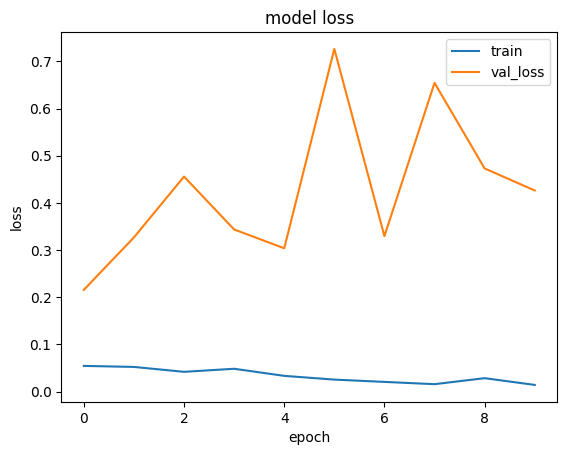

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val_loss'])
plt.show()

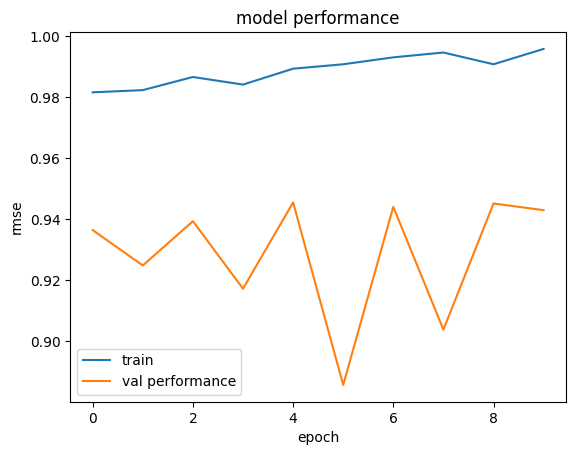

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model performance')
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.legend(['train', 'val performance'])
plt.show()

# Model Evaluation and Testing

In [23]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [24]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [25]:
test_dataset = test_dataset.batch(1)

In [26]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [27]:
lenet_subclassed_model.evaluate(test_dataset)

2757/2757 [==============================] - 26s 5ms/step - loss: 0.2368 - tp: 1227.0000 - fp: 66.0000 - tn: 1331.0000 - fn: 133.0000 - accuracy: 0.9278 - precision: 0.9490 - recall: 0.9022 - auc: 0.9790


[0.23684945702552795,
 1227.0,
 66.0,
 1331.0,
 133.0,
 0.927820086479187,
 0.9489558935165405,
 0.9022058844566345,
 0.9789502024650574]

In [28]:
lenet_subclassed_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 13s 13s/step


0.8443248

# Visualizing Confusion matrix

In [29]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [30]:
print(np.array(inp).shape)
print(np.array(inp)[:,0, ...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [31]:
labels = np.array([i[0] for i in labels])

In [32]:
labels

array([1, 0, 0, ..., 0, 1, 1])

In [33]:
predicted = lenet_subclassed_model.predict(np.array(inp)[:,0, ...])
predicted[:, 0]

87/87 [==============================] - 2s 19ms/step


array([0.87610525, 0.02148896, 0.18745045, ..., 0.0575326 , 0.8603478 ,
       0.85451925], dtype=float32)

[[1307   88]
 [  94 1268]]


Text(0.5, 58.7222222222222, 'predicted')

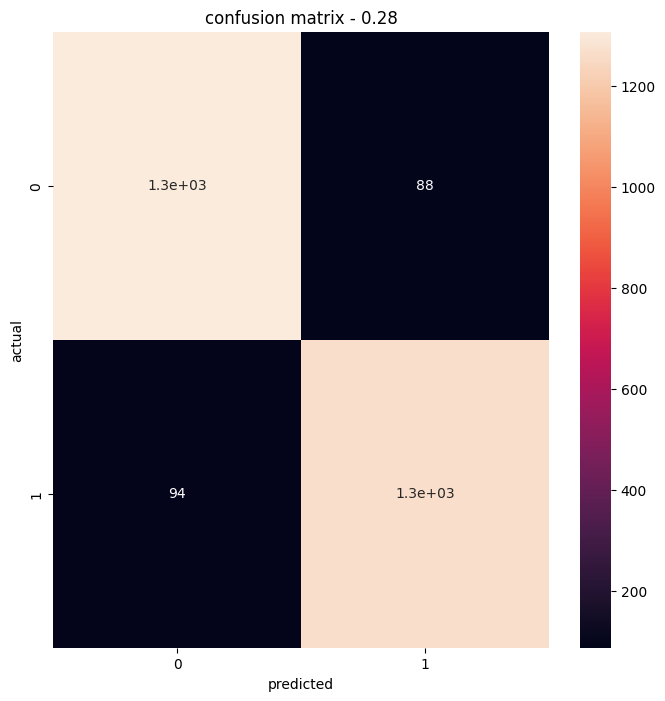

In [40]:
threshold = 0.28

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize = (8,8))

sns.heatmap(cm, annot=True)
plt.title('confusion matrix - {}'.format(threshold))
plt.ylabel('actual')
plt.xlabel('predicted')


# ROC plot

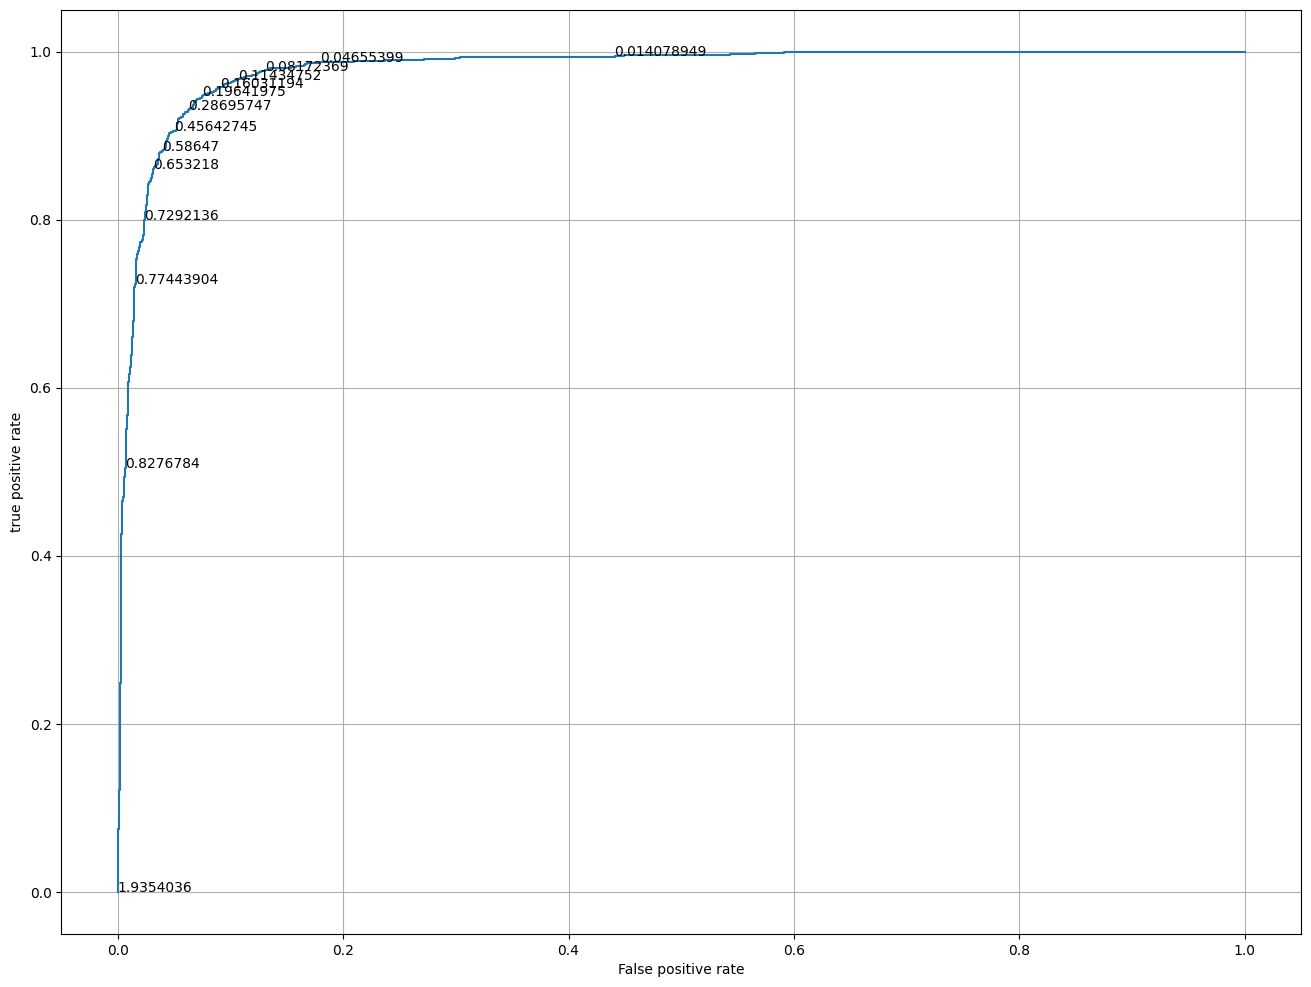

In [35]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.figure(figsize=(16, 12))
plt.plot(fp, tp)
plt.xlabel('False positive rate')
plt.ylabel('true positive rate')
plt.grid()

skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])
plt.show()

In [36]:
def parasite_or_not(x):
  if(x < 0.5):
    return 'P'
  else:
    return 'U'

In [37]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])


1/1 [==============================] - 12s 12s/step


'U'

1/1 [==============================] - 0s 26ms/step


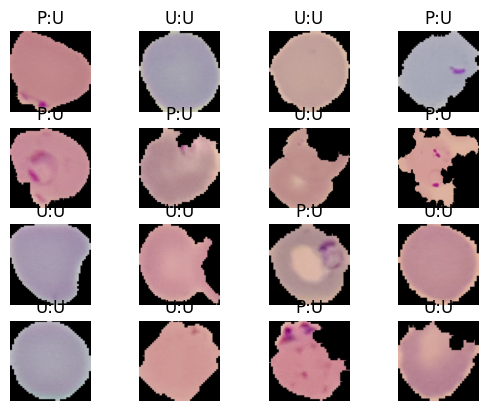

In [38]:
for i , (image, label) in enumerate(test_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [39]:
# model.save('malaria_diagnosis.keras')